# Lecture 00 - 20190116 | Repaso Estadística y Econometría I | Intro Python

# OLS

### A city's physical structures, once established, may remain in place for more than 150 years

<img src="https://royalsocietypublishing.org/cms/asset/508e81bb-e2ef-4893-be6c-3a4edf762831/rsif20140924f01.jpg" width=1000>

<img src="https://royalsocietypublishing.org/cms/asset/b3f27212-3193-4463-9801-7691341ba4af/rsif20140924f05.jpg" width=1000>

<img src="https://raw.githubusercontent.com/andrespdlr/cities_fingerprints/master/images/morelia_map.png" width=1000>

<img src="https://raw.githubusercontent.com/andrespdlr/cities_fingerprints/master/images/df_map.png" width=1000>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from random import sample
import math as mt
import itertools
import numpy as np
import statsmodels.api as sm

In [3]:
loc_file = './databases/localidades_INEGI.xlsx'
calles_home = './databases/calles_inegi/'
factor_mts = 108206.1961983093

In [4]:
localidades = pd.read_excel(loc_file, converters={'cve_ent': str,
                                                  'cve_mun': str,
                                                  'cve_loc': str})

In [5]:
def import_localidad_gdf(edo, mpo, localidad):    
    shapefile_edo = calles_home + '{}/eje_vial_{}.shp'.format(edo, edo)
    calles_edo_gdf = gpd.read_file(shapefile_edo)
    calles_localidad_gdf = calles_edo_gdf.loc[(calles_edo_gdf['CVE_MUN'] == mpo) & (calles_edo_gdf['CVE_LOC'] == localidad)]
    calles_localidad_gdf = calles_localidad_gdf.reset_index(drop=True)
    return calles_localidad_gdf

In [24]:
edo = '13'
mpo = '048'
localidad = '0001'
calles_localidad_gdf = import_localidad_gdf(edo, mpo, localidad)

In [25]:
calles_localidad_gdf.to_file(calles_home + '{}/{}_{}_{}.shp'.format(edo, edo, mpo, localidad))

In [26]:
G = nx.read_shp(calles_home + '{}/{}_{}_{}.shp'.format(edo, edo, mpo, localidad), simplify=True)

In [27]:
G2 = nx.Graph()
contador = 0
nodes_shortnames = {}
pos = {}
for node in G.nodes():
    G2.add_node(contador)
    nodes_shortnames[node] = contador
    pos[contador] = node
    contador += 1
for edge in G.edges():
    e_0 = edge[0]
    e_1 = edge[1]
    e_0_sn = nodes_shortnames[e_0]
    e_1_sn = nodes_shortnames[e_1]
    G2.add_edge(*(e_0_sn, e_1_sn))

In [28]:
def extrae_min_max_pos(pos):
    X = []
    Y = []
    for x, y in pos.values():
        X.append(x)
        Y.append(y)
    min_x = min(X)
    max_x = max(X)
    min_y = min(Y)
    max_y = max(Y)
    return min_x, max_x, min_y, max_y

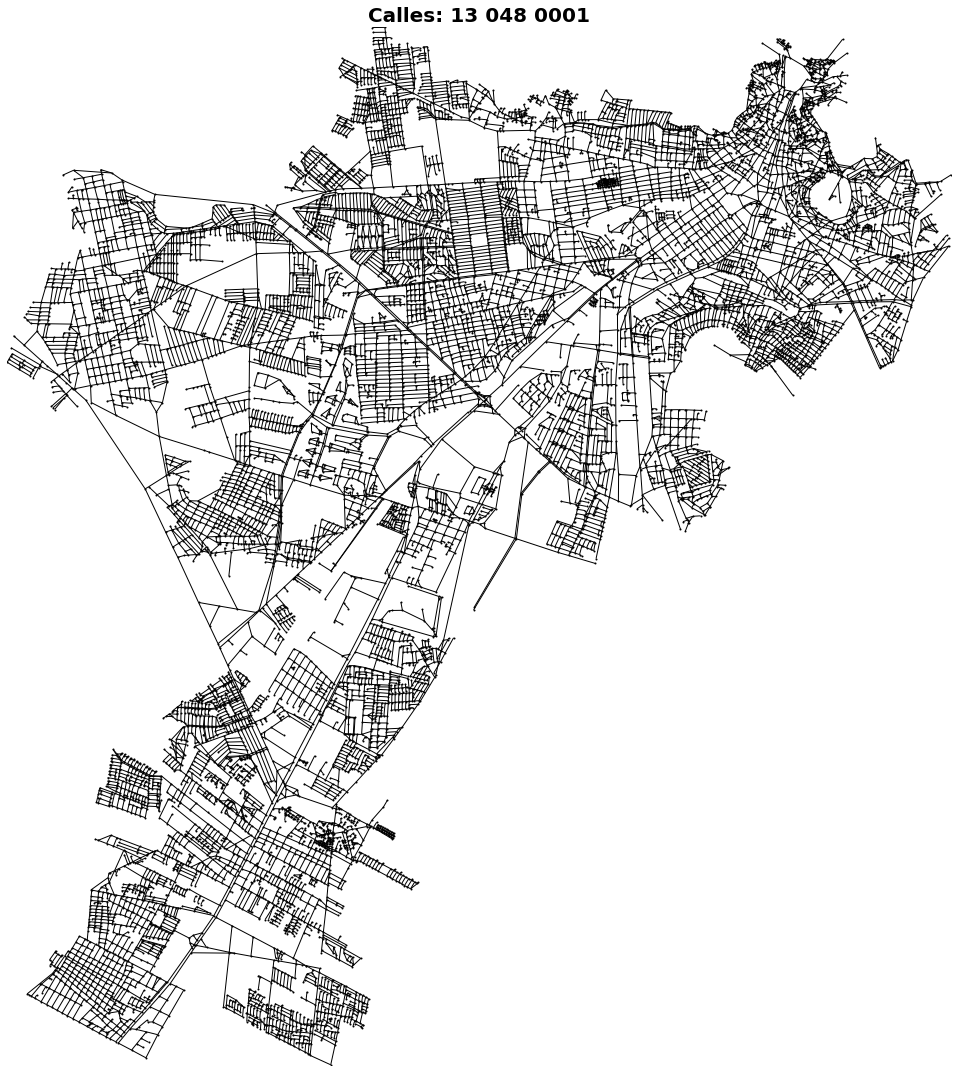

In [29]:
fig, ax = plt.subplots(figsize=(15, 15))
axis = plt.gca()
ax.set_aspect('equal')
plt.axis('off')
plt.title('Calles: {} {} {}'.format(edo, mpo, localidad), fontsize=20, fontweight='bold')
nx.draw(G2, pos, node_size=1, node_color='black')
fig.tight_layout()
min_x_global, max_x_global, min_y_global, max_y_global = extrae_min_max_pos(pos)
plt.xlim(min_x_global, max_x_global)
plt.ylim(min_y_global, max_y_global)
plt.show()
plt.close(plt.gcf())

In [30]:
def euclidean_distance(pos, node_0, node_1):
    node_0_pos = pos[node_0]
    x_0 = node_0_pos[0]
    y_0 = node_0_pos[1]
    node_1_pos = pos[node_1]
    x_1 = node_1_pos[0]
    y_1 = node_1_pos[1]
    distance = mt.sqrt(pow((x_1 - x_0), 2) + pow((y_1 - y_0), 2))
    return distance

In [31]:
def network_distance(pos, nodes):
    n_d = 0
    for i in range(len(nodes)):
        if i < len(nodes) - 1:
            node_0 = nodes[i]
            node_1 = nodes[i + 1]
            e_d = euclidean_distance(pos, node_0, node_1)
            n_d += e_d
    return n_d

In [32]:
def format_distance(distance):
    rv = str(round(distance *  factor_mts, 5)) + ' mts'
    return rv

In [33]:
def draw_shortest_path(G, pos, node_0, node_1):
    sp = nx.shortest_path(G, node_0, node_1)
    X = []
    Y = []
    for node in sp:
        node_pos = pos[node]
        x = node_pos[0]
        y = node_pos[1]        
        X.append(x)
        Y.append(y)
    min_x = min(X)
    max_x = max(X)
    min_y = min(Y)
    max_y = max(Y)
    min_x_global, max_x_global, min_y_global, max_y_global = extrae_min_max_pos(pos)
    fig, ax = plt.subplots(figsize=(15, 15))
    axis = plt.gca()
    ax.set_aspect('equal')
    plt.axis('off')
    nx.draw(G, pos, node_size=1, node_color='black')
    plt.plot(X, Y, '.r-', linewidth=4)
    plt.plot([pos[node_0][0], pos[node_1][0]], [pos[node_0][1], pos[node_1][1]], '.b--', linewidth=4)
    e_d = euclidean_distance(pos, node_0, node_1)
    n_d = network_distance(pos, sp)
    plt.title('Euclidean: ' + format_distance(e_d) + ' | ' + 'Dijkstra: ' + format_distance(n_d), fontsize=20, fontweight='bold')
    plt.xlim(min_x_global, max_x_global)
    plt.ylim(min_y_global, max_y_global)    
    fig.tight_layout()
    plt.show()
    plt.close(plt.gcf())

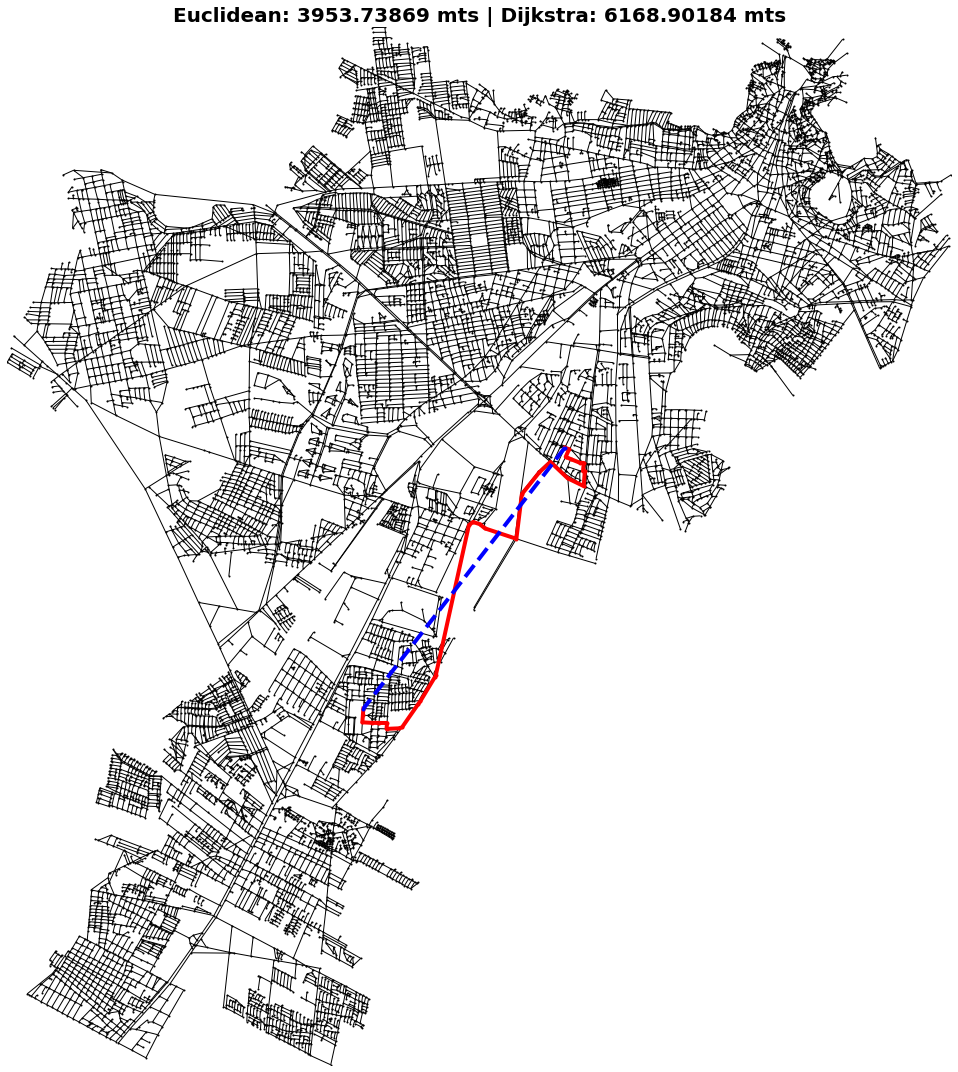

In [34]:
sample_nodes = sample(list(G2.nodes), 2)
draw_shortest_path(G2, pos, sample_nodes[0], sample_nodes[1])

## Simulation

In [35]:
def combinations(input_list, subset_size):
    rv = []
    for subset in itertools.combinations(input_list, subset_size):
        rv.append(subset)
    return rv

In [36]:
def draw_shortest_path_simulation(G, pos, nodes_combinations):
    fig, ax = plt.subplots(figsize=(15, 15))
    axis = plt.gca()
    ax.set_aspect('equal')
    plt.axis('off')
    nx.draw(G, pos, node_size=1, node_color='blue')
    min_x_global, max_x_global, min_y_global, max_y_global = extrae_min_max_pos(pos)
    sum_euclidean = 0
    sum_dijkstra = 0
    iterations = 0
    for node_0, node_1 in nodes_combinations:
        try:
            sp = nx.shortest_path(G, node_0, node_1)
            X = []
            Y = []
            for node in sp:
                node_pos = pos[node]
                x = node_pos[0]
                y = node_pos[1]        
                X.append(x)
                Y.append(y)
            plt.plot(X, Y, '.r-', linewidth=2)
            plt.plot([pos[node_0][0], pos[node_1][0]], [pos[node_0][1], pos[node_1][1]], '.b--', linewidth=.1)
            e_d = euclidean_distance(pos, node_0, node_1)
            n_d = network_distance(pos, sp)
            sum_euclidean += e_d
            sum_dijkstra += n_d
            iterations += 1
        except:
            pass
    mean_euclidean = sum_euclidean / iterations
    mean_dijkstra = sum_dijkstra / iterations
    plt.title('Simulations: ' + str(len(nodes_combinations)) + ' | Mean Euclidean: ' + format_distance(mean_euclidean) + ' | ' + 'Mean Dijkstra: ' + format_distance(mean_dijkstra), fontsize=20, fontweight='bold')
    plt.xlim(min_x_global, max_x_global)
    plt.ylim(min_y_global, max_y_global)    
    fig.tight_layout()
    plt.show()
    plt.close(plt.gcf())

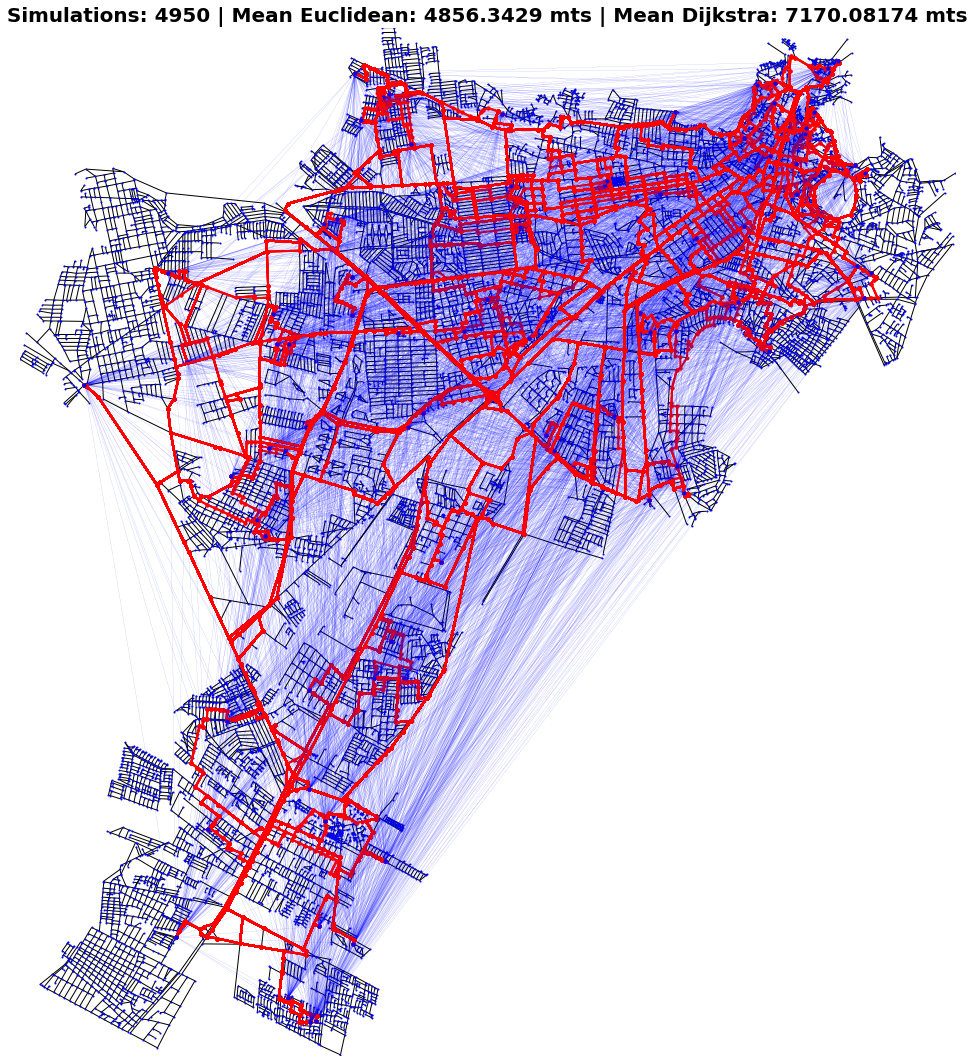

In [37]:
#sample_size = mt.ceil(len(list(G2.nodes)) * .20)
sample_size = 100
sample_nodes = sample(list(G2.nodes), sample_size)
nodes_combinations = combinations(sample_nodes, 2)
draw_shortest_path_simulation(G2, pos, nodes_combinations)

In [28]:
def scatterplot_euclidean_dijkstra(X, Y):
    max_x = max(X)
    max_y = max(Y)
    max_global = max([max_x, max_y])
    mean_x = np.mean(X)
    mean_y = np.mean(Y)
    fig = plt.figure(figsize=(15, 15))
    plt.xlabel('Euclidean Distance (mts)', fontsize=20)
    plt.ylabel('Dijkstra Distance (mts)', fontsize=20)
    plt.plot([0, max_global], [0, max_global], color='black', linestyle='solid', linewidth=1)
    plt.plot(X, Y, 'o', c='black', markersize=2, color='red')
    plt.xlim(0, max_global)
    plt.ylim(0, max_global)    
    plt.show()
    plt.close(plt.gcf())

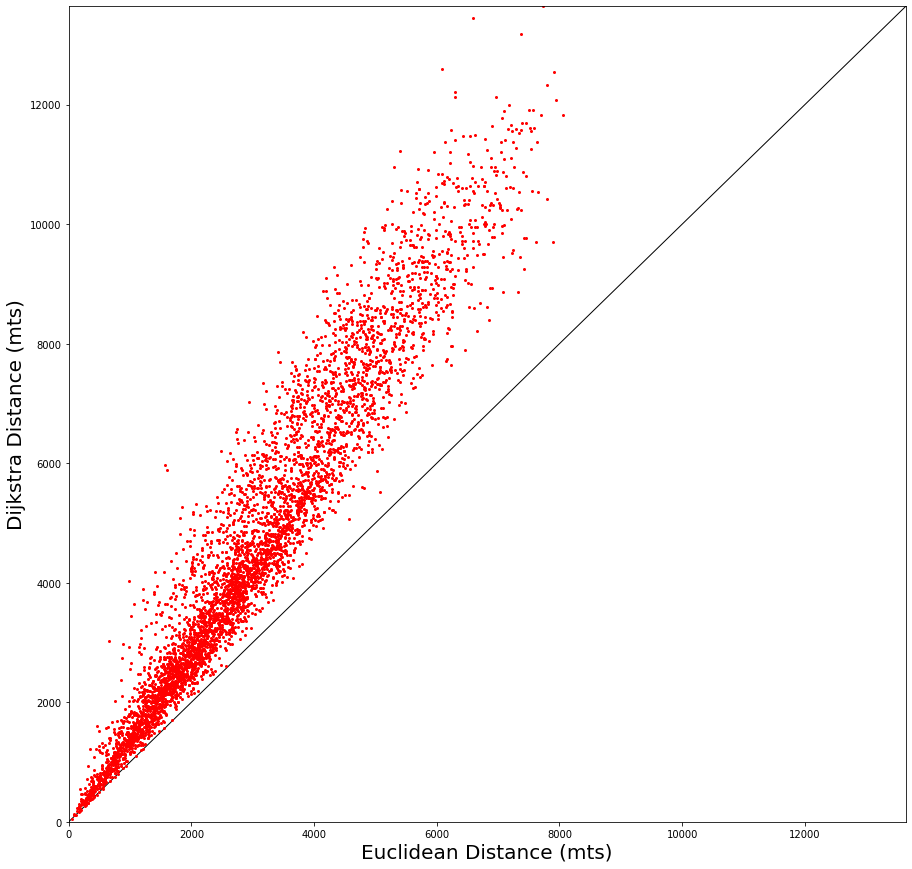

In [29]:
#sample_size = mt.ceil(len(list(G2.nodes)) * .20)
sample_size = 100
sample_nodes = sample(list(G2.nodes), sample_size)
nodes_combinations = combinations(sample_nodes, 2)
X = []
Y = []
for node_0, node_1 in nodes_combinations:
    try:
        sp = nx.shortest_path(G2, node_0, node_1)
        e_d = euclidean_distance(pos, node_0, node_1) * factor_mts
        n_d = network_distance(pos, sp) * factor_mts
        X.append(e_d)
        Y.append(n_d)
    except:
        pass
scatterplot_euclidean_dijkstra(X, Y)

In [30]:
model = sm.OLS(Y,X).fit()
beta = model.params.tolist()[0]
R2 = model.rsquared
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.982
Model:                            OLS   Adj. R-squared (uncentered):              0.982
Method:                 Least Squares   F-statistic:                          2.697e+05
Date:                Thu, 16 Jan 2020   Prob (F-statistic):                        0.00
Time:                        09:54:16   Log-Likelihood:                         -39579.
No. Observations:                4950   AIC:                                  7.916e+04
Df Residuals:                    4949   BIC:                                  7.917e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.5447      0.003    519.365      0.000       1.539       1.551
==============================================================================
Omnibus:                      592.866   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              917.999
Skew:                           0.859   Prob(JB):                    4.56e-200
Kurtosis:                       4.225   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
def scatterplot_euclidean_dijkstra_model(X, Y):
    model = sm.OLS(Y,X).fit()
    beta = model.params.tolist()[0]
    R2 = model.rsquared
    max_x = max(X)
    max_y = max(Y)
    max_global = max([max_x, max_y])
    mean_x = np.mean(X)
    mean_y = np.mean(Y)
    fig = plt.figure(figsize=(15, 15))
    plt.title(r'$\beta$ ' + str(beta) + ' | R2: ' + str(R2), fontsize=20, fontweight='bold')
    plt.xlabel('Euclidean Distance (mts)', fontsize=20)
    plt.ylabel('Dijkstra Distance (mts)', fontsize=20)
    plt.plot([0, max_global], [0, max_global], color='black', linestyle='solid', linewidth=1)
    plt.plot(X, Y, 'o', c='black', markersize=2, color='red')
    plt.plot([0, max_global], [0, max_global * beta], color='black', linestyle='solid', linewidth=2)
    plt.xlim(0, max_global)
    plt.ylim(0, max_global)    
    plt.show()
    plt.close(plt.gcf())

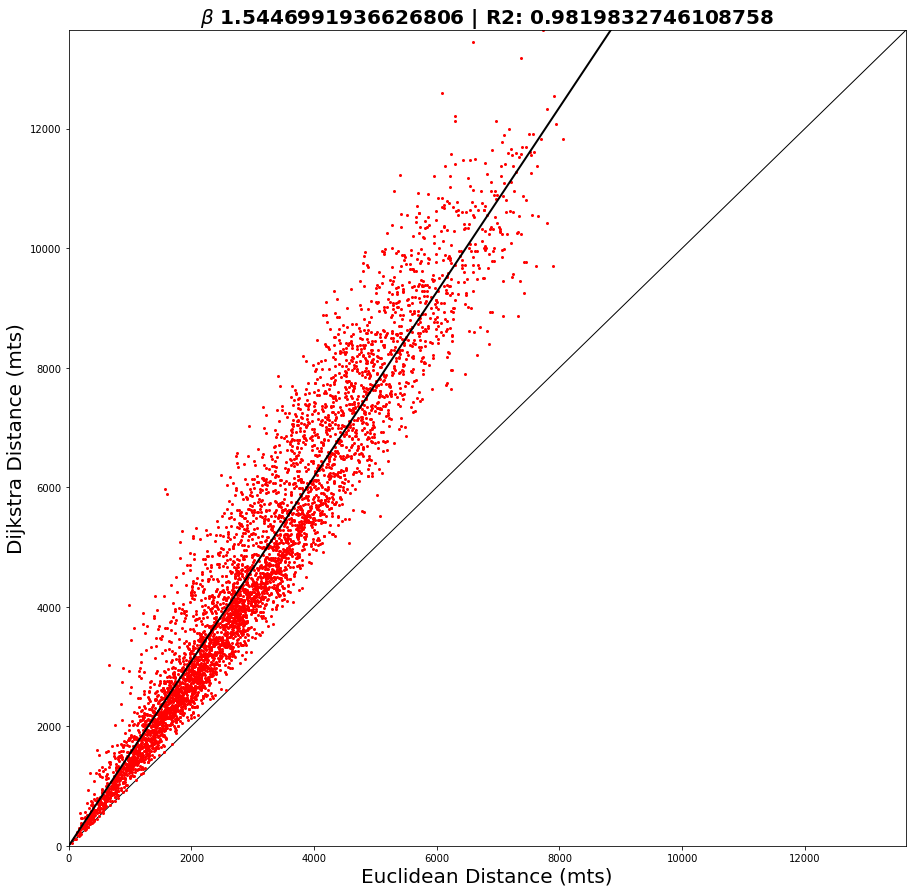

In [32]:
scatterplot_euclidean_dijkstra_model(X, Y)

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABDQAAALUCAYAAAD0emLCAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAIABJREFUeJzs3Vlso+l97/nfS2qXqH2Xaq/uru5qd6cXO3bseKmx52LO%0ABMeAczq5mCsjd0EQzKUTBEjQMHxjJHcBEsQHnjPIXHgygzmZQc7ijBOPT5y0u+20265ea9MuUSS1%0Aciff/1w8erVUcasuinpZ9f3cxHZR1ENKBPL89F88MzMBAAAAAAC0kchZHwAAAAAAAOBhEWgAAAAA%0AAIC2Q6ABAAAAAADaDoEGAAAAAABoOwQaAAAAAACg7RBoAAAAAACAttPRqm/09ttv67vf/a5839eN%0AGzf01a9+9cS//+hHP9Lf/u3fyszU29ur3/md39GFCxca+tpKbt68qevXr5/KawEeB3xGgNr4jAC1%0A8RkBauMzAtTWjM9ISyo0fN/Xd77zHf3BH/yB/vRP/1T/9E//pOXl5ROPmZqa0p/8yZ/o29/+tr72%0Ata/pL//yLxv+2kpu3rx5Kq8FeFzwGQFq4zMC1MZnBKiNzwhQWzM+Iy0JNG7duqXp6WlNTk6qo6ND%0An/3sZ/XWW2+deMzTTz+tvr4+SdLVq1eVTCYb/loAAAAAAPBkaUmgkUqlNDY2dvjfR0dHlUqlqj7+%0ABz/4gV566aWP9bUAAAAAAODx17IZGo365S9/qX/4h3/Q66+//lBfd/PmzRMlK6+99lqzjwY8VviM%0AALXxGQFq4zMC1MZnBKjttdde0/e+973D/379+vWHnqnRkkBjdHT0sIVEkpLJpEZHRx943MLCgv7i%0AL/5Cf/iHf6iBgYGH+tpKL351dbVZLwF47MRiMe3t7Z31MYDQ4jMC1MZnBKiNzwhQ2+zs7CMHfy1p%0AObly5YrW19cVj8dVKpX04x//WK+++uqJxyQSCX3729/W7/3e72l6evqhvhYAAAAAADxZWlKhEY1G%0A9fWvf13f/OY3D1evzs/P6/vf/74k6Stf+Yr+5m/+Rul0Wn/1V391+DXf+ta3qn4tAAAAAAB4cnlm%0AZmd9iNNCywlQHWWQQG18RoDa+IwAtfEZAWqbnZ195OdoScsJAAAAAABAMxFoAAAAAACAtkOgAQAA%0AAAAA2g6BBgAAAAAAaDsEGgAAAAAAoO0QaAAAAAAAgLZDoAEAAAAAANoOgQYAAAAAAGg7BBoAAAAA%0AAKDtEGgAAAAAAIC2Q6ABAAAAAADaDoEGAAAAAABoOwQaAAAAAACg7RBoAAAAAACAtkOgAQAAAAAA%0A2g6BBgAAAAAAaDsEGgAAAAAAoO0QaAAAAAAAgLZDoAEAAAAAANoOgQYAAAAAAGg7BBoAAAAAAKDt%0AEGgAAAAAAIC2Q6ABAAAAAADaDoEGAAAAAABoOwQaAAAAAACg7RBoAAAAAACAtkOgAQAAAAAA2g6B%0ABgAAAAAAaDsEGgAAAAAAoO0QaAAAAAAAgLZDoAEAAAAAANoOgQYAAAAAAGg7BBoAAAAAAKDtEGgA%0AAAAAAIC2Q6ABAAAAAADaDoEGAAAAAABoOwQaAAAAAACg7RBoAAAAAACAtkOgAQAAAAAA2g6BBgAA%0AAAAAaDsEGgAAAAAAoO0QaAAAAAAAgLZDoAEAAAAAANoOgQYAAAAAAGg7BBoAAAAAAKDtEGgAAAAA%0AAIC2Q6ABAAAAAADaDoEGAAAAAABoOwQaAAAAAACg7RBoAAAAAACAtkOgAQAAAAAA2g6BBgAAAAAA%0AaDsEGgAAAAAAoO0QaAAAAAAAgLZDoAEAAAAAANoOgQYAAAAAAGg7BBoAAAAAAKDtEGgAAAAAAIC2%0AQ6ABAAAAAABaIl80fbBoTXmujqY8CwAAAAAAQA331k1m0tPnmvN8BBoAAAAAAODUJHdNiW3pwrTU%0A0+U17XkJNAAAAAAAQNMVSqY7q9JoTHrmfPOCjACBBgAAAAAAaKqFDVOpLD1zTvK85ocZEoEGAAAA%0AAABokq09U3xLOjcl9XWfTpARINAAAAAAAACPpHjQXjJySu0llRBoAAAAAACAj20pbioU3faSRtpL%0ACkXWtgIAAAAAgDOyvW/aSEnzk1J/T/0gw8y0sCGZSRcvPPr3J9AAAAAAAAANK5VNt1ekoYHG20sS%0AO6bUrnR+qnmrWwk0AAAAAABAQ5bipnxBeuqcFGmgvSRXMC2sS2OD0tPnmjtbg0ADAAAAAADUtLNv%0AWktJ8xPSQG9j7SX31iXPa3y2xsMi0AAAAAAAABWVfddeEuuTrjXYXrK5bdraky5MS92dp7fxhEAD%0AAAAAAAA8YCVhyuakq3NSJFI/mMjmTYsb0vhQ89tLKiHQAAAAAAAAh3bTprWkNDsuzY031l5yd02K%0ARhofEtoMBBoAAAAAAEC+b7q1Ig30Nh5MxLdM2/vSxRmpq6N1YYZEoAEAAAAAwBNvNWFKP0R7SSZn%0AWt6UJoZb015SCYEGAAAAAABPqL2MaTUhzYxJsw22l9xZlbo6zy7ICBBoAAAAAADwhPF90+1Vqa+7%0A8faSjZRpJy1dnpU6omcbZkgEGgAAAAAAPFHWkqa9jHRlToo20F6SzppWEtLkiPT06NkHGQECDQAA%0AAAAAngD7WdPKpjQ9Ks2M1Q8m/IP2kp6us28vqYRAAwAAAACAx5hvpjsrUs9DtJcEVRxhaS+phEAD%0AAAAAAIDH1HrKtPsQcy/2s25I6FSDVRxniUADAAAAAIDHTDpnWo4fzL1ooF3E9117SW9PONtLKiHQ%0AAAAAAADgMXF8rWqj7SWrCVM656o4GhkSGhYEGgAAAAAAPAY2UqbtfRdMdHbUDyb2Mqa1pBsSOjve%0APkFGgEADAAAAAIA2lsmbFjekyeHGqjLKB+0l/b3t015SCYEGAAAAAABtKGgv6YhK1xpsL1nZNGXz%0A0pVZKdJG7SWVEGgAAAAAANBmNrdNW3vSxRmpq4H2kp20aSMlzYxJcxPtHWQECDQAAAAAAGgTuYJp%0AYV0aH26sXaRUdlUcsb72bi+phEADAAAAAICQMzPdXZMikca3lyxvmnIF6eq8FPEerzBDItAAAAAA%0AACDUEtum5K5rL+nurB9MbO2ZNreluXGpv/fxCzICBBoAAAAAAIRQvmi6tyaNDTVWlRG0lwz2P37t%0AJZUQaAAAAAAAECJmpnvr7j8/fU7yGmgXWYqbCkXpqfnGHv84INAAAAAAACAkkjumxI50YVrq6aof%0ATKR2XXvJuUmpr+fJCDICBBoAAAAAAJyxQtF0Z00aG2ysvaRQMt1dlUZijQ8JfdwQaAAAAAAAcIYW%0A1k1lX3qmwfaShQ1Tudx4O0rY7GWsKc9DoAEAAAAAwBkI2kXOT0m93fWDieSuKbnj2ksaeXzYBENL%0A+3ub83wEGgAAAAAAtFCx5C72jbaLFIpuSOhIrD23lwRDTn1fujovRZpUVUKgAQAAAABAiyxumIoN%0AtouYmRY2JLP23V6ynjLtpt2Q0+7O5p6fQAMAAAAAgFO2tWeKbzW+jSSxY0rtunaURradhM1O2rSR%0AkiZHpOnR0zk/gQYAAAAAAKekVDbdXpGGBxprL8kVTAvr0thQe7aXFEqme2tSrO/0z0+gAQAAAADA%0AKViKm/JF6alz9edGBHMmIl57bi8xc2tnI17r2mMINAAAAAAAaKLtfdduMT8h9ffWv9hvbpu29qSL%0A01JXk+dMtMJq0rSfkS7OSF0drTs/gQYAAAAAAE0QrCUd7G+svSSbNy1uSOPD7dlesrXn1s5Oj0qz%0AY60/P4EGAAAAAACPaHnTlCs0tpY0aM/oiDYWfIRNruCCmKH+sw1iCDQAAAAAAPiYdtKm9aQ0NyEN%0ANNBeEt8ybe9Ll2akzha2ZzSDb64CpSMajjWyBBoAAAAAADyksu+2lwz0NVZlkcmZljeliTZtL1nZ%0ANKVz0uVZqSMajvMTaAAAAAAA8BBWEqZMTro6J0UitS/3vpnurkpdne0ZZCR3TckdaXZcmpsI1/kJ%0ANAAAAAAAaMBexrSaOLjcj9e/3K+nTLvpcFU1NCqTNy3HpZFYeIMYAg0AAAAAAGrwfdOtFam/t7H2%0AknTWtJKQJkek6dFwhgHV+L6bk9EOFSUEGgAAAAAAVLGaNO1npCtzUrSB9pI7K1JPd/jDgEqW4m5T%0Ay+XZ+q81DAg0AAAAAAC4T9BeMj0mzY7Vv9yvJU37Wbe9pN3aSxLbptSeND8h9fW0z9kJNAAAAAAA%0AOBBUWfR2N9ZespcxrSWlqVFppoHgI0yC1pixwfasKCHQAAAAAABADzfEM5g10dfTfmFAqdy+Zz+O%0AQAMAAAAA8ERLZ03Lm9L0aGNDPFcTpnROujJbf21rmJiZFjakUlm6Oi9FvPY5eyUEGgAAAACAJ5Jv%0ArlKhu7Ox9pLdtGk9Jc2MSbMNrG0Nk/iWaXtfOj8l9XS119mrIdAAAAAAADxx1lOmnX23vaRee0nZ%0AN91ekQb62q9FI5jxMTHcfmevh0ADAAAAAPDEyORMi3FpaqSxqoyVTVM2L12da6/2kmLJVZ/EQhjC%0A+GZNeR4CDQAAAADAY88O2ks6O6RrDQQZO/umjS1pdlyamwhXIFCLmeneuuSb9PQ5yQvZnIzFDVO+%0AKM3PPfpzEWgAAAAAAB5r8S3T1p7bXtLZUfuCH2wAGewPX2VDPcGWlovTUldnuM4enO3cpNTb3Zyz%0AEWgAAAAAAB5L2bxpccPNj2ikvWQp7qoH2m0DSFBNMjXS2JaWVkrtmhI70lSDG2QeBoEGAAAAAOCx%0AYma6syZ1RBoLMrb2TJvb0tyE1N8TrkCglkLRdHdNGhoIXzVJOmtaSUgjsdM7G4EGAAAAAOCxsblt%0ASu1Kl2bqt10USweBQJu1lwSBTcQL35yMQsl0b03q7zn995RAAwAAAADQ9nIFNwxzYqixqozFDVOx%0ALD01H65AoJ7VhGk/6wKbevNAWsk3091VKRJp3XtKoAEAAAAAaFvBVg/Pk55poFohmOkwPyn1NWk4%0AZSsEbTEzY9LseLjOvbhhKhSlizNSR7R1ZyPQAAAAAAC0pcSOCycuzUjdddpLglaI4RDOm6glVzAt%0ArJ/uLIqPK9hccn5K6ulq/dkINAAAAAAAbSV/MAxzfFC61kB7ycK6ybf2ai/xzXRnRersCN+cjNPc%0AXPIwCDQAAAAAAG3j3rrJrLH2kuSOKbl7dhUEH9dS3JTNS5dnW9vCUc9+1rR6yptLHgaBBgAAAAAg%0A9JK7psS2dGG6fjiRL7r2krHBcFy8G5U8aKGZn5D6J8Nz7sPNJb3hej8JNAAAAAAAoVUoue0Zo4P1%0At5cEA0Kl8LVp1JLJmZY3pdFYYxtaWsX3XWtPKzeXPAwCDQAAAABAKC1smErlxsKJxLZrL7nYwIDQ%0AsCj7pjurUk9XuCofzEyLG1KxJF2alaKR8JztOAINAAAAAECopHbditJzU/VXq+YK7vI91kAFR5gE%0Aq06vzEqREAUGZ7255GEQaAAAAAAAQqFYchULIw20Xpi5dohoJFzVDfVsbpu29qT5yfphTSsld03J%0AEGwueRgEGgAAAACAM7e4YSqWGmsviW+Ztvdde0lXR3tcvoMNIWND4QpggnONhmRzycMg0AAAAAAA%0AnJmtPdPGlnRuUurvqX2hzuRNSxvSxHD7XL5LZVd10t8TrjMXim6Aatg2lzwMAg0AAAAAQMsFF/3B%0AfulaA+0ld9akzmj7zMkwMy1sSOWydHVeioRkQ4jvu/cyGtLNJQ+DQAMAAAAA0FLLm6ZcobGL/kbK%0AtJOWLs1InW3SXhKcOUyDNc1Mi3GpWAz35pKHQaABAAAAAGiJnX3Tekqan5D6e2tfqNM508pme7WX%0A7Kbd6wvbmdeSpr1MuAKWZiDQAAAAAACcqrJvur0ixfrqt4z45lpRujvDFQrUUiiZ7q1JA33hOnOw%0AuWR6VJoZC8+5moVAAwAAAABwalY2Tdm8dHVOitRpc1hPmXbT0uVZqSMa/gt4sDpWCtc8inbeXPIw%0ACDQAAAAAAE23mzatJqW5cWluovalOriAT41I06PtcQEP2jjCtDr2cdhc8jAINAAAAAAATRO0lwz0%0A1t9e4vuuvaS3u30u4Nv7pviWNBWiNo7HaXPJwyDQAAAAAAA0xWrCtJ9trL1kNWlKZ117STts3MgX%0A3ZyMoYHwhC9mpsUNqVhqn80l2bxpKS7Nzj76cxFoAAAAAAAeyV7GtJKQZsek2fHal+q9jGkt6QZV%0AzoakwqEW30x3V6VoVHr6XHiqH9ptc0nQDtPT5apImoFAAwAAAADwsRy2jPTUby8pHzy2vyc8FQ71%0ArCSOqkjCMqS03TaXlMpucGpHtPntMAQaAAAAAICHFlQIXJmr3+qwkjBlc9KV2fqtKGGQ2jUldqSZ%0AMWmuTsVJqwSVLe2yuSSY6+F57nckcgqVLQQaAAAAAICG7WdNK5uNVQjspE0bqXAFA7UE8x2GQzQn%0AI2jVGGiTzSXBKlvfdxtgKlW2mFlTvheBBgAAAACgLt9Md1aknm7pmTrtJaWyay+J9bXHJTxonens%0ADM95gwqH02jVOA3BgNJCSbowXXmVrZlpMS7lC9Lc3KN/TwINAAAAAEBN6ynTbrqxWRLLm6ZcQbo6%0AfzptBs22FHfnDcu2FTPTwoZUaqPNJcubpkyu9oDSRh7zsAg0AAAAAAAVpXOm5bg0OVK/cmF73xTf%0AkubGpf7e8F/CEzum1K40NyH194TjvO22uSQ479yEND9R+bzBet658eqP+bgINAAAAAAAJ5iZbq9K%0A3Z2Nt5cM9oenXaOWdM7NABkdDM95kzum5G77bC6Jb5m292ufdyNl2s2c7npeAg0AAAAAwKGNlGkn%0ALV2akTorzEE4biluKhTbo70kWBvb2x2eIONwc0mIwpVaguBlYrj6eTe3XdgxOSxNjZ7uayLQAAAA%0AAAAokzctbTTWXrK1Z9rcluYnpL6QtGvUsrBhKpbCszY2XzQttNHmkqCdqFbwktx1LTzjQ9JT87Vf%0AUzrHlhMAAAAAwCMyO9qmUa+9pFhyKznDtNa0lqA14tyk1Nt99ucNtql0dLTH5pKggmSoRjvR1p4p%0AsSONxOoHGdm8aXlT6utuzvkINAAAAADgCbW5bdraky7OVF6zedzChqlcbq+L+PhQOIKXw80l5fbY%0AXJLJueBhoMba3d20q9oY7K8fZOQKbqVrb3f9xz4MAg0AAAAAeMLkCqZ767VnIQSSu6bkTniqHGoJ%0ABpT2h6iVYzVp2m+TzSVBK0ytOSPprGk1KcX6pKt1wolC0QU5XZ2nE4QRaAAAAADAE8LMtYxEItK1%0AOu0lhaILPUZi4QkHqjFzZ/UtPANKgwGaM2Ont+WjWYJWou4awUMm77bD9PXUr7IoltzPo6tDujp3%0AehU9BBoAAAAA8ARIbLsL9sUZqbuz+gUzaI8wa4/2kvWUaTctXZiu/bpapZ02l5R9091VF3BVC4Ie%0Apl2kVDbdW5Oi0dMNMgIEGgAAAADwGAvaS8aH6g/9TOy4TRXt0B6xs2/a2HJbWaZPeT1oI9ppc4l/%0AUKljVn2mx/Eqi3rBVtk/qPzxpMtzrauQIdAAAAAAgMdQ0IYhSc+cq30hzRXcZXwsJEM0awlaYQZr%0AbN5opXbaXBL8TpTK0qUZqSP64FkfpsrCPwgyJOnyTOtX4rYs0Hj77bf13e9+V77v68aNG/rqV796%0A4t9XVlb053/+57p3755++7d/W7/xG79x+G+/+7u/q97eXkUiEUWjUX3rW99q1bEBAAAAoO0kd9wq%0AzQvTtSstgguu50lP1wk9zlqwXjbihSM4MHOtGMU22VyyFDdl89Vbc3zfdHdd8lS/ysI3F3qYuRam%0As3rtLQk0fN/Xd77zHf3RH/2RRkdH9Y1vfEOvvvqq5ufnDx8Ti8X09a9/XW+++WbF5/jjP/5jDQwM%0AtOK4AAAAANCWCkX3F/PRwfrtJZvbrr3k0ozUFYLZE7WsJkz7WXfWzjrrZVtynoPNJWGZ21FL8N7N%0AT0p9FbbUPEw4EQRg5bJ7bKUKj1ZqSaBx69YtTU9Pa3JyUpL02c9+Vm+99daJQGNwcFCDg4P62c9+%0AVvE5zKwVRwUAAACAtrSwbir79SstsnnTUty1l9QLPc7a1p5pc/tgU8j42Z+1nTaXBMNSq713wfDX%0AUql+OHH8sRemwxEqSS0KNFKplMbGxg7/++joqG7dutXw13uep9dff12RSERf/vKX9eUvf/k0jgkA%0AAAAAbSe5a0psu0GevRX+Ah8IWjY6ouGYPVFLMNNjeCAcZ22nzSWJbVNqT5qqMizVzAVa+aJ0Yap2%0AdY6ZaTEuFYvu9ytslTxtMRT09ddf18jIiHZ3d/X6669rbm5Ozz777InH3Lx5Uzdv3jz876+99ppi%0AsVirjwq0ja6uLj4jQA18RoDa+IwAtbXiM1Iomj5aLmlsMKJXr0drPnY9WdbWnum5y9HQXUqP833T%0AR0tldXZIrzwXPfM5GfmC6c5qWbF+T688V/s9PmvJXV/xlK+J4YgunYtUfMziRlnprOnyuWjN8EuS%0A7q2VlSuYrp6PntrGm+9973uH//n69eu6fv36Q319SwKN0dFRJZPJw/+eTCY1Ojra8NePjIxIcm0p%0An/rUp3Tr1q0HAo1KL35vb+8RTg083mKxGJ8RoAY+I0BtfEaA2k77M7K4YSqW3WYJz/NU7Vtlcu6v%0A8ZMj0vyYp3xOyudO7ViPZGXTlM5Jl2dd+8P+/tmdJVhD2hl1lQm13uOztpM2baRcNcv8QRvM/Wdd%0ATZrSWWl2XBoZ81QqSHuFys+3smnK5KX5CWlswFMxLxXzzT93LBbTa6+99kjP0ZJA48qVK1pfX1c8%0AHtfo6Kh+/OMf6/d///crPvb+WRn5fF6+76u3t1e5XE7vvPOOfvM3f7MVxwYAAACAUNnaM21sSecn%0Apb6eOu0lq1JnR/jnZARzKebGpbmJs99csrDh1pqexRrSh5HOmlYStdfXbqRMuxlperT+zI/VhAuU%0AZkPwc2hUSwKNaDSqr3/96/rmN795uLZ1fn5e3//+9yVJX/nKV7S9va1vfOMbymQyikQi+ru/+zv9%0A2Z/9mXZ2dvTtb39bktuW8rnPfU4vvvhiK44NAAAAAKFQKptur7i/wl+rE1AEwyCDSoewyuRMy5vS%0ASCwccynaZXNJruDWxfb3VH/fjs/RmKowR+O4taTbgtLKwauFUnOWfnj2GK8PWV1dPesjAKFFqTBQ%0AG58RoDY+I0BtzfyMLMVN+aILKCI1Zkqksy4gmBqVhgfCeyEv+656pLtTOj919udM7Lj1tTNjUqzv%0A7M9TTaHk1qt2d7kKnUrzRZK77rWMDUqjg7Vfy/HqjVa97kLRVcB0RKXPvjL3yM/XFkNBAQAAAOBJ%0As73vZiPMT0r9NdpLfDPdWZF6usPfXrK4YSoUpSuzZ9/OEWwuGQv55pJS2c3z6IhKT81XDjK29916%0A25GY9NR87dcS3zLtpKXJ4frVG82SL7qtNV2d0tW52muFHwaBBgAAAACESKnsKhgG++sHFEG7wKWZ%0AcLeXBC0Q8xO1Z3+0QtCyMdAX7iDDPxhMKq96ALSXcaHXYH/9ICOxbdral8aH6j+2WYL3ururehjz%0AKAg0AAAAACAkljdNuYJ0db52e0lQXTA1Ks3UGfZ4lvazptWENDZ09uFB2TfdPRiUehqX62Yxc0GG%0A70sXqwRV6axpNSnF+qSrdcKJ420oYQky1pK+Zmcf/fsQaAAAAADAGdtJu4BifkIa6K3RXnIwf6K3%0AxkDIMAiqTGoNrmyVE5tLQtDqUo2ZaTEu5QsuyOjqePCcmbxpZVPq66kfTmztmRI7jbWhNEs27+a4%0AdHdWDjJWNn29vyiNDzfn+xFoAAAAAMAZKftue8lAX/3tJcFazcuzUjTEl/IgPKhXZdIKqwnXkhP2%0AzSUrm+5ne35K6ul68JzBDIre7vrhxPa+Kb7V2iAjkzctx6ufb3HD160VaXJEuvGyxwwNAAAAAGhn%0AKwlTJueGJNaqGthNm9ZTrV2r+XFspEzb+y48qHQpb6Xjm0vC/J6tJU17GWluXJqbePCcxZLp3rrU%0A1UCbzG7atLElDfW3riomkzOtJKSersrf8966rzurrjXqxsuRwyqUQtFoOQEAAACAdrOXcXMlZsel%0AuRqX7ePVG2fdtlHL7kG7zOTI2W9ZaZfNJfEtF/5MV5mBUiq7Fa3RaP2tIHsZF3jF+lpXkZHOud/h%0AahUZt1d9LaxLs2NHQca9dVOxJJ2bbF7gRaABAAAAAC3g+6bbq27+Qb2L/8qmKZuvX71xloolN7xy%0AoO/sg4xgCGUs5OFPcteU3JEmhiuf8/hmk3rzPoLBoP29LQwyDr5nX5Ug46NlX0txNwsmCDLurplK%0AZenClNTV5LYfAg0AAAAAOGWrSdN+RroyV3v+xc6+axuYGavcghAGwRYO09lvC2mXzSXBz3U0ViXI%0AMFeR4ZtbwVvrd+RhBoM2y37WVb5U+54fLPpaSbgZIDdejsg30+1Vk/muBanz2IDTtaRpLUnLCQAA%0AAACEWtBeMj0mzdZYrxpsBRls4fyDjyOY+XBxuvl/bX8YroVBKvvh3lwStMBUm2txOES19ODF/35B%0AFUojg0GbJWhn6a8SZLy34Gst6X4fbrwccVVIKyaT+9+Or5xdSZjWk6aOqDTfpLCOQAMAAAAAmsz3%0ATR8tm/q667djLMVN+WI4toJUE2zOmKoy86GV2mFzSbD1Y6C3ekC1FDflCvVbMfJFF2RUW4V6Gg6D%0AjCrtLDfv+trYkq7MuiCjVDbdWjF5citngwoTM7fGdSNl6u6ULkx7Gh/yZGZNOSeBBgAAAAA00XrK%0AVEqWdWnm5F+o77e150KC+QmpvzecF/N80bVCDA2cfeVIO2wuOb5etdr7tZIwZXPS3ITU2139dRRK%0A7rm6OuoPBm2WYFPKQIUgw8z0i7umxLYLVq5fOggylk1eRLo8c1QpE2wz2Uia+nqlK3OeRmIuyLh5%0At6xf3pX+5//p0c9LoAEAAAAATZDOur9GT41K52Y6tLdX+QJ6vL3krIdpVuObm00RiUhPnzvb2RTB%0A2tqxobMPVaoJfqZdNaoo1pKusqTedptS2c0o6Whgw0mz7KRduFZpU4qZ6ee3XZj0zDnphcsRFUqu%0AAikakS5xU5nAAAAgAElEQVTPHVUWBa1AGylT7GBY7NCAJ99Mb39U1vtLbkXt174Qacq5CTQAAAAA%0A4BH4ZrqzInV3NdZeUiiFe4DlSsKUzrrZFLUqTE5bO2wuCYaSRiLVW4Y2UqbdTPUVrYFS2YUB0Ygb%0AHtuK9qOdfVN8u3qQ8a8fufWyz16QfuVqRPmi6cMlU+d9VSPBUNP1lGl4QLp+yVOsz5Pvm958v6zb%0AK9KFGem1L0aaOu+EQAMAAAAAPqb1lGk3Xf/yn9o1JXZce0lfTzgv58EZZ8ZqVxCctrJ/UO0Q4s0l%0AJ7aSzFbeSpLYNqX2pMkR6anR6q/B90131iTPO9m2cZq2902b225Y6f1Bhm+mf/3QtJOWnr8kvfx0%0ARLmCq8i4/2fiAh0XiowOSi9e9dTf46lUNv34ZllLG27Oxm/diJzKz5FAAwAAAAAeUiZnWoq7y2qt%0A6oFCyf0Ff6TKus4wyOZdJcRZn/H45pIrId1cEmwlKZbcFo9KW0lSu6bkrjQ2WPv99A/W36qBVa3N%0AsrXnQqtqQcZb77vqnOcvSxPDEWVyLsjo6TpZkeHaYlybyviQ9NJTnnq7PRVKph+9U9ZaQnrmvPTa%0Al04nyAgQaAAAAABAg8xc9UBnR/32koUNU7l89jMoqvEPKiE6O89+lkewueSs18HWshQ3ZfPVt6sE%0AVQ8jA7XXqh6v7rh/telpqRlk+KY33zdlctILV6WxwYjSWRdk3L8i1g0qdYNDJ4elV6956u70lCuY%0AfvCzshI70vWL0q+/EK16luD1z84++usi0AAAAACABsS33DyBSzOV/zIfSO6alpMlTY1IPV3hvZzn%0ACq5VphWVAdUEbRlh3lwShC3V2oX2MqaNlBvyWivIOKxAKbtQpNbvULMkd90wz+EKIUvZN735nvs9%0A+JWnpOGBiPYyB+uGe04+3m1vca0lU8PSrz7rqbPDUyZn+vt3ytrek164LN14uXqQUfaPKlIuzjTn%0A9RFoAAAAAEANQUvGxHDtFoJgxenooPTsxepbTs5SsPp0bkLqP8NZHu2wuWQj5eZIVAtb0lnTatKt%0AOL1aJ8hY3JAKJRdkdLUiyNhxQVGlapFS2fST90yFovTy09Jgf0Q7aTfsc+C+4aDZvGkx7ipPpkak%0ATz/nqSPqaTft6wc/9bWfk1552tPFmepbS4L1s5Fjq13NrCmvk0ADAAAAACowc8MaOyK1WzKCuQpm%0A4W0vSedMy/H6cx1OW7C5ZLA/vEFGEPpMjkhPVxjmmc279bz3VzHcz8zNWckXpfNTldtUmu0wyIhV%0ADjLeeNdULEuvPC3F+iLa2nNBxv0/j3TWtLRpSu1IU2Oefu26CyK293z90y98FUrSp655mpusHmQE%0AP+vjG1F833R71WS+NDf36K+XQAMAAAAA7rO57S61l2Zqz3QILr/np8LZXhJsDOlpYKXsaZ/j7sG8%0AjrBuLtnac5UI1apGXNuFHpgrUcnyppu3MT8h9Xaf/mtNbJu29qXRCkFGoejrJ++5YauvXJMGeiJK%0A7brWkqH7goy9jGk57p5rZszTp59362MTO75+/Etf5kufvu5parR6kBFUrnQf+1m7lbQmT9L0mOnd%0Au8153QQaAAAAAHAgV3BzDiaGagcAuYK73Ia5ZWJhw1Qsne3GkGBuhO+7eR1h3FwStL8MD1T+WRZL%0A7jU0skZ2JeGGa86NS30Tp/9aN7fdXJexwQeDjHzBBRkm6ZPXpN7uiBI7prWEPdCKsrNvWk64FcQz%0AY56uXXCvc2PLBRnRiPTZ5z2NDVUPMnb23YyN45UruYILSKJRaWrE9Mu70mrSDQ5tBgINAAAAAE+8%0A4OLtedIzNdpG7GDVZiQS3vaSYHjpucnWVAdUs5JwK0DDurkknTOtbEqxvspBRqnsZqJEoydXllay%0AmnSvdXZMmmvBcNP4lpvvMT70YJCRzbsgw/OkTz0r9XRFtLltWt40jd4XfGztmVY2TemcCzKeOwgy%0AVjZ9vfGer+5O6UsveRoeqB5kJHdNyZ2TQ1HTOdNaQurqlEYHfb17z9NqQnrhiqdYX/PeHwINAAAA%0AAE+0xI67kF2cqT3nIAgKwnpB38uY1pLuknuWVSPB5pLZ8dZc7h9WMNuhv6fy++QH2zi8+lUl6ynT%0AXkaaHpVmx8IRZEQi0qefk7q7IopvmZbi9sDjkzumlYTbcDI77un5y+7fFtbK+skHbtDpf/9JTwO9%0A1YOM4CwjsaP3cSdt2txyVRpDA6Z377lQ7ZVnvBPhWjrLUFAAAAAA+NjyRXdxHR+s3V4SbDkZr7Pl%0A5KyUym5ORn/v2Z5vJ+3Wl4a1DadQchUX3V2VW0cO16r6LrTqiNYOt3bSbnDodIXBoc22kTLtZtym%0AnfuDjHTO15vvS51R6TPXpa7OyEHQYg88fnPbBRnlsqvICLa33Fou62cfubab//Eznnq7qwcZa0m3%0AxvZ4SJLcNW3tumqXvh7Th0vuP3/mee/EVpftfVNiW8rkTU9defT3hUADAAAAwBPn3rrJrH57yZ1V%0AqaPjbAdqVnN8PsXVeTe88SwEFQ/VWjfOWqnsgquOaPUgY2FDKh2sVe2ssVY1GL5ZKVg4DUEFyOSw%0ANHVfcLKX8fXTD9wWkc99wq1TXU2Y9rOm6dGTQctGygUZnqSZcU/To2516nv3ynrnrgsn/u3nPHV3%0AVg8yljfdfJCZMReGSC7Y2T2o0oh2mG7ec/M8fv1FT9FjlS2Jg1kf6Zypt9uduRkINAAAAAA8MZI7%0ApsSOu7jW2koStJdcmql9wT0r6yl3kbww3Zp1oJUEQUFXSDeX+OY2q0jVB6MuxV3bRb21qsE61Eqt%0AHqfhMMioUAGyk/b1sw9dpcnnXnBBxsqmKZN3QcbssTaf1aQbAhqNSvMTniZHXJDxzu2y3l1wMz++%0A9vlI1WqUIOwplqS5CfcckrR6MPx0fMhU9qW3b7mg40sveSd+D1w1h3tsz0GQ4XmeLk43530i0AAA%0AAADw2CuU3OV2JFa72iKTMy1vur/Ah7HaIGjraFWrQyXHWzPOcoNKNYfnK7u5KJUu6ysJUzbnLum1%0ABqemdk3J3crrUE9D0M4xVeHnu7Xn6+1bUm+X9PmDCoiluCmbN81NSHPHtqqsbJpWk6buTunCtKfx%0AIU++b/rpB2V9tOwCnNe+GKn6s/PNteeU/aOwx8y0uGEqFKXJEfe+/OwjF6rdePkoyDBzn6FM3pQv%0AuO0wXR1S1PN0eb65ASGBBgAAAIDH2sK6qeTX3kriH7SXdHeGM8gI5j+cdVtHmDeXmJkW41K+4IKM%0ArgoX5yAwqLeNZGvPVfLcv970tARbUqZHj9o5AqldXz+/JfX1Sl940ZPnSYtxqVB0QUZf98kgYS1h%0A6u2Rrs55Gol5KvumN94t6+6adGVOeu1GpGp7UqnswiDpaI6Ib6a7a27uxvSY6aNlaWlTempO+sTl%0AoxYV39wq41ze5JsbTtrVIXV2ero07YKv4LlKZWl29tHfNwINAAAAAI+l1K4pvu3+wtxX46/wQfvG%0A5dnagyDPgpnpzpoU8c62rWNz27QV4s0lwerR81OVW4mCIZ6VAoPjdtKm+JY01N+iICPhzl1pS0pi%0A29c7d1yI9YWXPHnSYfvHucmj1+kqJ1xYE+tzFUhDA56KJdN/e6eslYT09Lz0WzciVX9/CiUXRkQi%0A0uUZFz6UfdPtFZNJmh41vXdPWt6Unr0ovfTUUZBRKruvzRZM0YhkcvNKero9nZ90v7OlsunOikkm%0AnZ+uHDZ9HAQaAAAAAB4rxZKrthiJSddqtJeks6aVxNm2b9SymjTtZ6pXG7RC2DeXBGHU3PjJlotA%0AsEJ2cqR2QLGXMa2nXHjQiiBjJXE0YHP2voBoI+Xr5j0XqnzpJU8maWFdKpWlC1NHlTFBRcR60jQ0%0AIF2/5CnW5ylfNP3j22XFt6TnLkqfeyFa9RzZvGkp7mZbXJ1z4UOhZFpcNUUi0sSI6eZdaS0pXb8o%0AjQ4eBRn5omlpw7WWdHe60K0j6qm/5+g15QpubezxoKSZCDQAAAAAPDaW4q7Hv257yYobUhjGS/rW%0Anmlzu/Jf7Vsl2Fwy2B/O9yioGJkarRxGHc6+GKx9/nTWtJqUBnpbFGRsmjL5yi0vq0lf791zZw6C%0AjDtrbovNxWPbV3zftW2sb7mWmBeueurv8ZTNm/7+rbK29qUXLktf/JXqQcZ+1rSWlHqOrbDNFUzL%0AcVNHhzQ26Ovmgqf1lPSJyy4oCaQPvvZwY0nUBRWjg9LEsHvcXsY9prvrKCi5//s3A4EGAAAAgLa3%0AtedaBc5NSn091S+mwQyFS1WGRZ6lIEQYOsMQoVR2szo6Q7q5JLlrSu64bSOV3qOdfddmVG/2RSbn%0AqnP6e1oTZCxvmrL5g5ad+ypJVhK+3l+QxofdcE0z6faqJDs51LTsm+6uukqSsSHp5ac89XZ72s/4%0A+i8/8bWflV56ytPl2eqrV4P35/jr3s+a1pOm7i5paMDXu/c89XR5euVp78TA1O19U2LbBRl9Pd7h%0AxpLpMWkk5h4XBEn9vZV/PqldU2rXzQNpBgINAAAAAG2rVHbtJYP9tbeXBH8xnqozQ+EsBANJO6Jn%0AFyIEm0F8380SCdvmkp1908aW2zZS6aIctIzUm30RtFj0tSjICNbCzo1LffcFGYtxX7eWpcmDIKPs%0AHwQZcoFb9OBnUCqb7qwdbLcZlj75rKfuTk87+77+4V995QrSJ695OjdZPchI7rig4fj7EwQUfb1S%0AX6/pw0Up1ufpM897J1qcEtumrX03tLS3x7WnSNKFKU/9ve5xGynTbqZ6kLSecu1TQwMmz5M+WJBe%0A/cTHflsPEWgAAAAAaEtLcVO+KF2dV9WtDb5vur3qLrBhbJ0Ihlme5UDS4AxnOaujmv2saTVRvfUl%0AnXP/Xq9lJF901S/HWyxOS7BtJFfQiS0kgXvrvu6sutWsN16OqFQ23V7RA3MmCkXXWhLfdo/99HOe%0AOjs8pXZ9/dc3fZXK0qeve5oZrR5kBMNQjwdBiR3T9p57Tzs6TO8vSGOD0q8frIINrCVNe1m33ran%0AS+rqdJ+zi3Nujat0FNhMDktT97X+mLnwqFCUxodMiaK0dEean5C++BJDQQEAAAA8gXb2TWsp6dyE%0ADv9CXEmwQeJKCCsOgtaJSi0IrXJic8kZnaGaTN60HK/euhBUWtRrGQm2d3R1Vp7l0EzBBT5fdJf2%0A3vuCjDurvu6tu/kZN16OqFAyfbTsNoNcnjsK5XIF08L60RyVz1z31BH1tLnt659+4SviSZ953tPE%0AcPUgI1gDOzF89P6sp0x7GWk0Zir70i/vuuf/0kve4fsShDHpnJtF09nh3ruOqKcrcyfXuJbKlQMb%0A3z+q9pkccWtelzelK/PS85eqn/njINAAAAAA0BaC9pJYX+3tJbtp135QaYPEWQsu6iNVWidaIdhc%0AUm0OxVkqFN1luLfKwNZC0bRwUGlR6+zFknue49s7TouZafGgEuH4OtXArRVfixuu7eTGyxHliy7I%0A6IiePFsmb1rccEHX1Kj0a897ikQ8rSV9/fNNX10drrJheKB6KBBUTBwfKLuScFUW48OuxeTnt922%0AlONBRrAxJZs3mUleROrqkLq7PF2cPlq9eutg9eqFY0NKA4WSaXFd8jxXkfHegrSWkq6dV83w5VEQ%0AaAAAAAAIvZWDoYpX56pXW5R9F3hU+6v+WfIPztbVeXZnC6oawri5pFQ23V1zAUSllpDiQaVFvYAi%0AGGoajUpX5qq3IjWDmWtjKZQqBxkfLPla2ZTOT7ogI1cwfbjkVpwefw37WdPShmlr3813+czz7tyL%0AG2X95D1XhfKVT3qK9VYOBcxcyFMsHVVMuP/NVCy6Kon4lrS06d6T5y8fPU+p7N7XTN4FLCY3y6Wv%0Ax9O5yaOKkcUN9++VVq+mc6a1hNTRIQ0P+Hp/yVN8y62RHew/3d8zAg0AAAAAobWbdsM867VFBIFH%0AGNtLgr+aX57ViRkFrRKEBd1nGKZU4/umO2vur/qVAoiy785+f1vG/YLHeV7txzXD8QDh/NTRPInA%0A+4u+VhNu1eqNlyPK5FyQcf/8jt20aWnTtLPvKomuXXD/dme1rLc+cAM8/81nPPV2Vw4yfN9096C1%0A48KU1NV51A5SLkuTo6YPFqTlhPTseemlp46eJ180LW24MKKnS4p47ndzpP9oDW4waLW7ysabrT1X%0ATdLbI/X2mD5akgb6PL36jPdAuHNaCDQAAAAAhE7Zd4MSB3prby8Jtl+EcQ5EYtuU2nPzFGqtkj0t%0AxzeXnHa1wsPyzVVS+HZyo8fhvx8EFPIqVwU88DjVflwzBO9nqXwUIBz37j1f6yl3jhsvR5TOutaS%0A+9tntvdNy3E332VmzNNzF9z//sGSr5/flsZj0r/9nKfuzspBRqnsziG50KQj6h0MFjVJrrXk3XvS%0AWlK6fkkaHTx6nnTWBYT7OVNft6uq8DxP06PS2NCDq1crzSeJb5l2025jiTzpw0W3Rvb+oaK13sfl%0ATWl2tu5D6yLQAAAAABAqwTDPWu0lx9e1hq3qIJ01LSdL6u04u7OFdXPJ8eqGixXmMAShQbnszl5t%0A88vxQCS41J/mmQ+DjOmT76eZ6Rd33WyKq3MuyNjLuCDj/oGlqV073MwzO+7p+cuuNeSXd33dvCdN%0Aj0hf+3yk6msJ5odEj21DKRRNH625waIjMV/vLnhaS0ovXvUU6zsZoiS2XXtLX4/UGXVBxrkJHbaF%0ABENDR2KVg4zlTVMuL40NmbKFkxtLGplREoRPvrmvawYCDQAAAAChsJdxKzjrDfNcirsNDLXWtZ6F%0AIGTp65Gevdyhvb3Wny2+ZdredwMow1axshR3bUHnpx6cN3F8HkWloOP44xoJPJohGJRZLkvnKwQZ%0A79x2lQxPn5NeuBzRTtoFGfevkE3smJY33TyLuQlPs+OuNeRfPyzrgyV3uf93X4xUrW4IBske39SS%0AyZtWN02dHdLIgK+b9zxtbnt6+WnvxNYRVyXkwq2+Hqmz0339pdmj7SSHq1dHjtpNKr0HE8Om9eTR%0AxpJPXG5s0GewMtfzmh8+EWgAAAAAOFO+b7p9EATUai/Z2nOrLOcmpP4zaOGoJqg6KJXPLmQJ8+aS%0A1aRpP1O99Sa4UFeaRxEIAo9i6cFwodkOqz/8B7d5mJnevuXW3V67IL14NaKtPRdkxPpOBhnxLRdk%0A+L40P+lpetST75veeLesu2uu1ea1G5Gqvy/BDIvjG132MqaNlKmnW+rvNX2wKA30evrM896J92Qt%0AadrLutWtvV1uDkbU83R53r2eeqtXiyX3O+3JVWS8f7Cx5Nnz0niDG0t2064d7DRX5hJoAAAAADgz%0AwWX3ylz1gZnFkitVHwphe0l8y11uL0w/WHXQCmHeXBJUi8yMHa0QPW41Ycrk3IW6t7tGkHGwErVW%0A4NEM7pIvmf9g9YeZ6WcfmnbSbi7FS09FlNp1QcZQ/8kgYz1lWtk0RTxpfsLT5IibcfHjX5S1GJee%0AOSf91o1I1Qv+9r4L7o7PsAgGcA70SZ2dpg+XpNHYybkVwWyKdM61tXR1uDCjs9PTpWnXolIqm24t%0Au1kblVavZnKuSioalYb6fb2/6Glz220sOd7CUkvwcx/sr9y6Ikk/ea+krzJDAwAAAEA72s+6y9fM%0AaOXLbmBxw1QsV96ycJb2Mm644sRw7aqS0xLmzSWJHVNq17UwVDpbMKthtoHWolyh8krUZgq2hViF%0AeRy+mX76gQvdnr8sTQxHlNhxQcbIwMkL+2rCtJJwbSAXpz2NDXkqlEw/fLus9ZR0/WLtICO544bI%0AHg9INrfdFpShAZNv0s27LiD64kveYWVH0BaSybtqkIh3UJXR5en8pPvcnFi9WmETUDBjo6db6u02%0Afbgsxfo8fepZr6EQKQhTcoXqVUK+7+s/veFrccO1RDUDgQYAAACAlvHNdGfFXZyu1QgCUrumxI40%0AP/lgOfxZKpbcnIxY39kECWHeXBK0BI0NVn5v4luuwmGqwqyG41Y2TZl85VaIZgqGVJoqBBm+6a0P%0AXMvGC1elscGINrfd+tWxwZNBxvKmm2fR0y1dnfM0EnMBwv/707KSu9ILV6Qv/Eq06jk2UqbdjKu4%0ACJ53PeVClNFBF+os3nGbVW68fDSAs1R2QUY650IUmQu4Bnq9w6DIta1Y1dWrQWAS6zvYWLLkAonP%0AN7ix5Pjq2Go/r2y+rP/jhy7EunZB+vKrUZlZ3eduBIEGAAAAgJZYT7l1j5dnqw8GLJTc/ILhgXBV%0AHhwGCeaGQJ5FtcjypmvRCNvmkt20m/VQ7Wd2vGKjWguC5NqP0tnTX8FbPggyPLn38vjFveyb3nzP%0AbfF46ao0HItoI+UqMo5XHpi5Vp+VhCl2sFp4aMBTJmf6Lz8pay8jvfSU9N+9Uj3ICLb5TA5LUwcB%0AT7BJZHzItJaVluJuAOfzxwZwBkM201m3Ejbiuc/T0KA0OeKeJ7nr3vP7B5QGVjbdgNaRwYONJXEX%0AHn6pwY0ljQz63Nwu6z/+yFT2pVeekYYHXJDhSerpqfstGkKgAQAAAOBUpXNuS8PUaO2/zC+su7L6%0AsLWXBEHMxWmp6xRnOFSzue3mdMyNu5kMYZHOmVY23VyHSkFGatdtARmtUrERCFpQpuu0Hz2q40HG%0ApQpBxhvvutkTLz8tDfVHtH4QZBwPHIIBsKsJNzvj+YPZErtpX3/3L76yeemT1zydn6o8OPN4a0aw%0AzceFZaZiSZocNq0lpOWEdO2cm9URSGddm9Ne1q2E7Yi61pG5CWkkVn/16vGNJWPDLoRaTriBnY1u%0ALDkc9NlRfdDne/dK+uHP3TDTT1/31NMVkS9XkRHrk/azUr7QnJ8zgQYAAACAU2Hm2jO6OmvPmUju%0AuItvpXWeZ2ln313e6rVInPb3nxgOV7WKm8fgttJUOtfOvim+7So2alVkNNqC8qhKZVf143nS5ZmT%0A8yNKZRdkFIrSq9ekWF9EqwlTfMtOnMttPnGBwmhMevGqp/4eT9t7vv7vH/sqlaRffc7T7Hj1IOPe%0AutuEM38wBNVt9zGZ7yoy3luU1pLS85ek0cGj5wnmW+xmTP29UmeHCxIuzrj2ElctUn31aqnsvrck%0AjQ2a3l+UVpPScxca31iyue0Gfd6/yeW4H75d0rv3XMvRF170XNXGwUMHe12QkS1InudmhTQDgQYA%0AAACApttIuQvQ5dkHNykE8kV30aw2c+GsFIoHW1XOqO0lrJtLiiV3Me6qMo8hGJR6/9aP+wWX48nh%0A2o97VIdBRuTBQZiFoq+fvCfXDnFNGuiJaGXTzZuYOTas1M3ZcK9rfEh6+WlPvd2eEju+/v4tXzLp%0AM897mhypHAwcDhz1j9bNlsqmWyuu9WI0Zrq5IG1sSS9cOblJJLFt2tp3szT6etz7HvU8XZx32158%0AM91ZdS0dleZXZPOuGqTj2MaSxPZRVUkjlg9aU8aHKv+sSr6v//gjX/Et6dK09OVXIgqmY0Qinnq7%0A3DyUQsmFQhsJqb/H1NHAfI5GEGgAAAAAaJpM3v31fmqkelVG8Ndqzzu7eRSVmJnurLmZBGdxrrBu%0ALin7prurbpVnpTaDeq0ngcSOa52pdjluliDIiESky/cNTs0Xff3kXTcL5ZPPSn3dES3FTWsJOzG7%0Aw/0sXFvG5LD0yYNtH+spX//5DV/RqPT5FzyNDFYOMoIz6NiMiVzBtbAEAcO79zwldlxIcjyMWEua%0A9jJuvkZPl9Td5b7+ypz7v/VWr+6kTZtb7ut6u319tOw91MaSE4M+x6W+Cm1O+1k36DOblz5xSXrx%0ASlS+mTzPU3enax0rlaSySSXftBGXujtNwwOedpJd+tu/6de/+WLdo9TlWbPGi4bQ6urqWR8BCK1Y%0ALKa9vSbVegGPIT4jQG18RnC/oL2ko0O6MFXjUrvt2ksuzqihy1WrrCZM+1k3W6FaRcnDeJjPiNnB%0Atg2TLs2GZ3OJby7IMD3YqiEdtZ7099Qe4hkMqBwdlMYGT++1BRUk0Yj7/Tr+PuYKvt5414Von3rW%0A/e4txqVC8WR1Q7F0FGRMjUiXZz11dnhaipf1xntuHernX/AU668cZBSKbsbG8TOkc24uRlen1Nnh%0A64NFT/29rm0lGO4azNZIZ90cj2jUVVZ0d3q6MO2eJ3i/O6IPvj7Jfba296WBPjdHYzkujQ1L1y82%0AtrEkOHvEc0FJpUGfS/GS/tMbrpPk1WekWJ8LMiKep/5eUzrnSSZ1drjNLbm8CzVG+qVb7/for/9D%0Av374j70Hr7mhH2tNVGgAAAAAeCTxLfeX90uz1bdv5ApuIOH4UO15Gq22tWeKb7nNGkGbQSutbLq/%0AxIdpc0lQQVMuu3Pdf7ENLr49XbUHuG7tudW7I3VmaTyqQsn9bnVEH1xlm8271pKIJ336OTfUdWFD%0AKpakc5NHM1sKRdPdddNGSpoek37teTcD4u5aWW+9L8X6pf/hVz319VQOMjI500ri5LBMVylh6u2R%0AujpNt1ak0ZinXz+2EjUY1JnOmcxtTlVvt9TX4x0OgK23enU14bbfDMeObSyZkr7Y4MaSoFWoq7P6%0AoM+fflDSm++5KpzPfcKFPP5BIBHrk9JZKZt38zG29qWoZ8qXPMW6Pf30n/v0ne/069aHXXXP8rCo%0A0ACeUPxlDaiNzwhQG58RSC6kuLfuhlZW+8t7UH0QjUgXpsNxYZeOApaR2NGqy2aq9xmJb7m/ps9N%0ASP094XlfFjfccMlKG12CNorODjfAtdplORgKOtR/Ou9t4HiQcXH65HnSOV9vvuf+7VPPSh0dnhYO%0AhnJemDp6bbmCq8hIbLutI5dnPUUinj5aLutnH7kBoJ9/wVN3V+Ugw4UNLtw5N3m0MnVr96BSIi0t%0AbboNP89e8A7DllLZnX0/a+rqdOfq7pQG+73DoZ7HV6/O3Lf9Jdi2UipJo0OuOmo/6wKJ+YnGBn0m%0Att1wzljfg88vSb7v6/tv+rqz5s5//WJEnifJXLVOX48pk/PU2WEqlKT4tpuPUS578gtR/cN/7td/%0A+KnJa7UAACAASURBVF/6tbVVeXVtM5IIAg3gCcX/IwrUxmcEqI3PyJMtCCkiEelijZAiuLSHqfrA%0AN9OdlfqX8kdV7TNyfHNJsGozDFYSpnTWVS303jdcMlh3GvEqtzoEgpWeg31Ha05PQ6F4NJz0wn0/%0Aw/2Mr7c+cD/fX33OUyQi3Vtz8yCOz5vI5Nyq1NSeNDsmXZzx5El6956vX9yVpoalX38xUrHtQjqq%0APjkeNsS33HrfoZir9Ihvud+xK7NHlRL5omlpw61e7et2wzJ7ujyNxqSxoZOrV4//b4Gy70IlM2kk%0AZvpw2YUhz16QxocaCzKOD/qs9DtYLPn63//R186+qwi5OB1V2TdFI56iUVMkIhWLnjo7XfiV2Hbz%0AMXq7PW2sdOr/+t6A/uPf9qlUrP07QMsJAAAAgJYKZmBcmnnwL/iBTN5d2sK2bnQp7i5yl2crzwc4%0ATZm8aTmEm0vWU+4SPjsuzd3XchPM0JAqz9AI7Gddy0KtlZ7NkC+6qoZKrRe7aV8//dD92+de8OR5%0ALsgwHQ3lDM66sGHa2XctRs9ecF//zm1f7y24IZj/7ouRqjMngsGmxze5rCZNmaw0Mmjay7qWjyvz%0A0vOXjgKGYI7G3sHq1Y6oez/PT0lD/UerV7N5aXr0wdWruYLbfBONSIN9vt5b9LS5LX3iiqeB3sYG%0Afd5bd1tdqg36TO2W9X/+f6ZyWXrpaWkkFlVQ/zDQK+UKUrnsyfNM2YKrHjG54OXdt/v01/9rv974%0Al566Z2kmAg0AAAAAdQXtJbVmYASDQTs7wjUnI7nj/po+PyH1T7Z+c8mdVdeSEKYgY3PbXcynKlye%0A683QCKRzptWEGwp6mkFGMAyzu8LMju09X/9662BY54uezHS4XeTSjA6DiZ20aWnDDX6dHff03AV3%0AGX/rfV+3V13o8dqNSNXqk42UG3I5OuheaxBA5Auu5WMlLi1vSs+cl1566ijI2Nk3bW5Lu0GQ0eHO%0Af2XODSI9vnp1fuLB6pi9jKv26OqUejp93V71NNDn6dPPeVUDxeOCeSeedzLYOe7DpZJ+8DP3PT55%0ATerricj33TyP/l4pk3Nhhue5iquIZ8oVPfV3RvQvP+zTv//3/Vpa7Kz/gzwFBBoAAAAAqgout5L0%0ATI1Vphsp0066eVtCmiGTc5sjRmOtD1js4KJqkq7Oh2dzSWrXhTvjQw8GLGYuOCiUXHtGtTahTN6t%0Aae3rPv0gYynuLtr3BxmpPV8//0jq65W+8KIbUHln9WBV6+xRNcnW3lHlw/yEp+cveyr7pn++6Wtx%0Aw/1sfutGpOrv9crBwM3JEddG45ubuVEuuyBjeVNaTUrPX5JGj61wdZUcrvqlv8e9hqjn6Znz7n2t%0At3o1uePaYfp73O/Q7RVpfNjT51/0qlbKHBfM9ujsqD7o87+9U9Iv7kjDMfceRqPewWBST7E+97oL%0ARffYjS2pt9tk8pTd79Tf/z/9+uv/rV/7e421uZwWZmgATyh6n4Ha+IwAtfEZeTIkdkzJHXfhCrZB%0A3C+dc60UkyPhmQlR9k23V9y2iHMtrsiQ3IwCL9qnycFMaMKdYHbHaMxdjO+3FHfzEM5PVV+nGwQM%0AxwdgnoZs3n2f3m5XtXD8Mp7Y8fXObSnWK71yzVOpLC1UWNWa3HVBRrEozU16mh3zVCyZ/uWmr9Wk%0A9Ox56RNXKgcZrvpCyhfdfI3+Xu9odoWk0Zjp3QVXwfDCFU+xvqPnWE+ZdtKuBaW7y82J6On2dGna%0AhSzBa+vs0OE61uPWkm6WydCAa+NJ7kj/P3vv/SXJdZ5pPjfSu/K+umx7+AZAgt5JcySNZsRdjrgU%0ApUMNJYJWmv159+w/sP/G7Ep7pBFBgV6khiIAkSDh0XDdaF9dvipNpXcR9+4PX0ZVdVVmdgPVjuj7%0AnINDgNWVGRkRt0/eN97vfaf25HB0I70lLSPtgkRBgj5/8GvNakbO7YlpB23EwREMSMBnraEIh8R9%0AsrEF0ZAhGlYsXgrz1D8m+dnPYmjv4NffZmhYLBaLxWKxWCyWm06jabi0CoM9nZ0NujVeEgndXeMl%0AV9cNjaY8lb6RJ9k3k93NJWPDQYrFO39eSlUZC+mU3bGSltrYyWEZgWiHP7YQ6VLreTPwnR/txnM2%0Acpq3Lkt2xWdPKRquuBaCgWuPKb1luLph0EYcGWMDinrT8G+veqTz8OA8fPLhTq0b4kZyvZ1K16Yr%0ATgrlQE9C884VRXoLHj2mts+XMeLUKFXl3gs4EI/K7/vBsxKYatpW3RpjuLoBzabkcCxtwFJa/txD%0Ah2/MAbG8aajUZc22c81Uah7/9Iy4Lu6fg/vnJOhTKUUsbHA9hdYSnlpvSE4OwEACXn0xwd//P0ne%0AOH3w2tVwxPCf/nOF//Y3ZWDkwK9nBQ2LxWKxWCwWi8WyzcKazPN3Gy/xgyTvRLhmJ/xMiEMjnTfm%0At4qtkmEjd3eFoPpOgESs/TH5TRrjg5Ip0Y6mKxv8bmMLN4NKzbCcprXZ3+tY0LxzBfp7RMioN+H8%0Akrgfdh/TRk4cGUqJkDHSL26In7/kkS/DqSPwuUfbCxm61eJiDEy3Rm1qDcP5JUMoCMmY5uxVRSKq%0A+OgDansURxsJKS1XDSgRA2IRcXT4AasyOmLaBqZ6raBOo1uNJWlYzcJ9MzB4A40l2ohrxNOtUNc2%0AQZ+raZcf/RYw8Ogx6E20hAwkxLXaGitRjoyMgaHuKiIofvWLJP/9vydYXzu4bDA45PGXf1nir/+q%0AysCARuubMyhiBQ2LxWKxWCwWi8VCpiDhhTOj+4MJfUpVeYLeroXhTuE7EAbbZELcau7G5hK/0jQW%0AaX9MGznZuI72d76Gricb5UDg1goZ5Vori6NNqOhKWlpHBnvhc48qqnW4sMw+h8NaVoSMQKtCeLBX%0AUapofvqCplyFx4/D7Hh7IcP/nKpVRxtwFKWq4eqaIRKGcFBzaUXRl1J88mG1HTDqeiJkFKuGSEiE%0AjGhE0ZeEkf791at7P1ujKVklyoFUSywR98iNNZbcSNDn6Ysuv3kLYlH46H2KcFgcGCBChp+PYZBM%0AlUjYYIyilAvxLz9I8k//FKdWPXg+xrETDb7z7RKf/5Ma4bCIV799W/PuVcP/+bUDv7wVNCwWi8Vi%0AsVgslnuZhiujIwMpONFpvETLn4lF7p7xEr89JBG9/WKC68kT/bupucQ/plBw/0gD7IRMDvV2DvL0%0AWk4FR8H85K0LMi1XDSsZCRXde/4WNzTnl8Tt8rlHFZWaCBmxPQGkK2nD0oZpOTUU/SlFvqT50fOa%0AhgsfOamYGG6/Ia+3BIVgYOdzbpUM6S1DPCpui3OLIvh8+pTaPg++kFCsGBJROU8BRzE2KvkxEqoq%0AWSTtRL9S1bCWgVAIIiHNhRXJ37jRxpIbCfr8+csuF5fkOn/ulINRoIwEksZjhlodmq5c67WsBH0m%0AIoqLZ6M89Y9JnvllFGMOdt2VMnz6szX+29+UeeKJBkrJyNCrr2tW0zA6CA8duTn3lhU0LBaLxWKx%0AWCyWe5Sr64am1328ZKUVUjg/sVOBeScxRjaVnnf720OMaY0mAIdv4Yb/vaC15J0o1f6YckV5Aj/Q%0AIVvBf43LrarT+fFblz1SqkrQZTtHxsKa1KeO9MPnHnUoVgwXlvf/2cUNw9KmIRmF4zOK3oQiW9B8%0A/1caY+BjDyhG+tsLGf5oS3iXIJBptZGkEoZ6E65uwPSIiCn+mijXDKtpqV6NRw3BgPxsfgKSsetX%0Ar2YLhmwB4rsaS4b7FJ++wcYSaUyR8aF219D1NE89q8kW5Pr9/mMOnpHrGAwajJH14rpQd8WJpRT0%0AxuCFXyX5+/83ybl3D167Gotr/sufVvjOt8rMzHgYY7i4rHn1vLTMzI7Bh0/KtVHKjpxYLBaLxWKx%0AWCyW90GuKJkPUyMQj7bfUBUrsvkcG4CJNm0JdwK/GnZ6tHPryq1iaVMCFe+WWlpfXNFGjmmv2JQv%0AGTa2oC/ZRcgwO9kR7V7jZuE7CxJthIzLq5rLqzA+IEJGvizZFcldm3c/NHN509CTgAfmxNmwsaX5%0A5+c0gQB86iFFf097IUMCOa91eaxnDcWKoTdlKFZhcUPcGvfP7bxGviSb/3xZjicYgIDjcGxK7r/d%0A1auz4/tHP9ayhlIFehIS2Lm4IRkdnz11Y40lftBnJzFqq+zxvWelyeXBw/DYsQCuJ0GfyeiOGyPg%0AiBhjjKHhKhzX4Zc/S/J3f5cgl20/jvNeGBt3efJrJf7iL6r09BjqTcPL72revmyIBGFuEvpTDvW6%0A5LJslbAZGhaLxWKxWCwWi+W94XpSZ9qX7Dw64uk7N8rRiUJZNsR3InRzd3PJoTahi7cbGWuAhitP%0AvPeKK74Q1ZvoLGT4bR6e134jfrPYFjLaOAsuLmsW1mFySISMXFGEjJ74tULGlVUZT+lPwcNHJJhz%0AedPj5y9J68rvP6ZIJdoLGb47ZXcg53JahKn+lLgeljbh+DScOrrzGulWkGexLA6RSAgCAcV9k3Ku%0AqnXDuUVzzciKj994Um9An/8e76Gx5EaCPi8tu/zrK5Jx8vhRSMQdPE9+lkrsBH2yKx/D8xS59TA/%0AfjrJ95+O02we/Jo//Eidv/lOiT/8wzqBgOTw/OIVzdV1w1AvPDSvSMYV1QbkilCri1uk2pDzczOw%0AgobFYrFYLBaLxXIPsLghlvqjU51HJZbThmoNDk/c/srTdjRc2dwl47dfyLgbm0t8l0g7h0qlJhvp%0AbufKH9dxXZhpI4bcLHxHRLKNkHFuUbO0CVPDImRkCyJk7BZgtDFcXhEhY6gHHjuuiIYVC2sePzkj%0Ar/uHTygS0fYCQXrLkCvtuFPkc4uToT8lgtBqBu6fvbZNZC1r2CrJOQ6HxNERDStmxmTNdKte1a3G%0AEq2hN2lY3ISVNu/RiYYrQaOKztfmN2+7vH5eQmg/+aAiGFRoAwpFMibZHY0maAxraYiGDbGI4szr%0Acb77Dwl++5vo9S/edQgEDH/wR1X+9jtlHn64uZ0b8vI5Tanlnnr8hEPAAYxhJS0Vuhg5r65WTI8o%0AopEDHwpgBQ2LxWKxWCwWi+UDzVZJnpJPDUudZDvyZcN6Vio8JztUeN5O/HEKaB9weSvxm0t676Lm%0AkpWMjC60c4nUGrJBj3dx1PgjG42mtNjcSADl+yFfFhGoXUXp2aualbRs1j/3qEM6L0JG/64WEHEH%0AicNktB+eOClhmReXPV45B30J+M8fV0TD7QUCv1lksDWiISM1Bs8TIePMBqzl4KF56Gm5OnxHRbFi%0AaLqSLZGIyijWoeGdnI1O1asN13B1DVA7jSWbW/DwYdVxve3Gd7EEOzTKaK350W80y5uyPn/vMQet%0AZYwkEJCmFM+FpifHsrUFjgOJiOLXv0jy93+X5OrCwbf9PT2aP/+LMk9+rcz4uKbpGl4/r3nzkjTM%0AzI/DwJxDrQkYuQ+0MZLb0RRny+FJKFRhqwwJ7+aMnChjzM15pbuQlZWVO30IFstdSyqVolgs3unD%0AsFjuWuwasVi6Y9fI3Y/fAtKT6F7PeWlFNqDjd0lOhr95nx2H8G3MqvDPRSwCUyMHf9+bsUb8cZfx%0AQUjF92+kF9ZkHGJqpLPos7ghT+6nRm5d7oif19ETh9E999o7VzRrWcnomBt32NySzzTQA4M9OzWo%0Al1cMK1kY64f5CUUoqDi74HH6Igz3wicfdjo6SvysiZF+6E2o7VpVA/TENWcWFOGQjKzEIzsukIU1%0AKFWMiAIaYmHoSajt9bKa2RFIBnuvfW8/KDQYhIDyG0vgocPqhu7bdF6CQpPx9hk11brHU8/K+x+f%0AhumRAE3PEAoowmFDo6nAQMCRXJmmNjSbClML8PMfJfnHf0hQLB68dnVmtsm3vlnii1+sEYsZ8iUR%0AMi6vGfqSIrD1JhW1BlTr4hSS45c2mcEexeSwYWHdAQORsGZhDWpN+L++Nn3g47MODYvFYrFYLBaL%0A5QPG0qYEAnZrAbmRP3M72SqJS2Rs8PaGkO5uLrlbzkUmb8gU2o+7uJ6M4XSr7oSdTX671o2bxVYr%0ANLOnjXPhzcuazZwc4+cedVjPSu7EcN/On226hosr8jR/bBA+/oAi4MjvvnMZJgbhTz/jtA0r3e06%0A8bMmGk0J6XQciEfELZGIKT56/04tqi92FCtS+aoNxEOK/hQM9e5Ur9ab4hLZK/TlioZMHqIRGaW4%0AtAIj76GxxM/wGOhp76jZyLl8/9dgNDxyFPpTEvQJkIpBrQHNJhhEEAkGDJ5WrF+N8MPvJfnpT2No%0A7+DX+yMfq/G33ynz6U/XcRxY2tS88oomW4SpIXj0mEMoKK6albRBawBDuQ6eJ2MlkTBs5BQraUO1%0ArrfvlbFB4IDVsD5W0LBYLBaLxWKxWD4g5MuGtYyMJiQ7BFj62RCTQ5C4C0Iu603ZoPd2CSq9Vfju%0AhXbhmneCXFEEgnabXa9Vreqo/UGUu1lJG8q1zoGSN+s40/n9waPGGN68JD87NgUPzjmsZkTIGO3f%0AcW/Um+LI2NgS0eITDypQ8No5zfklqU393z7ntP2MvrPC9XZcJ5W6jK+EgxAOaS4sK/qTik89orbF%0AkEZTRnPyZUMiKqMawYBiYkhcHburV9u5WTZyhkIZknHZtL+XxpLdxzzRYazrrUsuv3pTHDcfOamI%0AhBWelkyNVBxqdQmC9YxhIwuxiCHkKF5/McFT/5Dg9dcPHkoRjhg+//kK3/5WmePHXTxtOLOgee28%0A1M3Oj8GJaYd6U2pX17JgtKGp5fjCQcWRCSiUIV+GmGtI58WRMz8hzieloFg2yCseHCtoWCwWi8Vi%0AsVgsv+N4WtpLkvHOosDuEZS7IRtCgh8lB+DY1O3NydjdXJLoUFt7O/GbSfqS+6+NX62KkZyCTi6A%0A1YyhVJXxlIlblIOSLYhzpJ2QcfqCIVuEE9PS5rGSFpFht8uhWpdMi3RenCOfeEjGJl48I9Wthw/B%0Alz7ntL0XfEEHsxOaWawYljYM0Qg4ynBhGUb7FZ85pbbFEH80ZKtsSMUMwYAiEFAcHZWcjKbbql5V%0AImztbXzxRa/e5E4rytEpePgGGktuJOjzl6+6nL0qLS6feURhUDhKMjLCIQlwbbriZskWZcQkqhye%0A+XGKf/j/EqyuHnxLPzDo8VdfLfNf/2uFwUFNqWr49Zuac4uGVEJGXvqSDtW6iBXlmsgR1QY0GjI6%0AdGTSsLihWnkgmpWMhLAenoD+HoXWhlrdUGsqknG4uHzgwwZshobFcs9iZ58tlu7YNWKxdMeukbsH%0A38LerZlkccPQaMLcxN0xUrGcNpSr8tT2VlWGtsN3QAz3QX/q1r7vjayR3c0ke8dsbrRadT1rKFRg%0AbGB/zsbNIlOQ8Yb+JAz1XStkvHZexKH7Z2F0wNkedRkfhGRsR1S4siqCwKERxcyoZFb89m3NUhpO%0ATMHDR9oLGU1XzoOj5DwEHLXtEElE5b3XsiKQHD2045aQXA9DvtRyODREwJgZEydBtW5Y3JDRHb/F%0AxMd3VHge9CREKPG0fMaBnusLGaWqCFTBwP7XBnC15unnZARjehSOHXJwtVzjUNDgeoBROAGpjq27%0ABtdV1PNBfvqDJN97Kk61evB8jGMnGnznWyU+//ka4TCsZTUvvyujQuNDMNbvEA3LNcgV5RwYxAHk%0AeYrpUUU0bNjIKYIBTaEMm3lxW/XEAeQ8Y8DVUtW6lJYmmKOT8O0vHTxDwwoaFss9iv0iarF0x64R%0Ai6U7do3ceQpl2TRNDHXeyPob+EPDspm702QLshFtF3J5K/GFg97E/tDKW0W3NeI3k7QLIL2mkWSs%0AczDqRk7CIEf6oDd5i4SMVpbHQI/kS+w+xlfeFSHlgXkY6XO2nQwTQzuul2LFcGVNgi0PDSumRqSN%0A4/k3NRs5EQjunw+0fe9aQwSH3aJAuhUo2pMwLKchV4TDkzAzurO5T7caSQolaX4xRsZHfDHEb/SJ%0ARdhuMfFpthwVKEjENOcXFeEgPHhY3ZCTR9pQpCWlnUumWJGgz1oDHpiFscGdoM9I2FBrKJSS7Xk2%0ALxWprqtYuBDhh08l+eW/RTEHzJ5QyvDZz9X4m++UeeKJBgbDuUXNa+cMDRfmxmC438F1RbxIF+R6%0Au66IQqGgYn7cd2ooYhGp4c2XJfhV/ChyzY2Ra3B1HTJ5EZZmx+W6ZfLwf//vVtDoihU0LJbO2C+i%0AFkt37BqxWLpj18idQ2t5YpyIda5Ybbpiz+9Lwkj/nRcy/Kfht/t4XE/OQzR8c5pL3gvt1ojvNgiH%0AJCdiryPhRhpJ0luGXAmGem+dy8Rv4NgrZGhjePmsuGsePCyjBr74sjt8NF8SIaNaF0fGoWFFrWH4%0A9zc0uSI8cgSOTbUXMso1w0r62nO0lpXmm96k5K2UajLaMj64I2SsZQ1bJUOlCqGQCCGxiLhBlFKk%0A8+IySMX3t/5U6oblTfmdgKO5uKzoSYiQcSONJb7jqF0bCsDVdZefviAuk8eOQTIhgkE4KA4HX8jw%0AtLgdYmGD9hQvPS/5GGfPhm/ounUjFtd86UsVvv5kmdlZj2rdcPqC5uxVyRSZGYP+lEOlLqGjparB%0AGBEDmx4M9CgmBg1LaWkrcZRmcVNcLDPj4LoyVlJvQq2piIcNF1egXIOZEXEhrWYkR+TkLDw4p3jo%0AvqkDfy4raFgs9yj2i6jF0h27RiyW7tg1cmfwK00PT9K2+QFgYd3gefK09HbmUrRDa8ntCIVgZvT2%0AHct27gRyHu7EmM3uNeJpyQtxnPbXxQ/ynBxmu1Z0L/7Yx2CPbC5vBb5YsrtSFeQ6vnjGUG2IGNGX%0AVFzZE8wJ4ghaWDfUGzA1qpgYVJSrmn9/Q/I9HjsGcxPthYxC2bCeg3hkJ8zUb+LpTUpGTK0JD8zB%0AUK8IGcaI86ZQEQcBCqIhGXXxX6Nb9Wq+1dISCcuYzPKmOF7um1PXvWf8sZSmK64Uf7xmN6+86/LC%0AGUhG4fHjCicgmSHBoIyWNJsKxxERIJOXxhLdCPCLnyT5H/+YIJtpf67eC2PjLl//epk//3KFnh7D%0A5pbmlXc1q2kYHYCxQXGf1Bvi+HG1nNdKXUQKaSsxbG7JWEmuiIwf9Yj7wgFKdflfAxTLIlyg4Ogh%0AOT/LmyJmfuiECDivXlAEFXz7S1bQ6IoVNCyWztgvohZLd+wasVi6Y9fI7aVYEYv9+KA0MrQjU5A6%0AyamRW1fT+V7w3QbzE53Fl1v5vne6uSSVSpEvFKQStkOg51pWNtu78yb24udF+LWit4LNLXEvDPVe%0AK5Z42vDiO4ZaEx49CqmE2m7rmBlluwo1kxchQxpCFGMDikJZhIxaA564T3FouH3mgx806jsnpDZV%0ANsK9ScO5RTl/D85Db1JewxcTihWpaHU9EUL6koqRfnmNxQ2oN9tni2y2sjUSMWn8yRTEoTA/fv3G%0Aku2xFNoHfWqt+ZcXNQtrMNIPD847eBqCDgSD8lm0FiGjWIFaU8ZKiukgP346xY9+EKfROPh1fvhU%0Anb/5dpk/+IMagYDh0ormlXOGak1yO0YHHDxPRlA2tkTEaHoS8hkMKOYmDPmyolZXRMOapQ3YqkjT%0AiUGhMBSroI0iHhXnTK4oYtjUMGxuQa4Mc6Ny/a+swpU1GOyV8FfXVXz6w4cO/DmtoGGx3KPYL6IW%0AS3fsGrFYumPXyO1BG3kyLfP+7Tc5jaaMMfSnYLjvzgsZ/rjC7W4QWc/KE+a7IS/EGMNmMU6hUGkb%0A6OnnX4z2Q08HgWqr5R7oS9666+q3vewVMlzP8MIZQ6MBj52AZFRxeQ2MvnYTv7lluLou28npUcVw%0AnyJXFCHD8+BjDypG+9sLGZutPAw/aFRrs/0eqYTm3auKUAAePqq2XSuelo1zoWKIhKTGNBFV264V%0AbeTnnapXl9OyoU/GRTQp1+D4FEwMXT9gs1w1rHQJ+my4mu/+UpMvi4NqfjxAwzWEg4pwyNBoqu2q%0A0lwRAsrQcBUX3o7yg+8mef756A1etc4EAoY/+o9Vvv2tMo880qTRNLxxSfPWZUMkKO6gwV6nFeop%0AgpA2UK1J9epAUjExZFjadDAYFCKkegZmhsA1CteTgOF6E0IBWFiHSl0Ch2NhcWMEFDxwGOYnFK+e%0Ag0oN5scNPUmHRlOaW+Ixxac+NHngz2wFDYvlHsV+EbVYumPXiMXSHbtGbj1rWUOh3LkJxBjDwro8%0A8Z0du/PjJeWa5BDszV241dzO5pIbwXeI3H8kRaNWuuZnfmhkt/wLf/SiN3Hr8kZ8QWXvcTRdzQvv%0AyNjB48fF6XNlVUYJdlearmcNVzcMAUdGiQZ7FZt5za9OGxwFn3hYMdihDcR3pfjv7XoiyCkgHtG8%0Au6iIR+GRI2rbAdJoigCRLxsSUUO1oUjG1Lb7YneY597qVb8txvWgJy65DlrDfbM31ljiX7N4tH1m%0ATbbg8b3nRMB56IiMwzSaEAntCBl+PsZ6TkYuvIbD888meOofE1y5HLrh69aJnh7NV75S5qtfLTMx%0AockVDa+e0yysG4Z65bhTcWkcKVYVDddgtIwQNV3F9DBEwpDOKwJBzVYB0nm5RvGoHH+pKtfIceRn%0A6zkIB2WspFiR/x7pgw/fp2g04M3L4po5Ng2OciiUDcmY3FN+GOvExMSBP7sVNCyWexT7RdRi6Y5d%0AIxZLd+wauXWUq5ILMDbQub0inZfxkpmxzuGRtwvXk5yMdo0dtxK/ueRuCT71gyEPjUgOxu414o+N%0A7M2m2E2xYljLtg+tvFn4Fa/DfTKe4dNoipChDXzopIRV+iKD3w4CkkdxdV3cETNjiv6UYi2r+fWb%0AhnAQPvWIojfRXiRY2pSQUN+VUm+JFMEAOI7m0rKiJylChv9+fkBovmRIxiU8MxFV2+6LSt2w1KF6%0A1RdKAOJRzYUlRTgED87fWGOJn2sykGof9PnuVZdfvibv/dgxiEYcjBb3SijUysdQhoYn4xehgKFW%0ACvKvP0ry1HcTFAsHr12dmW3yrW+W+eIXq0SjmqvrhpfPaQolmBqV2lUDKFpjJdrgGajVRfSZGeO8%0AdwAAIABJREFUHTcUyopaQxEOSVtJsSJODmlTkcweTyviMcOlZchXYKQXRgdhPSvui6OH4NHjijNX%0ApEJ3fMAwOazwtKJUles93Lv/7zMraFwHK2hYLJ2xX0Qtlu7YNWKxdMeukZuPNiIMREKdhYFaQ55E%0AD/beXhdEJxbWDU23fT7ErcJvcLndAkonfCfN3mDIVCrF0lqBjVz3sRF/lCERg4nBW/N5/GMc7b92%0AU1lvaH77DigFHz4pm9wrq6Acqe/0r+lyWoSMWBjmJhS9CcXiusdv35GK0k+dUiSj+zfofh5Gw4XJ%0AIXnaX64ZVtMSFNt0NQtritH+a4M48yXDestFkorJ78ejatt90a16dXfda0BpLq5IY8lDh9V1M1X8%0AbA7X65xr8txpl7cvi4Pm0WMKYxSBVj4GSD6GUiKGVOsGTys2l0L86HspfvYvMTzv4Nf4ox+r8Z1v%0Al/nMZ+poY3jrkub0RUOwFTo71CdtJZ4n110jx+J60JdQTA4bljclxtMYw3IGlIHxIREyGk2DqyXH%0ARGtY3JQmmyOTMk6ylIZoBE4dETHx1XPy544cgljYoVQzhEMQDSlmxq7N0PG04a1Lktny539sMzS6%0AYgUNi6Uz9ouoxdIdu0Yslu7YNXJzuZHxkitrsvH0ayjvJH72wu0MIPWbS3zXwJ1oLtlNektGEfaK%0ABCBui3w1TlBVOrot/KrQTqMMNwN/vGOk/9ow2Wpd8+IZuZ+eOAnKkbDP3fkQfoPI4oYhFYPZcRlb%0AuLzq8dJZ6EnAZx5RRMP7hQxfGPA8cQpEQiJCbOYgGpF7fS0r98+RyZ0gTslfESEj1moqTcTU9jF1%0Aq14tlCXgMxwyVGqGlYwIJSdnr99Ysjvoc3qMfVWtWmu+/yvNWlaEmZMzDg0PIkFFMGhwPTlfCsnH%0AUMpQbyrOvBrj6e8mee3VyHu8cvsJhw3/6xcqfOPrZU6ccCmUDa+d01xcNQykJGOnJyFjJaWatJYY%0ADJVaa6xkRKpwswVpK8nkIVMUt0W0NVZSLMtISTAAaxlxlsSjIpLky5Deks//4fsVm1twYUnEuqOH%0AxMWRL4nQ09sKZ93NVknz1iWoNw3JqCFTUDz5X2zLSVesoGGxdMZ+EbVYumPXiMXSHbtGbg6VmuHq%0AhmyKO2Uq+A0Us2M7rRJ3imLFsJrZHyJ5q/FzKebaBGzebrIFs50vsPcc+GMwyRgcn+tpu0ZqDXEt%0A3EqHyWpGMg/2ho5W6jJaEgqII8MgQkYouJPDYoxhYW1nnGduQkY03r3q8foFGcH49COKcGi/kOHp%0AVl2uYTsM1a+bTUZl7CFTgMMTMDO28/trWcNWyVCpitMhHJKwT9994X+ediM7ftVsovX62VZjyeGJ%0Agwd9Vmoe//SMBImemIHJYQn6jOwaKwGDNoaNVj5GteLwq18k+d7/SLCyEnxvF64Ng4Mef/3XZb7y%0AlQqDg5rltObls5pMK3h3fMDBcURESrfGSlwNtQYEAor5cUO+pKg1FeGgjJWUKjA/CV5LiKnWoekp%0A4hHJGClWYHIQ+lIiPDVdyRw5OQunLyoKJZgeMwz2SF5IownJuFyv3SNwxhjOL8nYkOsZehOS+5Mr%0AihPt//jr6QOfHytoWCz3KPaLqMXSHbtGLJbu2DVyMIyRjUM4KO0Q7ajWZeM71Nc5d+F24edkJGK3%0Azk3QjrupucQfc2jXJuOLFPHoThvN3jVSb4oLIBoWZ8KtcNmsZCTzYHzw2qrSclXz0lkRLj58ElxP%0AsbQpwsH0yI6QcWXVsJSGwR5pqIiE4O3Lmrcuw+gAfOphp20Fb6PlcHB2japs5MSJkYrLCEixCiem%0AYHxXo8jihqFQkdYMpSREMhVXjA+26ls3ZLPcrnp1JS3ug0RMXr9Sl8aS8cEbCPpsiSyd3DHLaZcf%0A/0b+/dQRqYttuuI0CQUNTVeBkhGOjRxEgoZ8LsjPvp/i+/8cp1o9eD7G8RMNvv2tMn/yJ1WCIcPZ%0ABc1r5812CPDIgEO1DlqLW8oAtbpUr/YlpK1kOe2gkEDS1Yyc44lBqVqtNeS1mi40PVjaANfA0QnJ%0AUlneFLfFh07IfXP6oiIclJDPYMBp5ZpIXszesZ9q3XD6ojhlQgFxq2zmxQGSiEHAkb/7/vbLVtDo%0AihU0LJbO2C+iFkt37BqxWLpj18j7ZyMnjov5CdrO9JvWaEUgIA0SdxJ/1EUbcUfcrjEPv7lkpP/a%0A8Mo7Qbkq1ZU9if1jDv5GXnJPrt3U+WvE/zMiXt0iIaMVYLl341+oaF55V4SLJ04qGk1YTouo4m9C%0AtTZcWpXxl5F+ODyhCAXhtfOac4vyuT56v9M2I8UXcnY7PFYy4rRIxeU+rjfh/jlp/4Cde6pQlpYU%0A15Mcjv4exVDvTn2rblO96mdyNF1IxgyXVt9bY8lKRoJb+1PtM2hev+Dym7dl3OVDJxTKUTj4waWS%0Aj4ESx0apatBGsXQxwg+fSvLML6OtIM33j1KGz/1ejW9/q8xHPtKgUjO8fl5zbsmQSoj41J9yKFcN%0AlbovSrQcFq6EpfpjJQFHXBzZgohR4ZAioKTyVim5H5fSMkbSm5B7M1OAfEncKh86obi8KkLHcJ9h%0AdlzheYpCRUZKhnr3r82lTc2FZXBdcWMsbsJWUc5dJCzvqZTixDSMDyruP24zNLpiBQ2LpTP2i6jF%0A0h27RiyW7tg18t6p1sVuPdLXeVzDz6aYHd8/x3+78XM9ZsbkyfTt4G5qLqnW5cl/O1eK6xmurMp4%0ARKdMk2gsyVvniwQCt65Wd7nlUtgbYLlV0rx2XoSLD59U1OqwkhEHxGTLQeJpw6UVGQcYGxBHRiAA%0AL53VXFoWwe3DJ522x+2PavhCDsDSJtQbUo16fllEsIfmxd3gv9+VVXG6RMOtMYWYYrhPNshNdycn%0AZm/1qv+7xkAsprmwqIiE4aF5dV3nzu7a1nZOD4CfvehyaUXCdh857OB6ItIEg5ID4m+Y82VxRNRq%0AijdeTPD0dxOceSf8Xi5ZW2JxzZ/9WYUnv1ZmdtZjPat56V3NRk4cFWODDsEAaM+QKch4ietCrSnn%0AaW7MsFVWNJqKQECzkpaxkfkJ8IwCLfeJqxWRoAhB5ZqIGMkorGbkOB46Ilkpr7wLjQbMTxpS8QCV%0AmiEQEHFpZvTaa+N6hjcuGPIVAwaCQbk38i0HTKAlZvQmFYcnHRIxGYEJOPDxxyYPfO6soGGx3KPY%0AL6IWS3fsGrFYumPXyI1jjGwggo5UXbajUpPN83AXseN2IQ0Tt9cdcTc1lzSasgFuNxriZ0Q4qnMw%0AqS92pFJxhnsqt8TVsrQpG9TJIQnN9MkVNa+fh1gUPnxCUa5JBkIiChMtUcb1DBeWZXxmYlAyMpSC%0A376tWdyE44fgkaPthYx8K3jTH9XwxQLPg1RM8+6SIhiQ6lVfaGi06lnzZUMiaqg2FMmY2m496Va9%0AWmvIzxwHAo40lvTeYGPJ9YI+XVfz3Wc1uaKMyRw5FKDWNERDEvTZdFv5GNqQzivCIUNxK8CzP0/y%0A9FMJ0unA+7l01zA+4fL1J8t8+csVkinN+UXNK+cMbhOmxmR8plaXv0NyJRFT6q3Miv6UjJWspKWt%0AxPWk9jcQgNE+ADm3xoi4VK7JGIlSEuJZbcBGFoZ64In7FOU6nLkKqaj8HNUK+UyKCLTXnZQpaN6+%0ALNc3GZcMka2C1NTGI+LGMAqOTykmhhTFisLT4o4ZSMHVDfjoKStodMUKGhZLZ+wXUYulO3aNWCzd%0AsWvkxtjckln9ufH2gZ7aGC6viE38btnItxutuFXsbi6ZG7+z7S2+ENHOUeEfpx922S5HQvuBmEo2%0AyL297UNBD8LSpowXTAxJaKZPJq85fVHCSB8/oSiWYWNL/nu8VQXbcA0Xl6VpZHwYDo/LBvPXb2rW%0Ac3D/LDww336T7mdO+O0i244JIB7RnFtUxCJw6qjavs/9etZcyZCKGWoNJY0lo7IWfHFEhKP9LTHr%0AWQgFDdX6e2ssKdfEddIp6HOr5PHUs+JwuG8OxgYc6k1xIYV3CRmekQ1/MGjIrIb4ydMpfvrjOI3G%0Awe/RU4/W+dY3y/zhH9ZwtYyVnFkwJGIyVjLQo6jUFNUGVGutthJ/rGRYHA+ZvCIY1KS3IFcS90ko%0AuNNWAvLnrq7L2MdAjwhY63koV0S0OHVU8fYVyORhYtgwNiBZIbWGiBgTQ5KR4WOM4cyCXDdXGxIR%0AyVzJ5CERgUBQXDvxiOLolGIwBZmi2m5nqjdgNSuvU6sb/uCTtuWkK1bQsFg6Y7+IWizdsWvEYumO%0AXSPdqTXk6fBQLwy2mdWH61e13i58B4mjbt1oRDvuluaSa4SIPa4LY2RMyPX2j0Fs/34HseNmrhH/%0AXPmuBp/NnOaNS/IU/bFjiq2SVG3uFqVqDRktSeclN2N2XOG68O9vSMbCw4fh+HR7IWMjJ6GsfuaE%0A73pQDgQDmkvLit6kOCb8c5MvGTa2DFtFGdfxPDlm/9x0q17NtH4Wi0qGyntpLMkWZBxj91jNbi4s%0Au/ziFRmBePQoxKMOGnFuBB1D0xMho94QQcX1FJfPRPnBU0l+83z0Bq9UZwIBwx//cZVvfKPMqVNN%0A0nlpK1lOSxvNxJAiEla4rtQBe95OW0nQUcyOGwplRb0h+RgrWREm5idklGR3lkYwIOJkreGPr8FK%0AKzvl1FEZrXnlnGRqHJmEaMShUDbEIxCLqu2gWJ9SVfPGRRnDioQMxaoimxeRJR6FgGqNX40ppkcU%0ADVdRb0IqJk6vlbQ4QowR8WwlbQgG4G//zIaCdsUKGhZLZ+wXUYulO3aNWCzdsWukPb4F338i2Sl/%0AYGlTgvrudODlSlrqMOfG2weU3gq2m0tGrn36e7vxw1e1hrmJa10XfsNGs9l+XAFEyFhYA0+3FzsO%0AukaMkfukWt9/rtYymrevSNbIo8cU2aJs/nsTO9kjlbrh8qohm5fRmZkxRa0Bz57WFCvw2FGYn2wv%0AZPg1qUO9MtpQa8hIVDAAntYsrClG+uH+uR3HRDpvyOQNhYo4A4KOCBn+OvADOdtVr/rvl4jJiEm1%0A1VgydgONJdtBn0kY6tt/nZ5/0xX3ShweP6bQKEIB+SzaSC6HQvIxPG0olR1e/bXkY1y+FLrBq9WZ%0AVI/mL79S5qtfLTM+7nF5VfPyuxKcOj0KY0MOjQaAuGC0MdSacu/1JRUTg4aVjINShnpT3BGhoLQf%0AKaBUlb9vQOpQ11s/PzIBhTKkC+LM+PB9irUMXFmVazA3LrW9+RL0pRSDPfuroxfWNZdXZHynL2lY%0A2JD7LNyq1pXrrDg5oxjuFTcGiHAGEihqMDSastbKNcNgj2JmTEaOjszbUNCuWEHDYumM/SJqsXTH%0ArhGLpTt2jexHNnTyRLRdiKY2hkvLsgm40+MluaJsjMYHoSdxbzWX7K4DnWkjVvhjHXsbNnb/vp8b%0AMdvFXfJ+18ju4zs0DLFdQsZKRnPmijxhf/iwIlOQTezuzXy5Kq0l+ZJUAk+NyP/33Gl5ov7ESZga%0AbS9k+J/dD88sVQ1rGQiHjPx7Vjaix6bUtli3ljXkipLpEQzI/Z2KKSaHu1ev7v5ZMia1wMZII0p/%0AqruQ4Ttnmm77oE+tNT96vuV+GIAH5xwardrVYEDcGAYJsUznIRQwZDNB/u0nSX7wdIJC/uC1q7Nz%0ATb75jTJ/+qdVgmHNGxc1b10yREIikg33Kso1cTJUqq2xkho0PRkrCYVgq6hwnJ2xkokBCAalaaVU%0AAaMhGoXLqyLIjPRJDs96FhounJyRf05fUJSqMDtu6EtK3atSO4LT7nu44RpOnzcUawbVOtfrWchX%0AJF9DBSAahJEBxdy45HdU6zJyNDmkWMuKOIUxbGzp7dyO2XHF9Iic19WMuNO+9EdW0OiKFTQsls7Y%0AL6IWS3fsGrFYumPXyA711tPHoZ72T4hh5wn0nR6v8Edh+pIweptyMso1qQS9G5pLljfNdrvDXrHC%0Ad6scGqZtc8buytBOro3dvNc1snuDv1dMWdzUnF+UzeoDc4p0HrZK17odihUZLanUYGpUcWhYsVXS%0APHfa4HrwsftVW8fDbnFgclicIPmSiE+xqCG9JXWe8+MwO77z+0ubhq2SoekCRsZLehOK0YHu1av+%0Az2Qzrrm41GosOayu69jxc04MbGdx7KZa9/juM3Idjx6CmTGHegMiYUUoIGMkuhX0uZGTzIyly2F+%0A8nSK//nzGJ538Pvz45+o8c1vlPnsZ+vky4ZX3vVYWBdHxeSQIhFVNJoyWuP6YyX1VlvJuGGrpGi6%0ACuVoVtMS5jk3Cq5RaM/QcEWsALbvx8OTIgatZqAnDo+fFIfMG5cUsTAcnYJgwGGraOhJQk+bkM+N%0ALc07VyRLpy9hWM5I9oYBoiERWByluG8WRvsV2ZYbY3xA3BpX1+XPNj1xdRTKhr4kzE84HBqWsZO1%0ArOS6jA0q+dmsDQXtihU0LJbO2C+iFkt37BqxWLpj18jOk3ronD1RrOzUYvbeQVeC7w7pVjN6s/Gb%0AS+JRONQm0+B2spoxFCuyYU/sESv8LJPxwfaVnsbIuEW9KULIjVbY3uga8YWShrt/8391XXNhWZ68%0APzDvsJ6VkQ5/FAQks+LSqmkdn2JiUJEtaJ57QxwIn3hQMdS3X8jQRsQBT+98Lj/DIh6V6s1iRUY/%0AJoac7WO9siab1YAjx5yKy7jCQE/36lW/7UQpcBzNlVVFTwIePqKuK/JdL+hzNe3yw98ABh48AgNJ%0AqV6NhBSBgMFrCRmNJmwVDdoozr4W4/vfTfL6a5HrXqPrEQ4bvvCFCl//epkTJ1wW1j1ePiPX6tCI%0AnD/XlfOXKYDRhmpDsll6E4rxIcNaxgFlqDcMG1sQCcJgn7x+qSIZNyhI5yTwNR6D2VHIFmGrLP/+%0A+AnFxWVYy8DooOHQkKKpFZVa630Gr73/tTG8fdmQzhs8D6Jhw3JaXD/xiATkRkNyrx2edIhGDMWK%0AIhSU8NJMXt4bY8gUNIsbMsYzO6aYGnEIBWTt5Uow1g/TY5LzUqqICPIR23LSHStoWCydsV9ELZbu%0A2DVisXTnXl8jmbxhMy+btnZjCVobLq7s1FveSXxXwu0KH/WbW5S6880lGznDVqsBYu9ozeaW/Gyk%0AXzZ77fDrUadGrh39uBGut0Z2OyP2CiWXVzWXV+Xp98lZZ9vhM9K3I4zlipKR4XoiZIwNKNZzml+/%0AaQgF4FOPKHoT+4UM17tWiAsGFOtZEXwSMTmmekMaQIZ75ff9VpOtsiEWlupVecovgka36tVy1bCa%0AgWDAUKnL2MroAJycuX5jyfWCPt+86PLrt2Rz/KHjCiegCDgifMhJFiGjWJbPXSg4vPBMgu9/L8nK%0AcrDre98Ig4Mef/VXZb7ylQp9/R5vX9acviBiz/SYOBlKVUXTg1LFYIyM/biu4tAwhMKQLyqU0qTz%0AIiRMDrXWqZJrorWEeV5albyMiUHojYvbAQUPHYGZUcUr78oY1NyEIRUPUCgZ4jGIhRVTo9dek0JZ%0A8+YlCflMRA2ZgiJTMDSbEI3I+VTA8WmpXM2XFcaIkJaKw8KaCBeep7myJvdiKgbzk+LG2MjJ8cUi%0AEvw61Cs1rQB9SbmXNrcMX/uCbTnpihU0LJbO3OtfRC2W62HXiMXSnXt1jTRc2az3pzqPT6ykdwSE%0AdvWet4tMXjaDk0OQiN1bzSX+Zx/u2x90mMlLi8Rul8NeltMiZOxtFXkvdFojvsvB9faPTVxakQ3i%0A5BAcn3a2x2B2CzLpvGFhzWCMBH0O9ymW0x7PvwmxKHzmEUUytl/IaLQaShxHamUdR21/Tj/DQht4%0AaB56k/L7vqsiWzSk4oZKXZGKqe2RHWk0kY3rXheOL0bEIjK+slWU+2L32EonfAGnU9DnL15xObco%0AY0yPHfPzMUTIcL3WeUYCMQPKsLEW5H/+KMVPfhinUjl4PsaJEw2++c0yn/98lYZneOVdzaVVw0BK%0AzkMypqg1RTBzXYOnJeg0GFDMtMZK3KYIGatZqNTk3LiewnMNDS2hoE1PRjU8DUfGoalFKBjsgY/c%0ApyhW4dyijJkcPgQKRa4IAylF/57wVWMMF1fEbdRsGnqTrWtbaI2UBCX/JB5VHJtS9CZgq6RwHBGp%0ACmUZPTLGkC9prq4rXG2YGpFsjGhYXD2ZgghxU6NSH1ysSoioUpqLy5AviUA4Mezw6APWodEVK2hY%0ALJ25V7+IWiw3il0jFkt37sU1srAutuxOroNC2bCW7Ty6cLuo1KQdoz8Fwx0yPW42d0tzyVZJwk4H%0AeqRmdDe5olSXDqQ6V+n6G+mJwYOLQHvXyDVCxp4MjvNLYtc/NAzHppztcM7xQUi2jmMjZ1hYN616%0AXcVgr+LKmseLZ+Sp+WceUcQi+zfr1bpsYsMhEVCA7QaXeFRzYVkRDMAjR9S2eFNpjXhki4ZUzFBv%0AyibdD0FNb8kYQU98fxbLWlYCK2PRncaSE9PXbyy5XtCnqzXfe1acDFPDcHImQLVpiIUUTsCgPYU2%0A4oJYz0n456WzUX7ydJLnnolizMGup1KG3/t9ycf46EcbrGY1L57RZPMyyjQx6OAZWuMX4lSqN2Qs%0Ap2/PWEm13sooCcs6DQRko6+U1MquZmWcozchr53OQ7kqFauPHFW8dVkEoukRw2C/Q70OGkhERGza%0A3VhUbxpev2AoVw0BJQ0qm1tQqYqDLBiQ958dV0yPKqp1heuJWDTQI9kYridujMUNEdTiUTg86TA9%0ADOmCBIGGApKNMdxnWNoQR0dfSu759Fbrvh1XzI4p1nOGC8vwF39sQ0G7YgUNi6Uz9+IXUYvlvWDX%0AiMXSnXtpjWQLsvmYGm2/Wfe04eKy1EJODN65zbyn5Sl7JCQjCLeDu6W5pFiRsYZ2waP5sogcuytN%0A97LWGrlot5F+v/hrZHdWxezYtZvNd69KE8f0KByeUNs1rbuzPtayhqtrhlBQNoT9KcWFJY9Xzok4%0A8+lHFOHQfrGg1Br1iIZFKDHIqIDnQTQiQkYsDKeOqm2XiJwrqQ9NxuSYfSHD2VW96mdm+PgVs/UG%0AxCKay2sKDDwwB33XaSy5XtBnoSJBn/Um3DcFY8MOjaaMUgQcg6dFyGh6slabDXj75QRPfzfJ2TPh%0A93n1dojFNH/2ZxW+9rUyMzMuZxY0r54zGCS3YnTQoVyVTX+xIoGjtbqfiSJ5E/lya6yk1VYyOSx1%0ApwYR0LRWhIKy+S/XJJ8iERV3RjgIp45BXwpePy+Vs4cnIRpxyBYleDMZU/v+7lnNaM4tisumJyGi%0AVq4oYaHhEEQiEA5I5epAD+RKCoXci7WG1L8aYyhVDFfWodEwTLbcGKm4uDE2c7JmpkYU5RoUKhAK%0ASEbKxWUJrp0agclhh6Few4tnJItmuNeQiDl8/DHr0OiKFTQsls7cS19ELZb3g10jFkt37oU10nRF%0AIOg2XrLcepI+PyEW/jvF1XUJPLxdx3G3NJdUahJimIjtF5P8DX0qzr5GB5+NnDhLuuVovF8SiSRv%0Ani+itTgydgsZZxY0q5nWCMaYalvTupKR0ZJYBObGFb0JxTuXPd64LFkan3rYaTvW44+BJKIwMaRw%0APRk1MUA4qLm4vD+MM5M3pAuGQkk2u6GgOFSmR+Q1O1Wvai2bcK0hEtZcXFFEw1Ipe73MEf/aBRwR%0Aevbet5fXXH7+ooRhnjoKiagII8Gg/H/GiJBRqso4TS4T4Pl/S/DDf06yudm+lva9MD7u8uSTZb78%0A5QqhiObVc5rzS4ZkXASH3qRDtWbYKoPnyVhJpQFBpZgdN2yVZawENGtZEarmxsHV0nLieSKCVGqw%0AkpFRoMMTUKqJO2N8UMZKljOwuAaDvYbpMYXWinJVslTGB651Enna8OZFQ64krx8ISO1uvtxyYzgQ%0ADst6mBtTGBS1hohXo/2IKNWU2tulTVkfsbBkY0yNyAjKelbcFqMDirEBw+KGwgC9CRlh2dySute5%0AccXMuGKj5cZwFByZNFQbDkqJeDU9ZQWNrlhBw2LpzL3wRdRiOQh2jVgs3fmgr5Gr61JHOT/Rfrwk%0AXzKs52BiaGck4E6wuSWtFJ2qRm82d0tzSb0pm/RYRJ4O72Zb5Ght6NvhB4IO9918Z4k2co5i0Tgj%0AvZVrRIe3Lms2crJxnR5V2yMou9tNljdltCQZk01hMganL2rOLsiT/Y8/4LQVrfxsEH8MpOEarrYy%0AM7TRLKwpRvrh/rmdMM61rCFXkKBKR8l1TSXkab/W8jm02d++4r+2UqAczcJ7aCzxR3/a5W4AvHDG%0A5dV3RaT60HGFpxXhkAgfWopbwEhWg6MMi1dC/OuPUvz8p3EajYNfy0cfq/ONr5f5oz+qkSlqXjqj%0AZa0PttpeVKutJL8zVtJsQk9Sxko2sg7GaCp1SG/JOe1NyFhHoSzvEQyKeJArwmBK7sN0fieM9dg0%0AnD4vYsPcmKEn6VCsSGBnvDVWsjvkc6skIZ+1uiEZk7+bsgUZQ4mGpDHFCUjl6ki/IldQoCSrxQAr%0Am2CQsZSFDajWDGODiplRcW+sbIpjY7QfDo0o6g1pNwk4EAppLiyK82R6WLIxhvt23BgjfYZ41MHT%0A0Je4NhNlYmLiwNfLChoWyz3KB/2LqMVyUOwasVi680FdI7mijCdMjbQXCFxPXBs9ic5P/W8Hpao4%0AJIZ6O+dB3Ez85hLH6VxRezvwBRUZq7n2OGoNeULcTuTw8cNCh3qvHZm4GfgCgEHOUX9fD8ViEWMM%0Ab16STfzRQ9LW4Y9+TLdGLKS6VcYCehJweFIRi8Ar72ouLMmT/Sfuc9qed99l4meDVOqGlU1pFanW%0ADatZxeQQHJtS27+/tGnIFcVVYLSIBwMpxVCf2g4PbVe9Wq4ZVtPy5L/WMKxlFCM32FjiV+e2y3bR%0AWvOT30pGw3AfPHzYod4UEWW7dtUYtDFs5BShgOHt12P85OkkL/wmeuBrFwgY/vg/VfnG18s88kiD%0A80ual8+KqDnVql2VdhJDoSrnrFqXMZepYRkD2WqNlWzmId8SGZ2ACEPVBnieIqBagkFpqOleAAAg%0AAElEQVTdP7fizuiJweMnpVnknQVFIgrz4xAMKraKMm4ykFLXrHVjDOcXZfSj4UpbydIG5MoQC7Uq%0AV8Nynx+ZdAgFDeWqItIaQfLDSD1Ps5aV/J9QAA4fkmyMYlWxlpHRmrEBEWsWW9kY/gjLZk7cGLPj%0AitlxcW9cXBFx7OikobLLjbH7PlrLyv3+v/yezdDoihU0LJbOfFC/iFosNwu7RiyW7nzQ1siNCBWL%0AGzLHPz/BdTdvtwr/OG+nQ+JuaC7xWmJBwNlfC+pvwMMhGQVot+n3Gze6BYK+X/YKGf45SiaT/Or1%0AAtkCHJ+G8QHF5TXZDPsjKBIUKvkTAykRMsJB+O3bmqsbcOSQtHi0+0x+noXvMilWDOtZCIfFtZPJ%0Ay6bYbxXxQ0nzJakVbbjSnOL/vu9sCQb2i1a5ojgSImERZm60seR6QZ/1puRjFMqyruYnHKoNiO/O%0Ax9CGppZrWK8pXns+wfe/m+Ty5dABrxz09Gi+8pUyX/1qmYEhj9fPa85cMcTjEjw61OtQqkrIaaNp%0A8AxU6pJ/4Y+VeK7C05r1rDgSpkbAoKjWjThKtGRLrGfFmTE/LgGguTLMjMDjJxQXlqXqdGLIMDYg%0AYo6nIRmVytXdAbLVuuH0BUO5ZggFDMWqIpOXsM9YGEIhCKhW5epgq3IVcVdEQjI+ZIyIXQtrIlIN%0A90tY53Cv5HasZmWs6dCwBITmSrL2wkHN+SXJxjg0LNkYw32GF85AowEjA4Z4pOXGSF4bzFtrSM3w%0Aek5ErbkxxYmjduSkK1bQsFg680H7Imqx3GzsGrFYuvNBWiOLG2Ibn59sL1T4wZe7gxpvN/7G0PVu%0An6CylpWN5p1sLvHHN4yRjeDuUQs/TDLQZgPu4483dKr/PAi+yAKyufcreo0xvHbeUHOjzI/VGO5T%0A8ucM2y0h8rl2XDZHJqUe89dvSt7CfbPw4Hz7HAhfYPIFAl9siIYNazkoVuD4VGs8onWcV1YhVzLE%0AI4ZqQ9ETV0wMyf3crXp1Iyf3QDQix1prSGPJ6MANBH2uyXWbHoXInqDPzS2Xp38F2oMH52Gg18H1%0AZMPtOBKSqY1UytYahvRGgOd+nuTH30+Szx+8dnV2rsk3vl7mi1+sUm16vHRWwllH+sRBE2w5K9J5%0AuZ71pmSI9CQUY4OG9JaDNppyVUY7ElEJBQ4GxZ2hHMmrWNyQ/IqRPmkMkaBNeOgoHBqCV89JEOf8%0ABCRiDltFQyoOybhics+41NKmuHXqTUNPXNwY2aJUrfpujGRMcXxKkYhBsSLOkalRGX0pVORe2Mxp%0AVlrZJXMTO80m61lxpIwNKg6NGBbXFdog77UJG1umtQ4VM62mkkst19aRCcnGcJRc793C50pG3Bie%0AJyLI9KgILBeWDJ95wjo0umIFDYulMx+kL6IWy63ArhGLpTsfhDWSL4nN+tBw+4pO3w3Rm9hfTXk7%0AWc9K3sPM2LU5BrcKX8AZ7ZfgwTvB7orTvc4Q3xGhFNvtG3u5kWaT94svZIjV/loh45VzIgA8MA8z%0AEz28ea64fZwBRzbJl1bECTHaL44MA/z7aakjfeiw1JG2Ox++02FyWAQmvzo1ETVcbY0xPDAHw32y%0A4W80ZQTHr16tNhSpuNpuEulWvbq0KU0d0bBmYV3GDG6ksaRSl4227/LYm/Vx5orLs6fl548fh2DA%0AIRSUDbkxO//kigCGS+fC/OyHKZ75RQzXPfh1/MQnanz962U++9kaC+ual84aqjUR7SaHHap1CfjM%0Al+U4KnWD22orCQREJDBGrpXf4KGUajke5PqgYGlDHDCHJ0W0WcuKA+eJ+xX5ClxakkrTuTGFRrVG%0AcRSj/de6WFxP3Bj5isF4Iiis5SQ4NBGR8xgMtISJEUW5pvC0tNCk4rCwLp+jXtdcWZcWlv4UzE04%0AjA1INsZaDoZ6RMgxRkSSgAORkLgx/IyeiWGHkT1ujFjYQRsRDHc7n6p1w8UVw2ZOBLv5CUUipsgV%0ANe9e3XGyfOJxK2h0xQoaFktnPghfRC2WW4ldIxZLd36X14gvVKTiMN6hZvXquszHz4/fubyIQlla%0AOkb6ZbNzqylXZaN9p5tLFjdkczgzdu2Tfd+t4TsdAm2CMYsVEam6NZu8X3xHiHJgbtdmXRvDy2el%0AbeOhw9KWsrAGyVSckVQFx1Gte07yDsYHpaLV9eDZ1zX5Mjx2DA5P7hcytDbbYyp+3sZaVkYg4tFW%0AaKeGBw9DX1LEBhkdaVWvxg1NV5FqVa8GHMVK2lCu7a9e1UZGEMQpobm0euONJdcL+nz2dZd3rsh1%0Aefy4ouHKawccaSvxjMG08jECyvD6i3F+9M9J3ng9coArJoTDhi98ocKTT5Y5crTJ6Yuaty4ZImHZ%0AVI/0KopVqUuVUQ+zM1YyZsiXFa6rcLUEuvqikkJRqhkcwDMy4rOZg3hMXnerCMUqHJmAhw/DW5fl%0AfaZGDYM9DqWqjEnFIyIy7RZ/MnnN21dEGPArUreKkk0RDElGRiSkODGj6E9JLazvjsiXRYTQ2pAp%0AaJY3JEx1bkIxMypOmNWMuNJGB+R3ljZFCEnFDStpceZoLULEthtjGZwAHJ4w1BoOAUd+d7egt7Qp%0AgpZBzsGhlkhy9upO8879s2o7n8iGgl4HK2hYLJ35Xf4iarHcDuwasVi687u6RrZrVjuMl2QLsjG7%0Ak2MWfvBlMr6/ivRW0HBlo56IylPaO8VKWkSBved+97jN3pBKn3JVNn3JWGeR6v3SUcjQhpfOyljE%0Aw0dkTGBhTZ6Yz4xBb08P2VyBi8syCjI5JEJGtW549rSICk+cgOmx/UKGP7IBO5952zUR0VxaUQQc%0AOHV0Z3OYLxvWc4ZcQTJWlJIRhJlReZ2r6+IaGB+8tpnH/3woUEpzdU3Rm4SHDl+/sWQtK0Gffcn2%0AQZ/fe06zuQXjQ3D/jEOtIbW0ShmMEaHHGNjMG2pVxQvPJPnBU0lWVoLv82rtMDjk8VdfLfOVr1QI%0ART1eOuuxsL7jRoiEFK4W4ccP7nRbuSKj/YZMwUFrTak1VpJMQLJVfbpVFodOKAhX1qBUhbEhCfdc%0AzYhQ8ehRcQidvqSIBMWtEQ4pskVxa/Qn1TVjUMYY3rli2NgSV0gkLOJAvgLx1lhJOAyTg4q5cUXT%0AUzRdcdgM9Yobw9PQaGoW1mGraOhNSi7JxKC4RFYz8t4TQzLilCnIfRILac4vS1bGxCAcGnEY7jW8%0AeFZGbUb6DLFIy42RgsFdQli5JuNT6fyOGyMeUWTymrNXwdUwPwZTo/vdPVbQuA5W0LBYOvO7+kXU%0AYrld2DVisXTnd22N+G6HiaH9wYSws6m/k+4EY3bCJW+HM8RvLlFKxjrulBPFz+rYW4FrjDQpNJow%0APXZtMKLPjVS0vl9cbyeIdPdoi9aGF8/IBvjRoxCNKK6uy+Z2ptW80mgaVnIxFlYqHBqR+tVSRYSM%0ARhM+9oBifHD/Bq/RFPHGaYknSokQ0XRl/OPCsrSfnDqqCLfcK5m8YTMv5zAclM10T0JxaFhtOzy0%0A3l+9WqlLLkbQkcaS1axirNVY0u1ekEYWEUdG++W9dlOuevzTMyK+HJ2GqWGHekvIQBkwCq8lIFRq%0AhuWlIM/9LMm//DhBpXzwfIyTJxt84xtlPv/5Kut5jxffkXMzOSwb9XpDrmGuBOwaKzk0rAgEoVRR%0AeEaTybOdIeMgx1xriLDmerC8KQLC/IQ4O9J5yTV54j7F0qaMc4z0GyaGWuJDUypxp0audR6VqprT%0AF6UqNRKS48oW5D1CQYhHREy7f1Yx3KvYKsvvTo/ImNHmlqzlXEmzuO6PaSmmR6VhZCUtotvYoDgq%0AVtLiDkrG5O/EjZzB1XDYbyppZWNIxoah3sGNsbhhWNwU18jMmASQup6IMn598P1zal9+CkgOyNIG%0AfPJDNhS0K1bQsFg687v2RdRiud3YNWKxdOd3ZY142nBxWZ7cd9rwLrQC6+7kpt6vtJwdY3ujeiu5%0Aui5Bh3eyuSS9JRufdlkdSy0nzd5NuE+1LmLHrWh7abrijvCdFr6Q4WnDb98xNBrw2AkIBRSLGxLK%0A6Ler1BqGi8vy1P/4XJzhVJV8yfDMaYPR8MmHFEN9+zftfvZEOCSiiDHy5F9rCAXFkZFKwCNHdlwT%0Aa1lDtiDnSSkRdfqSitGB7tWrfghoOGTI5uWp/PwNNJZsu0aMBE3u3agurrv89AU59lPHJOTSdzH4%0AeFqyJ4w2nHkzws9+mOLXz0Ux5mDXUCnDf/gPNZ58sswTH6nz9mXN6QsGx4FDo9IwU6pIQ0mtvmus%0AJLAzVuJ5ikZTs7EFTU+cCo4jIauOks+1kYNMEXpj4jrZzIvgdnJammxevaBwmzA7buhNBsgVDD1J%0AaSuZGLr275cra5orqxJ62hOX+zlblLGdQACiIcmlODLp4DiGWkMRj/L/s/dmz61c97Xw2o15IkAS%0AIADO5OEZNUu2ZFt2PCXfdytx5d7ryo2cm9zY0fAQV/4Ap1J2XlJ5T95ScVVSqfoq5XjIjS0Pkqxo%0AiGbJmo/OfDgT8zwD3Xt/D6ubBEmQ51gcjmz3qlJZIgii0d0bxm/tNSA5wqaSng70dFbdFqoKIR9w%0AYkLDeJTHuWHax8ajbM7JVUw1hpvhokVLjWE2lfSrMbweDUrRltRvd6s1qcYo1hh0Oj8u4HULZErM%0AxgCAkxNAMjr4XtrI8351u8yWlAmb0NgXNqFhw8be+FX5ImrDxq2CvUZs2NgfvwprZD3PWsuFid3h%0AhAB3tgtV7jweR9jmIJTrDK+MjzB74ahhqSGmxnDDXISjghU6OhreLl0HtqpIJ6LYtFL0o2MGXXrd%0ADGo8TFgkwE4io6dLvPoBd74/doY/X8tZeREcUptthasbPLfTYzy2jhHAT16qwaEBn71LDAzUtDI/%0ArPfTb/8AJFYyAtEwcPu82DyetZxCqcoKUd3gTvhoWGB0aP/q1VyZ4bJeN3+nc5ONJZaSw6ENDvr8%0AxSUdr13kAP7AWQFdMh+DbSX8HakUcmUBJRXeeCGAx/89iEsX3R/6Wlnw+SS+8pUmHn64gbGkjjcu%0ASlzfUAiHgOkxZn/0dK5zQ5KM6vaAoaBAYlghX9GgIFFtkEwI+4GAj8debZLEcDqA5RTQ2CTYgLRp%0Ab/r4GZI0l1YFQj6qNYRg8OdISGAssl3B0tUV3rmiUGsx/bTTA7JlXguPh+SPSwPOzAgkRli5CpB4%0AUIp1qlIqVOsSqzmBTk9hKi4wG9fgdCikikCtAcRHSYylClRjBLz8nEmXqEY5YWZjZEsK100V0lxS%0AodOjGqM/04PZKmw6cTupxkiMUIV0fokBqsMh4NyMgGuAiqrR4nEJ0O7Uv65ty8kNYBMaNmzsjV+F%0AL6I2bNxK2GvEho398VFeI7UmB7bx0d1yeIBD8VKKu4+HXeV5s+j0aGeIBA8/vHIQPgrNJZWGQqY4%0A2NZjES3J0b0tQctp7uxaaojDgmXz2EkCdHskMgwF3H+WVaKpwvbgy3qLioxGG5iJC0zEBDbyBl58%0AHwgHPfjUuS6C/t2EQbnO6xHwMSel01NYzQCaptAx7R/JUeDMtNhs0VhK8zq6HApdXbBC1Kxutf7e%0AoFDO9TybPNwuiZWsABRbWKwQ0b1gBX163VvETT+eeFXH9RQwPATce5L5GP6+fAxDKhhm9Wm9quHF%0Ap4N4/N+DyOcH19H+Mhgf1/HIIw380R810dQNvHpBolgxbRVjGro6CYxyjRauVoeVpJMxAacDqLcE%0ADMm2kmrTbCuBQM9Q6PVIFLW6QKYAQKOCpdakumR6DLjvjMCVVVpDJmIKsWENzRZrWwPe3SGf2bLE%0AhSWqMUI+hfUCgzudDmZy+Lxblat+D1BvC3hcwERUIVUQaHWBniGRygHpsoLfDZyc0jAZpeUkVWS+%0Ax3iUlqRsmQSCz0s1RqEKjI8Ak/GtppKeDiSGFdwuDQq71RiVOtUY5QaQGAbmJwTcToG1rMS1DapI%0ATk9tter0Qyk27+g639teWUA2oXED2ISGDRt746P8RdSGjY8C7DViw8b++CiuESkVrm3Qcz4o3NIa%0ACoHdu9fHBSu3QtOO5xg+Cs0l1jEMBXaTN5ZqYGx4sELFsn/051McFro9/m3L5mH97U5P4pXz/J37%0AzwG6LpAubs/pqDbYWtLsALNJ5gesZg28fJ6/9/l7BeLR8K41UqhQrm/VyTbaCqk84HQqlOsKxSrb%0ASOZN+4chSb6Vago+r0KrLRAOCkzGqLCxzt/OetrNIFWdlpXFNFUTdy+IG6qRrKDPQZW3ui7x3eck%0AyjWes5NTrDrtJzJ0yQaNekthZcmFZ34SxM+fCKDTOfi1u+++Dh57rIH/97+1cGVd4s1LCgokGZKj%0AbBHpdIFmG9Alczy0vrYSKQXaXRIZhmTmhaYBlTr/V2hAKkfiYiQERCNsLlFgg01yFHj7KgNZ55OA%0AzytQrAIjQ7T79AejSqVwflEhXyGZ4tCYWVFr8h5xamwsmU8KTI0J1NtsBIlFAI8LWMvxOtabCstZ%0AoNVSmBwTmI7TerKR53EnTDVGusSQUL9XIV8CUiUFvcdq4JmEQKbIPBVmwih0B6kxpMKSqcbweUjS%0AjQ0zyPb8okK9zeM7My0GtgyV6wqFCgABTMVubJ+zCY0bwCY0bNjYGx/FL6I2bHyUYK8RGzb2x0dt%0AjVgZFCcmBtd55suUnc8md3v/jwuWBWZ+/OhzKz4KzSXtLu0hg46hUGXORDQ8uJLWsl44dtg/DgOd%0AHtUeHhftRhaR0e5SkSEE8MBZoN0TyJa2N6eU6yQyevqW9P76uoHXLwMRP/C5ewU8LpIR/WskU1So%0ANjkkj4YFqg1aAFwuKitqDWYwjJvZA11dYSUNFGsKQa9Cuycw5BeYSQAu51b16s7z159zAUisZm+u%0AseRGQZ+lqoHvP6+gG8C5We7KGwbzQ5TiOTMkQzR7usK7v/DhiR8G8fqr3gNfL4dD4UtfauHRRxs4%0Ac1sXb16SuLyqEApwaB4KaGh1qcbQDYaudnvAkF8gMWq2lSiJap22kkgICHgENI12CaWYkbGcAdo9%0AYDYOQDCHYiQE3H9OoFwDltPAcFhhJs68jXaH1pXJ2HbLWrUh8e51oNkiCZUrU8kBAG4HFQsel8DZ%0AGYGhAFBriU1iIVtmY4quS6SLCmmzMWVhSsNUjH8nXQR8biAZFQj6gEzRzMYYoMaIhiXeuCjM66rg%0AMdUY0TAJmM3rWyORUW2QIDkxzmNaSqvNwNsz08DI0G41hiH5O1KSBPtlVG82oXED2ISGDRt746P2%0ARdSGjY8a7DViw8b++KiskXqL/v7E6OAd/naXw+toGIiGb81gb1XB7mWnOEwctwJkECwypT8s04Jl%0AYxgODb4ehqQVRxPbm0UOA+0ugxfdzu1ERqsj8coH3DF/4BzQaAvkK8ymiJuKkmKV8ntDskEiFhG4%0AsGzgnWscDj93t7aLMAiFQri0WEWjzQDFcFCgaBI5HjPHot0Fbpvdku0zA4PkW9CroBu0lsz2NZ50%0AersbYaz3pgmFVod5FfGbaCyxCBClBgewXl3V8fM3eT997DTgcmpwO/nfUIBU3NXPVwX0LvDyswH8%0A+P8GsbToOvD1GhqS+JM/aeBrX2vAHdDx6gcS6RLtD9NxDbphtntU+b9W7epETMCp0VYi+2wl02MA%0ABANTDYN1otU6wzJdTmA6xorUepO1znfOA+8tCrTawGxcITKkoVwHQn7aSvptOErRerSaAzpdBb+X%0A16PaALweWku8Lip85pICnZ6AIbkOhvwkU5RSaLT4vFpTIWHWsw4FqMYoVqkomY4D+YpApwf4PFRE%0ApIq0ypwYF5hJCmT71RgJha6uwengc/tDbhdT/PwM+IDZhEA0LFBvMRuj1aZtb2FKDFyH+TIJIW1H%0AA8ovg2MlNNbW1vDKK6+gXC7j0Ucfxfr6OnRdx8zMzIEP4qhgExo2bOyNj8oXURs2Pqqw14gNG/vj%0AVq8RqRSur3NYGNRyYVWgWnWDt2Kwb3W4czkcOh67x61uLulXVewkU6oNhUxpsI0B4FC8mOK/zyUH%0Ah7h+WFhKEQZvbh1XoyXx2gUOsw+cA6pN2gf6jzFfVrieUmaNqsDIEPDeosQHiySoPnOntutYlaJk%0AX3P6EfY1EfQxfLHSALwehdU01Qx3nNjKsag0FDIlDudeNwfgoF9geoxkw2KK5MH0jnYRS+nhcDAo%0AtNIQmBsHZhP752NYLTEOB+thd76H/3pPx/vXOOjef0ag3RMIeEiqALSVKMm2lErJgeeeCOKnPwyg%0AUjl4PsbsnI7HHq3jf/2vJtaLBt64xGGdtatsK+noAo2WgpSsJHWYbSXlmoChSCoUqjxnsQjgctBG%0Aoml8D2tZWj9iEdqxMkXA5WINb8AHvL/ILIv5JOB0ClpQhgRike3Eaaen8PYV2kIcDqrE8hXmU7hd%0AZmOJxvrS0SGBalNACKoxyjUek24o5CqSYa4asDCpYXqMj6WLJOCSUYFIgFkZAOD3SlxbA/IWyTGm%0AIRqReP2CQM+gGsNtKoVi4e25OYUK1Rj1NsN355ICmgCurpNk87pZETswy6bH+wYgSRw5YB7PsREa%0AL7/8Mr797W/jgQcewAsvvIB/+Zd/wdWrV/Gv//qv+OY3v3nggzgq2ISGDRt741Z/EbVh46MOe43Y%0AsLE/buUasQIk97JuZEsKpRoH4+OoQN0JKRWub3BAmon/+jeXbJIRYvdwXG8xNyDkHxx+KhVJEKl4%0AvT7MLu9esIb2/jYSAKg1Jd64xIHzgbMcVku17aqRbIm71y4nB75IEPjFZUr6pxPAJ85pu3atrYwW%0A3eDrjUWHcGmpimaLgZxLacr47zkpNpseChWFXEWhWmegpN9DG8P46Fb1qiZou+m/1/MVWixcLp7f%0ATpfVoWM3aCzZL+hTSokfviiRKjDT5I55gVZHIOAVoIeFLSydHhUEVy+58Z8/CeG5//RB1w9+3T79%0A6TYee6yBBz/TxjtXJT5YUgh4WREbCWpotRUqTRIA7R7Q61LxFB9WKFQFlFCo1IByAxgOMt9CQKHW%0Aoh1CGcBqnpWsc3EqNHIVIBEBPn6OFbzZEpAcVYgPC7S6AprGytWZxPZ7M5WXuLQGtDsKQT9VDkWT%0AjNI0WkKiwwIL42bArM4WlGiE1hWpSKitmGqMWERgPikwHAI2CkC+TKJiagwo1gQ6XaoxilVgo1+N%0AkRBIl8x2HlON0dE1uBw8b9Y9qhu0Sm2Ya5GvJVCuS1xYpupneoz3+iDyN1UgceRybicFD4rDIDSc%0AN/4V4Dvf+Q6++c1vYnZ2Fi+//DIAYHZ2FktLSwc+ABs2bNiwYcOGDRs2bgaNNgfUxMjg4bjZYVNE%0ALAKcnr419pLVrEK7S7LlMIfzQbCsLPHh42lK2QlrgDcM2kP6B+5mR2EjB/i9wMnJvQNaBz33oLBq%0ARr1u4NRUf2uDxJtXKP3/rbsEChXg+gZ3mq1jTBdJZHjdrM4M+YFXPpBYSfOaPvQFbdcwJyXl/UqS%0A7HA5GOhYbOjQexJreQZxfuKc2CTY0kWFQpWhlQBzHYZDtLI02gpX1kimLExsHx43CgrNFoM+U0Xu%0A9t8xB4Rv0FjSH/S583q0Ogb+7RkOrAsTwOfv1dDtWbkMpDIMA6i1FNodhTde9uOJHwbx3jueD3uJ%0ANuF2K3z5y0088kgDyakeXv3AwP/3FNfwPScFAAEpFdZzVGO0elQ/TEZJDjXaAjmTFKqbtpKAT6Dd%0ApfVGSpJV+TJJhtkEMyayZeDMDPDg7cBbVwXevcqgzMmYhmKV53V8VGxTExlS4d1rDG/VdQWpgEwJ%0AWEqTNIsESEqdmeHzag1mV0zGgFaHr8vQTIm1HABBUmL6Ng2NlkCqQFVJclRgLsF2k1QRCHgklooC%0AhapCPALcNqshFpF4/QJrWOPDClNjvP5DQbFNQZIrKyylaMeZiAK/dScfu7Sq8M41Bb8XuOuEGFiR%0A3GyTLANo6Uvu0VRyq3FThEa1WsX09PSun98K6Z4NGzZs2LBhw4aN3ywoxfYSj4vp+oMev56iTP9W%0AERn5ijIrHGHuaB8drNaQ4dD2gf24YFUydntUDrid27McVjIc8Bb2IDKs9o3pHc89KJrtrXaG/qG9%0AXJN46wqH88/eJZArk8iIhrfO30aeMvyAF7h9ji0SL78vsZYHzk4BX/nibiuFZbGB4KDMEEUO/w6H%0ARDpvwOUQ+PQdW4GcazmFYpXDcE/fsrdEgqxevbKm4N9x/P2BnU6HxFpOwOcR+PiZ/RtL+q/T2ADS%0AK5XX8aOXqBa4awEI+TU4BN+H123mYxgcslst4L+eCuIn/xFEauOmRsh9MTpq4Gtfa+D//J8G6rqO%0AV88rvLrEofvBOwQabYFWV6HWUszHaJttJXGFSl2g3QNabZJCAK9lbAgo1Vl9qwlgJQs0WkB8BJgb%0Ap32j3AA+cRug94Cr6wIXDYWzM4BSAs021Ql3LWzPEinXJd69RsVPwAz5LFVJXjgdbDgJ+Vm56nED%0ArY6ArgNz4wprWYG1HNDuUI1RriuMhIC7T2mIhYFUATh/nRaRO+aASoMVrcUa0O4pbOTZGLMwAdx3%0ASkO6xHtkcUNgOq7QMzS4nAJTY1tqjJ6ucG1DIV0Ewn7e4+GgQKEi8fJ5BrvOJZn7MuieWcvxnvF5%0A2JDyUcdN3Y1zc3N4/vnn8bnPfW7zZy+99BIWFhaO6rhs2LBhw4YNGzZs2ECmyFrK+XG2Owx6vNLg%0AF/RBjx81Gm2FtSwwOnT05EJ/c8mtIDIAYD3Hdo3p+Pahz7JHuF3AycndG59KUV3T6TE/4DCtQI22%0AwkaeA1j/eSlUJd65ypaSz97DxpJrGwzotMI+V7MSy2lWyt69IOB2Ac+/I5ErMxTy03fuJjK6PZIy%0ADo3hkVCgQkMBSkqsZKm0+O2Pu9FodE01CokMl0Oh0yOBMT5KNUGurHB5VSES3E5kWJWtymwsWcvy%0AeZ++c//GEitYda+gz7ev6nj5PJUkn7pdQJfMi7DyMXqGglAMFs2mHXj2ZyE8+WboInMAACAASURB%0AVJMAGo39VSA3g7Nne3jssTp+70tNXFyTePwNBY9pYxiNCDRbQCoP9AyJTpeDdSggMJ9k3W2hBlRq%0ACqU6iYTYsICSCq0OUDOAngTW07SYzCWBZodZFJEg8N8fBC6tClxaBiZiCveeEqg0eG5CfoGzM9tD%0APi+vKmwUqLjymW0015skewJ+NpbMTwhMRlm5KhVVGkN+KjeurgPFmoH1DO0t8+MC953S0OlRjVEy%0A1RizCYWNPKuB/V6JdEEgX1EYGwbOzmgYGzbVGEWF+MiWGmNkaHvORaaosJRhy8vkGFVIUgIXlhQK%0AVxVCPuC+04NJsEpdIVcBBPjcW9UE9WFwUxka6+vr+Ju/+RuMjY3hypUrOHfuHFKpFP7qr/7qUHwv%0ARwU7Q8OGjb1h5wPYsLE/7DViw8b+OOo10jQDNePDg2s9LSJhbI/HjxqGmZPBoMmjff2PQnOJVYs7%0AEeUQbkE3ODw7BwSBWrBsOIOG64Og0WImgN+zvRY2V+aOejjAAS5VABptWpVCfmGqREiwDAepJNEE%0A8OzbEuU6cM9J4OTkbiKDDSRbLSm6wTwEIRS6PYVUUSA5ShWREAJ+fxDvXamhUOXOfqvDnXKL0NnI%0AK9RbtFf038OdHu99q7EkWxZI3ERjyY2CPp96Q8fVNe7af+yMhmaX+RDKysfQuXtfqitceM+D//xx%0ACC/+lxdKHeyaCaHw27/dwWOP1XHbXR28cdHAktk8NB0T0BwChkHCQimSEz0DmBgVcDioeOjqEoUq%0AK00nY4AAFRwAFTG5Mq0lQ35+JhRq/Pmd80B8FHj3miABMc57sFgzCZGI2BZs2eoovH1Vod4i+VSu%0A064iQbIu4AE8boGzswJBLy0vLicwFVNYz7N5pNOVWMuymjgcBObHNSRGqBBJF4F4xAw3bQPNNuB2%0AKVTrvJfbXWBhgtkYmYLCcpbZGJYaw70jw6LTY7tKtkzF1nySJEemJHF5laTWwsRWHXA/+utWQ/7j%0ACS7eiWNtOWm323jzzTeRy+UQjUZx3333wes9eK/wUcImNGzY2Bv2sGbDxv6w14gNG/vjqNaIUiQK%0AnM7BgZrSfNzjOnoiYS8sZxR6OhsQDrONY6/X6t7C5pJsiUNdYgQY6vPmbwsC3aNedT2n0OzQhuM/%0AxLDSWpPe/oAPmIhu/d10UeL8Infj7z0lsJHnDn1ylBWnSiksppmzEjVzM3RD4bm3SSzcfxaYSewm%0AMmpNyvct8sqqSHVoCrUmAylnExxcgS21SqvnhYYmej2zejXJgE/LPmIdV//rZIpsLClWFaoNgflx%0AYOYGjSXlOtUDg4I+dSnx/WclilVgPAacndbQ7JAEAnjdujrzMxothZefC+BnPwziyiX3QS4RAMDn%0Ak3jooRYeeaQOd7CLVz5geG0yyrXdbFMNUm3yfrJsJdNxtrVAkbgs1njeRoZInJVrJPcU2FbS7ACT%0AURIOmRIwEgI+flagWGGWyWhEYTIm0O0JKPCcz8S3r6e1rMTVdaDVJfm0luPreD2ASwPcZpvSXEKg%0A3aUaIxrma27k+LlUrkmsmnaN2aTATFxAKhJXhsGmkrFhhY2cAATg90hc3zDVGBFgKm6pMQR6OhAf%0A2WoqiQ9vr3xOFRSW0wq6ZG7I1BjbTc4vUrEWCbBZZZBqLV/hmnZoJEduxeeKhWMjNAqFAjweD4LB%0A4ObP6vU6ut0uRkZGDnwQRwWb0LBhY2/Yw5oNG/vDXiM2bOyPo1gjm+0k44OzFW7UbnLUsI5vOn70%0AbSK3urmkUFUoVHarB6xWEqUY5jko+HSjoNBoAePRw80TsYiFgBcYj/YPdxIfLHHgvesEsJ4XaJsh%0AiH6vMEkwKnriw1RkdHoKz75F5cgnbwMmYruJDKsRJOijNcBShDidCvmyQr0pcHp6a/ebGR48bwGf%0Ags8XgFO0MJtgHsWSGRw6taN6tVBl/orLyffX6QJnZ4Cx4f2JjEyRZMCgKtxqw8D3nlXo6ObfimhQ%0Ais07StFa0NMVSnWBWkXg2SeC+OkPgyjkD167Oj6u4+GHG/jDhxpYKxp4+6qCQ9DKEB+hMqHWAHo9%0Aha5OAiBotpUUawwBLTdJKESHqKgwpEKnA+gKaHdYXyoEh/l6i//MJ1mF++51gV6PqobhkIZileqF%0AoYDYliOiG1RjVBsKhiRxmCltVa76PSRQzs0KDAdpK7FqoDMloNkCOj2JjTztGgEPcHJKQ3KUNbDp%0AIkmPyTGBVocqIZeTFa8beaDZBU6aTSWZIm1MTsfeaox2V+HqukK+DIyEGSga8Aqs59m+o2nA6Wle%0A653o6iTyAK6TW6FqG4RjIzS+8Y1v4Otf//q2YNDl5WX8wz/8A/72b//2wAdxVLAJDRs29oY9rNmw%0AsT/sNWLDxv44zDXS7nJHOxoBRod2f9Gut9haER/BNnn4ccFSBETD9K0fJTabS0awra3guFCpq81d%0A7mhkezDlcoY2i9nEYELJatKwrB2HhU0iw8fmCQtrOcrqo2Hg9jlgNbvVKuHzcDC+uk4SIjFCKX+j%0ATSLDkMCn7xQDh798hcSVRRRUTAWEVZHa7gDn5rYGx0pDIVNkeKbXTUtKOChwdn4IhWIVyxkqDHYS%0AQNb5cjkkVnMCAsAd8/s3lvRnkYxF+Dr9WEzpePI1AAL42CnA5dTgcfP1FQBD8m/kygLrqw78549D%0A+M8nA+h0Dn697r23i8ceq+Ozn2/hzasGrq2zvWUmTqWAbpC4UZLKHV3yejpNW0mnK1GsbdlKNI3/%0ALgQACWwUmYcxHGJmTb5CO8Y9p5ifcmFZIOhTmE0IaJpAvcXBfTy6XSFUqEi8v0h7id+nkMoxhNPj%0A4mv6PWbl6oSANABdCmZjBIDVrKnGqDPTpNlVmIkLzCU0QPD+6HatVhCSawDgdUssp9nIEh2i6mZs%0AWOK1CwK6AYwNK3hMNUZiZEu5o5TCep7WEIBkykSU1pb3ryvU20AszGaVQeRiukhy0WmSI4OUVLcS%0Ax1bbmkqldrWcTE9PY319/cAHYMOGDRs2bNiwYeM3E0rRtuDQBreTSKVwfZ2y71vRXqIbtLcEfEcf%0Awllvcdf2VjWXWKRNOLD99W8mzNNSChx2fSyJAvr7+8MyV7MSV9aoHvn8PQJLaYZ9WhkduqFwcUUi%0AU6S94bfuFCjVFX70ooQQwGfvFhgO7SYNrPcxMsTXK1QUrq4puF0K2RIH8DtPABGTcChUFHJlKmk0%0AB69dJEgVQKOtcHFZR6+7vXrVah7p9QBNk1i/ycaSGwV9vvKBjrcuk1D5rbsE2j1mPChs2Up6hkKl%0ADrz9hhdP/ziEN149eHyAw6Hwe7/XxqOP1jEx18ErH0h89zmqcz5xm4Z2ByaRYdaudmgrmUnQUtPp%0A8TyW6goOjed+NEx1htD4flezzJaYjjP/I19l7sN/+7jAUpbKl+SIwj0LAtUWiSG/V+DM9Pbzfn6J%0A16vTA5yCxF0jxTrXcABwmZWr0TBbVno9qmnKNbajZMsS6aJpPzIDaMejbM25ss72kvkk7SK1FpAp%0AKfR6rGhtdXgf3LWgIVsk0baUFpgaU9ANDR6X2GYXaraZjVGokbC756SA100L2vPvKDidwNlpYGRo%0A933c7PCzRIDE6K2odD5O3BShMTQ0hFQqhWQyufmzTCaDUCh0ZAdmw4YNGzZs2LBh49cXuTJ3tOeT%0Ag4dky7ZwK7Ij2ErBoWlh8mh3NW91c0mzQytGcABpY2Vg7BXmmSvTi9/fGnIYqNQZchjybz+mpbTE%0A9Q0SJ5+7R2ApxSYJi2jp6QoXliWyJdobPnOXQK4k8YPnFTwu4IsfExjy7x4A1/PMkBgb5vvIFElk%0AuJwSqYKApnGg9Jv2mXRRIV9RaHf4/EgIGA0LjA5tr149M+9ErcbnSKnYhCIBqVi9OhwU+Mxdg3fW%0ALVh5HZqZVdL/u1JK/PgVBlCOhoEv3sdcCpdTwOFQEILnpNVRKFeAF54J4okfBbG86DrwNRoakviT%0AP2ngT7/aQN3o4Y2LCudzwFQMOD0lUG/y/uh0SSD0dKoO5pK8ZwpVho9WajzvY8MMBm2Zyo1mB8gW%0AAKeL5Ei1zqrUM9PAJ25nyOd7izwnM2MC+aqA0GjD6LdT1FsS71wDGk0Fj5t2oEKVJKrDQaVHOCBw%0AagpwOpmzIQRVSMsZYDmtUGsorOaBekNhYkzgwdvZhrORBz5YpBLjgXPAeo5ho16XRKbIbIzRIeD0%0AtIb4iMRrF4BMWSEWUZiKaYAAYmGxGbLLel7J660BMwmBO06QHHv3Os9NcoT39c7PJKtutWPVrY7f%0AmvDgW4Gbspz84Ac/wEsvvYSvfOUrSCQSSKfT+M53voNPfvKT+PKXv3wcx/mhYFtObNjYG7ac3oaN%0A/WGvERs29seHXSPtLsmCaBiIhnd/4baUArfKcmFlV8wkjra6UEqF66Y65VY0l3R6tPn4PLvDVS0y%0Aycqg2AnLkhENH64X3wq3HPJvJ0iur0sspjnYnp4SmxWpM3FW9XZ6CldWSZDNxDkIbuQlXnyfRNHn%0A7xXwe7YTGf3KE6s+dcMkNpwOiaWMgNcF3HNKbN4HzMdQkEpBNwTCAe5+DwUEsiWGMfbnWYRCIRSK%0AVdMuoNDq0uqRHKESYL9rbp0Lht9uvz/aXQPffVah3uRAP5vQ0NWpGjALS6DrbP0o5DQ8/dMgnvxx%0AENXKwWtX5+Z0PPpoHV/6/SYurhm4tKoQ8gPTMcDv09DVaSuRiiGflq1E04B2R6DbkyjWgUaTYbGa%0Ag2SFxdOs5ahuGAsDwQCQK1Eh9bHTVGkspwUiIYXpuEBPZzhnyL875HMpLbGYAtodBZ9XYS0DVJuA%0A18V8DJcLOGFVrrYY0jkRJZFSqgG9nkSmrJAuMNfi5JSGiRhQqjC/Ixxgs46U/LtOjdfXCim1mkrS%0ARd5nTgcwGVMwpAavm69lXdN6i2qMUp2qo4UJAbcTuLrOVh2PC7htVmwL5bVQbfA+AXg+D7NF6Dhw%0AbBkaUko8/vjjePrpp1EsFjE6OoovfOEL+NKXvgRNO/jCOCrYhIYNG3vDHtZs2Ngf9hqxYWN//LJr%0AxFI9AIMHeCkVrm0Afu/25orjgmVvGBs+2pyOfsvB7C1Qn1g2GreLw3//dbAsF3tlYFjhlSNDg7NO%0APixKNQ5lkeD2cMsr6xIraaotFiaoyFDYyvBodRSurHOXfyZBYmYpLfHqBQ6cX7hXbOYSWLDuQ90g%0AUeBxAStZBlNqmsRKWiDopyLD6RCb2SGFioLLqdDpsebTyulYz5P82Rme2mgpVFp+tNoNlKsK1abA%0A/AQwE79x0KdFjOxUvWSKOv7jRSqH7pwHQgENTlNpAJj5GFIhVxFYvOrE04+H8Pwzfuj6wa/Vgw+y%0AdvXO+1p47SLtPPFhZkF0dcAwqLyQkqSQZSupNPja1aZCucosh+EQibxKA4Ai6bGRp4pjJs4GmFKN%0AgZ93LQCXVgWabWAiphALayjWqIoJ7wj57OoKb19hyCeg0GizztVQJBT8HobUnp0V8LuBVpc2juSI%0AwkpWwJBArSWxmgFqDYXEqMDcuEDAy+OrN5mNMRkDNvJsTPG5JZYzArmywnAQmE1uZWMY0szGcFKN%0AkRzdCsm1qoPXsjwncwmB+IhAtaHwwZJCu0e1y/z4buJLSt6Tt7Ju9bBwrLWtv4qwCQ0bNvaGPazZ%0AsLE/7DViw8b++GXWSL5CqfdMYvAO4kaew8eJ8aOvQd0Jy/IR8rPJ4ihhqT+m48e/k2plMFjhlP2S%0A9X7ryM6QSWCr7WM4NFhV82GxF5FxaVViPUfCYS5JIkP0hWo22rSE1FrAbByYHNNwec3Am5dpIfjc%0A3QIu53biQPZlUEwnOOAupwHD4ObtWl5gZAi48wTl/IbkfVGoKvg9Cu0uiYwZ67kZDuCWuqP/PRUq%0AzJaotLyoVNs4NwPE9mksuVHQ5/lFHc+/SxLggTOAgga/F4DieunqbOkolIE3Xvbh5z8O4b13PAe+%0APi6Xwpe/3MIjj9TgDnfx2gWFXo9KgKkxgWqT2RDNDn9utZXEIszH0A2qDsp1EoUe0xbU65FkKNeA%0AXIVEQ3KEJIYh2VQSjQDnFwW8LoW5pIDTJVBrMJS3nxgAgExJ4uIyj8PvpqqhVGeeiFMzVS5xgdmk%0AQLtDIiI+zOaZXAnoGQr5isR6nvfZyQmB6bhAqcamkqCXagwhSMI4NIVuj0GdzTZbc6bjApnSVp3v%0A1BhgSA0+N5VFFilRbbBxp9wAEsNUiTgcwOUVZnP4vaxbHdQOVDDrVoXgZ8itrFs9LBwrobGxsYGl%0ApSW02+1tP//CF75w4IM4KtiEhg0be8Me1mzY2B/2GrFhY3/czBrp9jhEjgwBscjuL9/VBr/EJ0cP%0AtxXjZqAULR+aOHrLh1WBeitsNFbNqlS7MxgsxcVe1hEry2JQLehBUKzSHhIJbr8vLixLpAq8HlRb%0AMEtgLsHBvdYkkdHqArNJgfFRgfcXDbx/naqS37pL20WI6YbaRogAMM+Hgt5TSJUEEqPA2WnuhHd1%0AhZU0SbiAV6FnkMiYTVAdYp3LnQGp6SItIFbQp9CAT90ZhKaae54HizSRewR9PvOWjovLzDe5/yyD%0AKof8AoZScAhabdpdoFACnnkiiCd/FEQ6dVMRifsiGjXw1a828NBXGlgp6biwpODzcoge8mvodE1b%0AieS10A3W6Goa0OkKtDoS5TprSpMjVCBUm1xrUgEbOaBuZpZ43UChAgwHgY+dAfJlgXQJiIUVxmN8%0Az14XiZL+lg6pFN6/ziyTbk9BKlaltru0lXg8JDLOmVaNVodtKlNjCms5Bnc2WhKrOaBcU6bVQ0PI%0AD6QKQKVuqjHGgFRBQCk2laz0qTFmEqyafe0i1RjxiILbRTVGf7MK1yAzLrxuknSxiECxKnFhhcTY%0AfBKYHqDe6elUdEF9tOpWDwvHRmj84Ac/wPe//33MzMzA49nO9v31X//1gQ/iqGATGjZs7A17WLNh%0AY3/Ya8SGjf1xozWynGY15lxyN1lgSIVr60DQv72G87iwUeDwOZsE3M6je/3+5pJBhM5RwrJK9HQS%0ABK6+91mus7VjZGiw4qLaYAPEziyLg8IidnZWwp5flMiUgPlxDsbLaaogZhIcYCsNZgx0exwGx4aB%0At65IXFolEfCp27VdIYkdcwfd+ju6AaykASEU6i2FQpUkxfw4h8hmWzEjowr4PQzUDAcFpsd4DgdV%0Ar1pBjO0uoAmJlayA3wPcfZK5G3utkf6gz51VroaU+PfnJXJlkjTn5jS0OswCkZIET7cHVJpAak3D%0AU4+H8PQTATQbB48BOHu2x9rVLzbx9nUDa1mSXTMJAcMQ22wljS6vzfSYQq3Fgb/SUKjWSWBEAjzW%0AWpNEUFcnUSANXo9Gi6TGfBI4O0s1hmEAU3GFSEhDocLXHh0S26qSqw2Jd69xbfk8JESLVTaUOATz%0ANqLDAicnBHSDRMPoEKt0U0VaY4pVNo8Yklam6QTVHxsFqkUmYiQ/ynXAIRQ6OjM46u2tbAxLjeFy%0AKIzHACk1+DxU7Fifd6WawvWUQq1BgoP2EeDCkkK+SqLq9rnB7TbpokK9BbgcbFr5qNWtHhaOjdB4%0A5JFH8K1vfQszMzMHfsHjhE1o2LCxN+xhzYaN/WGvERs29sdea6RQVciXuZvr8+z+Er6eY1r//C2w%0Al1gWh8QIBgbsHRa6PeY0BEyp+nFjNctzvDPY1CIq9lJc1FsMZA35D7fqsVAhUbCTyHjvOgf3hUkg%0APiywkuFgamV7lGqU5+sGh8HRMPD6RYnr67Qnffystossa7ZpOXA7eQ+2uwyadDgUihWFWlPg5CRt%0AKgCH8HSBigOPm7v6wyHWcTZa5t/akTdiqV4MSbvKel4gEgTuWtjeWLJzjViKl0FBn/WWgX97hoqL%0AU5NAYpTH53ICUFQ2SKmQLQtc+cCNp34UwisveiHlwa/Tb/92G489VsfEiRZePc97ZzwKzMQFKi2g%0A3QEabV6HTg8IegXGIswF6RkK5RqtGPFhqylEmecGyJdp/wj6mDNSqJLIue8UiY+r6wJBv8JMXABK%0AoKtTxTQd3yLhlGLN6Zr52eF2KWyY4aE+85q5XFTZjIYFmh0BTVCNkS0JtLpAsy2xkQcKNYVIkGqM%0AkRBJllKNnwlT8T41hkthJQfkSvz9mYRAYljh9UsCugGMRdRmPstEbOuzTkres2t5rv/5JI8pW5a4%0AtELL04kJYCK6m4BqdXi/ATyXx61auxU4NkLj61//Ov7u7/4OLtfBK36OEzahYcPG3rCHNRs29oe9%0ARmzY2B8710hXV1jcoBph0LBcqXOYnohuzxw4DljNKpHg4Q7qO3Grm0ss5clkbHs7SaOlsLEPUdFo%0AU0kS8FIhcViw2lBGzFpTgMPpu9dIcJyeYibCapZkwrQ55BeqVGQIkMgYDgEvvc9d9dPTwD0nHbte%0AyyJrfB5gMkZ7SqZIIiNT4lB+bg4Yi3CQLFQVsiVmmmgaEPLxWMaGxSbxtZOQ6ulshrEaS/Jl5jmc%0Anh7cWGKtEasBZZDiZTmj42evctD92GnA6eBOvwIH/54OKCikc8CrL/jx1OMhXLnkPvC18fkkHnqo%0Aha9+rY6a7OLdawpuF4f64QBJgHKdaqpWx7SVjJi2kp5Asy1RbgCtLpCIkPQpNwChAcoAVrMkkyZi%0AfB/5KhCPAPedBpYzwrR0KCRHtU370VBAbFNsdXoKb11RqDYVHGDuRL5C+5DTAQQ8QCQkcGqSJ8sw%0ABIb8wFCAJJaUCgUzG6OrM69iJi7QalON4Xbx+npdVHkIoaAbVF7UW6Z6w8zGWMuxyWQ8BijJDJP+%0AtVKoKixuMAtoIkYlkZTA+4tbIa+3z4ltSimA62E9D3S6tKP05238JuDYCI3nnnsOly5dwh/8wR8g%0AEolse8xuObFh41cT9rBmw8b+sNeIDRv7o3+NLGfMXfQB9hKrVWMocLRkwiBIxdd2OnY3ehwm+ptL%0A5sa3WwiOA1Yzxs4skmaHO9k7h6/+x9eyh68kyZcVijVgNLzVhqIUGyhKdeDcDIfX9TyHuMkYr02+%0ArHBtQ8HhAE6MC4T8wAvvSqRLwO1zwO1zu4kMK7DUImv6Qzk38lshk8NBzizpInMXOl0+ZqlVhkOD%0Aq1cBEj6pPAfeUo0qjxMTgzMPLCilUGz4USw3EYvsbs55/aKONy5yqP7UbQKtrkDIx2NyOJiP0e0B%0AqYzA0z8N4uc/DqKQ3/3+f1kkkzoefriJ3/+fdVxc07GUIeE0mxSQkmGopRpJlHqTxzIVU6i3GKZZ%0AqfEcud20lQAc/gEGZKZLJIgmR4Fam6TG6Smqhd5fFHA5GMrqdwtUGiS6kiPbSc6NvMTlNaptfG6S%0ACdUG7xW3i6qVhUmSH80Onzc9BhRrPJZWR2Ijz/tiyA8sTGqIRoBMgYRIfIS/ny3TkuJxcR1kywph%0AP89FYmQrG2MsouBx81pP9lWj6gbv13SB9rn5JO+jjYLElVUSOaengbEBgbC1Jok2gV/NutXDwrER%0AGg899NCej33nO9858EEcFWxCw4aNvWEPazZs7A97jdiwsT9CoRBWNqrIliif9w9I5V/NmrkH48fv%0AAV/Pcbd0fvxo2wBSBYVa89Y0l+QrtErsrJq18iO8boZr7oSV4bDX4x8WuTKH4WgYm7kHSin84jKV%0AELfP8T5JFbaUFAAJmespBY+Lu+g+D/Dc2xLFKnD3AnB6evcgny+THLGCRa3/dmoSqzkqCe5eAII+%0ADpNrOYVCRUFKhZ4uMDwkNhtK1vOsGt0ZjmqRJQ6Nw2enB9x2g8aS/qDPM/MhGN365mNKKfz0VQPL%0Aplro3tMCzZZAwLeVj9HRWQ+6dN2Bp34UwrM/D6DTOfg1uueeLh57rI67P9bAa1cUanUgPsrhvd4i%0A8dBoK+g9oN0DQj6BWJj5GD2d57baoDXD6WRlrpQAFJtAyg0Ge0ZCtJn4vcC9p4FWG1jPCUSGFKZj%0AJG5cThJv033ZEIZUePeqQrGmoOsKnR6QKVMZ4nJSjRHwCpybE3A7ga4u4PcCsTCwkiF5WayyHccK%0AjZ1LCPR0Xl+HxvvN51EoVgWEUDCUwkqK1pX+bIy1HLMxklFAKVON0accyZcVFlMMRLXUGD0deO86%0Acy9GQ8C5ObGL2JSK69IwaME5zHyaX1UcG6GRzWb3fGxsbOzAB3FUsAkNGzb2hj2s2bCxP+w1YsPG%0A3tANhVTJD7fWHPil3JLsT8QwsH7wKGEFT45HgeARWltuZXOJdX77FRAALRFL6a38iJ2KlG6PQaGD%0AMhwOAkvZ0E8IKKXwxiWSPXecALwuEhkBHzBhqkVSBQ6Gfg+JDJcTePYtiWoT+PhpYG58N5GRLvJv%0Ajg6RNLH+26lJLGcFPC7g3lMM5bSCUQsVBadDoaMLDAc5SLude1evWu9HExIbBQY53jkPDAX2JjIG%0ABX1a/z/S6xn4t2dJ6kzFgRNJDT2dNhuA9hLDUMhXBN75hQc/fzyEX7zmPfB1cTgUfvd323j00Rpc%0Awx28dUXBIYCpGLNMGh1Wp/a3lSRNW0lPF6i3aCtpd0hkuBxAqcHwTcMA1gq0SkzFAF3SojIZBe4+%0ACVxcEeh0gcmYQjSiIV8GRiPAaEhs2o8AoFxnyGfDVGOkClRauF2ASwO8HlauzsQF2l0+b3wUaHb4%0Aeu2ORKZo2o28wKkpDWMRIFtmJWt8mE0l+YqpxnAy3yJbUhjymyGzIwpvXGQo6djwYDVGT6cNKm1m%0A0MyPC4QDAisZicUUVWBnZ4CRod33SKHKnJFfp7rVw8Kx1rb+KsImNGzY2Bv2sGbDxv6w14gNG4Ox%0AmuXu6V2nQmg06tse6+msaQ0Hjn/30bJPHHWjiNVcsjPg8jhg1dxGgtstEVY1qcMxOLvDIjr6AzcP%0AA4OIDKkUXr9AxcNdCxzss2XuSCfNXe61nMRSijaRk5MCgMIzbyo0u8AnzwGTY7uJjPWcQrNDNUo4%0AIDbDZYVglWbQD9xzUsDpoG1iKc2ddL9XodPbql4VYu/qVetvQkis7mgs39Fi2AAAIABJREFU2QuV%0ABhtj3K6tDBALHcOHf/lpDT2d6pRwQIPHBUCQFOjqPF+pnMCLz/jx5I9CWFk6eGbh0JDEH/9xEw/9%0A7zrWyl1c2+CanEsy60M3qKQxlEKzRWXI1BhQbwlA8bFKk/Wn4RCgJAkEpdhOkinxXkqOst5Ul8Ad%0A82zNubQs4PMqzCbMGtwuEA6xctXdF/J5aUUhVVRothU0jeGc7Q7Po9+7Vbka8pPI8LiA5KjCSsay%0AxTAXptFSmIoLzMUBBYENM1RzIiYQ9LHNRkDBkFRH1FrAiSQwk9SQ7VNjJEYBQEPAu3WfArzHF1MK%0AXZ3EyGxcoNUB3r/O+zE+wgyVnQo03SCZphQ/k/qJRxtbOFZC4/XXX8cHH3yAWq0GpdTmYv2Lv/iL%0AAx/EUcEmNGzY2Bv2sGbDxv6w14gNG9tRrjNkcXKMqouda2Qlo9DbI0fjKMFWAXOgjB9Dc0mfwuC4%0A0GgrrOd255BISQIJAphL7G6NuRHR8WFhZXb0W12kVHjtAgmBe04BSgnkylvHrJTCapZDXiQAnJwS%0A6OoKz76l0NOBz9wpdmUNWNkk3R4VN34P7QU9HdClxHpOYHQIuHOBA2VXV1hJA7mKgt+jIKVAJCRY%0A26oDS2kzsLWvKlUqBn0aBtAzJDbyAiNDwJ0ndlsG+mGROYOCVi+t6njmTcDtcuK+kzoMpSFo2kqc%0ADoF2lwPy6ppg7erPAqhWDp6PMTur49FH6/jc/9PAO9cN5CtUVsyZtpJOjzasbo//+L0C8QhtJZ2e%0AQqVOIoNqDIFGm8GsugJSeeZTxMJcA9kySb37TjGLIl9h1sREVEPZPC/hgNiW3dJsS7x9Fag3FZxO%0A2nnyFaobHBqJjOSIwPwErSJKsRlFSrajdLoS2ZJCqsj1fnpKQ2IEyJWBTJH341QcKFYFdB3wuEk+%0AZopqM+OiX40RG1bwmmqMqbGtRqBuj60q2RItNAsTAgEvcD1FFY7HxRyYcHC3GiNj1q06HCS4jrvJ%0A6VcNx0ZofPe738WTTz6JBx98EE899RR+53d+By+++CI++clP4uGHHz7wQRwVbELDho29YQ9rNmzs%0AD3uN2LBB7BXqaa2RYpWDyeQY4B9Q03qUWM2y5nL+CIM4b2VzSbvLXeWdoZ1WbahUwFxy93s3TKLD%0Asj8cVn6JZe8YiwDh4Fb2wSsfMGTzY6eBniFQrG4Fa9L2wfcxMgScmhRothWeeYsjyGfvFrtk+hbJ%0AoBscNN0uU1UhgU5PIlMSSIyyplMIgWZHYT3HAdTvUXA6qciYGtu7etUiexQUWh3aPcajwOmpwY0l%0AAAmWtRzzJgYFfT7/to7zS8wHeeAsAC0Al9aGbjDotNMlKXDpohNP/EcILzznh6Ef/No8+GAHjz5a%0Ax8TJJn5xWUEptgklRwXqbVaq6sZWW0lyRMBh2kpqDYlKk/kg8WEqL0o1QHOQ9EjlSQZNmRW4tSYz%0Acc5OM+RTgCGfIZ9gfkpE7KocXc1KXFsnMedxKqwXeB48LqpA3G7g7AwDNdtdHtvUmMJajvkdlQbD%0AbasNhfGYwHySxJAV+joeE4gEFHIVHo8hJVayPNb5JDCb0JApkRR0ORUSUQAmydT/mZYqSCyZ5NZ0%0AnPky9RZwflGh3aMF5cT47vuj3eV9IUBS5TehbvWwcGyExp//+Z/jL//yLzE9PY2vfe1r+Od//mdc%0AvXoV3/ve9/CNb3zjwAdxVLAJDRs29oY9rNmwsT/sNWLDhinBNwmDnUOx2xvE+1dqu+wPx4F8mbWf%0Ae4WRHgaUGeDX04+/uaSrc9jurzK1jmk5wwFzNrnbi38jxcaHxSaRMbyVF9LTJV67wPNz3xmg0+VA%0AOxwComESGYspnsOxYeDUlECxKvH8OxyaP3+vwJB/O5FhBWoqxVYMIaiqgFKotxnmOJMATozzedUG%0AbQvFKjMx/B5geEhstp3kK9z171fUkPwABBTK9ZtrLJFSYTFNQmUyBvj6iDspJf7vCxKZIhCNsJqz%0A3eWOvsfrR6vVRE9XyJcEfvGKF089HsL773oOfE3cboX/8T9a+NOv1tDQuri4qhDy8ry5XBqDPGs8%0Ap802bSXTMaDeFoBUKNRov/B7gZCX5Fi7y/dYaVD14PcAYyOsNHVowF0nmWtxPSUwFFCYiQt0dWZu%0ADPkFZuJb95xusHK1Uqfdo9Hm31SKWRwBHwmh01O0ikglMBwk8ZQpcQ1kixLpIu+DU5MCk2NUgqSL%0AVIpMjgGVukDPYFNJvxpjLikQt9QYEoiFFbweXuPpsS2rUbtLNUa+TMJtYULA6wGurKrN8Nrb58Wu%0ALCCl+HrtLtfpxG9Y3eph4TAIDefN/FKz2cT09DSf4HRC13UsLCzgwoULBz4AGzZs2LBhw4YNGx8t%0AVOqUdU/GgAnf7i/yyxnA6zNwcvJ4v8Q3WtwJjYbpWz8q3KrmEt1QmwGD/eeWdg3uou/MfQCoaFg0%0AiYBBio0PC+s8JEa2drJ7usQrH3Bn/P4zQKMtkC5wGDw5KSCVwpU1ibUcwxs/c5dApiTx788r+DzA%0A735CwO/dTh5YGR+WokQ3YP43B+JqQ+DkpMDdC3xeoaqQMUkWIcw8kzDDJrMlhStrCuGAlc9BVOoM%0AUhUah9euzoyGWGT/oM+VDIf5mcR2AqnVMfCdZ5hBsTABnLxTgyZ4PAEPSSeHoXB9DXj+qSB+/ngI%0AqY2bGr32xeioga9+tYkv/fcaLmV0vLFKwuiBMwLNDu0SpZpEV+f9EvAKzCQUGk2BfFWhWleomtc0%0A6DNrTrtUJWyYyonEKNd+ocp76ov3AksZgfUskIwq3HsKyFc1uJxAfFhsy5IpVCXev26qMdz8HKnU%0AqcTwuqnKWJgUSAwLtHsCEsD0GLNhSnWg2pRYz9LiFh8G7j/H3JGNPHB5ldaje08BuRLJDSiJpQwb%0AWOaTwGfv1pAu8n5aywHjUQVAQ8gntuX6rOf4PACYjQO3z2ko1STeukoL1GyC6qGdn2+1JpVAAI/F%0Ad8yqNBu7cVOrKh6PY3V1FVNTU5iamsKTTz6JQCCAYDB41Mdnw4YNGzZs2LBh45hgSIVr60DQD5wZ%0AQBgUKlRGTMeB2KgTtdrxfJm3bC9+79ESGVZzSWJkezDgUUMqhcUNAAI4Mb5dWWGFYU6N7SZXlFKb%0AEvlBio0Pi42CQqO1/Tx0exIvn+fj958DqnWB9TzJpZOTDGq8tCKxUWC7zWfvEljLSXzvWYWQH/j9%0AB8Vme4QFqxnE6QBOTDAUcnEDEEKhWFFodgVum93K1sgUFbJlhtIaBtUgiRGBITMk9Mqa2jweC7ky%0AsyGEkFjPb9W5hvx7Exn9QZ87SbtUXsePXiKhc98pwOVkkKShmDvR6ijohsLV6w48/VM/nv7JMJrN%0AvV/rZnH2bA+PPlrHHffX8dY1hZcvA8ko8KnbBGptIG2qGtodnpvEKMMwdUMgXVCoNXnexiJAZIjt%0AJlqXCoNUkcqMqRjgczP4c3KSFqLzywJX1tUmodNqC2iawH2ntjInlFI4v8hr0+7Q8pIqAl2Dio6R%0AIdowzs7wb+gGG21GwsBGDri6AeTLBtbzJFBOTwk8cE5DsQaspElYLUwAtaZAVwfKNYViVSFdVPB7%0A2ThiqTHevKIQiyhMxTQIITAV3wojbXYUrqyygnZ0CLjvFI/jwpLC5TWJoI8/27nOpFJYzQA9s271%0AxIRNYnyUcFOWkzfffBNerxfnzp3DlStX8Pd///dot9t45JFH8IlPfOI4jvNDwbac2LCxN2w5vQ0b%0A+8NeIzZ+07CepzR950ANMExwKcUhwNqNPY41smmxMAbbXg4LtSbl5cfdXLIfIZEqMFxwPLq7+rbf%0AejKTAFzOQyIy8rQGJEa2cgA6XSoyAOCBc0CpJlBrMm8hHGRjxuVVhWyZu/rz4wLXNyTeuASMBGkt%0AcTm3D/SNNuX6VjNIrUmbgUPjddAN4M4FYNgMXVzPKeTKClIp9HSBkSGBCXP4XjKzNnaeJ+t+lopB%0An34PW1B2qlv6sV/Q59tXdLx8nuTLp26nrSQcEOgaCm4z6LPeAt5924Wf/ccQXn/ZCykPfl2++MU2%0A/uzhOjzRFi4sU+UyGwd8Xs1UY2y1lQjR11YCWm7qbVpHrFDSbo9kTLHCCtaAD4iGqMbwekjSNNpA%0AuiAwElaYiglUmwJBnxXyuUXw1FsS71zl+nE5eQ8UK7yumsbXnUkwy6TTFYDgPVKq8TXqTYn1PC1D%0A0QhwclKD38PGk1aH1zQaZugoIbGcpiVmPgnMJjVkimw7cZpNJQIahvxbNjjmnnC9aBqtWMlRDfmK%0AxIVlWm0WxoGJ2G7SqVTjsUHwPj2sdWZjC3Zt6w1gExo2bOwNe1izYWN/2GvExm8Kqg0OBBPR3WF2%0A1sAN7A7EPOo1ki1xWJtJHJ3t41Y1l/S3d8wktnaQAWxaKeIjg6/H5vMGWE8+LNZzJDLGo0DQtBi1%0AuhKvfsB60QfOAfmK2EZ2dHWFyytbip3ZhMDFZYl3rlEF8Nl7tF3Wl2pDIVPioDsREyhWOTAKQdJB%0ACODuk0DQp22SNvmKglNT6OoCIyGB6QQtIIspAIqv7e5TClhET1eXyBQFIkPAXfNizzyR/qDP/vpZ%0AC0+8ruO6qVq6/4xAo82KWMOgRabbU8iVBF5+wYcnfxjC1UvuA18Pn0/iD/+whT/8ozrSzQ5WsyQT%0A58eBTo9BmdUm80s6XRI50YhCsy3Q6pKUqTV4D7ldJAAcgsTPRp4Wk+QoQyxLDWBylBW7F1fY/jER%0AUxgOUSERC7OCuf9eXExJLKYYMurUGPLZbDNLwu+hteS2WQG/lxkbPjcQDSus5gQMQyFXkUjlqXg4%0AOUnCo9ogkREOkJRpdgQ6XYZ4ZkpcFz6PqcYYVnjjkoBUwFhYwePRGE4a3yIdGi2FK+sK5Trvx4UJ%0AqnPev65QbgBhP3DbvNi29gCqwVbMutVIEBgN2yTGUeLYCI0/+7M/wz/90z/t+vmjjz6Kb3/72wc+%0AiKOCTWjYsLE37GHNho39Ya8RG7/ukFLh2sbu0EQL+bJC0SQUPAMG56NaI5ZaIhbZPVweFm5lc8l6%0AnnaOnfkc+TKl8P0NIv2wGl0GWU8+9LGYdpbxUSBgEhnNNokMl5NERrbEbIbkKMmOTk/h0qpCucZz%0ANxkD3ruucGGZpNiDd2q7lDTFKokPS/mQLSlUGwCExFpOwOME7j0t4HHRurKU5vnwehR0ndWrcwkO%0AwMsDqld1g60oUik0zfDQ8SiDSPe6tv1BnxOx7Q09uiHxvWclijWem5NTGgyDwaMQJDMMpbC0quGZ%0AnwXw9E9CKOQPXruaTBp4+OEGPvPFGt5fNdDuMM9iOiFQazDfottjUG9PZ1uJpikYUkO5JlFr8efR%0ACOB2AMU6iYxmh5YUoQHjI1TEGAZw+xwwFASurQkEfAozCQHDoJIiHNge8tnVzZDPhoKQJAVyFf59%0ApwPwm40hJ8ZJYgAkv5ptoNqkmiOdV8ibDTinpjQMBUhi1Fu0z8Qj29UYKxmgXKeqYjbJppKUqcaI%0AjwCa2K3GsBp13C6zpnVYIF2UuLRCBcvpKSA+sluNkS2RSLTrVo8XxxYKahjGrp/pug4p5YEPwIYN%0AGzZs2LBhw8bxwspIGFR3agUhjg5xIDwu9HTmZIT8R/e6t7K5JF3kED8R3U4gFUyVwujQ9uwHC2s5%0A7oTvbNc4CCxyZDy6VQdbb0m8fpFExoN3KGRKGpbS5vHGWI36zlWJWpNExh1zAq9flHjpfQ6cD31B%0A20Ue5MrcIR8O8r2lCgpX1xSUIpER8At8+g4Bp4OKjytr0mzXUPC6BSIBDdNxDsVX13dnWlgZHDAb%0AS+otgYUJgbsW9s6s6PR4DwjB99Fv86nUDXz/OZ6bc7PAmWkNXjdtCV43zOwOhfMXnPjZf4TwwjMB%0AdDsHvyb33NPFw4/UMXGqgfNLCu8ssQp1yK9xPW6SNdttJT1DoVgCai3mP4wOCXR7rNBtSraK1Bok%0AECaiQKEM6D3gwTtIVOUrDF695xRQqGpwu4CREYFYn+0qU5K4uAzUWwpuF+tTa02ej5CPlavnZkz7%0ATU9AAZiJK6xkBVJ5hXxFYr3AfJT5cYE7FwSabQaQNtt8L52eQLtjWTwY+OpxAScmBR4w1RhvX1WI%0AhRWmxnif9VtAak02lVTqtEJ98jYBpYB3ryt8sKwwEgIeNO+zfrS7bLwBSKAed1uTjcPBvgqNb33r%0AWwCAy5cv49SpU9seKxQKmJqasmtbbdj4FYW9+2zDxv6w14iNX0fUmswuSIxu1W9aUIqqBadG3/uN%0AcFhrxLK1SEVf/FGpJW5Vc0muTOtMfGT7OS/XGTy5V26HlWcxKEPjw2I1u0WOWHW3lYbEm5fZPnH/%0AWWA9x+BFi0BptJiR0exY4YvAK+e5e35yErj31G4iw6p5jYYp21/L0RqhGxIbBYGRIeDOEwKaIFGy%0AllPIlQCvW8HjFhgOCUxE965etawrQihkiwo9Q+C2WSC6T2OJ9Ry3k/dA/zFfW9fx1Bv89/vPAkpx%0A579ncGhudXjeXn3Fgyd/GMJbr3sPfC00TeF3f7eNP/7TOjruFpbSDDmdHxfoGQI9XaJSp5KiZdlK%0AwgqtDo+n3MCmNcnjopLBqbG9ZSMPdHRaSbo6UGsDJxLAySngwrKAQ1OYjgv4PAL1JjASFpiMba0L%0AqRTeu6aQrygSJDqQLQA6+BohH59zahIwpAAgEA0zm6NUA1odiVSB93fQB5ye1hAJAZkC7S/JUf6T%0AKVINMkiNkS31ZWOMAEJoCAewSbZIpbCUZlin1wOcSLJtZTUrcX2DSouz08BoePs9oRT/brtDgmwy%0AZtet3kocueXk2WefBQD84z/+Ix577LFtj0UiEdx+++1wOg9eP3RUsAkNGzb2hj2s2bCxP+w1YuPX%0ACVIpXF8HfJ6tHfl+ZEvcSZ9NYpenfC8cxhqxVAuzicPLg9gJq5klMQIMBY5vcLEaU3ZaZ2pNVlSG%0AA4N3hK0wUMvicVD0V772WyvKdYm3LnMYvP8MsJIV0I0tS0utydaQdhc4MS4QjQAvvCuRKgC3zQJ3%0AnNhtsbAsLPFhKm2swM5OTyJbEkiMAGdnaANhdgvVKU4Hf390iBYBK5wzEsQ2tUC+QnJIKYl0UcCh%0A4f9n781iIznvc+/fW72wd3Y3yeY+5AyHs2k00mj1Ei+RnZN8iZ04J5+XJJ9z4sQ3DhwkQIDAvjDs%0AHASIESQIkAsDuThx4qvYzmI7VmIfOZJXWbYijbbRMvtwuPS+711V73fx72JzGdIz4nAk2fUAhmZI%0Adld11fuO+X/qWTi1sHtjiaMSuV7Q5+PPmzx7UQiBN5+ERluG5p4pA3Gnq8kVFd/5VohHvh5l6Ypv%0Az/cjFrP5rd9q8su/WuVS0aTagPERODghYauNNrQ7mla/yWUioUBpbNugVLept+TryWGx3tSawgnU%0AmpCtgN+QtV5uSMbHXUfAAyxlFMMRITIaLUUwIATbxoG+0rB57qKQP36/JlOEchV8fhn+g15R2owl%0AxFbiMWBmTLOck3DYQkXWR70NhyYUB6fErrRWkGyN2ZSssWYHPB5Nrigkk6PGmNiQjTEa0wQDBkpJ%0AXoyjrqjURY1Ra8FkUhpHeqZkYzQ6Ytk6dmB7Zkq9JZ8HxN4ScutWXxe4bRkaKysrTE9P7/lgtxsu%0AoeHCxc5whzUXLnaHu0dc/LTAUSYcmtpe69nsaJaz8iQ9Gbu5X/D3skcqdRlknKaM/cBr1VzifLat%0Ax2205Mnw9QZrkNDDanNzw8hesDFAdKNdpVi1eeYChANw7zFYSissexAy6gyMPUuIjEQUvv2MTaEi%0AdadHD3i2HycjSoCpUWkekWwKTaOlKdbEHnB4RkiHQt9SUGvK6+MRIXYSUbVOiIzFIb5hXTgWKcu2%0AWSvcWGOJY6vZGvRp2zb//rjNal7u0akFRbsnwZUaUQpZlubCFYNvPRzhsW9EqFb2no8xP2/y+79f%0A58T9dV5etlEKDoxBIqZodUWdYNmaVt9WMj0GzbYCLbkTtaasnXBQ0eloLFuqYjNFyaBIRkXJUqjI%0AUH/PUbi8pvptIZqxuEGuAqlhSCXVulpIa7nfyzm5X4p+5WpPiKZIEKJhqVz1KIWlFfEw+HxiaWl3%0AbNIlIQsCflFjjMaktaZUE/JgagQyJTmewuZqRmpjD/abStIlTboAfq8mlRA1RjwCo/1ATsm8EXtI%0AKDBYl5fX+nkZXjhxEOKRzcSW3SfzTFOCf6+371y8trhthMb3v/995ufnmZmZYXV1lb/7u7/DMAw+%0A+tGPvq6JDpfQcOFiZ7jDmgsXu8PdIy7e6Gi0NNdyMiDHt5AGWktehc8LB8Zf3S/5r2aPdHuay2sw%0AHNm/4aLTk4DISBCmbmNzSb0ldp5YePNna3VkEAvuEL7qqGNuFbmzkcjYGCCaL0sDSSwM9yzClYxC%0A24Pa11JNFBkgT72jQXjsaZtKQ4iPhanNQ72t5TpbFsyOixrgahqcPItaU7E4AzMpGTIzRU2mpOn0%0ANJYltpOpUUU4cP3q1Y15J23TJlNQJId3byzZLeiz3bX40qPyZP/gJEyPGng9Qh54PYN8jDPP+vjG%0AV6I88b0Qprn3+/GWt3T4nd+tE0o1uJQWZc6haYVlD2wlpiktK+GgVKV2OopGW1Qq9RZMxCWrolSX%0Ac213hXSw+mRVsytfOzIj1/DcNUVgSPf3tige4mHF3MQgN6bT05w5JyGfBppCDfIVIQc8hqzXgxOK%0AqVGxwChgJqXJFCUYtlQTwrDa0MymFIem5HOsFhRDPpgdlxyLRlvqePNlTboEQ97taoyRmCYUMDCU%0A2IEc4rVU01xcGVivFvqKjxcuC1k1PQKHZ7YHv5Zqospy8kZuVHXm4vbjthEaH//4x/nzP/9z4vE4%0An/3sZ5mamiIQCPDSSy/x6U9/es8nsV9wCQ0XLnaGO6y5cLE73D3i4o0Kx14y5BeJ91Y4No+Dk4NQ%0AvVeDm9kjDoFi7GOriNNc4vWI2uB2+eIdlctWAsUJnwzscB+cVpPrVYW+GjiVpT1zM5GRKdq8cFlI%0ApLsPw9W0BDc6gZiFijyhNwyptgz4NY8+LQGUbzoBs+ObiQzL1uuVqfOTQkRcy0qeRaEiGQ8n5iDV%0Ab5JYyQmRgdZ0LcVITDGbEjLt8prUY26soLVszZU1Wcf1lqZcU0yPidVhp3u6W9Bnpmjy1R9IGObd%0AR2HIaxANynn7fUIcNNvwg+8G+ObXorz4/NCe74Xfr3nf+1r81v+yuFYtUaxAKgEHp8RW0ur0bSVd%0AIQHGR+TctW1QrNrU2kLKjETF+lJryfWuNoR0CAxJnWqxJuvr3iPSJJIvS33rzJiiUBXSKBlVm6xN%0Aq3mbc8tCwPkMzUpeLCA+j6h2ggGxFA35DSxLKmqjQUe1oUkXbNIl2WfHZg1SCVFqOLauqdFBU4mj%0AxijVNjeVpItSx5qKg2EYJDbUo1q2rMd0QVQVh6cVw2E4t6xZy8tnv/OgWm/lcbCxbnV4g7rDxesb%0At63lpFarEY/H6Xa7vPLKK/zJn/wJHo+H3//939/zCbhw4cKFCxcuXLi4NXDIiuvZSxptUQqMxW9v%0Ae8lqXjIh9kqg7ITXqrmk25Mw0+DQ5uvZM+Xrfi8cnt5OrBQqUoe7U6vJzWIjkXFgfFCxmy7YnL0C%0AyRi8/S64mlFcTQ/qTnNlzYUVG58Hjs1JUOSjT9t0+y0YkyObiYyuKYoMQ8m9bHfgyhpoNNmSxrQU%0ApxYUiajRD3rV5Eoar1e+l4wZzE9IcKRTvXpwcrNiQAZSTbmmaXSkseT04o0FfW691s9fMvn+82Ag%0An6fdNRiOiDUGA3pdzbW04rFvhnnk4Sjp1b3nAo6MWHz4ww3e+u4a5zMW5/N+xoZlKG+0JRzVNIXI%0AMICpvq3EtDT5sjTNDEdgbFiCP9s9sNpCJjRbQopMJKDclEyLd90L55cVS1mYGdVMLiiqDYXHo7jn%0AyIDUsmzNsxekQaTTk4DTbEnupccja2RqRHFwUtHrq1LGE5JXUm/BclayMcp1zcQIvOWkqC9W8xJY%0AOptSjCXkZyXnxCZTFNLj8LTivmOaM+cUz17UjPSbSgy1WTHiEGvtHsyOwdvukpyVs1c0PVOIqnfc%0AvZ3UypXl3zzDYNP7ufjZwQ3t3FgsxtraGktLSywsLODz+Wi329yAuMOFCxcuXLhw4cLFPqPZFq94%0AKrGdrLD76ogh3+0lMko1aTmYGt0/68dqQVO/zc0lpiUKBZ93c4WoaYmywOO5PpHhNHYkoreOyHCs%0AGhsVDit5m1eWhDB52ykhMpay0iBjGIp0UXNp1SbohzsPKSxLiAxty8C4tRXCqfH19UmDagMurcrT%0A97WCtFScXlREggaWrbm4KgRHwKcxDEU8YjA3IRWdl9eEfNh43ZyQVK012bLGNBUnD6pdG0s2Bn1u%0AvZb/9ZTJuWsQCsI771I0OgqfVwZe0xRbyQsveXjk36N851thmo2dj3OjOHasx+/+Xp2po3UupzVX%0AC3B0BsJRH7V6j+WspmsJCRQOKGZSmnZbUahqqg0h/MYTUm9bqEGjKVki6ZJkekyPQM0H7Z6oJ+4I%0AwdU1xVJGszgDna5iyK+IhiTrwrm25ZrYjOotjc8rFpFKQ/4tCAWEjLtjXhEJKUxL4fFAKqFZySmu%0AZiFTsPr3Bo4eUNx3zKBQhcur0q5y8iDkKmIDQdssZUWNMT8BbzkpaoxrOUgXYXJEixojKiodkD3z%0A8pJNuihWqONzikgQXrqq+e4zmlAA7j2itu3tTk9UUSAKp4Vpl8T4WcYNWU6+/e1v8/nPfx7DMPjj%0AP/5j7rrrLp588kkefvhhPvOZz9yG03x1cC0nLlzsDFdO78LF7nD3iIs3An5SFsZuio29Yqc90u7K%0Ak/xE9PotHrcCr0VziWNpUX2FgqEGgYWX1wAlsvqt+Q7luiZX3t7Y8WqxiciYGOQDXMvanF+WAe/Y%0AAcXVTN9+MyHnupqXOstICI7MKJptm+88Bx4FD51WxLYEKjohpkOtGlV9AAAgAElEQVQ+sbAUqzKs%0AamxW8oohL9xzVDHkU331hiZbhqBP4/EokjFp0CjXxSYRDmwmtgpVTakKlrbJFBVKwenDENmlsWQ5%0AJ+qCrTYdy7b5l+9IcGkqCUdnDWxbKka9HiECLEvzox/7+cZXozz1RBDb3vu9eNe72nzwN2uY0RbZ%0AEozGYXFKUW1JdopNgEq9jWkK2WgYoLXYfOoteY9kDNDQ6AhxUKpKVkY4KARHqdrPPTkC6aJYVlJJ%0AzVRSkauIMiIVV+s5OVprXlmSBplGR2NbkC6IMsZjiDVqNKFYnEaugVKMJyTrot6CWsNmJacp1mE8%0ALoSRx6tYzdPP0VD4PJpaS2EoTamqWSvKtT48o0glRY2xMRvDYwjp6KgnsiUJ+ez24EBKaqILVc3L%0AV+U8F6ZhZmz7OljNy/1361Z/enDbMjQA2u02AIGA9C5XKhW01sTj8T2fxH7BJTRcuNgZ7rDmwsXu%0AcPeIi9c7nDDJ61k56i2xl0wk969FZOsecbI7hFzZn2Fjvbkkdvs88rZ2Mh02WyR2+roDxw6xUz3r%0Aqz6PDUGeAFczNhdX5An/wrSS1gffIEdkOWtzaU0IlSOzinLN5nvPC1HxrnsU4eDmwbHSEGVNqB9i%0Ami0JKWZpm9W8IhyEexYVXo+S/JCcJleCIZ8mOKQYGVZMJHeuXk33G04sy2at2G8sOaJ2DG60bSFw%0ALBumRyEUGPxcrWXx5Uc17Q4cm4N41CA0BKYNAScfowWPPhLkm/8e5eI5/57vQzBo8/73N/kf76mx%0AXO9hWlKxOzUqtpJyTciTZhcCQ0OMxjo02wpbi0Kn0RKCIhKUelOlxS60mpdg0vGkrKlGS+xBC5Pw%0AyrLC75XwTZ9XakrjUbWpzrTZlvaaakNjKCGXSjVRxPh90j6zOCv3x7QUXo+oJpazYnnJlsRW0rNE%0AjTE1oijVIVsUMmZmDPIVyV/R2mY5J40q8xNwcMqQ0Nd+NsZYAjyGQTI6aE/qmpoLy7K2hiNCqg35%0A4ewVsbbEgnByYfs6aLSEMFHIdd54/1288bGvhIbWev3/iGzb3vENDGPvMq39gktouHCxM9xhzYWL%0A3eHuERevVzQ7mmsZycLYWrVq26LYCA7B9Nj+/uK/cY9cy8qT0/1QgsBr01yyMZtifgOB4HzdNDcT%0ACw4cC8VO9aw3i52IjEurNpfXpBJzflKxnJPB9UBKXnc1I0TASAyOzioyZZvHX4BoAB66VxHwb/4d%0AvlDVFKuD817NS1hm17RJF6Um864FaRipNkQBUKyIxSYWgrGEYnRYsZyT16USbFINOM0r7a5NtqQY%0AGYZTuzSWdHtyna8X9Hk1bfKNHwvJ8eAx0BgMh6FjClHTaGnSWQ/f/HqIb/1HlGJ+77WrExMW/+t3%0A6xy/v87VgkXQL+fl9xr0TE2pLlW37S6EhxSJqMbjDZIttqg3RYExOixhveWaqCUaLciUJctiPC4E%0Ah6HgrgUhNdYKinhEc2Acyg2DeFhqXjeuq6WMzcVVTa2h8XhgrSDn4POKKmY4MrChaK0Yicl1K9dF%0AjbFWlPyO5DAcO2Dg98FaXn5mZkxCR6tNhUJTbgih6FGixhhPap4+J3kaG9UYc+MDpVK6IISaZcv1%0AmhlTZEqaV5aEpDhyACaSm9eis15MU0JKp0ZcEuOnFftKaPzO7/wOX/jCFwD44Ac/uOMbfPGLX9zz%0ASewXXELDhYud4Q5rLlzsDnePuHi9Qet+i4chEu2tcMI3F6ZvTzBeNBrlynKVfEUGn62tA7cCDkHj%0A9d7e5hKHoNmazXEtK3WRG8M3HTgWjXDw1gxgTgWptuVJvTPQX1ixuZqWaz6TEiuA06SitebymmRe%0AjMXlSftSxubJl0Up8dA9Cp938/DoKCmkaUIaS7o9aHZs8hXFeBJOzEkYY6GqRWHRABQkozCeVMRC%0A169edT6DZWnqbWksmfkJjSUOIeS/jtLnxy+ZPPWKDOtvvgNaXYNYSEgnjyHE1/NnvXzza1F+8FiI%0ATmfvD15Pn+7y2x+uE56uky4JQXR4RtFoib2q2RYCoWeJSsbp98iVNT3tp9ftkogJIdXugAZyRai2%0ARL0TCUpbyVhcWmiupBXdHkyPaRJRg3JdFC5To4MaWtPSnDnfJ1F6onjJVaSpxGNIfsihCcXkiMK0%0AFYaS91vJSWZKpmyz1leELM4oZlOKSl2yLkaHYSYFxZrU+oLNtb4aY24CDvWbSjIbm0o8BiOxgQ2o%0A05MK4I2ZMV4PvHBRU23JWrvjoNpGfpbrmkJF1tbs2CAXxsVPL/aV0Mjn84yOjgKQzWZ3fINUKrXn%0Ak9gvuISGCxc7wx3WXLjYHe4ecfF6Qq4sT88PTm7/Jd+xYdzOPIlmW1NshAh4mozeglyIrdiogrid%0AzSVOyOjM2GZp+0pOQhpnxiA4tPlcmm2pvnQsGnuFk8mxsVoV4Nw1kfnPpmByRLFWgFBfiSN2HwmG%0AnRgRa8n5ZZtnzkuuw8+fNrZdw7WCEGCjw2IBuJqWQbnWr0o9kILDM0IIZIpCZHRNaSwZicmT9iH/%0AhurVDXke3X5jia01pZqm2VYcnoHZ1M4Eg1NjGwnK53OgtebhH1osZYSUueuwottTDA1JU0jPhJ6t%0A+f53hvjPr0V57qngnu+BYWh++ZfbvPc3qlRVh3ZXqlVnxyTDotYUC0W7IwqSqTFoObaSsigtEhFI%0AxALky22UknaV1ZwQHxNx6Fp9QmFWiJBLq4rAkGZ+XNGzFH6vKFxmUwNSJ1+xOXtZ9rzHI/u+0RpU%0AroaCEtTp9RpoLUSTzytkRKNts1aQ84tGJGckEhSrS88UO084CJWGAjSVulg9DODwrGIirnn6gqgx%0ARqOaYMDA49msxljNi2qI/tqdHjNYzoklyjDg+ByMbgmdtWxZK5YtBM+tyJlx8cbBbc3QeCPCJTRc%0AuNgZ7rDmwsXucPeIi9cD2l2xDYwNw8iWzAirr17YGra4n7BszcUVsbScWIjtyx55LZpLnDySyRGI%0AhgbHdIb+jaoDB077R3BI1BF7xU5ExstLNqt5+dpYXJEuDu65bWvOr2hW83KOi9OKs5elrnVyBN52%0Al7EeXurACdacSAoJIzkgQjzUW4rD03Bg3Fj/2WxJg9Z0LcVoTHFgQgiMq2mxm2wMQnVUKratyZc1%0Apq04eZBtzSnXO5+R2GYLVbdn8cXHJL/jQApmxw38HrAR9UazDY0mfPM/Qnzza1GWl3x7vgfRqM1v%0A/maDB3++xmrNlFDVSQgPGXR6skZ6pqh0wgFFMqrpmopqU1QrjTak4n1bSR0CAT+5UpdcGYa88hmr%0ATVHUnF6UxpFSXZGMaeZS/ZDPuNxnR+2gtebsZbkPzY6m05NcC41c/0hQSK35CcnGAJgZ02SKEtaa%0ALUmFar0tFapz44paS6wpI1GYTkG5LkSF1jYrOQlxnRuHQ1MG6ZLkXvg811djtDqixthaRfzcRSEB%0Ax4alvWSrtShf1pQbbAsMdfGzhdtCaFy7do0vf/nLvPTSS9TrdSKRCMePH+f9738/s7Ozez6B/YRL%0AaLhwsTPcYc2Fi93h7hEXryWcJgulrm+1WMlrWm3JrNgpg+BWYykjrQTOMW/1HslXRIWylVTYTzjH%0A3Jj3AKwHYY4nt5+Lk+chNo+922AsWzIyQKwlzmB39ooMoocmZXjMlgfqBcvWnLsmsv+ZlCh3njmv%0AOb8sw+Gb7zA2ndfGPJDpUbHwLKWFyCjWNK2O4sQcjCeN9Z/NlkQFYFuK5LDi4AQ0OzIIO1kdzjGc%0ASlrLlnwMjwF3HYZI8PpEhpMLcr2gz3zF5F+/K7aXew6D3y+2kvV8jLZmddXDw18N89g3IlQre8/H%0AmJ83+f9+p8708RrpipbQymlodRXtrqbREjVFz5KsC6UApcgVZWg3DFFkmLact2lDpgTtriIW1gS8%0AUG7CdBJOHIQLywqlNLPjioBP0THlHm8M+ay3JOSzUtd4DU26BNW63LvAEIT8YtsIBRW2LeGq0ZAc%0At9WWbIxMScivYwcMYmFpO2l1YHoMomGo1EWNUe2rMUCCQzeqMZJRTTho4PXI2jKUWJuWc7IPDEPW%0A30RScSUta8fnlXrZ+JbmnG5PsjFAlEHxfQosdvHGwb4TGmtra3ziE5/g+PHjPPjggyQSCYrFIj/+%0A8Y956aWX+Iu/+ItbchL7BZfQcOFiZ7jDmgsXu8PdIy5eK+Qr4iOfn9ye01BpaNIFeRp/u4b+XFla%0ACGZSAw8/3Lo98lo0l5RqUqU6EtusfHFsD2Px7cOWVJNeP9vh1cDqKzIU/RrYPpHx/CWbXBkOT8s9%0AzpVFij+elDaKl5fk3OfHxebx45eFHFiYhvuObiYyNhIHB8Ylx2E5BxpNriT2kVOHIBEz1hUimbJm%0AyCvlACMxJYGUTvXqlnyQTL+xpGvZZAqKcADu3qWxZLegzxevmHznWbkebz4BXdNgOAqdrlgq2l3N%0AmWd8/OdXo/zoeyFMc+9r5c1v7vAbH6qiEi0aLRhLwPyEotqEehN6PWkrUUqIl1ZHyKRcRdQYibDY%0APKoNybZpdSSHomeJ9ce0vXQ6JsfnxB60klNEQpqDE4pqUxGLQDK6OeTz8qrN5bSm3tQoQ2wqpiXE%0AQSw0qFy1bMkhmUxqijUhXgoVzVpBU21KUOyhCSFlVgsQD8PsuJAYtgawWc5Cvip5FQvT0lSSLfez%0AMYZFjTE2PGhKarQ156/pfq6HkB89E56/JKqVqZHr56OsFiRrxO+9NSSgi58e7Duh8bnPfQ6/389H%0AP/rRbd/7+7//e9rtNn/wB39wQwd65pln+Id/+Ads2+ahhx7ife9736bvr6ys8LnPfY4rV67woQ99%0AiPe+9703/Nqd4BIaLlzsDHdYc+Fid7h7xMXtRqcnw+fI8PbB3rTEXhINbc4X2E841a+jcRiJbT/m%0AXvfIa9Fc4pAn8cjmKtViVVOobrc9gFz7K2u3LpjUeT9lDOwaWmuevSDncPSA5HQUq4PK125P8/K1%0AQY7KzCg8/oJkdxyfg7sOe7YfIy1/np+QQTtTBFvbZIpy/qePiIJCiBqxFQz5NH6fVHtOjyoyRRmO%0AExHWs1Lk6bwEYbY6NoWKIhmDOxfUNnvLxuueLsqT+63X8NvPmLx0RRQvDxyHdtcgFBBbi2UJkfTo%0At4J842sRXn4hsKdrD+DzaX7tfU3e+Us1ynYXwxC1STSk6PSk6tS0xAYTDiriUY1lKioNuRbtfluJ%0A3yeWEaWgUoNCTT7DSBRKdVFAvOVkgMtrHZotmBjRjCUMSlWxYUyNqXUbU9fUnDmnKdc1ltaUKlCo%0AgtcnJEDID8fmxIZi2YohHyRjmrWCot21SRdEjeH3wrE5g2QE0iUhXaZGIB6Fck2B0lQbci+0FkJi%0APK45c2FzU4nPI+SHo8ZYygyUFwtTYos5vyxWpyEfnFpQ20KBm22xHymE3Nlq2XLhAm4NoeHd7Zsv%0Avvgin/rUp677vfe85z382Z/92Q0dxLZt/s//+T986lOfIplM8slPfpL77ruPmZmZ9Z+JRqP83u/9%0AHk8++eRNv9aFCxcuXLhw4eKNCkfirzUcmd0+MC/n5Onn4Rl2HBhvJRzyJByQloxbjY3NJYszt+dp%0AbaMt5Ew0JIGZDsp1GeST0YH334FDPBgGHJre+7XfSGQ4th2tNWfO2xSrcGJeWktK/cF4cUaeuj97%0AwabSEOvJiTnFd5+1+eFZOLUAb7trM5HhqEgMQ36+0pCMDEvbrBVEOfHACcWQT9HsaM5ds8mWwe/V%0AJKKK0WGDVEKqV89d04wnRBkCA7WHael+ZoRiekzxztM7N5bkK6LuCQc3X1/btvnX78qxR4fhrXca%0AKGQPRENibalW4eGvhXnk61Eya7uOLDeEZNLit367wbH7q+SaNm0vnJqFTk/R6WnWihLyadqiPoiG%0AhKxYzUlVskdBIgYdv9hKGn2SqNkW0m80JucdDcOdC3BpTbGU1UyPgNYKw6MI+RVH7xispXTR5uUl%0AqDY0HiW2j1YXvB5pB4lHFcfmABQKIY4abTnm2cua1bysjdkxeNspRacLa0WxFh0Yh3pLYdlQqtms%0A5kVZMjsGDxyTppKVHGRLMJnUeDwGY3HFcD9YuNbUnF+2qTYltPQtJxWNluaFK5oXr8JcCt5xt9pm%0AbVrOyfUJDklmhwsX+41d/3WoVqs7tpiMjo5SrVZv6CAXLlxgYmJi/b3e+ta38t///d+bSIlYLEYs%0AFuPpp5++6de6cOHChQsXLly8EVGoSPbA3MT2AExn2Jb2gf0fDBxixbL2hzxZby6xbl9ziRPcGQps%0AJjIcxcBwePPXYRDOibo1GSWmJe/n2UCMaK156pxNpQ53HJR2lEpDbDeLM0I2PHPept7uExnzisfO%0A2PzgBc29R+ChezYTGa2ONJz4fWJVKVTh0iqYlhAZoYDi5+6UmsxqQ3N5VUgUwxBVykTSIB6R6tVz%0A17RUwo7J5+71SRLL7jeWdBRHZhT3Hd056NNphdkYEinnafFP/6VptOHoLBycNAgHxKIR8EO9BRcu%0Aevj6VyJ855Ewzcbea1ePHu3xwd+uEZ+rU2uB8sOb5sVWkisLCdTsgKFEzdDuKnqm7MtmW/fVPFCp%0A94NIO5AtgFaSp+H3yp65Y0H+mytLve2pQ5pG10MooBgbVuvKH1trnrlgk69oqX1tQbYMHiVExkgU%0ADk4pJhIKS0seyWRSs5yH1ZxmtWiTLQrZcmxOMTqsyJakbWZyVLIrSnVFpa6pNW3WimI1WpxR3HVY%0A88x5xfOXNCMxzWzKwOeVJhVnXV5es1nKyP04PK1IxODlq5rvP68JDcE9i2pb00+lLmSJQqxpW61y%0ALlxswl/9Fam/+Rs8ICzmHvET6c6dGFfDMG6YUS8Wi4yMjKz/PZlMcuHChX1/rQsXLly4cOHCxesR%0A3Z7m0pooA7aqIByFROw6w/Z+IVPUVBr71yyympe2kLmJ2zPs9EyxXPh9m1UgTgtHJLhdkWHrPpGh%0AN4dz7vUcvB7Jt3AGxidftqk14c5DYI8qqg1RKSzOKOotzdPnbFodGSaHI5pHn9bUW5oHT8Dc+GYi%0Ao94SC40oOiQQ8uIKdEyxliQiinfcLQ0ThapmrWBTa2q0VowMi9UnOCRERqECBzZUrzbbYikwbU1h%0AvbFE7dhYYmvdr36VjJfpscH1W8mZfP1xMDU8eAxsDOJhTbsnipVeR/P4D/3851eiPPVEENve+xp5%0A6KE2v/RrVXqhNlqJlevwrKLVhaUM9CwJ1o0EFZMjYivJlTW1ppzXaEwIr1pTyIxiVbJEwgEhOMp1%0Aubc/dxdcWVPky5qJEQnqbHYVPq/ircf8tFtdACoNm2cvQLWpMZRk4dRbYuOIhmRN3nEQvB4DUMTC%0Akn1SbcDzlzVreZtyXewbb7pDlBereYVpyn1rtuXPRUeNUZaa4fv7aozVvBA4kyOixkjF1XrNc6Uh%0Aaox6S0idnzulKNc1L13RmLaQZCfmr1+3atty/q4aw8Wu2EhiIOTXrcKuhEan0+HTn/40O8VsdLvd%0AW3gqe8PZs2c5e/bs+t8/8IEPEI1GX8MzcuHi9Q2/3+/uERcudoG7R1zsFy6tmlg23HfCs+3h0JU1%0Ai56puef49u/tByp1m9W8zXjS4PDczT0Nv5E9kivZ5Cs20ymDWHjvT9t/EixLc2HZwuOB08cG17DZ%0A0SylLUIBxT3HN5MCYoGxsGw4edizKajy1aDbk/fzeuDuox4MQ+pVf/hCj3pLc+8xL52uqEQm+te9%0AUrc5e8WkZ8Kxgx4iQcU3ftSh3YF33ONjZmzzr+zlmk26aBMJyudZylislTT1tk2+qplIKn717T6U%0AUqwVLNbyFu2uxrRgZtzg0LS835U1i0YXTh3xrBM4xapNtmTTM22KDY3HgLee9hINXb9NpNvTXF61%0AQMHxQx58GwJBf/xihx8818Pj8fHuB320OopYSGHaoG0wbM1Xvurj4X8JcvHc3mtXg0HNhz7U4553%0A1KnaHfwBODkbQGuDdtcmXxP7Vs/UjCfF5mIYirW8RbOj8XlgfNSg1RFbTLOjyJQsWh2byaRiaMig%0A3YGZCQ/3JQ0urdrkyopTix7qbU0sZDAybDAzJtfK5/NxcSXAlbRFvWFj2kIq2Ro8hmZy1MPsuJf5%0ASQ+2FpXITMpgOWvT6GlWshbpoi0KkEMexpMecmWbTFkznTJ44KRBsarp2ZqOqVnOWdgWHDvo5c2n%0ADJ5+xeTCGozGFEcPGvi9MD8p+8K2NeevmVzL2oSGFKeOeImHFc9e6PHkK5poWPHQA75tBGSuZFOs%0A2XgMOLGw9/3i4qcYf/VXBP/3//6JJMaXvvSl9T/fcccd3HHHHTd1mF0JjY997GO7vvihhx66oYMk%0Ak0kKhcL63wuFAslk8pa+9nof3g1zc+FiZ7iBhy5c7A53j7i41ShWpUHgwLi0hdTrg+85rRszYzAS%0A2fy9/UDXlDyESAhm+iGjN7vcd9sjG5tLZkYU2Df//jcDW2su97PgncaQen3QqiEVq5s/p1ONa1mi%0AyPB6FK3mqz8H51hejwRxKqWo1TU/flECJu9elJaMpdUOE0mYTspT8Kde0thaFBo+r+b/PqGxbHj7%0A3YqxYQMw18+5UJVg0FgIphKiNMgWJNOiUhfrwFtOCHH0yuU26aJGa2kzGR1WzM9KQOiLFzdXrzYb%0AUtNaaUC3J9Wr4QCcPiJKA6zutvt3vaDPdgvawH/+yFxfXw8eU5i2ot2y8HmgWIFySfGVfw3zrYej%0AlAp7r12dmLD44G/VmTlZo961sX1wekZRa8FazqTTlbYSA5gak+aPekOTL4uNJBGFeAjKDSiXodIS%0ANYOhYCwm9o5OT3PXgmRWVKoWPqU5NqsoVhXagsWJQTBmvqh56pym3fXT7rTJlUXR4fNBwAvDIQlz%0ADQU0Ggtly9eLNfjxCzarBWk6Gk3AnQeVZHnkZU3PjEPAo+i0YWnNZq0g5zo9AnfOG2TLmgtLXa6s%0AalIx8HgMxhODVqRra5rzy2KzmR6F+48o8hXNE8/JtVycgcXjsoa67Q7dtvx7cS0j30/GYKofqLuX%0A/eLipxQ3qMTQG77/gQ98YE+H3JXQeOc737mnN3ewsLBAOp0mm82STCZ5/PHH+aM/+qPr/uxWNcjN%0AvNaFCxcuXLhw4eL1hp6pubgqTRHHtthLeqbYHOKR22Mv0Y6tgv0J5FxvLgndvs+zlZSADZYTr8jl%0AtwYXLmX6wYkbLBavFg6R4dtwLNvW/PCsTbsL9x2FalORr8DkiNg8ilXNEy/aGMqxvmgeO2OjFPz8%0AaUU8slnN4pANiajYV66swfkVTbmqqbcVC9OKe48Y/euhyRY1hiHWktG4wdwElGuSs7A1oHM5J4RL%0Aoy2NJaPDinec3rmxZKegT9Oy+eKjNuWakAYPnjAI+MDSEAlAvQ0vvezlq/8c4fuPheh29q7Yufvu%0ALr/6GzWGxhvYChLDcDypqLdhOSuDuNNWMjWisSxFtqRptESpMTos5FC9BV0L8mWxmAyHpImk2pRa%0A1tNHJeQzU9LMpBTjSQnDDA4p3nxykDezmrd55ZqmWpd5Jl8zabb62RgxGEsoFqYAbYCCqRFNuiSh%0AoGsFm3QROqbY0O5eUBSq8jnGk3BiTrIx6k3JxkgXxJJyZFZx50HNc5cUZ69oElHN7JiB36fWK1It%0AW3Nu2WYtL/ft6KwiFJC61e8+pxmOSOjnVrVFuqhptCTA9+DU7QkldvEGxE2SGDaQAVhZYe8dJz+h%0AtvVW4syZM5uqV3/913+dRx55BIBf+IVfoFwu88lPfpJms4lhGAQCAf7mb/6GQCBw3dfeCNzaVhcu%0Adob79NmFi93h7hEXtwJLGU3PlHDJreTB1YzGskRRcDvsJasFTb0pg/9eh3jYvEcsWxQSPq8oUG7H%0A51nKaDo9UQf4+7J4yx4EcDoqCQdaS3BmpyfnuNcsDydwdMg3+MymZfPEWQm5vO+oplwX+8LMGIQC%0A8iT8/LJYGxZnFZ2uzXeeFeLloXsV0eDmIX+1IAPlWFwyFq6kxSJTqGraHcWJeRhPGhJkmpYsFL9X%0A4/EIMTEzJi0WDhkyFh8EU0rehe6HRyqmx+DI7C5Bn3lNsy1P6DfW+JZqJv/8Heh0pXklMGQQC2q6%0AliLgg1pD8/jjQ/zHV6I891RwT9ccwDA0v/RLbd76C1V6wQ4BHyzMSA9Ix9RU69DuSZbH2LCoKwyP%0AIp3XtLqyRofDUjtr29A1IV2Q/6bisj5sLQSCzwfZoiIa1BycgkLNYDQm13FkeLDmnj2vydc0na6m%0A1oB8BTxeCAd8+L09js0phkMKjWSWhAOafEVRb4oaI1+W+3P0gMLrETWGzwuzKTAtRdcErUWNkS1J%0ARsnhaVFj5Mrg82jG4qLGmEhKLgiIoufCipA3s2MwP6lIFzTnlyUQ9tgcfRXQAM2O5G0ohEiJ3IZA%0AYhdvQOyBxNiIW1HbetsIjdcCLqHhwsXOcIc1Fy52h7tHXOwFpZo0lMymZJDdiEJVBpgD42xrC9gP%0AlOuaTFHCBJ1KxluBaDRKtVpdby45NLn3RpAbwUpehvzZ1OD6OQM9wMGJ7eexnJNhfONrXi3WiQz/%0AwLLRM22eeFGUIvcf0+QrBl1TiIzgkKgCLqxohnwytFYaNj94HsJD8NB9iqB/81B5LStD6ERSCJOl%0AjAzOuYrYR+46BImY0a9plfvr92mCfsVoXDE5otY/83gChiPymZ3qWMvWFKuadk9xZAamx24g6HNk%0Ac9vO+WWT/3pKhv8HT4BpGsSjUtlpGFCtwX98PcQ3vxZlZWnv+RjRqM3/+/4GR+6v0sYiEYPFaUW9%0AJbaRVlfUGErJdeuYCtNpK2lJ5Wo4AKWaEF7VJuQqQiYlI1BtiVrj1AKki4puDyaSmnjUoNGGsWHF%0A7PiADCzXbJ69KOoKQ0nYbLMtaoxISAiKe49HaDabKKUYT2hKNamIzRRFjdHoiMJiZkRRbohCZDwB%0AqSSU6xIi22g54axwZEYxFtc8f1mhNSSimkjQYMgna01INQpxRO0AACAASURBVCHNMqV+TfGMwu+D%0A5y5oGh0JOz0xrzbtEadutdOvW50auT2kpIs3GG4RibERLqHxE+ASGi5c7Ax3WHPhYne4e8TFq8HG%0AhpKJ5OZf97o9UQ8kY4Mn5fuJTk+G1+HI9nO5Fai0QmTyjdvWXJIuaqoNeTrtPDVet5zYosjYKpl3%0AVAXTo9uJpZuFQ2RIHseAyHj8Bfn+/cc1maKBaQ0UIGsFmwsrYrk4ekCRLQnxMRyGd92r8PsGRIJT%0Aa9szYXoM0LCSB8uyyZZFgXB6ESIhg2ZHcy0jpJnPq4mFFamEIhmDq2l5D0cVAvLUfSUnoan5isay%0AFScPwUjs+kRGt1/VqpBmmo1Bnz943uS5i6JeeNNx6PQMhvxCEnS6kMsp/u3LER79RoRade/5GHNz%0AJv/zAzWSC3W00oyPwNSIotmWXArTEoIrElLEQhpQFCpSDdsxYTQqTSrNjjREZory53hEyIdmR4ip%0AA+NwJa0Y8mvmxhVdUxEagmRMMT06WG8vLWnW8ppGW9PtwlpJsjY8hqhoFqZVf38r4rEQAW+DdEFR%0Ab9ukC6KoiITEfhbww1pBoYDZcdBaiULEtsmUpLVmKgmHZwwyRU2+2ldjJMBjGEwmByRTriykWc8U%0A1dKBccVSRog+n0fqXOPRzfe70pDzUcia24+GIxdvcOwDibERLqHxE+ASGi5c7Ax3WHPhYne4e8TF%0AzeJaViwQh7Z4zZ1BVevtNoj9gK2FVPF6BmGNtxL5igRTLs5FUHbjlr739ZArS2bDeHKgMHGuqWlu%0AH7gB1gp6vYIyvEfJfKsjT68D/sFT8E5PrCUwIDIsa5DJsZKzudgnto4dUFzL2Dx1Tp6Ov/Me1a/m%0AFDjqEm3LUN3uiq2gZ9lkSgq/F+45ogj4FdWGZiUv198wpPZ3IqkI9+0o6M25IJW6BNH2TJtsCbxe%0AxenDEA5en8hwamA3BpvKOdp87fs2a0WIR+H4AYXHUGjkutRb8PJLXr765ShPfC+Eae59zb3pTR0e%0A+pUqQ2MtfD7JcPB7ROFQaUCnA11brqnHENJiLS92E79HSKNmRwatdkeIDNOWddRsCwlxakGsJqWq%0AIhHTzKYUhYoilYTJpFoP0my2bc6cF7UTWoikWkuOGwrKfb5jXkgGpRSjw9BoA0aQy8v19Z9fmFYc%0ASClRh5TESjQxslmNsVaEXk+UG2NxzfOX5Dono5rwFjVGz9ScW9bkSkJcHpkVcuS5i32Fz4jkZWz8%0AN8C2Ze84dauphEtiuNiCfSYxNuK2EhqXL1/mpZdeol6vbwru/OAHP7jnk9gvuISGCxc7wx3WXLjY%0AHe4ecXGjqNRlCJkd2z485yvSVjA3cXuefjp2jENT29UKe4XTXDISg5Fhte97pFgVu8DosDwld3At%0AK9aC6ylD0kVNrSmWA2cYfbVotoXICA4NGlLaXZsfnpVB9oFjmpWCgbYHpMpS1ubyqtgNjh1QnFu2%0AeeGSnM/b7zY2EV2mJeoSRwVRbUCxCl1TiIzQENx7VIIaC1UtJE1T1BVjcZgZUxgGXMsKubHRapMr%0Aa8p1aHds8hUhPE4vqm3Ej4NCRVOsiSVjanTwM62OxZcek+yVQ1MwOmwQDQkJMOSXtf/dbwf4z69E%0AefmFwJ6uN4DPp/mV97Q4/bYKdqjHcAgWZ6HRVjTbmlYbWj2xlUwmxFbSM2WPtToSvBsMSgCqx4BC%0ATf4c8MvAX20IAXLHQVjKKFCaqREY8ht90kAxNz64jlfTNhdXpUXGtiBdFDWQ14BoGGZSipkxUWN4%0ADEglNGsFRbtrs5LVlJt+DNXlxJxBJAirBSGuZlIaQynaPbWuxsiWhIBYnB6oMbyGJpWQbIzJEQj3%0AFTeZoih/bBvmp6Th5OIqrOTEonTyEERDm0mrQkXWhFJCnLl1qy424TaSGBtx2wiNb33rW/zjP/4j%0Ap06d4syZM5w+fZrnnnuO++6773XdOOISGi5c7Ax3WHPhYne4e8TFT4JjL4mGYHJk869/7a5I9keG%0AYXR4/wcHZ/ifHNn7IL8VjtUiEhKpv4P92iOVuvj/k1EY3WDNcewjTi7FRjgtIKnE3nNCmm3NSn5z%0A1WurLVYRr0cUGcs5GRbnJ2RwvpoRe89oHI7OwtnLmpeuijXlrXcam56QO60oDglRqEKlDq2uTa6s%0AGI7A6cOScZApataKmm5PsjPG4oq5CbF2pIsyvDr2F+catdpQa9mUa4qRYTh5aOfGkp2CPjNFk69+%0AX4iL+46BwiAelSBSrxeKJfj6V8P8369HyK7tPR8jmbT4n++X2lXls0klhLBptKHShF5PzjMcEGIC%0AFLmKkHemBSNRGbQ6/TDQdFGULskYoOVzHJoWMm41pwgFNYcmoVQ3pH1kWK2vNdPSnDmnKdUl5LNU%0Ak9wNrweGhiAaFDVGwG+AUsTDQnLUWpAr26wVxBo1PwF3HI6QLTTJFoWYmxiFSk2h6WdjFMQedGRW%0AkXLUGFqTiEEkaBDwi11KKUW3p3nlmqZQFbvM0Vkhc164LLkls+NwaHKzGqNnapayog5LRjcTgy5c%0AvFYkxkbcNkLjD//wD/nYxz7GiRMn+MhHPsLnP/95zpw5ww9+8AM+/vGP7/kk9gsuoeHCxc5whzUX%0ALnaHu0dc7Aan6nJheru95EpanoLuh91jK1odae6IR269dPwnNZfc6j1S74cfbs0f2c0+4igRxuIQ%0Aj+zt8zfacvzgEP2n7lBv2fz4JfD74N4jmpWcgVLSFGMouLQqA+NEQpQET70iOSmHJuH+45uJDMe6%0A4vPK2kgXodGSYxRrilQC7piXgXQlp0kXNbbW2LYM2/MTQnwUqlK96ZBLjv2m09NUG9JYMrNLY8lu%0AQZ/PXTT5wQugNLz1FLQ7BuGgDMQ9E1ZXDP7lS1G+80iYVnPvtatHjvb4f36tRnyugd+vmZuAUNCg%0A3bGp1IWU6FlCBjg5FasF+brfK+u+1pLv1Vti49BKVBjNjvzMqQVpeWm2FWMJzeiwot5UjCWk1tRR%0A+eQrNmcvQ6Vuo5XYV3qmHDMaglRSsTAlagwFTI6IGqNrapazknPiUXD8oCIeUaQL4PUGGI218Xqg%0A1VVYlk2mpMmVFeMJWJwxyJb6agxPX41hGEyNDPJPVvM2l/pVywcnhTx9ZUmCYINDcGpBbSP40kXZ%0AMz6PEB1u3aqLdbwOSIyNuBWEhvdGfqharXLixAnA6da2ufvuu/nbv/3bPZ+ACxcuXLhw4cLFGwXV%0AhtgupkYHQ68DJ+thfmJQI7pfsG1Rh/h88nT3VmJj0Oahqf1vLnFImXBw82fJluRJ93hyuwLGsUiM%0AxGBxZm/n5xAp4cDgvaoNybwY8sKb7xAiY62gODQtr7mwLCGbk6PwtlPwxFnNs9+GYwfgQ+/aHIRZ%0Aa2rSRVF8LM4ormUlvLHS0FQbitkxxd2LBlqLEiZdtDEMsSSk4gYHxiUc8uKKPGV3ztGxrJiWNJZ0%0Auoojs4rpYzcf9PnIkyYXVuQc33JSoW1p0YiFhSh4/lkfX/lylKeeCGLbe18P73hnmwcfqhIYa/eb%0AOGTgb3U06bxNs9tvK4lD15LcjGJZ8jGGI1KvWm5ArSkVqZUGRAOiyKi1JJzz7kW4mhElx9y4wrRl%0A8E9GFScPykyjteb5SzaZoqbet7TkyqKe8XtFYXXsgNg3lFKEA0JIlevw/GVNpmBTrIlq6C0nFa0u%0AZIoKtOydnu2h0YRSXYJEuz1YPGBwfF5z9pLixas2iSjMpgyCQ2q9XaTd1Tx7waZUlzV+/zGx3Jy9%0AAueXRV3yztOb73OrI8oikKaU/QgCdvEGxeuMxLjVuCFCI5lMks1mSaVSTE5O8uSTTxKNRvF6b+jl%0ALly4cOHChQsXb2hYtubiigxKRw9s/nWw1ZFBdDR+68mF68Gp9Dw0BZ5bTDas5uXJ7u1oLun2ZCAP%0ADm2+bvmKEENjcTi8hawoVkVyv3Gwf7VwiIZQYHD8Sl2IjMAQvPkEXMsp0sU+kaHhlSUhtGZT8HN3%0Awfef1TxzHu48BD93ajORUa5Lg0Q4CIen4WoGzi3blGuaekuxMK2476iBbWsurmrSBY3Pown4FaNx%0Ag+lRIT/OL28eUNtdzXIWepbUuGpbceeCIhn9yUGfGxVFpm3zz9+2KVSENHrguEFwSOwZ4SAUy5qH%0A/z3Ew1+JcPn80J6uNUAgYPPeX2uyeF8Vf8RkZBgOTUlAZrok66HVgdCQKF60VmTKmmZbi61kGEKW%0A2CtKNUgXhOAYjYtSw9aiJPL7oFCRppOT85pCTXI/JpKKWHigvHnmvKbc0GhbLE7NFng8Ut2aHJYM%0AFKXkfxNJCQKtNjTLOcm8QMPxecVdhxWZEixnYToFR2ah1VEUqja1tsnSqigvTi8qsmUJJy1UROHh%0A8RhMjw4sVNdyNlfWNIYBC5NiFzp7WfP4C5poEB44pjaRpVoLidHpChm1MOXWrbro46ecxNiIG7Kc%0APPbYYwwPD3PPPfdw5swZ/vqv/xrTNPnIRz7CL/7iL96O83xVcC0nLlzsDFdO78LF7nD3iAsHq3mp%0AgFzYolbQWnNpzWkT2f8hwmkXmR4bhAPe6ve+mQyOV7tHTEvyJrzezbacdbJiS54DDMiBRGRzrsar%0AgUNkbLRtlGrSYhEOwJ0LsJxV+H1yfpYtREa2JETPbAq+fUYUIvccgcWZzUSGox4ZDotV4vIamLam%0AWNG0u4oT8zCeNOiZmitpORe/RxMOSvXqaJx1S8j0GISGHNWIDN7dntgb/F7F3YsQDlyfyNgp6LPW%0AsvjSo0IenJyDYMggEZFz83khnVV87V/DPPJwhFJh7w8vJyYs3vPrNVJH6wRDNjMpiIcVzY4ocBxb%0AyUhMlBEeJXW1nZ4Ej8YjosDwGPLfYkXUG4mYkBCRoNyzTElhWZpUEmJBA9OWdbQx5PPiqs3VtIR8%0Amj2pXFVa1mI4CIvTipFhITGGfBAOaIpVRaluk85rinXJaTkyozAtqVwdDguRUW2I4qPZbyppd+Hu%0Ao2HCQw3O9rMx4lFRe4SGBvek2ZZsjEo/sPToAUW5LhksGjgyDZOjm+9xrSlrQeHWrbrYgDcgiXFb%0AMjS01mQyGcbGxvB45PL0ej1M0yQYDO75BPYTLqHhwsXOcIc1Fy52h7tHXNSaYkWYHGH9ya6DbEmy%0AG+YnBxWZ+4VGW+wNyditDxitNmSgdppLbgY3u0dsWwggpSQLwFEKONWi1yMrKg3JCrgVGSHOZ90Y%0Abpqv2Dx7QTISTh6ElbwQGQdSQii8vCREz/wEjCc0j56BehMeOAHzE5uJjExRU22KemQ4IjWqlqXJ%0AlTWmrbjrECRiBs2O5lpGBlKvR5OIKMaTilh4UL260RLiKFZabZtCVWwP9/TbT64Hh4BLRjff08tr%0AJt/8sRA0bz4OPdtgOCxkgm3Dlcse/vmLUX7waIhOZ+/5GKdOdXn7L1VJzDXFTnQAuj2xlTTbknGh%0AkAaYntm3ldQlVyQZFaWG08qRLUOjCZEwBH1SiTo7DjMpWM4ohoY0Byeh3jJIRCXkc6y/lrqm5ulz%0AmlJVY5qSV1FtCBEZ7IeMnpiT7ArDkKrUck1COJdzNpmy1KiemFeMDityFSFSpsdEXdTsKEzLJlfS%0AZMvSQLM4o8iVodENYHZbpJLy/jN98kFrWQNXMmJhWZiSwM7nLgrJMxyBOw9tvsd235JkWULijLuW%0AEhfwhiQxNuK2ERof/vCH+cIXvoBh7P0ft9sJl9Bw4WJnuMOaCxe7w90jP7sQC4BYEaZHN/962GxL%0A3kMqAYno/g4UTovKxtrQWwWnueR6DS03ihvdI1pLUKathchwbDKOUiIW2j6cOd9zrAJ7QaUh6oqN%0A75Ut2Tx/SVQUx+bkSbvTatLtaV66Kk/MD06KyuJbT2naHXjLSZge20xkOARCKi6KgmtZZMAtAyju%0AWYRIyKDW1CxnNYWqxjAUIzF5Su/zyms8hhAnjppgtSAtHtWmTaWuGN2lsWRj0OfkCEQ2BH0+cdbk%0AzHmxUzx4HEzLwO8Va0a9Bf/9Iz9f/Zcoz/733h9UGobmXe9uceqtVcJjXUZicGhaUWvKsbo9uVbh%0AgORzGEqRLsq1FUVFn2CxpJ41W4SOCalhsZcYBpyYF1KmUlckIprpMUWlIUTCbEqtqxXSRVvuY12j%0AkZBP05LrPByGmXHF9IhCGQqvBxJRCeusNmxW81IFOzIMR+cU2obVgiIWFCKj1uqrMdpi52l3YXFW%0AMTasOXtFQV+NMT4aAbu5TqDVW6LGqDUHSo9sSXNuWYJNj8/BWHxL3WpVCC0naNitW3XxRicxNuK2%0AhIIqpTh48CCrq6vMzMzs+YAuXLhw4cKFCxevV6wWNPWmZA1szKewtZALfu/2DI39wNWMpteT7IVb%0AGcpp9cNE/T5YnNlfv70Tctk1ZVB3FAdOm0gkuD0Hw8l7uN73bhaO8iMaGrxXuihNFokoPHBciIxK%0AXb7f7mrOnLOpt+T+H5qGR5/S9Ex4+12QSgyIDK2lsaTdFQJhOAxrBeiakq/g9yoeOC7DdbEqwZP1%0AljSWpBKKA+OKnimvCfjlPjshlVczmk5PFAXNtmI2pbj3yPUfKoptRQaaAxMDtZBt23z9hzbLWSEO%0AHjyh8HkUlg3RkCZfhke+EeY//i3C8lX/nq4zQDRq88vvbTB3d5XwsMXUqKiJmm0hcdo9aQwZiUEo%0AKLaS5Sx0TE3AB4lhsZO0u1CqS8bEkBfiUVFsDPkl5HM5r6g2NdOjipGowu+XXIwT8/3iAq155rxN%0AtiLWj1oTCjUhMQJ+ISjumAe/T9QYiYim2RGC78x5m1xJlCPHDihOHlIUKrCakxDgo7PQaCtKNZtc%0AxSZbUozGpGUkVxbypViBqVG9rsYYG/FSrcKlVZtrWanZXZxRREPw7AXN957TjA7D20+pTfvctKS5%0ARmtZq4enXRLjZx4/RSTGrcYNZWj80z/9E9/73vd4xzvewejo6KbvPfTQQ/t2cnuFq9Bw4WJnuE+f%0AXbjYHe4e+dlCvSW2jokRGN5iL0kXRQZ+aGr/n446VpbZFNuqGPeCTc0lk7eGJNltjyznxFZwYHzg%0A719vMwnA9JaGmGZbwg2vp4q5WZTrosgYDg+UH6sFm5evykA9PwHZslrPlmi2RZHR6sLhKVHEPPq0%0ARmv4+XsUiQ1hm851NC1ptuiaUhXa7tnkSopQAO7t20GyJc1qXsgJy1ak4or5SRncC5XN1hfLllyR%0AnqUpVDSdnuLYAZgavT6R0WhpVvtBn3MTA/tOp2fxxUdlvR6clKf9sbCm3REFyrVVxVe+HOG/vhGh%0AVvFc971vBgcOmLz7V2pMHKsTiWgWZ8C2Fc2uqEtabUD1bSU9sZWU6tBsy6Ae8Iv9AyWEQKMD8bCo%0AFXoWHJySv2dLimBQszAFxapBKg4TI2p9r1YaYh0q16TqNl2Edgc8XogFYWJUcXBC1C3KgLG4JltU%0A1NuixsiV+2qdAwrDgHRRERqSe9xoC1HSaMn7tjpS0ZuKI2oMNPEwRMMG4cBA8VRtaJbyQ+RLbSZH%0AhJRYyYn6y+eFk/MQ3xLkmilqai25rwdS+98w5OJ1jp8BEuO2WE4APvOZz8gPX4fF//SnP73nk9gv%0AuISGCxc7wx3WXLjYHe4e+dmArTWXVuQJ8FZbR6MlT+HHkxCP7O9g4eR1jMXFS38r4TSX3Oo62evt%0AEUfhMjMGoX5wabcnT5uHfELUbPx90iE5QoHtNbg3i1JNk6/IYOrkbSznbM5dE9vI3LhaV2xMJBX1%0AlublJanSPDKjAJvHngG/Bx66TxENDoZN29ZcTkvWxNyE1IUWq5Jrka8qhiNw+rA8ZV/JS0WnbWs0%0AkuUwPwnZkrwuER1koXR6omLp9WzyVWn2OLXAJhJlIwpVyfTYSvzkyib/9l0J0rx3EQyPwXBE0zOl%0AfvXll7386xejPPHdEKa59zVw/wMd7n9nlZG5FskYLMwo6n1bSbs7aCtZt5WUNJ0O9Pq2km5P1AeN%0AjhBCpiX3qNOTYf/OQ5Kf0e23mCSiBl0TRmOKuQlRT2mtOb8sCpByU9PtyDXGEHVHNCR2onDQwKMk%0Ao8SyHRWQKGkaLbn3U6OKUh0qdSczR4gMy7LJlTWZvhpjcVbUGMWq2GsmkuDxDLIx5N8TIeeCQ3D6%0AWBSzW+e5i0KYjSdE4bXRNtTuyr8zCrGh3Ggor4ufUvwMkBgbcdsIjTcqXELDhYud4Q5rLlzsDneP%0A/PRjJ+XFbiTHrYaTkxEO7l2ZsBX5srRc3Exzyc1g4x5xlCUbj2Vakp3h29JmAoMMj1uRD3I9ImMp%0AY3NhRZ6iT48p8pVBVkeloXllSWPbMqB2ezbfew6Cfnj3/Yqgf0AmOI0sKCGEiv1AyWrTplyX3IaT%0AB51jwlpBo5TG6xEiYzbFujUllRiof5yMkHZXalN9XsXpRQjt0Fji5HRsJEMAXrxi8p1nhWh58wkw%0Abale9RpCnvzo8SG+8uUoL78Q2NM1BvD5NO/+H02OPFAlMd5jIgnjI4pmS6/bRUxTKk+VknNYzkLX%0AEiVGPCx2Eq8h17FYl2seCYpiYzwpe3E5p/B5NfMT0OoaxCMS8unc23bX5ulzUKxpTEvsM/WW2Eqi%0AARjp1ycbhhAH4wlNuqRod22WMpKNERqSylWvFzJFRcAnAaPNjhBA9ZZNuiBqjMMzcu9e3KjGCBlE%0ANmSylOua89c0jY6QeQcnpd0mXw1gW23uPCSvcbCxbnXID9Ojbt3qzzR+xkiMjbhthMaf/umf8pd/%0A+Zfbvv6JT3yCz372s3s+if2CS2i4cLEz3GHNhYvd4e6Rn1402prl7PWVF2sF8d3vt73EsS44QZn/%0AP3vvESNXep77/75TOXd1dXdV50iySc6QHM5oNKMwig7AhWH4GrYBbwxvBDgstDMMyxsb8MYbGYKt%0AzcXf8ML6W6M0ylcepbHkkWRpMslhbJKdu3LOdb67eOt0VTMN2YFiOA8gUOzuqTr1nfPx9PucJ9wq%0A6HG32G4uidxcf7qfCIVCXFstkimKssQKSe2YQmQ4jJ12COipNawmkb0McdmiEBnRENuNFlfXTZY2%0AhFiJDyqyRWlIGR5Q5Eqaiyvya+/hSUW5avLqWQj54JPPKNyu3sBpHafDkCabzYw82c+XNeWaYnwY%0AjkwaotzYkPV2OjRetwze8cFbV69aCotK3SRXVAT8cPrQrRtL+u0tNwZ9/vD1NheWRfVy+rDCGoH8%0AXs1mSvG9bwf4zktBkpuuXa+vhWi0w2/8rzLTJ0oMDJrMj4NCMkdKVRn6UaI+aLcVtabYShpNWXsr%0AfNQ0YSvb/XoYtCnX/6EJIb3yJUU4oJlKKPIlxUh0Z8jnWtqUetOyptOGjayoPBwOUVQcGlcMhoXI%0A8HvEtlGswlbWZCurKVTFbjUVNyhWIFey/g0QNUa7o0l3szGiITg8AemCIluScxuPSlPJ5IgonUxT%0Ac3lNrD8Bb5dEUZp3lsSKNDkMJ4+EKZfL22tZqoodSiMkxn7aymw8ZHiMSYx+3JdQUIDNzc2bvmbV%0AudqwYcOGDRs2bDwM0Fr86x7XzcGepaqEUcYHd9/6cbewlCHTCfDsowWkv7nk8OTBfoZcSbOaaeNz%0A9t7L7LaZwM05HVZ4pcvZC8DcLTJFecoeDfXe+8qaybVNIQ9Ozot9QGsJYMwUNT87a+I04Oi0Ipk3%0A+d7/aKIh+N8vKFzOHpFRbUiWitsJ82Oa1ZTi8pom2w3onBtTPHvUoNXWXFw12cqC09BEgopE1GAg%0ABNc2YGltZ/XqZlasOPmySamqiEUUH3nq1o0lrbY0lsDNQZ9ffkWCK0ei8MyiQdAr7R8+NyxdM/jq%0Ai0F+/HKQWmXvzYQLh1p86DeKjB6pEhvQHJqEclVRrEC90bWVeIXMcjoUaxlNs6ExNUTDUHeKxSOV%0AQxpfFMRCUHXK+h6fkSyTelMTDQr55nAown7FsWm5Rjqm5rULJum8ptrU5EtiCzEcQiIMhODoFDgd%0AvcrVdEGaba5tmaTzQqgcm1L4PLCRVSRzoqII+kWNkcyZbGQkHPTQuOLQGLy7rLi4ohkIaiZHDII+%0Ata3GyBY1Fy+aNFpioXrhBFxcgTcuabxuOHVIbRNYVlDpypZkggR9MG8HfD6+sEmMA8EdFRqf+9zn%0AAHj11Vf54Ac/SP+PplIpAP7u7/7ugA9x97AVGjZs3B7202cbNu4Me488WtjKiiz+JnuJVdHquTmo%0Acr9RKMuT/P3O5NhuLnFKCOdBStctq0QkAPNTYUql0o7A0ZnEzvW1LBsOh3xvT0RGQSw0/baLS6vS%0AHjExAgMBRb7cU6ak85qLqxq3S8Iel5Mmb1+G4Sh87JSxg3CxPpfXLaTI9U1RaaSLmmZTcXQGEoMG%0AtYbm+qYmVQBDaQbDirGYwuMWy4nDAbPd6lWtJR+k1tRkC5paUzE1AgsTtwn67La/3Bj0Wal3+OIP%0AxHJybAYCXoNoSF5PKXj7DRdf/mKI137uQ5t7P/cf/FCNJz5QIjFbZyQq+6JS0xTKYitpdWAwBMoB%0ALgNWUpJ14XXLdZErg8shJEaxKraigBuqTTlPYzHYzCg8Hs3CKOQqBiNRiEfV9r7IlUzeviJ/mho2%0As9BqdW0lAZiJKxIxIUDcTgh4NbmyIl0w2cxIzelUHGZGFZWatJXEo0K0WGqMTMFkM6eIBuDwJKSL%0AilxJsjHGYkI2TcaFUGp3NJdXhfQMB4QQbXc0Z66KgmZ2FKbjO89rrqSptf3UalWmRnrklo3HDDaJ%0AcUccuOXkxRdfBOCll17i937v97YJDaUUAwMDPP/88wSDwT0fxEHBJjRs2Lg97GHNho07w94jjwaq%0ADXk6OhLtWSIsWLkEc2M7K1r3G82WKBfCgf1VfxxEc8ntUK1LcGF/M0cwGOTs5RKt9k41AvRsJ4YS%0Ay8ZeLDXpgtg0YmGIdYmMC8sma2nJ5gj4FKWqhEpGQ4qtrMnFVXmCvziluLRq8u51qd788AljB6li%0A5W8EfXKNXNuAZkeTzmk6WnFiDgbDBqWqZjkpVaogKuiprgAAIABJREFU2RkTIwrT7FWvWoGnVoBo%0Aq61JFySYc3EKRmP3FvS5nGzznZ8JgfDcMeh0JLcBoFqDn/zIy0tfCrF0ybPrtbXg9Zp8/LeqzJ8u%0AMjzWZi4BLpei3tAUu7YShZACrY6iVtdkK9BsCsHkdEgORrsDWzkhOAZD8neHIeGczTZU64poRDMS%0AUdRbiuGIYiouJJjW0jazntYUq7I3MwWpePW4IRKEY9Pgdhs4DMVQWEiMRktzvavGUAjpE/IrNrMK%0AQ8FkHJothamhUjPZyMr6LYzL5zm3LNkYkSCE/QZhfy+LJZU3ubQq52AmARNDcO46ZIpyfZ2cVzuC%0AdnfUrQZhZiJs30ceR9gkxl3jvmVovPnmm5w6dWrPb3a/YRMaNmzcHvawZsPGnWHvkYcbWotqwemU%0Adot+WBkTBxWWueMYrKF+j+qEG7GWllrM/W4uuRG3C+9cSWoMp5+hUHWHbcY0e7aT2T2SLFaoaX8W%0AyLlrJptZeW2vW1Gu9cI2NzIyfIb8sDgFZ65qrqzJGr3/2E4iI12Qp/iRgNgWljeh2TJJFoR8OX0I%0Agn6DbFGzmtKUaxpTK0YGYCahKNUk2DLo65FUza5VpNltLOE9GkvWM3IObwz6/NX5Nr88L0PQc8eh%0AYxo4HeBxada3DL7zjQD/9xtBcpm7co7fEfF4hxd+q8T0iTLDMZPDU1CpSZVtvcG2rSTglb20kRGV%0AhtZCIJVrEgBarEK2AMqAAb+oMQZDcHgKNjIKh9JMxqHdEcJgaKBn4ajWJeQz1w35TOWk/cRhCAk4%0ANqSYikvOiMOAgaAmU1RkiybrGU2uKGTV/LiiWodMQQinWKSrxmhr0kWTrZxiIABHJiFVEDWPQ2lG%0Ah25WY1xYlirXcLfKtdrQnLtm2ZhurtNN5oT4ubFu1b6PPEawSYxd4b4RGmfOnGF4eJh4PE4ul+Pf%0A//3fMQyDP/7jP2ZgYGDPB3FQsAkNGzZuD/sma8PGnWHvkYcXyZwMq7NjvfwBENXAlTUZQsf2uVHk%0ARlhVqbOj+ys1t4b8saGdIZH7DSvz4sbwzrW0ploXW0Z8qPf02dRiLbFCTveieEnlpTElFu5V2J65%0AapLMwfw4uByKSh0Sg0JIraZMrqxJuOPiFLx2QbOcFBvB6cOOHa+9lZXBczAsNiNpIDFJF+RaOX0Y%0AfB6DZE6IjEZLo7UEfc6Oio3ixurVSk2sCNW6SaZkvY66ZeBjf9CndfwWvv2zNtc35fo8NiNhmM0O%0ABDxw7ryDr70Y4ic/9NNs7D0f4/gTTZ5+ocjU0SrDgzAVlzUtVjT1pigsYhFA9WwlrbYoUcIByJeE%0AcEjmRJnh84HH0VUyxCEcgmxB4fdqZkchVzZIDIp9xcqXuLZpsrQmQauNdrdyVcs1FwmIqsPvMXA6%0AFQNByTARgs0kmYdOB47PKiJBxVYOMGFiWNM2FaZWVGpSzVqqwqFxsRqdv4MaYysnzTimKbahREzx%0AzpJYbcIBODG/M7y13pS8FZAckXDg5vNt30cecdgkxp5x3wiNT3/603zmM59haGiIz372syilcLlc%0AlEol/uqv/mrPB3FQsAkNGzZuD/sma8PGnWHvkYcPtYaoCYYGbm73WEtJiOHc2MFaM3IlaTEYjd16%0AwNkt7ldzScfUXF0HwxBiwiIyNrPSaDEWE4sHyB4pFotie+mItWQvzTBW9Wt/Y8pbl4VsODwlzRq1%0ARq/xY3lTGk1iEXnq/upZzWYGjs/Ck3M7iQyLiBkZkJyLzQxUG/Lafo/imUUZVtfSYnnodDSGIUTG%0A1IhmLa1uql617CrlmkmupAjeobFku/6VnUGfrVaHF3/czXwYgZFBg0hQU28onA742atuXvpSiLd+%0A5dv1ulowDM0HX6ix+P4SE7MNphPg80K9wQ5bydAAmKaiUtfkLVtJUII4G01otCCZ7WVpNNsStHts%0ABgpVIT7iUcn6MAwhfiw7Trujef2iJlPU1BoS7lqugwNR1gxFYWFM4XRKW8lQRJPKK/Jlk/W0JlsQ%0AYkLqdiGVU8QGYLirxuh0NKluU0nEysaw1BiGZrSbjTEVF6Kx2dacv67JFOWzHJmy2nBkLRanYSS6%0As251vVvn6nFJuOidlFf2feQRhE1i7CvuW8tJLpdjaGiIdrvNW2+9xb/8y7/gcrn41Kc+tecDsGHD%0Ahg0bNmzY2At0t13DMG5uLymUNVs5UTQcZOhnvSl2g4Hgzcew19e9H80lVkOJ1jtJn2ROwlTjUbYt%0AAmBZetoUCjsH9N2gn8g4PClZCm9eMskUYXFKEw0Z1OoyPPqG4OqG5pfvauKD8PwT8JO3NGevwVML%0A8NFTPSLDCuVstLpEjFcUFpW6SaaoCAcUHz0lwZrLW7CeMUFrPG7FaMxgbEgyNa6sK3nvrrLAUnnk%0AyyblqmJoQPGxp9QtB9v+oM+58V6WSLbY5iv/BbU6nDoMc2MGEb+mbUKhqPj+9/x88ytBVq+7d72u%0AFoJBkxd+o8zC6RKJsQ6Hp6DRlKDPYhYqdVmbwbAEy66lJfcFDYNdW0nbhHxRbDYuhwRz1puiXJhJ%0AwGZWkStrFsagWDMYHpCQT4uYShdMziyZXVuJ1Ld2TCGXhsKSZxENGzgdipBP3q9a1/zqgmRjNJrS%0AUHN8RpHKC6EyOaIJeKFjSnON1SSzMC5qmosrisurmkhQMzlsEAmq7XrfjYzJ5TUZOefHYXFa8fYV%0Azc/PagbD8OETagfxWa4JoQjdf0sOWOFl4wGDTWI80LgrQsPn85HP51lZWWFychKfz0er1aLT6Rz0%0A8dmwYcOGDRs2bNwW6bw8XZ0d5aZwvqX1+0MELK1JvsDhyf3LydhuLnGJZ/+gmku2g0VvUFhYGRPD%0AA1J92v/zy0mxJBxfcDAc2v1xWcRAP5Hx2kWTQhmOTguRUW0ImeB1w+U1zWoSRofgA0/Aj97QvLME%0Azy7CJ5/ZSWRYto7JERnI1zNQqpjkKxJE+bGnpLLz6oY8cXc6NAGvIh41iEVurl4VckRTbUjQZ72h%0AmI4r3rd4a/tHtijXpd+zc/3OL7f50RtgduDZY4A2cLvB44TlNYNvvxTke98KUio4bvm694KJiTbP%0AfaLE/IkyiRHN7JiiXFMks5p6U9NoCYnhcwvhspIU1YXfI6qXfEmUG1tZqDUh7BMiAy3r4jCgXFPU%0AmprFaag1DYIBxfG5Xsjn21eEaChVxIKVLUnmRtAnjSOLk+ByditXI9Ies5ExWUl2VRNhOLkg4atb%0AOSUWqISEi9YakO1mY4T8EhiaykO2pCiUNRNDYBgG093mnXpT8+Zlk1xRiJr3H1Vs5USNcWVVc3wO%0ABvvyTm6sW12w61YfL9gkxkODuyI0fvu3f5u//uu/pt1u8yd/8icAXLhwgfHx8QM9OBs2bNiwYcOG%0AjVuh3pShdShysyJiJSnD2sLE3to13gtrqV5Lyl6sFv3oby6ZP2B7zEpS8hKm4z0yyLJRDIZ3DuL9%0APz85IoGcHpeiWb/397XsKyMDEB+UwfdX502KVTg+qxkMGZRrli0ALq2IymF8GJ47rvnha/DOFQnM%0AnBzpDf5WIKnWMvRmi3LM2ZKmUlOMDylOHzFotTWX17pEhqEZDIkiw+8VpUal3lNTmFqztK5ptjWp%0AvKbdVixOq9s2lmxkZHCPBneu33+91ebsVSG+3ndEhnjTBL9X8+bbLr72xRA/+y8/7fbez/epp+o8%0A8YES80/UGB+WY6k0ZC1utJWUa5piRVQsgyFZu2ZHiIFkToiuaETIC59XLBjpvDSLjMfE/hTwifLB%0AUvCUaiZvXpJGGFk3sWi4nJI9MjuqiEfFVuJzixWkVNO8fsncDgRdnFYcnVFkC5DKwfiIZjYBbVOR%0Azpls5DTlipAMzx7rqTEGgjA5LPWvQwNW7ovJlTWNwxAlyOKU4q3LmlfPaOJReOGk2vHvRK4kZIpS%0Acq3vRX1k4yGDTWI8lLirDA2QPArDMEgkEtt/b7fbTE1NHegB7gV2hoYNG7eH7eu0YePOsPfIgwlr%0A4Iebm0NyJRmexoch4D24ISRTkIFnfKiXJ7EfuF/NJdb7TI70bBSFsiaZl+HXGgS3fz6lqTZkXf19%0AQZf3ukc2MkJkxAclh0JrzS/PCwHw5LymVDHomL2n/xeWxS40HYd4VPP916HVgg+fgPhgj8jYzqdQ%0AotTZzIjVI13Q1JuKuTGYSRjUGprrm5pkXmMoyXawbEg3Vq+2uo0l9ZZYX5RWPLkA0eDNRIbWUtXZ%0Aau8M+jRNk5d+arKREYJoftQg6Jdjcjnhxz/08PUvh3j3He9dr+Ht4HJpnn+hyuKzRabnWxyagGZb%0A6lWrDag2JFzU7xPVz2pXZYOCWBCKNbF/ZApQqIhixOeVnxkfknOWzivcbs38GOTLBokYTAwp/N29%0AdmXN5NqmJlcSQjGZk9YTr0uIjKPT4HaJrSQW1mSLilrD5PqmJl0UNdXRLjm52W0kiQ9CtSHZG5lu%0ANkbQJ+GvyTwUq2q7qcRh9Cpgqw3Jxih263wPT0gA7HJSiJUnZyEc6J3LdkesXVpLPWx/68xeYN9H%0AHgLYJMavFfctFPTVV1/lAx/4wE1ff/HFF/nDP/zDPR/EQcEmNGzYuD3sm6wNG3eGvUcePKQLEiI4%0AnRCFgIVWW57MRwLyxP+gUK1rVlMynA0P7N/73K/mks2sPI3vf59SVbIBwv6b186qFR0bujVBdLd7%0AxFItxKMSlGpqycCo1OHkvCZfMdBaiByA89dFJTIzKqqBH7ymMTV87CnFYLg3hDZaMoQ6HTAV16wm%0AFfWWKClaLcXiNIzGDEpVzXJSky1qQBGP9lo9bqxerdY1a2mo9TWWPH1E7bjeLLQ7XXJNw1SfyqXW%0A6PDFHwp5c3gCQgGDgaCm2VZUKorvfdvPN78aJLnhupvTdkcMRDt84ONljjxdZmyiw6FxqZQt9bWV%0ARMMypDkcsJYU4sXnhaAfihUwgI2s5FSEg6DbYDjFDtLoQKMhFpSBoIEGhiNScWooCdV8/YImXdQ0%0AGkJMVOpSVRz2w8SIYnJE4XIKieP3aAoVxUa6QzInlpZDk4pEVJEri5JjfEjjcCjaHUW521RSrkjW%0AxdAAXFoVMmwgAOGgwUCXgBA7lJBbLqdYtXweUfM02jDRrXbtJ0FTedkThiHncC/tPLeCfR95QGGT%0AGA8M7lso6Be+8AW8Xi+nT5/e8bU33njjgSY0bNiwYcOGDRsPP5otzdKGhAfeaC9Z3tK0OgebM2Hl%0AWXhc+5vHUahotrrNJQeZ82ERJv3BnlZYZcB3s7XEsoQkBmEstvvjsgiRxKAQBqapefWMSb0Jpw5p%0AckWDXFkxk5C617NXJRx0bhxGY5ofvSlKjU88rXY8TbdIB7cL5sY01zcVl1YgmTMxteLJeUUsbJAt%0Aat66bFKpaTQyNM+OKdIFyYsYDPU+e76su5WsJvmyIuhXfPjErRtLrPd3GN0A1e51t55p882fyvD8%0AzCIYysDvEcLl2nUn3/hKgO9/N0ituvfa1dm5Fk+9UGTxdJWpuGZoQKway1tdW4kSZYLWilJVU6rI%0AcQ2GoKOh3ZZsjHRBXi8aAKeCkFeIg1ReUa5rZkah1jAYikjIp1Wju5k1efe6hHw2mrCVF3WDxynX%0AmVW56nIqoiGpPi1XTc5c1WTy4PHA8RmF0xA1RqFLtNUainZHrsFkXhPwiLIjlYdcSZGvaCaGwWEY%0A22qMSk3z2gWxLMWjkq+ytA5nr8mePXlI7VAWNVqSxQKyRvN2NsbjAZvEeGRxVwqN1dVV/uEf/oG/%0A/Mu/5NixY/zbv/0b7777Lp/5zGcIBoP34zh3BVuhYcPG7WE/NbBh486w98iDgWubGtPcWSEKErqY%0ALsDEyE4bxH5jeUvk83Nj+/f01mouCQd2NofsN6w1GoqwPYha7x3w3tz6YoV0WkqK98Lt9ohlaRmN%0Aif2i3TH5xTmp93xqQZMuGCglCox2B85d1ZRqkm/gMDSvvAUeN/zG0wq/tzf8FytiQfF5hCS5tgnN%0AlkkyL6TCU4cg5DfYympWU5pGq6vIGFTMxDXrGale7f98yZw8oc+UTCo1xfAAPDF768YSK+jT54GJ%0AvrV743Kbn5+R///+owAGKAj4NL/4hZuvfSnEr171YZp7P9enn61x/PkSC8frHJ7o1qs2NLU6VOtd%0A5YUH3G7JA+mY8t8NhkQNYRhCDpSrssZet5yD6REIBqBYVgT8mqlhRbmhGInAdEIUFqbWvHVZk8xq%0AyjUJjS1WRY0RCkil7dyowu0S+0ckqMmVFFtZk81uk81cQq67UlVRrokaw+VUtDqKSk3OZaEs10Is%0AApdXFRrJxggHDKIhye0Q65lcy24XHJlUOAzNmauiQJkZFZtRP9bTYr9xO3vWooOGfR/5NcMmMR54%0A3DfLCcDS0hL/+I//yJEjR0ilUvzN3/wNfr9/zwdwkLAJDRs2bg/7JmvDxp1h75FfLzJFeWI+He/l%0APAA025qr62L7GIke3ECSysvANjHMdkbAXtHuiDXG7YKpAxyoLOVHvzWm2RJ7RH9OhIVUXobNkQGI%0ABO/+mG7cI2tpTbUuREbQp2i1hchod0SRkcobOAwZNhtNOHdNBsxD47I2/31WiJbfeEbhcfWGUSuo%0ANOiDWFgG9WpDsi3cTsXpw+DzGKylNGtpTbujcTqEyJgYFgVHx2RH9epaSlOua9J5TbMlFoqF8fcO%0A+uzPF/nP/2lzeU1IhCdmJeCy0RbVwcvf8/L1L4dYuui56/W8Hbxek+deqHD0uRKzs23mx6HWVBQr%0AosZodttKLFvJakqG+oBHjq1UlYFtKyukUiQgRIfHCUcmoViXv48OSsaFzyPXjaXOKZRN3roCmaJJ%0Auw2bOei0weGU1zo8IWSD26UIBzS1ujSfXN0wyRQkCPXoFHjciq2sIuCFRAzqTUWno8kUhajyu2Fx%0ARgiXUkWhlGZ8WMgRyVURtcmFZU25Lsc7Pw7nl0Vp4vdII4qnL3+mUtNsWHWrsf3by3cL+z7ya4BN%0AYjxUOFBC45133rnpRnvu3DlefvllPvWpT+Hz+QB44okn9nwQBwWb0LBh4/awb7I2bNwZ9h759aDZ%0AFnvH4C0Ii+ubms4t1Br7iXJNs5YSVUNsn4IB+5tL5kYPrrmkUhMrRL/ywyJRXE4hh/rXzapmHYpA%0AdBf1q9YeWU3JYD0Wk5DUVtvk1TNiQXjqkCaZN3A6JPuk1hAio9mSp+qlmskv3oWBIHzitMLl7JEK%0A6bwmV5bvBbywloZK3SRblMH0mSMKhyEEx1paAxqvW9o2RqJSvQq96lVTS9Bno6lJFjSdjuLoFCRu%0A0ViitTz9b94Q9Nk2Tb70QyFTxoYkoyPs1zRaikpZ8e2vB/jW14LkMnfl6r4jhoY7vO8jJZ54rszU%0AuMnooORTFCqyjiCZEgpFodK1lbTkfLY6Ug1bqMqw73JA0AsNE0YiomzK5BVOp2ZhHIoVg/ggjA9J%0Aa4nWmosrUlWbK+ntvBHDoEt4CBHl8Rg4lNhKsiVFOm+yntHkSzAZh+m4VMUWK2Ij8rp7aoxUHlFt%0AjMJQFK5Y2RhhCPsNBkOiLLKaZlZT8t5HJoUIOXtNrEqHJ2BsqHcOrWrhdjcrZC+2qb3Cvo/cJ9gk%0AxkOLAyU0/uIv/uKuXuCf//mf93wQBwWb0LBh4/awb7I2bNwZ9h65/7i+pWl3ZMDpH7wzBXlCf2MY%0A6H6i3REixe/daSfYK+5Hc0mtoVlJSh7G+JC8R6dbYeowZN36aykzRU22KE/1Y+HdH1O24iedrWy3%0AyjRbJj87K987uSCKDItIKdfg3etyfo9MyeD7xiUZyD/+lLGD5LEyPGJhIWK2slDsZluEA3D6kPzs%0A1Q2pXnUYmqBPMRqTBoyVpORWzIzK57bCO+tNk3ReCKUT8xJyeSO2G1PYGfRZKLf50o+FUDg5B263%0AQcinUUpx+YqTr38lwI//M0Czsfd8jENHmpz8UJGjp6scmQJlKKo1TaUhthK/V9QXnq6tpN2RzIxo%0ASMgOhyFrVm0IEeQw2G6AcRhChkQCosLQWipXrZDPetPk9Yuy54T4kVBQ5YCBAMwmYDgqagy/R9Mx%0AFbWGqDHSBSGxjs+Az6tI5hReF4wOQ6Oh6JjSPJMqSPPJ4rSQLaVqV40xJJklVjhnoaw5vyJ2molh%0AmB6Fs0uQr0gjysn5nRkn+bKEBqNgcvhgm4LuFvZ95ABhkxiPBO6r5eRhhE1o2LBxe9g3WRs27gx7%0Aj9w/5EqaZE6e6N4Y3ndtQwbbG6tE9wtW5Wa7szPgca+wLCsH2Vxi2Uh8Hpgc6VaFaiEyQIbPfqLA%0Asm5EQ3urpVxJSoPG4myITqtMvWXy87PSlnFiQZPMGXjcYqspVuD8skZrITLWUibvLMHoELxw0tix%0A3pZlZSQKpinDbqFsUqwqhiLw5JwERl7dEBuBgSYWUYwNKQwFWzmx1EwMCyFWa8hT/UrdJFeUAfd2%0AjSX9QZ8zfet2Za3Ny78SC8f7jwEYOJ3gc2l+8lOpXX3zl75dr6UFw9Ccfn+N4x8osXi0weEpqSst%0AWbaSjpw3AzAcQtp0OkJYeD1QqckxJnPQNoV8aJtCfCxMQa6oAM10HFptg2gYElG1rUJaTZlcXJEm%0AmEZTKlE14HML8XVkEnxeA4chlauZgiJfNllNSeBsYhDmxxTVOhQqisSgqCNaLWkqSeY1xYoSNcYA%0AXFlXaFMzEBI1RqyrEjJNzeU1ORcBn9S4Vuua88tC2ixOwUi0Rxp1TL2dFWKRNA8S7PvIPsMmMR45%0A2ITGe8AmNGzYuD3sm6wNG3eGvUcOHpYq4sa6VcuiATJcHpS9ZCsr2RH7qfyw8iv6gzj3G5aKwOHo%0Arc+2raUjyoT+J9eFsiaZl3Xebe6I1qICabR6WRQOV4Dv/6KE0wFPzosiQzI6FLmS5vyyxugOoZfX%0ANZdWYCoBzx8zts+pZQ9otsSyUm1IKGS6YFJtKMaH4MiUQa0hIZCpvPzaOhKVOtB6A7IleWJv2WwK%0AFSHIihWTfFkCQJ86dOvGEovkuTHo82dn2rx5WSwWpw9JtkSrA0403/pWgG9+Jcjqdfeu1rIfgYDJ%0AMx8uc+IDJebnOkyOKMpVTaEK9YYMZoNhIdpyJcmOaLclz6PZBpR8/nxZbCVet5BBY0NCBBbKCo9b%0A2koqNUMqaxMKt1MUE29ekjaRUkUIuLJVuRqQatuxmMLjVnhcooSp1OH6pkkqBy0Tjk1D0K9I5RUu%0AB4wPQ6Mpr50pynV3oxrDQDM2pHA6FdNxIY9yJc2FFSFTpuIwPgRvL0l4aTQET8ypHaG86bwm31Wj%0AHETd6n7Bvo/sA2wS45HGgRIan/70p/nsZz8LwJ/92Z/d9gWcTicjIyP8wR/8AYuLi3s+oP2ETWjY%0AsHF72DdZGzbuDHuPHCxWkpKjMDd2Q65DXpokZkbZEe63nyhWNBsZUQLsJjviVrBsHwfZXGJ2bSSW%0AfcDoEhnLW/J0fiohIZkWrFaQsH8nYXQvsAiHRlPCRH0eRaUuYZ/hoJeF0RqpgtSTjg8rMgUZTF1O%0AITLOXhWiZX4c3rfo2H5dK8+i3ZHXzZUkvySZkzyKuTFpqShVNde3RDmAhkRMMZNQZEsSdjkY6mWd%0AWJkbmaJJtX7nxhLL1jIQ7D3VN02Tb75qspqSr8+NisWl3lSUCgYvfSXA974ZpFhw3PR694rRsTZP%0AfbjEiefKLM7KelUborSo1HuBnl4PLHfXSQGDESiURKWxmYF6U5QMBhLSuTAuP9tsS86F32vgdgoB%0AZNmRskWTd5aEcGi0RNlidsDpglhIzpvf261cDWryZUWpanJtS5MrQmwADo9LY0yupBgZlMDWVkuu%0Aja2cqDFmE5KNsbQuyotoSMJDY2HZdx1Tcjq2shD0ixojV9ZcWRMi6fgsDIZ6aoxmS65FEMJw4B4C%0AbH9dsO8ju4RNYjw2OFBC49133+Xo0aMAnD179rYvoLVmeXmZ7373u3zuc5/b8wHtJ2xCw4aN28O+%0AydqwcWfYe+RgkCvJkD05IrkLFupNGXD3M4zzRrTaQggE/fsXFNjfXDIdPzhbjBUqKjkI8j6W9WMq%0AvpP8KdeEsOlXLezmPa1QzMkRUbCUqia/uiC1l0enNbV2EGVWGRtSJHMmF1akaeLIFLx+UbOehqPT%0AcHKhRwB0TFGXaC3KmM2skEGbWU27o1ichrGYQbYogZSlmkahiEeF5FpPyyCdGOxVr66n5edS3caS%0A6TjM36KxxLIXtdo7q1sbrQ5f/IGmUBGCbSBoEAlqzI7i/AUXL30pyH//yE+7vffzu/hEnRMfLPHk%0A0zUWp6HWUJRr0vbSasFASBQShpIQ1FZHwjzdLqg1Jc8iWRAVRsgvipyBoCh1cmWpLp0bhXLNIB6T%0A6zzkF+Lr3HXNWkqTL0s9b6Esg2IoCIkozCYUXo8EuHrdQvisbEmVar0hDSTRoKgxHIaoQFodISvS%0AecnGcDlFtZEqQLmmUEhTicupmBoRNUa6YHJxRT7bbEKIxbeuQK0uTTuLM2qHFWk9I1ak+1m3ul+w%0A7yP3AJvEeCzxQFlO/vVf/5U//dM/3Y+X2jfYhIYNG7eHfZO1YePOsPfI/qLdkSevkeDOIdsa1g0l%0Ag/lBDCu6myuhuTlwdC+veW1TBsvZfczeuPE9LDvGTLepA2SAr9RF3t+fOVKpC4kQ8MLY0O6JDGvo%0At4iSQsXk9Qvg8cDRSUgXFSE/HJoOc+l6gYsr8oR+cQp+fk7sHqcWYHG6R2S02r3zPJ3QrKYU9YZm%0AK6fRWvHkHMQiBsmc7hI1GodDEY8qpuI3V69ax1lvaLbyGtNUHJ2GxOBtgj43hUTpJ3+SuTZf+4kM%0A608fBqdTLDMuh+aHP/LyjS+HOPe2d1fr2A+nU3P6+SonPljk2PEW04muraQiIZ8g9hDDUGRLEiLb%0A6ohaotaUNUsXoVgWwsDnESJjMiFKjmpd1n90SNFqK0aiPStHtW7y2kVRZdSbosZotaRKNRraWbka%0ACWiKVVFZXF0XNUYkJK0irTZki6J6CQWg1ZZfA6l5AAAgAElEQVRsjFROFBxzYxCLwNV1aSWx1BiW%0AkqLdkbrVZE6sT4sziq2snEOXA56ck5+3UK1L4KtCKl4D97ludb9g30feAzaJ8djjQAmNr3zlK/z+%0A7/8+AP/xH/+x7c+EnldTKcUf/dEf7fkgDgo2oWHDxu1h32Rt2Lgz7D2yf1hNaeoNmBvfOfgnc5Jh%0AcZANIBsZedK8n++xlhJCYWZ0p8VjP2G9x1S8l+9h2SRGYzuDRqsNqZq1bB+7gUXQtNqinPC4JPTx%0A9YvyuocmIVNQ23kna2mT1YwXj1Hn8BT85G2p6nz6CCyM94iMelOUHi4nTI5orm8pag156u9QiqcO%0ASyjkWlqzltQ0OxqvS5GISbCk1Thi5YK0O6LkqTVMUgW5nk4u3LqxpNrQrFqNJ31Bn2eW2vzkban8%0AfOYIuJwGWoMy4aWvBfjmV4MkN1y7Wsd+hCMdTn+ozOkPlzl2qIPfK+RDudZtK+naSjxuuL4BHS1W%0Ai2hA2koMBetZISBCfvm+1yXnolQFtKgklDKEKIyq7fDca5smV9a0ECRVyBQlVDPgFRvIoTEJ+TQM%0ARdinKVQVq8kOqby89uK0YjAEmaK83viQpm0amKYoYdJdNcbRKcnGKNcVSmvGR7pqjG5rSjJncmm1%0AV1kcDYkao9mWzJRDE2pHnspqSgg8n2f3pNyDBPs+cgvYJIaNPuwHoXHbkuxsNrv9/zOZzE1PMyxC%0Aw4YNGzZs2LBh41YolKWNYmIYgsM7B/CVLWk7ODx5ML9L5MvyNDg+CKP7ZC/pby7ZLXHwXrAImPHh%0A3ntYxE9icKe6xSILfB4ZDHcDi8hod6Re1e1SZAomP72sCfnhxLzkJJimnKuVLZMfv6EZDMHzx5x8%0A66eaiyvw/idgeqRHZFhqEY8LZkdFYXHumtR2up2K548JUbO8BWeumJhaE/ApphIGkYC0eCxv9Uiw%0AelNzdUNTrpnkSkK4PH/81o0l/UGf/dfXD15vc+G6HNPpwwq/VwIss2kHX3kxwPe/E6Ra2Xvt6sRU%0Ai1MfLvLUc1WeWNDUm4pKHfIpUV5EgqJ2MRSspyXkM+gT1USzJQ0jqYIMekGvKBgGIzA6KCGf1brm%0A0ARU6gaJqIR3ul1C9vzinEkqr6nUNJmS2DiUIUTC/BjEBgy8bkXIp6k2RMFx9qqoMQI+ODYjSphM%0AQdFsy95tdRT5iiaV75AvKWZG4eQ8XN1UXNmQa2FyRDEcUUSCimZbc3ZJzvVACE4fhpUtuLwua39y%0AAQLe3joXynr7806MHFx2jo1fI2wSw8YBwm45sWHjMYX91MCGjTvD3iO7R8cUe8mNWRVaS6uJyylD%0A2EGg0RJ7yUBw/8I5C2XJ/TjI5pJ+0sLKdsgUJCB1eGBneGmzJVJ9t0uqUXfzgKm/FcUKE03mpFI1%0AHICZOOQrimhI7BDXNiX7YngAZkY1P3gNMDy8/0iDRKxHZFhBpH6PWBBWkmyTED6P4pkjkr9wdUOq%0AOZXSDASletXluLl6tVTVbGYhXzYpVmRtTh9Wt2y1sBQs/W0upmnypR+bQm5FYWLEIBKQrI1zZ9x8%0A7UtBfvFTH6a59/N6/FSNkx8qcep0nbkJycYoliXsUyPr6DAUmaLYStqmrFG1KqRDMi/KDY9L8iJA%0AMlOUIUTHQEiUKC4nxAdUV52hSOVNzlzVZAq9ylWzq+YYioiiI+CTytVIQFOoKDYzHTYyosaYG4dE%0A1CBXluthfFjT6Si0lusyXRRSZXEaMpYao5uN4XYqJrtqjI2syZVVsfbMTwgZ885ST/UzO3rrutWw%0Af/ftOw86Huv7iE1i2LgL3LcMjdXVVd59913K5TLBYJDFxUUmJyf3/OYHDZvQsGHj9nisb7I2bNwF%0A7D2yO6ylNbW6hCsafUPnVlYyA2ZHe1kQ+wlTa66ui2R/v6pe70dzSaaoyRR2khaWwmAwDLE+AsXK%0AoXA5RU2xm89odvNETLOXy7GVMzmzJAPzxBAUq6rbRAFX1mXwHI2J7eAHr8kQ+rGnYGZiYHuPZItC%0AvoT88r+NNBSqJvmSkBBPH5Yn/0sbmo20xjBgOKKYGFE0WzdXr2YKmmxJ6lvrDcluOH6LxpL+8NL+%0AoM9yrcMXf6gpV+HYLAQ8Bn6vxgD+82Uf3/hyiCsXPLs5ZTvg8ZicfK7CMx8p8eTxNgMhaSkpVeVP%0Av6drLXHBtaSsnaGknSXXDeXczMnxB32gTfB7pa2kWFGAZiYBtZZUro7FFOGAWL/fXtJsZTS5sqZQ%0AlvdUShQgU3HF6KDC61H43JqOqag0NEurJtlS1y4y3Q3pzAtxFQ2JGqNSl2yMXEkxkxDS5fqWotPR%0AxCIQ8huMDMhaN1qad69JhepgCA5PwZVVUZj43HDqkNqhuEgXhLhzGBLweasq3UcJj919xCYxbNwj%0ADpzQ0Frz+c9/nldeeYVYLEY0GiWbzZLNZnnhhRf48z//8wfadmITGjZs3B6P3U3Who17hL1H7g1W%0AFerYEIT8O4MqV5P7W5F6I9bS8sR7bmx/BiSrucTjOjgliWWJGQzDULfVpVCRr/VXiVrHc20DHI7d%0AkzUWkaFNeVrucirWMybnr8sxxKPSSiEhjnBxVc7b5AgMRUx+9IZCKfjE04pIN7wxFAqxtFIkX4Zo%0AEFwuSOUgWzK3X+vJOWkluboplayGohv0qciXJU+iv3p1I6MpVjXJbuvJVALmx+4+6HN5q813fi4E%0AwbOL4DAMDAPaDfjql4N85+tBsunbOq7vGoOxDqc+VOKZF8qcWjRpd0SRUanLe0cCcr4MpK2k3YGQ%0ATwb5ZgdKFSFxnIZkaGgt4ZexMJSrCo9HMzEEbdMg3hfyWaqZvHlJiJ5aDZJFUVW4nPLfHp6EoE8q%0AVy01Rjpvspbu5dWMDynyZQn6HBvWaFPUGKmCWD8cCo7OiBqjUhdSZWJYbC2WImgtZXKlSyAenhC7%0AzJklIcoWxkUJY6HZFosZyLV2UP8OPIh4LO4jNolhYw84cELj5Zdf5utf/zqf/vSnWVhY2P765cuX%0A+ad/+id+53d+h9/8zd/c80EcFGxCw4aN2+OxuMnasLEH2Hvk7mCamstr8nS5P8TP7NpLPC7x1x8E%0AskVNKn8zibJbbLeh6INrLrEsFP22COtrYb8EblromHI8hpJQzN0cj2lqrnYH/5mEED6rKanNjIVh%0AOKooVyVrJOSDCytCTE0nIOQ1eeUthcsJv/k+hb8v92Azq+ngx++qYmrIFSGZN6k3xQqxOGVQqmqu%0Ab2qyRQ0KRgdVt6p1Z/Wq1eZSrWs2MxqU4tg0xG/RWGIFfTocUvlpqYD+5902r12Qnzl9WPI5mm1F%0AetPJl/4jwI9fDtCo7z0fY3quyakPF3nfB6scmYZqDfIVqHVtJdEwuAxFuiBVrO0ODIVFPWEosYPU%0AGpKh4VRCBMyPiy2j3VWZuNwG4a5axSK2Lq+ZXNuQXIpqDbJddUfYD4khmIkrfF4DtxMMQwi+pQ2T%0AdEHe99i0kFipvGIgKMRCq6Oo1CRzI9unxli+QY0Rj8r+qjU0565J5evQgBAZ56/31DUn59UO9dVm%0AVo7D2a1bPYj99KDjkb2P2CSGjX3CgRMaf/u3f8vv/u7v8swzz9z0vddee42XXnqJv//7v9/zQRwU%0AbELDho3b45G9ydqwsU+w98h7Yz2tKddkIOvPNNjMaoqV/VNM3IhaQ2wG0dD+ee8PurmkWpfMiICv%0Alytyq69Bl4TYANTOof1eYJqapQ1A9xpClrdMLq/ByABEw4pqXUgFvxfevSY2l5lR8Lg0//U2BNzw%0AyWcVXlePCFhLyaAej4LDFWA9WWYzo2l1FLOjkpOQLWqWk5pSRQLkR4cU03Etg7Ipw63XreiYojyp%0A1k1SeXA4FKcOsa0A6Ydlw+nP1wD41s/aXNuAiB/mJqSFpd5QvP2Gh6+9GOSNX3rRem/nUynN8dM1%0Anv5IidNPNxiJCpFRtGwlPvC7xWKx1K3ydRhi/ShW5O9buW74p1/IpYGgfI5SVaEMzcI4VGoG8UFR%0ABQkho3n9grSKlGuadB4abWltGQiKGiMckJDPsF9TrCiyJZOVpDTOjA/DVEJRripqDRgd0hiqq8bI%0ACxloOODYlCZTUKLGUKLG8LgUkyPy+ZeTcp6cDjgyKW0r56/L9xandhJP1YaEwYJcW/1tPI8jHqn7%0AiE1i2DgAHGjLCUh2xvHjx2/5vaNHj/K5z31uzwdgw4YNGzZs2Hi4UKrKID4a26nKKNekPjQ+eDCZ%0AE6bZDRV1wZGp/Xl9K4xz/ICaSxotqRntbyKx2kn83p3tJJYtxCIhbhV8+V6wSAJNT5FxdcNkaV0z%0AGpPWj1oDBgJCSpy9qsmVpQEjFND87Kw89f/fH1a4nDKo9udUSBClWEMKtRaVChyZVozFDJI5za8u%0AmNQbWqo7Ewajg/LfXttQ28RKo6W5vKop1kxyRSE3PnhC3bLdoj/o01qrVqvDF38kjTPTcTi1YBD2%0Aa1pNxTe+5uebXw2yfNV97yfrBvj9JiefL/O+j5Z49lSHjhYSaDUJjW5I56BbFBBrabF+hAOy9mYH%0A1lJQKAsR4HEKGTM5DF4PNJpAV3njcBgMDyieOiREzWbG5Nx1k1RBU6tBugjoLvE1AvOjEvLpdCi8%0ALk2prnnjkkkmL0GjT8yCe1KRKihqdSGw2qaiUtOkCibZolhYnpiD5U3F0oaEh05GFPGoIuSXJpXX%0ALgphOTIAzx0XS8mZq0KmfOhEL5jVqlttdOtW58f2J8PGxgMAm8Sw8RDgjoSGaZr4fL5bfs/v9/MI%0AF6TYsGHDhg0bNm6AqaW9xO+BxamdioKldRnU9otouBErSU29KaqP3Qz6N6K/ueQgqmOtAE+3Ew5N%0AyIDXbAu54XH1vgY7G0esof9eYdlTFD0y5Mq62BTGYppDEwaNluRVOKNwdkmsAwsT4Pdq/vsdqQb9%0Aw48a24oQUws5IqoKTTKnWNnSbGQ1oHj+hAuvo8VaWupCm22N36OYGzOIhqThZC2ttqtXyzXNRkaT%0AK5mUqmI3+ehTNzeWWBaUZkuyVyxyLFts8+UfQ7UJpxZgYdzA6YBGRfH//Z8Q3/tGkGLBwV4xNNLm%0AqRdKPPdCmScPa6p1yJSgWtNiKwnBgCFEQ70hVayWraTdkUDURlsIDL9HMjLmxqTtBAXDUWi3DUai%0AQghGAgpTa968pNnMmRTKmmxRGk+UkvdbGIfBsIHPowj6NJWaIl82ubohxE58EE4eUtQailINRgOa%0AyRFRg6ylxapidLMxwj7Jxlje1EyMgNdtMDEsn/36lub1ixq3S/Z4paG5vALpAhyfgVikr261IioP%0AhahBblWha+MhhE1i2HjIcEdCo9PpcObMmVt+T2tNp9M5kIOyYcOGDRs2bDxY2MjIk/IbbSTrGWmS%0AOCh7Sbogw934MAS8+9tcchBEhkUsOAyx4hhKdUM9NU6nDKa3IjKsoM57hRUYqhTMjYo95dKq2A4m%0AhjQL4wbNtmIkKj9/9qpYa45Mgruo+clbMgz/4ceN7YyDfpXH5IhmPa24vKZJ5TSGoXj6iCLkU6TL%0AmteumZimJhQQIsPtgmROSBCLtJEGFE0yZ9JoKUYGFO9bvLmxpD/o07KlAJy/3uZHb4hl45lFcLsU%0AHVOxseLkxS8E+emPArTbez+Xc0fqnH6hxAc+XGNsWAiK1ZQQC34PhIPypxWuajjkOirVIFuEZEHs%0AJUGffG94QFQwlZqQWZKV0Q35TAjpVCibvPKmSbog7UBW5arHDRMjsoZBv6gxgl4JTD2zZJLKQb0N%0AT8yIciVTFPXI0AAMhESNkS6YZIoS5Hl8BlaSiqt9aozEoCLok2rcX52X6yIRg/cfhbeW4M3LmpEI%0AvHBKbV8bpimVwaYpuRkL4zaJ8UjAJjFsPMS4I6ERiUT4/Oc/f8fv27Bhw4YNGzYeXVRqmpWU+OFH%0A+3IeSlUJj4wP7sx/2Lf37bajSHPD/jaXHASRYfYFilrEQsfUXF6XJ+OWSgF2KhCm4zKg3yt2EBnd%0AitwLy9JmMTWimR01aHcUiZiQC2euauoNITJW0pofvi6kwR993NgmFiwFiaFgMq5Z2VJcWNak8xqX%0AS/HccWkTWdrQvHFR4/O2iQRgfNigY0KuGw5pWUM2s5pCxWQro2mbiumEumVjiUUyORy9tQN45Y02%0AZ69Jg8fJBQj6FbW64pc/8/LVF4Ocfcu7y7PVg8OheeKZKs9+rMQH3t/EcCgqNVjZEgtFpBugCbCR%0AEQVGOCCEhqnFflKsgtslZIdCWlecDmkz8bql1SPolxrVkaiEoF5Y0SxvmWQKQhQWa/IeA36YSkBi%0A0MDvVfg9mkZLUaqavH1Z7FGDITixINahck0RDmgmhuXaW093Q1iBI9MS9FptKlZSN6sxrqxrVpIa%0AnweOTilyJQmQTefhxLzkc1jIdOtWlbI+n01kPPSwSQwbjwjuGAr6sMMOBbVh4/Z4pIKqbNg4ADzu%0Ae8RqKZEQxp32kstr4ucfHzoYhYP1vvvRjnLQzSWWyqLdgdmuXaQ/C2N2dGeop2Wd6Vcg3AssIsMw%0Aes0n566bbGZgOqFRCLkwnYBWC85e07TaEt54eU2Oa24Unj3Ws2ZYmR4uJ4wPSXinlW/h9yieWZTj%0AvLJutZBAfEBxbD7EerJMqSrEUywiw/pKUgipjYyEgt6usSRfFstCf9CnaZp87b9M1rMwHIHJEYOQ%0AX1OpGPzfb/v51leDbK677v1E3YBgqMOpD5Z5/mNlTj/Zod4QpUWlLtdKNCikRKogxEa7LQ0mpaqs%0A/XoaOm3wdTmVoFfOR6UmwZqzo1BvGiT6Qj7rTZPXLkI6Z1KuQyovuSQeJ8QGRI0R9hm4XIqQTyxB%0Ay0mTdE6Oa3EaIgFFuqDwukUBYmpFpW6SzmkyJVFjDEVEjdHqaIa7TSWjMQj4FIWK5vyyptaQNU8M%0Aat5eUjSaMNbNWLEIrlZbiDethUQZDNskxr3igbuP2CSGjQcMB95y8rDDJjRs2Lg9HribrA0bDxge%0A5z1yu5aStbTI4i1FwH7j+pYM33Oj+/P6B91cYpETU3FRLtwpC8NqB5kYBp/n3o/FyuRw9BEZZ66a%0AJHMwO6oxtYE25Xu1hhAZ2hQi4+w1CW1cnIZTCz0io1LTrGdEtTI8oFlNKYplk3xF8i2ePqxotGBp%0AQ+wmCkjExC6xlVM4nH4iviohv9quh63UTNJ5cDoVJxdu3ViylZVhvb+6ttro8MUfyHVntXd4XJpS%0A3sGL/3+Q7383SLWy99rV+FiLpz9S4kMfrzA3oSnVoFSWfAufp5d7YZFghgPCXig3ZF3TBRkCAz5R%0AaCSiQn7UmkJujA4qUGLnsEialaTJxWVNqij2rFxJBsaIH8aGYWpEEfDJ5+10hAy6tCKKiKBfSIZW%0AG4oVRTymcTulqSSZEzuWVrA4qcmVFNWGEGpTwwqvR45BA5dX5Vz7vbA4Ka0ra2nJeDk5LyGjFjaz%0AEgbqcsBk/PGsW90vPBD3EZvEsPEAwyY03gM2oWHDxu3xQNxkbdh4gPE47pFKXZ6ux6Mik7dQrIi9%0AZGwIQv79H26SOQk2nIrvbti/1etZzSWBA6iNXE8LUTI+LAqGHRaSxE7yZPtnh8C/iwyQWxEZb182%0ASRVgYVzT6sggOpOASg3OXdMoQ4bWNy5J8OmJeTg20yMyChVNMifDbSQgVopM0aRSg6EBxYk5RbkG%0A1zY0mZLGQMIrpxLy5L/TkXM1HAuTyRW5vgmlqkmuJKqTZxZvbiy5MegzEpDvr6bbfOu/od6E00fA%0A5zLQwPXLLr74hRC/+KkP09z7OTx0vMYzHyvxkY/U8bklF6Ncg3pLWjsMJQPdVlbUNpGA/GkC6ZwQ%0AHm4HOJ1iL5lJCHHVNuXcmtpgOAJjw4qBoNiNXr+o2cpqChVNtiCf0XCIgmJ+AqIBA49bsjHKNcVa%0ApsNmRlQghydgMKLIFhVup6yZqRXVukkyq8mWFRNDotJYTYkaIx4VYmIsJtdarqS5sKxptOR8xcKa%0Ad5YUzbZYneb67D+1hjQXgez/g9jnjyN+bfcRm8Sw8ZDAJjTeAzahYcPG7fE4Dms2bNwLHqc9orXm%0Ayro8rZ2K93717ZjSahL0H0xOhpXDMRTZHzm71VwyPLCTkNkvWMqVsSEIdomS1ZRkU0zcYCGx6kZH%0AY72fvRdYeRZOhwzPSinevGySKcChCU2zZaCUWFryZTh3XeN2wpEp+MU5TbYEzxyBhfEekSHhnJJz%0A4XVLVsJWN6hzNAZHpw1yJc21TU2xonE6FGNDatuGgupVwVbqmnzVz+pmmXINIkHFU4dubiyxAkbN%0AG4I+X7/Y5ufnJFzy6cPg83bzMV718dUvBrl03rObU7QDbrfJE89Wee7jJT70XIt6Q0iMck2OJxoU%0AdcpmFlptaSuJhcR6AkL0dDT4XDL4DQSFxKrVFYahmRmFZtsgEYXphMLpUGSLJm8viaKl3IBMQfI2%0AAl5Rc8yOQjBg4HIKiVJpwKXlLhnkhcVJRceEQkUxPKDxuRWmhlRey2tpODKtKZSU2GOAqbiBzy3X%0ApdZwYUWzlZVw0sVpWN4SRYbPA6cW1PY52FG36rYqeW0iYz9xX+8jNolh4yGETWi8B2xCw4aN2+Nx%0AGtZs2NgNHpc9Yqkj5sZ2tmyspcRnfxD2knZHcjL2K4ej2pAA0XCgV/G5n0jnhSCIR2Vwh5tVGhYs%0AIiMxuLun3M2WKDJcTiEPQJQW+TIcntDUmsa2WiNT0JxflmH00ITmv8/I0/3njsF0okdkJHOaQkUG%0AeJQQG1tZTaujmB2F2VGDZE6zvKWp1DVetxAZsQispYRUmU6IOiRX0qQLsJU1MZw+wr46x2dubiyp%0AN0XtYxjyOSyi47u/aLO0LuqQQxOKsB/yBYPvfD3Ad74eJJO6Y179XSESbfPUh8q88Mkyxw+ZFGtQ%0Aqgh54HPLYO/3wJXur4kOQ4b/WkPCOXMFCSj1uuT4R2Pg8wnpEQnAQMDYtpfEB0Whc+6aBGxmi3Ku%0AKnVZ68EQzI9J5arfqwh4NZW6IpkzWd3SFGvSfDMUgVzZwOGAeESjlSFqjJxYScaHJGdjPa1otfvU%0AGENy/WUKJudXJOtjNgGhgObMVVHTzI9LFomFUlWIP7tu9eBx4PcRm8Sw8ZDDJjTeAzahYcPG7fG4%0ADGs2bOwWj/oeqTY0K1uiZuhXR+TLYkc4CLuGlTFhmvsT0GkRI173TmXJfiFXktDKWARi4V5zx62U%0AF5bNpZ/0uBc0WqLI6CcyXrsgWRNHJjTVprFNLKTymosrMpQvjGteeUvsDB86AWOxHpGxkZEshKGI%0AWD0KVc1GWtMxFYuTMDZssJ4WIqPe0gS9iokRhc8j1gufpxfMupXVFKqa9bTGNIUIOXE4ctMeuVXQ%0AZ6vT4cs/kq9PDsNw1MDv0SS3pHb1xy8HaNT3no8xNtXkfR8r8snfqhIOiq2kVINGQ4gIh0PUElv5%0ALjkRFFWG0qJgqDXFTuI05PhnEtBoyjA4k4BGW0I+J0cUfo/YP167CKm8SbkmAaJmW1QfI4NCVIQD%0AUrnqdmkqNbi0apItinVlcRJAUagohiIan7ebjZEXi0rHhKPTYi+pN0R9MRU38HmECGx3xFKSzEPY%0AL3kpV9YhWxJFyKkFtU1SmqZYftodaT6JHwDxZ+NmHMh9xCYxbDxCsAmN94BNaNiwcXs86sOaDRt7%0AxaO6R7TWLG3I0Dad6P0qbJEDB6VysOwa0wluyle4Vxx0c0mhIpL9gWAvtHKbsBjs5T+AqDdyZSEN%0AdmNzsRpGPC7JOQD45XkhIo5Maip1A7dLMg82s0JkhP0wO6b58RsyoH70FAwN9IiM1a66JjEolaKl%0ALhGhlOLJOSFnrm+JqqVjaiIBxeSIQtOrXk10lQerKQkPXUtrDKU4NtNrLOnfI7cK+iyU2rz4imR7%0APDkrigKl4PI5N1/8QojX/8eL1ns7d0ppjpys8dwnSnziIw1aHVGpVCxbSUisVJs5aX1pmT1biTZh%0AIyt/ej1iAYmGYWRAiAy3y7JhGCQGFZMjQtBc2zS5vKpJ5eWaLlblWAaCcg4TgwYBn1SuVhtiQ7m+%0AKSqZyTiMx6BQNUBDPKqhq8ZI5TWZomIsJkTjeqarxhiEgNdgfEgyZlJ5k4srQnjMjYHHDeeuyjEc%0AmZL3t5ApigJLKbmG7LrV+4t9u4/YJIaNRxQ2ofEesAkNGzZuj0d1WLNhY7/wKO6RVF5aEWbHdgZX%0AriQ1zdbBkgMjURjYhXLhRqymNNUDai6RwX0nqZMpSO7EjbkcmaKsZSy8u/yPbSLDDVMjMoj88l2x%0AsRyd0pRqxvb31tKay6sybI8PmbzypuRZfPJptd0iorXm+pYoD8ZimnRRUa5JnavToXjqkChKljY0%0Aq0mNBkYGhMio1IUEsJQoptbbQZ9bWXC5FKcPQ9i/U0URDAY5d6VEoyUkgKVMubza5uVfSSXpM918%0AjGpN8bNXfHztSyGuL7l3d4L64PGanHy+zAu/VeLpJzvSVlIVq4fPLQSF3w1Lm4AW5YvH3VWqlIWE%0AMAwJ+nQ5pW3E5ZQq1pEoOJ0Gg2FRQkRDooZ47aJmK2tSKEO2KIGiHpeQWQsTMBA0cDkUXrdco5fW%0AJPNEA8empfklV1QMhjUBrxBIVjZGx4TFabGX1BsykE7HDfweCWRttTXvXhfrUyQgTTAXrotFZiAA%0AT8738kvaHbkWdJfQidl1q7827Ok+YpMYNh4D2ITGe8AmNGzYuD0exWHNho39xKO0R+pNsXoMRyAW%0A6f1abFkqJoZ318BxJzTbEgYZ8sPoPgSKbjeXDENgn4/VIhcCXhgflte2siIGQzev2a2+freoNSRb%0Aop/I+PlZqX89Oq0p1wz+H3vv2SfZWV7rX8+unHPoPD1JIyGEJCRhMLbJGGNjju1zPtD5FucL/B0w%0AIAxIYBNMlgEJJE0edc7dVV05V+3n/+Ku3VU9mu6eme5BI+m53kgaTVdV7137t+tete61/F5Za1jZ%0AsVnclIE5l7T52R8UHjd88UVFyC/igmeIyFEAACAASURBVK3lOA9smM5qtouKalOqU71uxQtXRNBY%0A2NRsFaV6NZdUzOVgr6LodGV9JhKUoXllG8oNm3JdshleeELhvctR4wR9+gNBUuHmQQbDL9/q89aC%0ACAVPn4dIQLG35+KV/wjx6n+EqZZdnJZEus8Lf1XjC1+pM5EVAajaEEdFPCwtIrYtKzMDDfEgdPry%0As1v74tLwumX9JByQFZhOT6GVZj4Pvb5FPgXnhiGfu2Wbq8OQz1obylVxfkRCMJ2G6awiErTwezSd%0AvqJSt1nYEOdGPg2zGai1LAYDmEhqsCxaHZudfc1+TTGRhEwCtoqKXk+TS4kbY3qYbbG9b3NnHdAi%0AmqDh9ro4Lp46B+nYSGTa2ZcaWrdL3luPolrZ8GA88H3EiBiGDxlG0DgBI2gYDEfzQRrWDIZHwQfh%0AGnEyKxy7uRPc2OvLykYsdPa79M5Ki0IaHU7bmuBkejyK5hJHdBEBQV6rU2kaD0MmfjhbZK/87j+/%0AX5odzcbeKFvCtjWvXRcXg+PIkG/jYXFLs7ot6y3xiM0v3lIEvPClFxV+rwyw/YGcW4DpjGZ9T1Fr%0ASj5DwK948QlFfwCLm5rdklS5TiYVc3lYLyhse9Q60myLM6VYsWm0xWnx/CX1roHYEX6cUNJ4LEql%0AUuE7v7JZ3xORZzZnEfZrVpY8/Pu/hPnlT0P0eqc/b7MX2nziczW+8pUWKEWtKZkUjmjh80pbSb8v%0AazjJmLgw+n3YK8sA6IR8ZpMQC4qbJRgQB4Pfp5hMqYNVm7cWNJtFTbEiKxutjvxsJgbnpyAZkcrV%0AgFfT7MDCpk2xLJkcT82B16Mo1RTxiD7IWtkticOi3xc3RnmYjWHroRsjIG1C3Z7m2vIoyPXiNFxb%0AkurYVBQ+Mq8OnFTtrqwFKcRZYupWHy/u6z5iRAzDhxgjaJyAETQMhqP5IAxrBsOj5P1+jRTKsipx%0AbuJwZsXKjqY/gPNnIDbczWZRU2+ezTrIo2wu6Q9EyHCNVaLWW1Ih6+RHOFQb0ggxng3xIDhigeO6%0A6A9sXrsmQ/cTs+LICAVgIgl3NiSoVZpTbH59VREJipDhcYuQ4dS5WhZMpTRre4pyzabSlGyPj1+W%0AFZKlLU2xqnFZsrIwk4G13cPVq45Is1206Q0UuQQ8dY/GkkpdgifHgz47vQHf/LmH3f0ul6YgEbGw%0AlObqH/x8458jXH3Tf7qTBLhcmiefb/LpL9b4zKe71Frixmi0JLDU77SVbIho5/GAxwWDgayEVFvi%0AxvBY8v9ms6CV/P/pHNgDi1wSZrOKoF8EoTduSzZGrQnFqvzdUAAmU5L/Eg1Z+NzQt6He1NzZEOdQ%0AOg7zOUWjo+j1IZ/UKBSdnma7pNmvDt0YcdjaF9EiP8zGcCp/NwvixnBZslLS6sDStvz3Mxc4tF60%0AURBXis8rAb6mbvXx5Mj7iBExDAbACBonYgQNg+Fo3u/DmsHwqHm/XiOdnrgv0lFIjzkJilVNoSyh%0AhOM1o2eBs7qST0I0dLrHfpTNJbYtxwYl1ZaWNXInhPwy+DvUmprt/XcLHPdLoy2ODKcppNe3+c01%0AWYd4clZTbVlEgvKt+u1VzWbRCQW1+f1NRSICn/+4wu2SIdapQfW4IRPXbBUUe1WbVguSMcXHLijK%0AdREyqg2Nz6OYzEh7xsaerKo41au7JU2prtnc02gU5yfhXP7dLSNO3eu4mLO93+c7vxC3wCef9uGy%0AujQaFr/8SZCXvxFma8PzMKfmEMHwgGf/vM4Xv1rn4vyA+jAfo9WRvAjLkuO4W5ZVm3hIGkoUslbS%0AH8igbwGxiDTP9PsKZWnmcqCxmEgpZoeunDvrNktbmt1hsGmtJc+RjIjLKB2TytWgT1ZcVnckW6TT%0AgyfnwOdVlGuKWFgTCSkYNpUUK5rBQHF5VlNtKNrdkRsjHJD3VbsrboxqQ1aL5ifgrUXJ+sgn4YmZ%0AkcBUa4p7SMNBQKjh8ebQfcSIGAbDuzCCxgkYQcNgOJr367BmMPypeL9dI856CYxcBwDdocCRiDyc%0Aw+A4nGyOePj0LopH2VziHJvBQNwjbpc6WJ8I+mE6M3quRkvEhdDQ/v+gOD8f9Ekex4GQoaW1pNa0%0AiIXkm/obK+J8OJeXY/nmOxKu+ZnnrYPf33GO+L0QC2l2S4qdkk23p8in4Mk5i92SZmVH02hpgn7F%0AdEYR8ksV6Xj16saeptqUxhKXpfjIOcgmDgsZWotwcnfQ51sLfX75lggIz16EcFCxXwzz7X9z88Pv%0AhWg2Tl+7msn3eOGzNb729w18PnFA1FoiXsRD4PPBVlFWNgYaEiGotcWpUKwCWo6Tyy1iQMAnfzcZ%0AhaDfIh6WkM9kVNHp2fzhNuyUbMo1+flOX4JEc0m4MAWxsIXHJe6PeksqUh2B58Kkot2DTleRT2gs%0A19CNUZRgz1wSsjHYKg3dGCkID90YPo9idddmaVPqW5+YlvWT9T1xknzsAoQDo4yUtR1ZZXFEEMP7%0Ah8j/+38E/u//NSKGwXAERtA4ASNoGAxH834b1gyGPzXvp2ukWNHsVWQwdgIandYLrQ8LHGeBrcVF%0A4XYdzuZ4WNZ2pWZ0fgI8Z9hcorVmdVe+7Z7LyxqMs7Lh84xyM2C0GhL0y9D7oDjCg/Pz7Z6slijg%0A8oyslsTDIixdX5aGlPNTUKpqbqzImsmnP2odvB5nzSPkl8G8UJHq1YGtOJeH85MWmwURMtpdTTQo%0AjSWWglJ95CwZbyzZ3pf3x7OX3t1Y4gR92nqUrQHwo9/3ubkqzSGXZxShINy+7uXf/yXC//wygG2f%0A/nydf7LFp75Q40tfbNMZtpA0WnIsvR45BoubgJJWErdHXBiFivw9twt8bgj4YTorIobW8n7qDSzy%0ASQn59LgVW0Wb68uyBlJvQqUxFEyicD4L2ZRFOCBNJe2uYmNvwEYBmm24MgPhkGRjRAIQC4vwtlOy%0AKVY0/YHi8oym0pCwVaepxBEimh3N9SVNvS1i0XRG8/aiojeQcNILU6NzUqrJyphSsipzlteF4RFj%0AnBgGw31jBI0TMIKGwXA076dhzWB4L3g/XCPdngRwJu9yXxQqUgU5NyZwnBUbe2K7Pz8pTofT8Cib%0AS5zXOZuTY+DkZrjdh0UYx6kx7mR4EJzVFGdlpd2xee26rCxcmtLU2xaJiHyrf3VJvuG/OCk/886G%0ADN0vPTkSMpw62GhQHqNU12zsymrIEzPyHCs74qLo9TWpqGI2p2h1ZbhPRiXk0gkNLdfFgRDwKV68%0A8u7GkruDPl2WwrZtvvFTm93hGlE+ZeF1aX7/WoBv/H8R7tz0nfr8uD2ap19s8Lmv1nj+mZ6sejSh%0A3ZVj5bLElVAsQ88WIajVAW3LWolGRClLye+cjorI4fVAPqXwuhUTaQn6tLXmj3dEEHKOb2fYdpJN%0AwIUJSMQsPG6FxyVOl5urmkpdQkMvTUkuRquryMY1Lrc0kmwN3RjZOKQTsLsvLo3JtGRjzGRlRWh5%0AW0QlrxeuTGt2yoqdkrz+5y6pg2v0UN1q+OFadAzvEUbEMBgeCiNonIARNAyGo3k/DGsGw3vJ436N%0ArOxoBoPDTSKdngztqbvyM84CJ4NjKsNBa8PD8iibS7aKEug4lYZQQDEY5mZYSgZ2a+xYrWwfbjh5%0AEA6EjOFqSrMtQobHDRcmNI2ORSoqawJvL2rqLXFqLG7C2i5cmoGPXx7VmDp5FYmIDOblumZ9T1ZD%0Anp4XkWJxU/7MtkXAmsvDfk0d5C1EgopWR1ovChWb5jGNJY4DZNypUmv0+defSobEk7MS9NmoK/77%0AP0O8/O9hinvuU5+fcGzAC39Z42//vk48YdPqSNCnjYg4AR9sFGQ9aGCLC6LZhmYL9msi8njc4siY%0AzIDbkvWTiRQoZZGLS/ZKKCAVqn94R0udaR32h26MSEhcD1NpJSGfHk2np9gpDljdE2Ho4hTEw4py%0AXdZ34hE5Rrslm2JV0+uLG6PquDE0zOUtIgFpDmq0NNeWpAFlMgXphObakpJrdlKcG+Pnvto0davv%0AO4yIYTCcGiNonIARNAyGo3nchzWD4b3mcb1G9qsSwDmbG4UCHlXPehY0O7LDn4w+XF3p3Y+1vvto%0A6mIdt4cTTGqPZ3IMnQcwagnxuuUYPuixclpPwgGYSEkzxu9uijAwl9e0OhbpmAzmby9q2h24PCtr%0AJdtFePo8PD0/EjI2i1I/molDvQXVhs3GntR+PndJzvHCpmarIB/XJtKKuSxs7h+uXnXqZrcKNr2B%0AvLYn597dWOIIJ9Hg6Bwsb/V59X/EtfD8ZRGsVlbcvPpyhB/9IEinffp8jPxMlz/7fJW//1qTvpZV%0Aj0ZLVll8Xjlei8OPbX4fuJSID9slWRlyu0W8iAQgnwZ7oNBKQj7BYjKlmMnJUHlrVVZxdkqaah0a%0AbRG0MnG4MA2pqIXXo/C5RXC4sWpTroqD4vIM2Lai2VbkEhqXS9HrS4VrqabIxKT2dbekaHc0U2kI%0ABixmc9KwsrApgpLfC1dmYXVHhJiQD569pA5WR5y6VZDXFTtlmK7hT4QRMQyGM8UIGidgBA2D4Wge%0A12HNYHhceNyukV5fvt2/O9yzUNbs12S9xOc5u6HItjULm2Lhnztl24jTXPKwax3H4awQpGPi9rhX%0AAKjzGu61cnK/OIKBk01Rbdi8fkuG8dmsptW1yCZkqL26pOn2JQT0zTtQqMJzl+CJ2ZGQsbaraXch%0Al9Ds1+TxdoYZFy9ckde3sCHuApcFExmpXl3fU6ix6tVCWVOsyVoK6t6NJVrL8NzuyvAcHwZ9vnat%0Az+u3xPXw9DwE/Yo33/Dx8jcivPFbP1qf7lwppbn00Raf/UqNP//zzkFbSbMt7SPu4VrJfkVqUBNh%0AER8O1kq0CEVuN2RiEA2LeyUSgHjYIhoSl0Uqpmh35XzslGzKdShWxOER8otbZzYLsYiFzwO9vqJQ%0AsVnalDyLuby8fyoNi4BXrjHLUuwN3Rjd3igbo9sfujGy8vzZhKLW1Fxf1rS6UmsbC2muLys0kruR%0AT43qVjeLsjrj84wqcA2POacQMR63+4jB8LhhBI0TMIKGwXA05iZrMBzP43SNrO5oen3JrXAGoFZH%0Asg/SsbPftXeG7fOTI2fDw6C1ZHyAuCTOsrmkUhenRDIK6Zi6ZwAojIQMyzq8cvIgz7NbHgkZlbrN%0A67eHLSZZaHcU+aS4Y64taQa2fMv/u5tSxfnSkzA/4To4His70OvDZEqzU1KU6zb7VRETXrwi1Z6L%0Am5L14HZJA0s2AZuFw9WrmwVNpaHZ2NNYw7WUuxtLbFuztC1Oh+nMyNHz3V/3Wd4Wl8a5CYVXwa9/%0AHuSb/xphZdF76nPj9dl87JMNvvr1GjOzfeodqNZFoIiFRNha25X/HtgQDUGnA+WGODfcLnC5xL0x%0AlZZz1x+IGwUsJpIwNyE5Gau7NjdXRfipNsTlgoZUTJpKUlGpXPV6NJ0O3FqT42254Ilp0IgbIx3X%0AeN2SPbKxpynV7+HGyEAoYDGbldf3zrpmsyC/z5U5WNiAalOO68cuqoNrp96S9SSAyfTZ1yYbHgFn%0A5MR4nO4jBsPjiBE0TsAIGgbD0ZibrMFwPI/DNVKqydA+m5WBF0b1pi4L5vJnOxgVytKsMDP2fA/L%0Ao2ouqTWlTWR8bWV9T55rvJ3Dyc5QCubzD55LUK7Lao+zmrFftfnDHVk1mUxDu6uYTMlAfm1ZPkpd%0Amtb85hq02vCpj8J0Rsahg/UXGybTms2ColS3qdYhEla8cFlRrsPSlogUQZ9iKqOIBDS7ZXXgbHEE%0AEcfN4fUonr8MkbsaS+4V9NnrDfjnn4ibZT4H6YRFvWrxk1dDfPfbYSpl17uOwYMSS/Z56bM1/vEf%0A67h8Q4GhKSskfg/4/bDkrJV45dxoDZv70O+JkOF2SW5GLi5OCMsS4cjjsphKKybTkovyxm3NVtGm%0AWIH9qghZfp9kacxPQCJq4XGDPYByQ7OwLjkVU2lZS6o2xa2RiIDLpdgt2+xXJEvj8pSm0pQgUFtL%0A3kUsLCtXpZrNzRWpeJ3NQsCrub0urpmnzkE69u661ZBfVoAMjzmPYJ3kcbiPGAyPM0bQOAEjaBgM%0AR2NusgbD8byX10h/oFnYkMEuP5Y14eREnJsYORDOgkZLVhLOwu3xqJpLmh3Nxt6oTQRG+RNT6ZEA%0A44gH6NEw/yCUappCRQSTbEKxV7Z5awEiAU0uqej0FNMZ6PZltcTjgvOTml9dlaH6s89CJiEjkdM0%0AApBParaKikJZgjCTMcXHLij2ytKCUW9qIiGpXnVbkrvgiDbjjSWlmhzXF66od70HnLUYr0eGbaUU%0AhXKfb/5c1jw+Og/RsGJxwcOr3w7zsx+H6PVOf45mzrf59JdqfOnLLZpdCRVtt2VFxK1k+C/VxJmS%0AiorIMdCwM3Qt+Nzg8UjjSCggbox0DHwei0wCZjKKSFBEpT8uaHaKIpaU6yI4JCKygpNLWUQCCp9H%0AHEZ31m0KZRk8r8zKe6HeVKRiGp9HYdsSslpuKJJRyMY0hapFu6OZzkLQJ9kYLktyObaH2SmXp+H2%0AGjQ60jD09Hl14PwZr1udyZ7tdWp4BDziTAzzWctgOB4jaJyAETQMhqMxN1mD4Xjeq2tkbVfT6cm6%0AhzMkOcGcmTgko2c3IDnZFkG/rDachkfVXOK0kYznb2zvS5PJRGrUuGJrWS2x9Shf4kG4W8jYLdm8%0AvQixsCYdVfQGipmsiD/XVyQD4VzO5pdXFdqGzz0PiaiMRd2eOCQsCzJxzc6+YnvfptOTb+qfOmex%0AWdAs72haHU0yopjNKjp9CcpMReU8t7tSz7pXtmm0IRlRPHePxhIn6NNZiwG4ttTnZ29Cvw8fuyjr%0AJq+/FuA73wzz9h/8pz0tWC7NU8+3+fLfVXjq6S7NtqyMaC1Df9AP63ujtZJIANo9KNeg3gCXW/JG%0Agn5pAQEZGmdzoLDIp+BcXh2s8qztSshnpQbNrvxsLgXnJyAdt/C4ZBitNjW31kTwyCVEWGu0LVwK%0AklGN220dZGN0eopLU5pqS9HrjZpK4iFpCSpWbG6uyTGcn5DXuLglgaUfvSA5HiDX0eqwbjUWlhUo%0Aw2PMnzDY03zWMhiOxwgaJ2AEDYPhaMxN1mA4nj/1NVKpa7b2YSYjdaMwzKDYlJrK2VMGc47jrC70%0AB4eFk4eh2RZ3x1k3l/QH4rTwjIV47pXF/ZFNjFohjgoBvV/2q/KNeny4UrBVtLmxAomwJhZWDGzF%0AbE7aTW6sSHbGdNbmF28pXBZ88QV1sPLhVKZ63SKE7JVhY0+jtVSszk8oVnZEpOj2NNm4NHNUGoer%0AV2tNzc4+rBdsBkc0lowHfTqBqAA/faPP9WVxPFyZVVha8bP/CvLtf4+wte459XkJBAc89+k6//i/%0A66TzHgqlNrWGrJN43SI8LW2BBQT8kt+htYR8DgaSPeGxJOMiHpGhMeAVZ1AkoJjOKNJxRaNt8/ot%0AycYo18SN0bdlBWg2Ly6dWMjC49Z0e7C0ZbNbEhfIE7PgcSnqLUUyqvF5FVrD+p5Npa5IRCAT0xRr%0AY24MvzV8n8GNZRG3wkG4NA03lkWMySXkmDrnYa8swollMXRyGCHjseU9aicxn7UMhuMxgsYJGEHD%0AYDgac5M1GI7nT3WNOC6JSPDwnv3OvnzrftYZFLslTWnYiuLkTTwMj6q5xMm+sNQoxLNYkSaX8cFd%0Aa/lWvNeXAfdBrf1OO0oiLN/GbxRsbq1CMqKJhS0GA3nc/arm5qoM0tmkza/eVvg88NcvKvw+ETJq%0ATQl99HvFcVCsatZ2NEopnpiWqtXFLfkzW8t5nsvBdulw9WqxoilUNeu7Gksp5u/RWHKvoE/btvnm%0Az2y29yEdh+m0RbVs8Z/fC/Pqf4Ro1E+fj5HK9fjUF2p87e8b9JBBvj/wEPD2cFlS+VppiJshPmwr%0A6fdhryIigcclGRe5OHi88vqn0qCUuDHm8wqvR7G8ZXN7XbNV1FTqsiqDgmxMKlczCQufW0SERltz%0Ac1lTaUo47FxO3BgKSEU1Ho/FbsmmUNX0uopL06NsDDTM5i3iQ0fFXtnm1ppkbpyfgk5Xgks9bnG4%0AhANyHjo9qR4GeT/GwkbEeGx5DCpWzWctg+F4jKBxAkbQMBiOxtxkDYbj+VNcIxvDMMvzUyOXRKMt%0AA1M2cbarG06Y5mlXQh5Vc8n4ysj8MPvCWQNJRkbZHlqLw6HTk2/FH7Sq1hFHEhEZZNd2be6sQzqq%0ACQUttC1Cyk5Jc2dNXASJsM1r1xUhP3z5JYXHLcOtExwaCkgFaammWd3VuC3FR+ZlbeSdDc1GQaOQ%0AitHprDSWjFevbhY1lbpmdUfj9UhjSSZ+WMjoDNdYxn+u0e7zrz+BSl2aVdIxxa3rXl55OcyvfhbE%0Atk9/buavtPj8V2v82SfbtLryXAMg4odEzMvCWhetZRgM+SVHpFCBVldEB59bVlCyKbA0aCX5Hm63%0AxVRKMZmWlZTXb2k2izb7FSjWJCQ0FBCxZzoLyagLj0vT6ytWdwdsFkV0uDQDAa+i0VLEwvqgyWV9%0A16ZcV0PnjWa/ZtFqa2ZyEPJLNgZIoGtpmFdyLqe5vqLoDUQsujA5cmNsFjTNjrhQZrKmbvWx5TEQ%0AMcYxn7UMhuMxgsYJGEHDYDgac5M1GI7nUV4j1YaIC5NpWTEAGegXNyWb4SwdD73+yAHihGk+LE6d%0A67n82blGxqtM54crI064pZNn4XCvNpP7pVCRwdURR5a3bBY2IZvQBIZOi3N5GVwXNmQlIui3+f1N%0ARTwCX/i4wu2Sv+eIIrGQrEGUazYbe+DxKJ67CD6v4s66ZrekcVkwnVXkE7BZlOrVc3l5Tau7UKnb%0AbBXFafHcZYgEDgsZ1YY03YwHfa7t9fn+r6HVgWcuSEjor38e5HvfCnPruu8UZ0NwuzVPv9Tg6/9U%0AY3KuR7UGtbashng84spZ2QK324XXPaA/ECFqpyjihMcjjoxMXJwtA1uEoZDfIh2H2ayEfO7s21xd%0A0mwWpIGk1pImmHRc3gu5uEXAr3C7NK225tqyuJaiQZiflMpcrSXk0+uxKJRtdsuaXk9xcVpTHbox%0A9DAbIxGWc7+zL24MgEtTmkpDsV2Sa+/Zixy8HxotWQMDyfk4bfOP4RHxmIkY45jPWgbD8RhB4wSM%0AoGEwHI25yRoMx/MorpGBLcNyOAiTY+sl2/ti4T8/+eAZEEfhZEvYWoITT/ONstNcMp0526HOqXad%0Ay4vTot4SoWc83BJgo6Bptg+3mdwvhbKmVJeVhFRUsbhps7QF+YTG57Wk1nUClnfEIZJLgMuy+eM7%0AinQcPve8deBCccI3ExFNqyPVq1sFESNeeAIGtmJxU1OsaLwemMlaxEKavYpUr05npHJ0eQv2azbl%0AmuSl3KuxxMkLGT8Wv7/V53+uyYD+zAUY9C1+/IMw3/1mmMKu+5RnA0LRAS/9VY1/+D91XF6bakNW%0APqJhafro9sSh0RtAMgzdgYdKs0epIitCbhcEA5CNy6qGbcu5RVlMjoV8vrkg7SJ7+yIMtbsikkyk%0ARexJxyzcLsl42dm3WdmWINBLUyLe1IduDOe9sLptU2mKGyM75saYzUIwYDGXH9brLskxTUZgKqO5%0AuaLoD0QcmcuJiKG1ZnVX1mUC/sPXqeEx4jEWMcYxn7UMhuMxgsYJGEHDYDgac5M1GI7nrK8RZyi/%0AMMlBS0W9pdksyBB9lrv4jkByLg/eB1zJGKdUk5WKs24u2Sxq6s2RQHKvSlbn7zVa8u24E5R6vziC%0AgNMY8s6GzeqO1Kd63RaWBXN5yetY25Fhutuzub6syKfgrz5mHVo3aLQlSLJUV5RqNsUKBAOKl64o%0A6i1Y3NSU65pwQDGdVfjcUKqLmyCXVHR74kTZLUlta+IejSVHBX1+/zd9cdkEYH5SUSq4+cHLYf7r%0AByHaLeuev/+DkJvu8pmv1PjsFxt0+6M61OiwrWR1F9AipASHayV7FejZ8ucSggrpqKzEuF2QTylC%0Afgn5zMQVtabNG7c1W/uSXVJtiMiQCIugkE9aRILixuh04fqyCD5+vwh9g76ibytSURGi9so2+xVN%0Aq6u4OKWpNRXdvgyw53IWiaGAtVmQlSLLgkszmr2SoliFoBeevTwSksp1WW9SDOtWT3HdGB4R7xMR%0AYxzzWctgOB4jaJyAETQMhqMxN1mD4XjO6hqpNTUbBRnKo8NmDtvWLGxKY8bUKetSx6nUZT3htALJ%0Ao2oucYJOJ1KyatPuSi7E3bWxTi2r0/rxIDguCkcQuL1ms74HEymN2yXf/M/mNHfWYasg+QyVus07%0AG9JE8mdPiZAxLi5kE5pCWVGs2lTqch5fuKIoVmBpS1NvSSPKbFa+8W+0R0KK4zpZ37UPAkHvbiwZ%0AD/qcykDQp+gNBvzbT0RQmsrARFJx420/r7wc5ne/8aP16c6LUppLH23xt/9Q44mPdKgNVz78HnFX%0ABP2wvC1/N+SDri2BmTv7Mih6XBAOWiRCNsGANJjkU+BxWeQScG5C4fcq7qzZLGxqtgoS3tnoSMtJ%0APgXn85BJyjnRWlZ5FjY09ba4iuJhRa2piAQ1oYDCUrCya1OtK6IhcWOU6hbNtmYuP8rG6A/g6qKm%0A1pL3QTYhbgzblqyRybSIQANb3n8DW97rmbgRMR473ocixjjms5bBcDxG0DgBI2gYDEdjbrIGw/Gc%0A9hqxbc07G+I6GBctHNfB+cmzq3ns9sRpEAsfXtV4UB5Vc4mTX5GJy5Da7WtWtxmuZYzWYRwxYryW%0A9X65W8i4sWIPc0o0lrKGz6W5uQK7JRE1dsuwsg0Xp+GFJ2RkGs/0yCU0uyXFbtmm0ZI2lGcvKraK%0AImS0Opp0TGpdHYfARArCAcV+VbNXkaBPl6W4MCk5DuPcK+izVOvzjZ9CvQVX5iHqVfzipyG+/+0w%0ASwveU58Lj8/m2U82+Kf/UyOc6lMbrpVEQuKsaHfFPeG0lbS6UGvKnynA7RmGfMYhFPTSbneZy0nI%0A52RaMZ2Bbl/z+i3YKtgUKlBuQul8TAAAIABJREFUiOARCUkTyWRKEY9YuCxNvw83Vmz2a/L8F6dg%0AoBX9viId1Xi9imJVUyhr2l3F+QlNoz3MxlCyKpKKyjlf25VcFI9L3Bjru+ogc+NjF9XBOlehrCk3%0AZI3G1K0+hrzPRYxxzGctg+F4jKBxAkbQMBiOxtxkDYbjOc014qxUXJgaDUu1pqyXTIw5NU6LHgaJ%0AWpYMxA+bk2FrEUQUo6rUs8BZWUnFxP7fH0h+hMt1+PU66yGO4PEg7OxLoKTzs9eWbHZKMJXWWJaF%0AzyP/fn0ZClWYn9CsbMNWEZ6ag2cuytg07pLIJzXb+4qtok2vL+sTT80pVnY0K9taxI6kVK/ulRW2%0AHgWVbu9raTs5prHkXkGft9f6/Oh1aW959gLYXRevfjfMq98JUy6dvnY1mujz6S/W+MrX6mhLjrdt%0Ai+AWDsLKDigNKPB5YdCHrZK4HVxKXmsiAvEQWC4RNTLJACFvh9mcIhaS9Y6ry5qtPRGX6i1QFuQT%0Acr7zKRGWtIZyTXNnTdwYs1lIRKHRsggHNSG/wmXB6q5NpaGIBMSNUW4cdmPM5eR4vb0o61zZBMTD%0AmttrCmXBR+YgPTz23Z5kY4CIXg/6PjM8Yj5AIsY45rOWwXA8RtA4ASNoGAxHY26yBsPxPMw1Um9J%0AFkQ+NXIYDGwRHe7OhzgtmwVNvSWBlqdpHHGaS5yGkbOg2tBs78s3/NmEwral6tVShwUTpy1kPC/i%0AfnHWUhw3x9sLNrtlcWEoZeH3inh0dVHcIRemNbfXoFCWJosrczI6OSILSjIydkpSp2trmMsrzk8o%0AFrc0azuagYaplFSvbu+PqlddFqztcigk9Pkn3t1Ycq+gz1++2ecPC7LmcWUG9ra8fP/bYf77v0L0%0Aeqc/H9PnO3zpa1Ve+LPWQe2qzyt1qgFnrUSLqNHtQa8HuxX5WbdL3reZGPh8w5WYNHg8FvkkPHMp%0ASr1R4493NOu7NjtlKFXlcZzK1ZkspGIucWMM4NaaTbEsx/vyNICi21ckIxq/T5wtu/uaTl8xP6Fp%0AtKRGFcThkorK+2p5R1w+HjdcmtYsbykaHQn8fPq8OniPbRZF7DB1q48hH1ARYxzzWctgOB4jaJyA%0AETQMhqMxN1mD4Xge5BqxtWZxA/y+w1kQGwVNqy3rJdYZ2dpLNak0Ha98fRicPIuzbC5ptEXQiYZk%0AYHecH1qLYOK4VfarmmJ1VKH6INwtZLz5jqw1zGQ1YBHyy/97a0EEn4tTmrcXZe3hE1dgflLGJyek%0A02VBPKIplGFluB5yeVpcGXfWNRsFjQVMZRUTSdgpKdxDh4nWsLQN+1WbUhXCQcWLV9S7BCanbtYR%0Abmzb5tu/sNkoyDGYyVpcfcPHKy9H+OPr/lOfB2Vpnnq+ydf/d43Jc91DayUuS+pea01pK4mHoD1s%0AL6k3xe3j8Yjoko6KYKCQ0NRQwGImo8gmFOWazY11HwtrLco1qA4rVzNxeb/nkhYBr6zT1JqaGyvi%0AxphIyvlpdiyCPglRPXBj1BXhIOSOcGO0unB1SY7lRBICfs3Chvz8R89DIiICUrOt2SzK686npBnF%0A8JjwIRAxxjGftQyG4zGCxgkYQcNgOBpzkzUYjud+r5F7Va5WGprt4ulFh3HaXVmVSETE9fCwPIrm%0AEifc08kLcSpjBwNxZDjHpVSTJolEWPIoHoStoggUuYQM23+4I26HcSEjFRMho9WBC5M2f7ijaLTh%0Az5+G6ayMUE6jitcNQb84RFa2NR6X4iPzsg50Z12zs6/xuCVLJB6B4lj1arcv52KnZNNqiyjz7CV1%0AaFXnUNDnsG623R3wzz+S1z2fh3jQ4qf/FeKVl8NsrntOfR78wQEv/mWdr/1DHV9oQLkOAz22VrIt%0AA6SlwD2sVd0qijCjFPg8EmYaDUvLSToCfr+EfM5PKHweuLEiazcbBU2jY1Fr2AQ8MJmRitZM3MJl%0ASdDm4qbNdlGG0stTYLkUnZ4iEdYE/IpyTbO9r+l0FfOTIzeGQtwY6ZiEdYpDRl7f5Rm4syGiTDYO%0AT51Th0JcOz0J2z1LN5ThlHzIRIxxzGctg+F4jKBxAkbQMBiOxtxkDYbjOekaabQ167uQS4728Z1Q%0AzUhQ2izOAsf94XFLgOHDWuad5hJnDeQs6PZlXcPnlRwEkIrPbk/CH53qy0pDXCWx0IM/t1OZmk9K%0AbsMbt8VZMpfV2FhEgvK4by9K3eeFKZvf3VR0evCXz0I+IWNUrSlrMH6viBmFqs3ajuRePHtJ3CML%0AmxI+GfDBbM7C59FUGurgdYsDRbO+p0EPszXOHV4rcZwflpIB3+1SbBX6fOdX0vDx0Xnot9y8+p0w%0AP/xeiEb99PkYyWyPz321xl9+vkHflsBLj0vOS8AHqzsyLIaD0O0Ma1erYCFrJeEAJGMQ8IoQ4YR8%0ATmck5LPT0/zupjSVFGri5hj0IZd2MZ0eMJGyCAcUSklQ6tVFyZBJxUTMaXYs/D5NNKhwu2FlW5pK%0AQgFIxzW1pkWjpTk3AeGANJU0WuLGaHed95ZmdUfhccvKUDgox71S1+wN61ans+AzdauPBx9iEWMc%0A81nLYDgeI2icgBE0DIajMTdZg+F4jrpGHIHB5z3cBLK+J8PX+cmzC9Vc2xW3wbj740Hp9WXt4yyb%0AS/oDeUz3WLjnxp6m2RmFY8JIRBjPjLhfNgqSfTCREofB726KQ2Mup7G1RSwkOQ1vL0o2w/yEzWvX%0AFFrD55+HRFRGKccVEg6I62C/arOxJ46JF56ATk+EjFJNBu7ZnDxGoz1aESnVNLtlcSa4XYqLUyJ4%0AjOP8rt4x4emPd/r86qo4VZ4+D1srPr73rTC/+lmQweD052L+iRZ/9481Lj3dpt6S1xwNivui3oRm%0AR0I9Y0Fo96FYlrUNZUk9aywsjh/X8L+TUUUyopjNK+JhxeqOzc1VEXFKdVlbcVviPJrPw/xMmE67%0Aia1hbUfqcXt9uDQNHo+i3VEkopqgTw0rhTWtjuJcXtPsDN0YCuayFpm4rCrdXpPw3KAfzk9KwGe3%0AL6tRF6fEjTFetxoNnp1AZzglRsR4F+azlsFwPEbQOAEjaBgMR2NusgbD8dzrGnFyJ8YFhnJd3AdT%0AaQgFzmawKlZkCJ/OPPxjjjeXzE+cTRii85ggA61lqYMaWmetAiQcdasoIsKDOlUcYWQyJUPtb2+I%0AQ2Mur7Fti3hYXBZXFzUamM3avHZdWi2+9IIiMvzm3qmKjYak7rNUlfaTcEDx4hUo1xVLW5pKU5OK%0ASPVqs324enVnX7Nf0yxva/zeezeWFMoy7I+LNj/8bZ9ba/L65/OKP/42wCvfjnDzmu90JwBwuTXP%0AfKLB1/+pRiLbo9yAvg0h71hbiRL3hcct9atbJUCLkBH0inMi5JeBcjIpIZ+TKTg3IUGnr9/SbBZs%0AtvfFjdHtS9bGbE5WiuIRC4XG5Q7w2+sNqg0RR2az0O5aeN2aSEjhc8PSjk2trgj6IZMQN0a9qZmf%0AEJfFbE5CZK8vy/PMZjXdHmyXFF43PHcJAr7ROS3XRYCZyZ5diK3hFBgR41jMZy2D4XiMoHECRtAw%0AGI7G3GQNhuMZv0aaHflGOJcY5U446yVOAOZZ4KyFJCMPnjExzlk3lxxkYtjiyHC71EFdaj45yglp%0AtjUbhYdrdFnfE0fGVEbcJP9zXdwpjiMjGRHnwbUljaVgMi1ChscNf/2SOhh6ndeViGhqTcVe2aZS%0Ah2hY8cITiu2iZFs025pMXHEuB/s1qV6dzcnKwtquZr8moZ0hn+LjT8gqxN2vdzzoc2Db/NtPRDTJ%0AJyEVtvjxq2F+8B9h9nbcpz4HociAT3+xxuf/po7lsak0wesCr1cEnrUd+XvhgAgDrY40jmjENRIJ%0ADtdKPHIeZ7IQHIZ85pKKQsXmj+9oNodujHpLHm8iJed8ImXhccnjbRVtlrdB42Em3cPvU3R7ilhI%0AEwwoabkpipA0mxdXRr8HygVzOXFjRIJwa0VaZYIBOc+319TQbQPn8sO61b4++N2S0bPLfTGcAiNi%0A3Dfms5bBcDxG0DgBI2gYDEdjbrIGw/FEIhGq1SqLmzJIz+VGH9vXdjXdPpw/I+fDwNYsbJx+LeSs%0Am0u01qztStDiXB68bnVQPeq0jAC0OiLEBO5qebkfHPFlKg0+j+a168MMjrymP5BgSIXm6rIM5tmE%0AzW9vKII++NJLCp9HBl9nRSUZ1ZRriu2STbMNqaji2YuS7bGyLTkbE2nFTBb2yqPqVcuS0MxCxWa/%0AApHQuxtLbC2ZIYOxoM9qo8+//BRqDbgyJfkY33s5wk9+GKLdso74re+f7FSXv/l6jec+2aDZlWyJ%0ASBBcLvn3VlvaSiJDIWOvLP9UlogX8cio3SQWgEjYIpuAc3lFwCs5FSvbNptFEUB6fXGWzOVgKgvp%0AmAuQtZ6rizaVhghW5/KgXAH6vTbRoKwZLW3b1JryuNmEpt62qDU154dujJkslGvixhBxTFNrKfbK%0AEuT53GWFd3i8t/fF+eMe1q2e1RqX4SExIsZDYT5rGQzHYwSNEzCChsFwNOYmazAcT7MXZG2rwfwk%0AB0OWU5k6kz27qtPVHbHYn6ba1WkuySZGAaWnZaMgA+VsTobVYlWzXx05EkDaTdZ2xSHwoELMgZCR%0AAa9b89o1GabnJjSDoZBh25pryxJWGY/YvH5LEQ2KkOF2WYcEl3RMU6goNgs2vQFMJBVPzkk+xtqu%0Apt+HmZxiIiVChsctQ3t/IELG1r5NuzsUQO5qLHGCPh3xw+1SLG72+eH/QLMLz8zD2oKf734rzO9+%0AE0DrU54Dpbn80RZf+8ca0xc6VJoSwum0lSwP20pcLnApETR29mWYdCkRMOKR4VqJFvHF77WYSsNs%0ATtHsaH5/S9wYhapUuA4G4kCay8NUxsLvARTslmze2YBOB+Yn5X3f7SsiAU0mFWK32GCzqGkPszFa%0AHUVvKKjM5aQhJeiHG8vyXOEATKXFjaGRvI2p9LButSP5GeCEwBoR4z3FiBinxnzWMhiOxwgaJ2AE%0ADYPhaMxN1mC4N63hesm5qTA+VwMYtXmcZUPIXlkyHqazEPQ93GNK68bZvi6nhtbJBDmoWo1AOibP%0A4Qz4Xo/kJtyvS0VrzeoudLoiCnncml9flfrQ2ZxmYIt7oN3V3FgR10HQZ/PmgiIZhS+8YGGpUS1s%0AfwCpmGa/IgGWIAP7uQmpXt3Y01gWzGQUyRjsV8XZMZVRw/UeETu0lhWZuxtLnKBPR/xQSvHrq33e%0AuC0D+8UJeOM3IV75doTFd7ynPvYer82Lf9Hgr79WI5ToU66LK8XjkdDOtQJgD9dKehICWq6L0OJx%0ASd1qKgI+n7Ss5BKQiFrMZhWJiGJpy+bWqlSulqoSEOrzyLmYyUEuYaGUnI/ryzb7VQm/PTcBg4HC%0AshSxoMbvk8dq97y4VY90XNNoW9RbmguTsp4zk4ViVc6jbcOFCU2hqiRvJADPXlK4XYfrVgM+yU45%0AC9eT4SExIsaZYj5rGQzHYwSNEzCChsFwNOYmazAcRg8DL10WzOXVwTWysq0Z2GcXrFlviQiRjosb%0A4GF4FM0ljsCSS8oqSbUh+QbjVau9vggJ4wP+/eAIGd2eDM8uS/Oba+IemMtq+rZFPgm1lubWqgRM%0Aeiyba8uKfBL+6lkLpRS2Lb+31rJaUqjA8rB55NI0ZOKK22ua7ZLG7xZHRsjPoerV8rBtY3lL43Ur%0ALtyjscQJ+nRCTbXW/MevBqzsyPFIBV38+JUw//n9MOX909euRhN9Pv83NT71+To9W0JQIyHwWFBt%0AQrsrKxqhoZCxsy/HDsS9kojKGopSkIlBwC8hn/MTcn5+d9NmoyDiTK0pQaGJqAS7TmctgsOs0nJd%0Ac2tVVnfm8o5wYhEOasJ+RaOj2SxoOl3FVFZjWQHqjTaWJccwl5D35PUlzX5dGkhyCc2ddVnteXIO%0Asolh3WpDXEUgK1JOM47hPcCIGI8M81nLYDgeI2icgBE0DIajMTdZg2HEXlnWKeYnwOuRj/OdQYiV%0AzTozWQg8pINiHCdENOQXh8DDYGvN0qYMrmclsBSrmmIFMnFZJWm0JNhzPOy0PxCHimuspvV+0Frc%0ALt2+CBlKiZChgJmcrJZMpmRl5s66hD72BjbvrCtmMvCpj4qQ4Tw/CuJhOVdLQ0HiI/Nyft7Z0OyW%0ANOGABEoqdbh6dbekKVQ1K1viMPjoeUjHDgsZTsNKKioVpt3egH/+sTzfbA56NS/f/3aYX/wkSK97%0A+nyMqfkOf/u/qlx+tkW9JY6TkF/EiaWtkfMCC/pd2BkKAJaS85MYrpUMNMxkJORzNqvIJxU7+zZv%0ALYoLpVSTY+FWMJmBczmYSFtYSobUG6s2hZLU8J6fBFsrFIp4RNpdlrckO8PvU2TH3BhPXwzi0m1m%0AsrBb0txak9d3YVKzva+otaQd5ZkL4u6wbXH2mLrVxwAjYvxJMJ+1DIbjMYLGCRhBw2A4GnOTNRhk%0AtWF5W4be8XWKpS2YmQgR9DRP/RxaD4e4gWQQPGy44dqutGqMV8aehkpdHBhOo0qzI86R8YaSwdAR%0AYSlZO7jf1+78zt1hmKjWkpGhlGYqA1pLnsNOWQSaTEzT6GiWtxQXJuHFJ2XM6vQ0K0NHSMivKVY0%0AyzsQ8CqevQRaKxY2pFo1HlbM5aDVVXR7MJmWDIaNPU2harOxJ//9/BMQ9o/EiPGgz8k0hPyK3XKf%0Ab/1MRIArM7ByK8D3vhXhzTf8pz7uytI8/UKTr369Rnq6S2W4VuJ2yarI5p44UBw3RrU5ahzxeiER%0AFJeI1ytBmvGIIptQzOcVAR+8+Y5mZUdCPis16A4gGhAhajqriIUVWsu60vVlcWNMpEQccdwYoYCi%0A3ZGVnVZXMZ0VV0a/74R0iqMmnYzwmzerlBvy84mIZmlLYSl4+jwkI3KcixVxvFhKhCFTt/oeYUSM%0APznms5bBcDxG0DgBI2gYDEdjbrKGDzNOBgOMHAd3/1k0Gj31NeK0jjjBmg+Dk2lxmqyNceotCV50%0AHBjtrrgoxtdXnNUOECfI/YaVjmdbzOZEEHntGrhdmsm0CBnTGXGArGzDRFJcE5sFxZU5ePaijFpO%0A/avXI4GhxYqsrIT8iheuQKOlWNzUVJqaTEwxk4NqfVS96nEPG0vKNsUqREOKl55UhwbpewV9Xlvs%0A899vyuu/OKH43S9CvPqdCOurnlMfd1/A5tNfqPGZL9exAgMaLREa3O6xtZKhQ8MJ+ewPpH0l6INE%0ADKJ+GTInk+D3W0ynZT2q3tK8flvyQPYrUBurXJ3Nw2zGcWNoFjZl9UQhLT0oBSiiQyFjeVtqbv0e%0ARSapaXUsag3JxoiELKYzsFUUR00w6Gcq1WJ1R9HuyrrLU+cUSil6fXlfaUQ0Sz7kepXhlBgR4z3F%0AfNYyGI7HCBonYAQNg+FozE3W8GGlUJHshXP5kchQqIzWCpw/O801Um3I0OiscTwMZ91ccrcDo9cf%0Auh/Ggj0dt4KtRchwPYSQMZeTENXf3gCPS5NPAVjMZOX5NgrScrG2pymUFc9cgKfOybjlhHAGhpkO%0AhYrNdhEiQREyCmVY3BJXQT6phsGT6sBBojUsbw0bSzqQir27seReQZ8//n2f6ysioGQCLn70SoQf%0AvxqiXjt9PkYy2+NLX5Pa1U5f6n5DAQnGdNpKPG6wFXQ7UrtqWcOa1TDEgrKCYiOBmbGwxVxOkYwq%0Abq/ZLGyIkFGuQ6sj53cuD9M5yMZc2Lam3dW8vaiptaQ9JB2DXt8i4NeEA4puTw9bZyQbo9uVphKP%0AS9wYEyl5jW8taOotWQ0KBjSFSoBet82zlyASFDfG9r78HY9LgkZN3ep7gBExHhvMZy2D4XiMoHEC%0ARtAwGI7G3GQNHza6Pc3iFqSjsmIBsnKysg2psZUTh4e5Rrp9WaGIhGAy9Xg0l3R7IjY4Dox75WE4%0AgsRgIMLA/a4EjK9rzOWh09X8/iZ4PJpcHFAWsznN4gZs7cNsVnJESjX4+BW4OCUjl9OkEg5oOj3F%0AbsmmVJV1io8/Aet7Ev7Z6cJ0RqpXi9VR9Wq7Kys5qzsaFEynFVfm7gr6rEiWRCgg58a2bb7x3zZb%0ARRnw+1Ufr3w7wmu/CDAYnP64n7/S5itfr3LuyfahtRKvB7aLknsRCUi+SKkO7ZaIGlJRK9kTliXu%0AhnBQRIX5CRGdfn9Ts74rK0O1lrSIZBNyLGZyFl43oGFlx2Z1V4QeZ1XJ1kM3hl+OabUpbox0TNPq%0AWtSamotTEA3JWtD6nmZhw8nXsFnasugNRFx5/sko9XqdVkccNSDNKpGgETH+5BgR47HEfNYyGI7H%0ACBonYAQNg+FozE3W8GHi7qYSp9HEso5u63iQa8R5PHj4sE6nuSTol6H9tPQH8njO0K+1BE0yDBR1%0A6k9Xd6DXl9UEr/vBhYxzeVkRef02+DyabFICJWdzmtur4jiYzdncWlPUmvDJp2E2K2OX0yYSDWrq%0AbcVO0abWkraSj12ExU1Y2dHYA6ljTcehVBtVr1Yamu19zdKmxu2CyzPqXY0lTtBnMiqtMo12n3/5%0AEZQbchyWrwf5/rci3LzmO/Uxd7k1H/9Ug8//bY1Iqke9JY4J73CtpNMVISPglWO+UxoOmENxIx6R%0AsMy+htkMhPwWMznFREqxsWdzdUmcFKU6tNqSozGbFWdRLmGhtbyP3l7U1JoihmST0O9bBHzixugP%0ANCs7IhxNpeWf/YG8xumhG8NlwdsLmkYHMnGNS8F2SQSk5y9BwGehtabUDLFfbhDwSv6IqVv9E2NE%0AjMce81nLYDgeI2icgBE0DIajMTdZw4eBYlVTKIt7wFklcepJz+VHjSb34n6vkc2ipt4UZ8P9CgLj%0AnHVziW2LE8VZwwBZw9Ba/ttlqUM1qnO544/D3a91eUscAecmZH3jjdsQ9GvSMclOmMlqbqwwPMY2%0Aby8q2h34i2dhIimj1/a+DNzxsKbSkGG914d8SvHEDNxeFyHC7RIhIxyAWnNUvVooa3bKNstb0nDy%0AzIXDjSW2FudNfzAK+lzZ7vPKa9Bsw/mc4rc/C/OD70bY3Xaf6ngDBCMDPv+VGp/4TB3bZctaiV/c%0AICvDtRKvW1Z5Wl1xZKBFbIqGIBGCQEDWNNJxRSY+DPn0wxu3NWs7NusFqDakcjUZk8rVmZxFwCsD%0A63bRZmlTfudzk/JetG1FJKiJBEXUqzbB41ZkYrJeUm3CpWmIhSwmUiJuLe8MRbC8zfKmRd+W98j8%0AhBzfWlOcIQp4Yj5Cv1s/9fEzPABGxHhfYT5rGQzHYwSNEzCChsFwNOYma/gg46x+JCKjtY1WR7O2%0AK+slqfsIKDzpGinXNTv7kE9BLPRwIsTqjqbTEyHjtM0Pd+dfWApWdmQAHl8jkawEqVG936BSJyTU%0AEUXKdc2b7wyFjKjCcilmMpq3F2UFYi5n84c78s3/55+HVEzGr42C5F/Ew5pyXbG6YwMiWsxkFbfX%0ANFtFTdAnf+ZyQbOtDrJINguavYrNxi6Eg7KOEhprLOkOc0EUImJ53Ir/udHnt9fl/6f8bn7y/Qg/%0A/c8Q7dbpa1dzU12+/Pc1PvLxBrUWuD0iSnjdsL0vDpZIEHo9KFSh05OfC/lH+RhKQSYB4YDFTAZm%0A84pqXfPGHVmh2a9BvSkrH5NpqVydzFpoW875WwsiDkWDsgbSsy38XnFjDAbyGO2uYjKl6Q4UvQH4%0Ahm6MyTSg4e1FcbFMpDT9PhSqCr8Hnn9CDYUREcD6A3GS5JKnz5kxPABGxHjfYq4Rg+F4jKBxAkbQ%0AMBiOxtxkDR9UVnY0/YE0ODjrJYtb4LakEeJ+Oeoa6fREOIiFJZjyYXDaT86iucRZG+n2nbYOWNuV%0A4XncfeGsXkxl7v85D4QM5LFLNc1bC5J1kYhIa8hkRvP2gjgfprMiZCgNX3gRYiEXWuuD1xMLayp1%0AWByuiFyadsItNXtlcRKcyyu6falenUrLCs7KDuyUbEoViEUUL1453FjiBH26x3JBvvfrPgubEPJB%0Av+LnBy+H+f1rAbQ+5VqE0jz5sRZf/LsaubkO9TaE/SJkVOpSk2rbkpXRG8Du0M2AlpWSyLB2daBh%0AOj0e8gk3VjSLm5J7UalDtwvhkAhUs8PK1YENxarNnTVx2JybkBrbga2IBDSRkAhl5QZ4XJKN0e3L%0Aus/FKXm+iaSc19Ud8HthOmOztG1ha/k705lh3WpV3ExKyXvpbtHN3EceIUbE+EBgrhGD4XiMoHEC%0ARtAwGI7G3GQNHzRKNc1uSZoVnIF9tyTtDw+zDnL3NWJrCbR0u47O3bif13iWzSVru5pWR9wIPo86%0AEC3G3RebRU2jNVq9uB8Gtog2Ghmm98qa68sQCWhiYYXHrcinRMhod2EqY/PGLYXbBV/+hCLosw6t%0AfcTD0iKzuKXxeRQfmZfzcWdds1/VpKKK2byslWgtx9flklWZzaJNqyOhrXc3lhQr4mBwgj57/QH/%0A8hM5xrk4rFwL8crLEZbe8Z76WHu8Np/6bINPf7GGN9Kn25c61fBYW4nPK0JFsymZGXoobMQikAjL%0Av4eDEA9bTCRhflLcD7+9IdkYuyVotAANExnJxpjJWiikcvXakggMAZ+IIbZW+LwQDgyDXbckE2Mi%0ALSJG33FjZCymMuIYubqoafdgMq1ptqDcUIT88NwlEYkkY0PcOInI8W4mcx85Y4yI8YHDXCMGw/EY%0AQeMEjKBhMByNuckaPij0B9LCEA+PrPDNtmZ973S1qePXyEZBRAGnKeJBOevmEkekEAeDuqdo4eRU%0A5JP33zoxGDoyFCIC7exrbq6KkBGPSHtGOi6rJb0+5BI2f3hH1hP++hMKn8caiSEaIkFNqSZCUMCv%0AeO4i9AaKdzY05boml5Dq1XJ9VL3a64vDYGVHo45oLHFWV5ygz2K1zzf/G2pNmIxZ/O7nEX74vTDl%0A/dPXrkYTfb7wNzWe+/M6La3xuiRjwu2SUM+BhohfXvduWZpitBahIxaRfAxbw0Ra1krmcorJtGJl%0Ax+b6sqyElGsiDAV8cgz73Vc5AAAgAElEQVRms5CKWdg2VBo2N1bEjTGdgVBAMRgowgFNLHwPN0Zv%0AmI0xBfGIhHzeWddsFsDvg8mUZmlLoYEnZyGXlGO7sy+1rm6XPL91H5W95j5yBhgR4wONuUYMhuMx%0AgsYJGEHDYDgac5M1fBBY25UMiguT4phwXBQ+j1SUnoZIJMLKRpVCBSZSD1dFedbNJbslWVVxRIqd%0AfQl6HBctnD/LJSB6n9keTpWrE0y6UdDcWRdBIh628HkgGdG8tSjDejJq8+aCIhKAL7+kcLssek5+%0AhZJsjWJFvumPBBQfvyIrFAsbmnpLGkomkuIOcFpY6i3YLGgWNzU+D1yaUcxkjwj6TMlgf3O1z49f%0Al2E/Znn46asRfvmTIN3u6fMxZi50+OJXa8x/pEmzA8GguB3KNVnvsYehnv2hkAHyuycjImZEQ5Jj%0AkktJYOl8XhH0w+9v2qztyhpOsy1rKbm4uGzOTVi4LFBKc2NFAm09HnFqaK3wup3zrFna0nS6inxS%0A0xso+n3w+cSNMZ2RCt2rSyK0zOQ0pSrU2xKs+rELCstStLsi/MHD1a2a+8hDYkSMDw3mGjEYjscI%0AGidgBA2D4WjMTdbwfqZUk6aFmexhR0K18fAuinGaHU2xFsTnaj6Uo+Ksm0sKFVk1yMRlVWWvLKs0%0A2TjEwqP2lrv/7CQOhAxLWjNWdx23iyYasvB7xVXy5oLGUhALSWtJIgJf+LjC5bJodyXDw+MGj0ez%0AV9JsFURMeeGKZruoWNrSdPsi6qTjUKkrQgGYSiuKFc12yWZpS87lM+fFneDQ7WtWt+XfnaDPn/2x%0Az1sLIhj09/384DsR3nojcKpjDKAszXMvNfnLv66RmOjS6YoYFfbDyq78HZ9XMjKqDVkPsbU4H5Jh%0AETFcbkhHIRK0mM5KJkixqnnzjmZ5W9wY9Tb4PTCdEzEnn7QYDKDZlcrVdkfcNtEgaG0R9IkbY31P%0Aft7tVqRimm4Xqi3F5WlxY+STcHNFs1uWdZhsQrO8Le6Xp89DMiJ1qxsFcYT4veLyedj3p7mPPABG%0AxPhQYq4Rg+F4jKBxAkbQMBiOxtxkDe9H+gNxYERDo0DORku+Zc4lT59LYdvy+B4PPH0x+lDXyFk2%0Al5RqmkJFvvVPxWQwLlWlqcVZpXHEjnTs/tdr+gNxjliWvM7lbRFgHCEj6IOQX/P2kggVfo/NjRVF%0ANgmfe85CKUWjLWsMXreshuyUxFGQiIgjY2kTVrc1NjLUR4JQb42qV7eKmt2SzdoeRIOKF56A4Fhj%0ASb2l2SoOM0vygNZ86+c263sQ8irWb0g+xuaa51THGMAfsPmLL9T5xGdq2L4BHpe8B9zWaI0k7Bc3%0AhbNmAtJSEgnK+enbshISC1ucyytSUcmrWNq2WdmWTI1uF9JxEeLOT1p4PaDQLGzKsfS4Zd0DpfC4%0AJG/DZcHCpqbbVeQSmr6t6PVlPWVq6MZodTTXlhhWrGp2S4pWV4SVj8xLna5TtwoiYgROGUYL5j5y%0AIkbE+NBjrhGD4XiMoHECRtAwGP5/9t7zN7IrTfP8nRvee0NPpldKSpmUSqVyqmpT3Y35mwYYzKfZ%0A/dKLxWAHDcwA27PbPTWN2dnenmlbrqvLy5v0JJOeDLogGd7de/bDG5ekspJBl6rKVJ4fIEipzLxx%0A415enDhPPO/zHI1ZZA3PGsubUjd6YRisQ+Ml0tLwZAI23eN7LHXqZ8R1iDyJ5pJqQzbzbubGbk2C%0ALlMxCccEaaAoVw5yJE5Ct6eZLx0IGQ9XxV2RjGpiYYtICAJeGVUIBUAph9kVxUgWvnFDhIxKXTbG%0AIb+MOqxuOdSacl43LsKDJVjalLGRiaKMSbjVq8koLG5AqexQ3oPkYxpL9oM+gzCcVdRbPb73I9ip%0AQDLg4aOfxvjB30WoVc+fj5HJd/m9f1Xl+ut1OloTDslYyXZFxAG0tJe0u7CxJxtSjyUCRiwMkf4Y%0ASjahKGYUF4cV3Z7m3XuSjbG5C/WWOEnG8iJWjBbEjdHtaT6ZkRDXQhqSEXFjhIKaZBRWNsRxY1mK%0AXFIcLtWG4sqYhIoWUnBnXrNVcWtgNaubUnX76iVxiDhas7QuQkw0dPZWnqMw68hjMCKG4RDmGTEY%0ABmMEjWMwgobBcDRmkTU8K+zVpJJzJCdtDgBr2xJ4+STGS7Z2NdsVESIOt4Cc9Blxm0sKqZOPehyF%0AGx4aC8NQ5kA8cF0N7utt7X1e3DgOV8hw3Q4zy+JqScU00ZBFLAwej+bOnIxY9GyHhZJiagjeui5b%0As3JFrlM4qGm1FcubDu2utItcHBEhY21LEwnDZAFsbdHtSd5FMCCNJSubDs2OvJdXL6nPjTqsbmnq%0ArQM3yspWj7/5mYx1hB0/P/n7GL/8lzC2ff5N+eXrLd75kwojF1t07P5YSUDEFo1ksGgNuxVodAEt%0A4kU0JG0llhIRIh61GM9JJsjcmubugrgxdmrQ7UIsIjWyk0OKaFAaXBY3HJb64yuTRRHPPB4RJfw+%0AuTedrrgxuo5kY7hujLG8iF135uX8xvIOa2W5zkNpuDIm17RcEVFIKRFRfKds+DkpZh3pY0QMwxGY%0AZ8RgGIwRNI7BCBoGw9GYRdbwtGM7kucQDcumGQ6cC4U0JE4YeHkUrniQjj9eGDjuGak3JYvgSTSX%0AuDkUkaBsjt1ju8IGiLCzvnO61+v0JCPD55XN870lybdIxzWRoCUZDWjuLkA8rGm0NCtbistjcPOK%0AbM/cbI5oSFNvKuZLDgoYL4gr4cGSZmNHk4yJI6PZUjj96lWQcZb5NRlLGct/vrHkcUGfHz7o8fPP%0AJGyzvR7in/5nnPu3A+e6vgAer+bNb9T52u9XCSS7+L3g9YJHwfaeODLCgYOxErT8k+yHfCZjkpcx%0AmoVM0uLCkCLo17x/T7OwoVnph3w6johvYwUJ+XRseZ8fTYtgk0nIP0pbBPyadEyxuqUpVzWWpUjH%0ANLYt2RhXxyAVs8gm2K9sjYchFNSslyVQ9bXLMqrzubrVqIhCXzTP9TpiRAzDCXiunxGD4QQYQeMY%0AjKBhMByNWWQNTzMrm2LFvzgslnvH0cyuyjfpI9nzbdTcHI5QYHATylHPiCsSPInmEtc54ffJN+nN%0ADqxsfv59ui6NePiglvY4Ol05ritk3FnQrJcPhIxkVP7MgyUZN9mpajZ2FS9NwUsXZIvm1r7GQtKa%0AMreq8Xrh8qgiFhYhY7uiySUV43moNA6qV5ttuYezqxq/F66Of76xxG1EgYOgz7//dY/7i+BxFMt3%0Aovzj/4ixue491/UFiMRsvvXdKq9+vYbjdYgEwO+XEZZev2LV6xUxYqd/u30+SIYhEZWfk2gI0nGL%0AkRxcGFJs7Go+ndHMlURkaLblnk0W5P2nYxY9R0ZrHq7Ka4wXwO9VWJYc77AbI5vUOFqyMcJ9N8Z4%0AHnZqmvuLck6jeYeVTQvbkZ+VC8NyPTd25P6cpm71SfHcrSNGxDCckufuGTEYTokRNI7BCBoGw9GY%0ARdbwNFKpa1a3JbTQrZB0RxHcbIvzsLCu6Xb7ORzHHOvRZ8TN7LCeQHOJ7UgIp8cjgkOnBwulz4ss%0AbihmLHzy7IN296BxZKIAt+Y0GzuQS2hCQYt0DGotzcMVSCc0G2XNdkXx+mW4Mi7bNFdMcoWMmRXJ%0Aw3hpSqo+p5ccduviHBnOiJDh98qGfacKa2WHhyty/25cFCHApd6U++uOvtiOw1/9SEaKfD0Pn/w8%0Azk++H6HZOH/t6tBYh3f+uMrFG3Vs5NrG3LYSLS0jWsNWVapNbVtGe9yQT9uBkbzkVUwWFdkEfDyj%0AmVt1WFyXmtmuLZW543mYGrH6O1mHT2eg0pTj5ZKgEDdGKqYobWvKFY3quzEcR67h1TG5VpkEfDqr%0A2atBMqbxeKC8pwj6xY0R8Fufq1vNJc/vVjorz8U6YkQMwzl4Lp4Rg+EcGEHjGIygYTAcjVlkDU8T%0AjqOZWZFvrocPORPWtqW+0hU3zsrGjoxNjOVP3u5w+Bl5Us0ljpZ2EbQcy3ZEyPD1HRqH20PcUMyT%0A4I6sBHwiLHw2q9ncg1xSEwpYZOKwWxPXRi6pWVrXVJqKr16HyaIHrTWLG9DpSrvJXl3GfSIhxWuX%0AoNGG6RVNvSmulHxSNuFu9WqprFnfdljclM31m9cgFDgQJR4N+tyr9/ivP4S9OqhqgJ/9U4z3fxVC%0A63NuzJXmpdeafP0Pq6RH23g9Iu546Ad9AmEfdGzYKEvGBBpSSYj4ZazEY4mAlE9LyGenJ2Ml8yVp%0AcWm0xF0xlpd7WEhLhsVO1eH+Yr9pJA9+n7gxIkERU2aWNe2u1K26bgz5ebcYL8g1ur8kgtlo1mF5%0Ay8LRcHEIxgpSt7q6LW6QgE8aVc5bB3xevrTriBExDE+IL+0zYjA8IYygcQxG0DAYjsYssoanhdUt%0ATa0JF0fEgWH3q1MjoYPsjLNSbYg4kEtC+oRNIC6xWIzphQqV+umEkMehtYgJtiOODJCQTNehoZSi%0A0ZZMDxk5OJuQ8fGMW+EqQkY2IYGly5uQT8n4Q7Ot+OYNGM56cLSMz9gORIOa7ao4R+IRxc2rmq09%0AxcNVTacj+RiJKNRbat95sLwJq1uOVMvGf7Ox5NGgz+mlHt9/H2oNqC2F+dHfx5mb8Z/5urr4/A5f%0AfafOG9+pEoj2CAVEdChX5L1ppIK13pT6VNuBkB9ScYiFxDGSTYhDYrwgos30kub+ssPcGlTr0nSS%0AisNUES6OWHgs8FiaT2c1OzWpdS2kwVIWfp+4MdZ3ZCzHUn03hoZKXXFtQsZSkjFxY9QakIqLW2Ov%0ArggH4PUrci1rTXGwgIh7523QeZJ8qdYRI2IYvgC+VM+IwfAFYASNYzCChsFwNGaRNfyuccWGYubA%0AMr+yqWm2TzYSMgg3J8N1EJyWckXT6IaJBRrnbi5x3R0TBdk4z60BSjbGlqX2RYnjMj0O02xrljbc%0AylrNR9PidsglNMGARS4p4Z9rZSimHe4viSPgO69BLunBdkTI0Ej96uauiCmJqOLmNc3iumKhpMVJ%0AMizjDs226o83wHxJ2jraj2ksORz0OZSRZpqff9rjw2loNSyWb0X5wd9F2S2fPx8jke7xre9Wuf5m%0ADeXThALiiFjqt5UEA+D0YKsCva6Eeiaj8nORTYqwMZyFbMLiwrCEfL53V9wYa2URQCxELBofgtGs%0Aomsrag2HO/MycjKSgXBQoSzJ0YgEYLqfjZFKaHD6bowwjPTdGKXywfhSMeuwummhgWvjUEx/vm41%0AEjwIhn3aeObXESNiGL5gnvlnxGD4gjGCxjEYQcNgOBqzyBp+VzhaxhkOOxEeV816FlwnhOPA1DBY%0Ap7TkH24uuTgeP9czsrKlabRkNCDgF0eG0x818ViKTldaKQL98YWTjA+4Lo6gH0aymg8fiOMgn9QE%0A/Bb5lGyEpUbW4e6iVIX+wU1Ixjz7IaSWAp9Ps17WbO6Iu+K1KzC9DEsbmqBfBBdHK2xHMZyV0Y2F%0AkmZuVeOxYLSguDr2+KDP8SJ4Lc3/9zOHhXVo7nq5/cs4P/txmG7n/PkYE5fafPO7VUauNvD7RChS%0ASoI+7X5bSbMLW3ugNGBBJi7iQDws1y+fshjOwoVhxdq25rOH8t52a9DqSJbG1BB9oUNhWZq78zLK%0AE/KLWGMphd8Pyahie0+EIUspklH5aFVpHLgx4hH4dEZTb4vw1OpAtSlul1cvST7JTlWqcaURRkJE%0An2aeyXXEiBiG3yLP5DNiMPwWMYLGMRhBw2A4GrPIGn4XrG1Lc8aFYcmicJ0U8cjJgy+PolSWIMXJ%0AIQj4Tncst7nErU2Fsz8jpbKmUpdg03AQFvvftE8W5T27ooIb3HkiIaMlIZChgAgk793V1FpQSGn8%0APotiSvNwTUYsCmmH23MKjwXf/QpEQ559F4jPo1GWjILs1qCQUlyfhPuLsLqtiYdhckjR6ijoN3N0%0AbVje0EwviwPi6phiNH900Ge35/BffqDZ2oNaKcivfhjjsw9Dp76Oj6IszStvNvjq71dJFDoyVuLt%0Aj5Vo2Zhalgg8jZaEfIaCkIyIQGVZ4gZKxy2miopsEj647zC/JsJSvSmC00iuH/I5bNHrQasrjSbt%0Ajrg5IiERpKT9RPNgGbpdRSqu0Vph2xBx3Rh5EbbmVmUEJp+UbAzLgpcnIZ2QutXF9b57JALZ5NMt%0AYhzmmVlHjIhh+B3xzDwjBsPvCCNoHIMRNAyGozGLrOG3Sb2pWdqEoTT7IxxLGzKKceEMTorDuO6O%0AQlq+KT8NjpbNpmUdZFm4nPYZ2dyV/IpCWlwASxvsj5r4fSLePJqbcRxuQGgoIJvpd+9o6i1NISVt%0AF0MZqV7dq0Mu6XB7XhHwwh+/pQj6rX2xwefV2DYsbbobc8VkUYSMjV1NOgZjBUW9KULI5BBU6rC6%0A7TDbbyx59SKkDjWWbFc05cpBxex6ucd//yns7Cp258L8+B/irC75TnU/Hkcw5PD2d2q88o0qgYhN%0AOCCvubQJ2pGxEtsRV4qj5Z9MVP5MOi6b1JEsFFIWl0YVrbbmvfvixtiuiPgRDsp7vjAEiaiF42ge%0ArmnWNqXidTgjIobPB8mIolwVN4ayFMmIRgF7DcULE5CJW0RC4sZodkR0qtSh1VWk4/DylIznuHWr%0AHkuEo/M2+PwueKrXESNiGJ4CnupnxGB4CjCCxjEYQcNgOBqzyBp+GzhaKkID/oN8iJ2qVImO5iES%0APPsmrtOVxpB45GwZA8c1l5z0GSlXxI0goZJqv/Z0NCdBorYj52kp2TSfRLxxhYhwAIoZza/vSABo%0AIQV+nwgZ9xag1oJMzOH2giIahD/6isLntdiryzUO+iXLYW7NQQPjBUU+qbi/pNne1RT61au1psLv%0AE/FlcxfWthwWN0R8erSxZHVb2k5SMcgmFJ/O9vjJx7Cz5WH5dpSffD9KreI5+s2dkFyxy9f/sMrF%0AV+qEQhqvR/IsyjURMII+aHWlvQQtwkAmDrGICECJCGST4pIYzcHdBZhZkWDUWkOqcoeyMJaDS6MW%0AtgO2rfl4RtNqQz4F8Sh4lEXQr4mHxY3R7sp711rRs+X1xI0hTo/lDRFBUhGH0o6Eh756CeIRi3ZX%0Ask8AcgnOnc/yu+apW0eMiGF4ynjqnhGD4SnDCBrHYAQNg+FozCJr+KJxR0AujhyMWsytyUazcI7x%0AEq1lTEUpESNOW13pjoQc11xy3DPiigapqIwJuOM0IzkRapy+kHE4APQ4ak2pqg0HoZjS/PK2jMO4%0AQkYxrbm7INWdyYhkZCSi8N03FB6PRbkiroNgQNNsweyqxueFK6OKUEBxf8lhryaOilwK6s2D6tXl%0ATc3KpjSWZOKKNw41lrjZJD0bimlxbHz/vR53FqC85uPOr+L8+qdhbPv8G/TL11t89feqFC80CYdl%0ArGS7IrkolhI3zU4Vmh1wbBEdoiERMxxHhDI35DPg17x7RzO/pintQKMpFbkTeZgagVzCotvTrGyJ%0AGOG15P55vQqfRwSHSk1T2pFsjEREY6mDbIxswiLo03z6UCpvC2mHckXR6SmKabg2Lm6M1S0Rufze%0Ak+elPAs8FeuIETEMTzFPxTNiMDzFGEHjGIygYTAcjVlkDV8U9ZZ8C11IQSom24vFdU3XFkv/eTZz%0AbsXr1BD4ThmY6DopCqmTfTN+1DNSa8oYiJv7sV6W0QF3o+9WoWotjoyTjBJUGzI2EwlCvi9kdHua%0AQhr8XhEybs/LpjkccJhZUWQS8Ac3rf3xhb26ODIabWnZCPvhxSmF7cCDZU2jKWMlqZg0liSjkElI%0AWOnihkOzBcXM5xtLHhf0+V9/7LC8CZuzId7/SYz7t4Onug+Pw+PV3Hy7zuvvVEnkugT9Iuosb8p1%0ADAeh24WNPaBfw5qJS0ZGKir5FMW0YjiruDAsLpnb8w6zq7BbFVdFNi4ZH5fHLNCgcfhoWsShdFyO%0A4/FYBHyaZFRzfwk6HUjExFXT6UEiDMM5cWM8XIPVTRl5iYU1m7sigrx+BcJBGfdZc+tW+00oXzZ+%0AZ+uIETEMzwjms5bBMBgjaByDETQMhqMxi6zhSaO1ZnZVvoUeL8gWo1zRbO7CWAHCA9wQx+GOqQxl%0AIB45W3NJKga5UwQuPvqMuFWprqNha1ezU4N8UgQS18VgOwcBoMexL2SEpPnil7eh19MUMyJk5NOa%0AWw/FeeDzOsytKYYy8K1XRMhY2xaBJ+SXkNDpZU00pHjlomavoZhd0XS7EvQZCUK7K9WrkSDMlzSz%0AqxqPgomi4sqhxhI3u8MN+mw0bb73QyhtKUr3ovzs+zE2189fuxqJ2Xzt92q88JUq0YSDzwNo2Gv0%0A37MPWm3YqQGOCBeJmIRner1QSEImeRDy+f49h4ercp8abXmNibxUro7lFO2uYnNHhA5LSS5JwKfw%0AeqXVpNaE0nbfjRHVKAXVhuLauIyv+L2azx5CtyctMlsVi54tIaIXRyy01ixuyO+HgzD8lNatPil+%0Aq+uIETEMzyDms5bBMBgjaByDETQMhqMxi6zhSbKxI4GYF4bFOdHpSdhmKgb51Nk3da2OOASS0dOP%0AqTyuueQ0uM9IpytCRSggOSDlfhhmOi6ZGVrLuEKvJ5v/kzhHKnXN+k5/VCKh+cUtEYQKKQj4LLJJ%0A2TjLkRyWNhTjBfjaS7KdW97UNNviyKjUNTMrEoj6+hXN6pZiviSb8QtDMuriVq8qBUvrmpkVTcgP%0AV8YVo7kDIcMdWXErdefXevztr6C06mHxkxg/+1GUVvP8tatDYx3e/v0qEy/WiUVEqNjeEzeG6o+V%0AbO9Jw4rtiHsiGJBcC8cWgSyfsrg4oqg3NR8+EHFmZ0/qWmMhcfFcHlP4PAqlHD6akeyMZFTcHT6v%0AhderSUU100vQ7onrxlKKri2iyXDWYjSvmVmG9R0IB6TSdqcqmSM3r0g4625N3D+Kft3qKVt2nlW+%0A8HXEiBiGZxzzWctgGIwRNI7BCBoGw9GYRdbwJGi0NUvrkEvK5h5goaRx9MmbPB6HGybqPUW16eG/%0Ae1RzyWkIhqLcmq7un8NeXQIz3TBM99v4zqEmk+NwczdiYUhFxZHhaM1QGvx+i3TU4dacwuuBTs9h%0AbVtxaQTeuOaR11uXMMugT1Ouyq9TMcVrVzRza4rFkiYUlM18z5bRivEiNFuwvOUwsywOl0cbS/aD%0APvt5IL+60+PdO7A4G+DBuzE+fDeEds6/Sb/+apPX36kwNNkmGBThZHVL2kpCARkN2d6TjakCMkn5%0AM/GIiBT5pMVYQRwRt+b6IZ8r4qywHRgtyL2YKoobY6/ucHdBXns4CyG/wmtBNCLOj5VNjeVRxMMi%0AANWbko2RS1pYSnN7DnoOFJIOm3sSHHpxGMYLFrYj1992JBfmNO6fLwtfyDpiRAzDlwjzWctgGIwR%0ANI7BCBoGw9GYRdZwHrSWDAGvByb64yXbe/It9UQRgv6zb+6WNzWNlrg9TjK2cZiFdU1nQHPJSZDK%0ATohGwuQTDepNKJVl0+q6TZY2NK2OfBt/kve6V9Ns7IqQkYiIkKGUppgWR0Yi6nDrocLv0zRaksfw%0A4iS8fNGzn8lhOxDwaTZ2ZEwlk1DcuAgPFmG1rElGZNSn2T6oXi1XYGVTGkuSjzSWuM6Sbu8g/+Nv%0Aft5jegHm7oT5+Kdx5mb8Z7qGh/H5Hd74Rp2Xv1YlV+zhscSJUWlIxarfA/W21MTajoxqJCIirliW%0AjBnlkuLG8Hs1797VPFzRrO/KWEnYD5PDcGkEIkEL0Nya0+xWIRqWNhGf18Ln1aTjUnPb7sq9UIDt%0ASJ7ISM5iNKe5twhbuxAJaTwWVOqKcAhuXpGQ1K1dzW792a5bfVI8sXXEiBiGLynms5bBMBgjaByD%0AETQMhqMxi6zhrGzsaMr98RK/V9HuyoY7E5dv98/K9p6MOwxnIRr6YppLBqG1tJI4ui+I+KLcn6/t%0Ah38Cv1HJehy7NckQiYchGtL8+i4oNEMZGVWIhhxuzytCAc1OVbNbVbx2Ga6Oe+jZMuoC4PNoVrdl%0A1KWQVlwZg/uL8r5zCRkPabYVAZ9ssle3YWnDYWtX3CRvvqD2N949W+4XyJ9VOPyXH2oWli3mPony%0A63+OsVs+f+1qIt3j7e9UufR6jVRKE/DCVlWurwI8SoSDniNCRjomYkYmKb8/mpORj0sjioWS5s6C%0Aw/QSVBsSEFrMyv2+MmbR7UGj5XBrTo5fTEEkJMJOLAStHqxsaCxLEQ1rvBZUm4rrfTeG1hK6qjXk%0Akg4buyL6XB2HobRFpytuHJB63uQzXrf6pDjXOmJEDMNzgPmsZTAMxggax2AEDYPhaMwiazgtrY5s%0AsHMJcQe4IZhwvtGORr8VJR0/vW1/u6LZ3oNCGhKnDAt1OTw6MlmUatLlTcilIyTDDUDaVeotGMme%0ArK1ipypulUQEwkHNu3fBUpKREQ5aBP0OdxcU0aBmc1dTaSi+8gJMDXvo9DSLJXFwWAoWNjSttogW%0AI1m4vyjCz1BGkU9BqyOBn0MZmC/BQsmh1RER5pVDjSWPBn3uVG3+6sew8NDLw49ivPvTCN3O+fMx%0Axi+2efPbVSauN4iEIOCT/AnHlhyMjg1bZdCWuBzSMUiEIBiUn4F8ymJqSJGJa967K9kYK1tQb4mb%0AYywPl8cgHbdwbM39JXG/RIKQS0HQL+Mi2QQ8WNKfc2P0HGl5GcmKG+POPJSrEAvJmFS9pYiH4bXL%0ACstSrG6LW+jLVrf6pDj1OmJEDMNzhvmsZTAMxggax2AEDYPhaMwiazgprnPBsg7yLLZ2xaUxUZSW%0AiLNgO5qHq/RdBac7hludetrmkkdxx1vGCxJGuXAo/DMWizG9UKHWELEgcgLXyGEhI+jXvH8fLEtT%0ATEEoaOG1HB4sKaJhh7UtESO+/jKM5Dy0OiLseCzZXM+tabSWBpJUFO4vaXZrMJ6XTXm7K6MSqZj8%0A2dkVGZF4tLHEPSc36PPuQo8fvA8PPgty/70Ytz8Onfn6uViW5qWbDW58o8rohQ5eD+BAtSmOCZ9H%0A/rvWFMEoHnYranqk3mAAACAASURBVMUVMZqHQtri8oiiUtd8NKOZWZag2U4XMjGYGIarY9Iq0uk6%0AfPpQnBqFNMQiko0RCUqQ6NKGxnPIjVFrKF6YFLGka2vuzgMKsjGHjT0LS8FLU5BJWDRamtVteV9D%0A6ZPd9+eVE60jRsQwPMeYz1oGw2CMoHEMRtAwGI7GLLKGk7C1K26AySERLtzWkUxCRhnOyuK6fHN+%0AYfh0GQT7zSX96tSzsrqtqTVkrMHnFWeD1M2KYFMqa2zCxIMNYuHjX8dtB0lGZTzkgwfg9WiGMqo/%0AmqKZXoZExGFpAzpdxbdfg3zKQ62pWduWP9/tt8N4PXBxROHzwYNFEV0mhxSREHR7Ur0a9EsA64Nl%0ATSgA18cVw4caS9xKVzfo88cf9nj/ruLeh2E+/Xmc1SXfma+fSzDk8Ma3arzwVpVCwSbggy23rcQS%0AkWhzR0QNx5GxpFBAnBhBv4yUjOVEGPtkRt7L/Bo0WrLBHS/I+M9IVtHpyftd2eo3niQkv8TjkTGQ%0A6RVNuyM/Gx4FPbvvxshZjGQ1t+YkpyMW1nR7Iial4vDyBYUCuS89EX6Gz/Gz9Txx5DpiRAyDATCf%0AtQyG4zCCxjEYQcNgOBqzyBoG0e6KKyPbz8VwXRquA+CsbO5KDsRY/mSjGy5uUKfnnM0lGzvichjK%0AyMZ6vvT5Y7q/X0jB6FD82Gdku1/hmooCSvPJzIGQEQkpOv3rmAg7zK2DdhR/+AYkY579oFCfV8Sd%0A6WVN2A8vTMpme3pZY9sH4aiOlupV24alTUcEkv54RDL2+KDPSFDz//zE4e60h3vvRfngp1Fq1fPn%0AY2QLXd74dpUrr9WJxzQBH2zsShZG0A/tDmxXRNgIeCERkxpUn0+ubSFtcXFY4fHIWMnMirhIWm0Z%0AD5kcgqvjCoXCcRw+npEgz1wC4lERwSJBOf5CSZpKokGN1ytujOsTkE9btDoSAqoUJKMO5YqFZcGN%0Ai5CMWuzVNJv9utXR/NndRs8rn1tHjIhhMPwG5rOWwTAYI2gcgxE0DIajMYus4XE8LhfD3eRPFk9W%0ATfo4ak3NyqZ8k545hbPjcFXpeZpLtvdkRCaXlHGHuTVAwVQRLEtGaHZqcn6pmLzGoGfEPV4qJuf4%0A6awIE8W0IhpWNFpy3vGww8NV8HgU330TYmHPvgji80pTyv0lTSwEr1yCrT3FwxWNzyvXW6MAxURR%0A3AXLGw4L/arWr7wgeRHAfoCo1jIW1LVtvvdDuHPHx/S7cT5+N4zdO/9m/eK1Fq9+s8qlF5v4fOK6%0AqLXk316PnGOrI4JKKgFBLxQzsokdy8FwxuLSqGJ2VXNvQUSZelP+/Fi/cvXCkKLVFRfNwhoE/DKa%0AEg4olCX3cGZZrl0kKE4Qu6fIxGEkb1HMaD6bkfNKRByaHUWnqyim4dq4wtHs163GwwfNNYbTE/uz%0APyP0b/+tETEMhiMwn7UMhsEYQeMYjKBhMByNWWQNj/Jo7WqjrVlalw1kOn62TV/PlpyMcBBGc6c7%0Axtq2ptqQsYOz1sC6+RHpmIw5zJdkIzs1JN/yu+JCJv6b7/Fxz8jWnuQ6pGPQtSVU0uvVFFOKWBj2%0A6rC2BbGIw+yqwu+FP3lLEfRbbOxo9uoyklJvyQhKMqZ47ZJmaUOxsK4JB0Vk6fQsPJacZ2kHFtcd%0ANnYkL+QrhxpLGi0ZwXBrWlc2bf76p/DZByHuvxtj5m7wTNftMB6v5pWv1Hnx7SrjF7r4vbC9J5tU%0Aj5JN6lbfnaGUuHpCQYhHJEukmLGYLIpY9Os7ko2xVpaxklBAhJurY+D3Wyjt8OE0NDtyjVMx8HkV%0AQb8ce35N990ZGr+vn40xAYWMRa2pmVmRc4pFHHYqFl4vvHYFokGLrT0R5iwlP1NnFceee4wTw2A4%0AMeazlsEwGCNoHIMRNAyGozGLrMHFHYtwW0a0FhHC64WJU4Z1urijD73+yIR1ihGRJ9FcUm1oSmXZ%0AUOeS8o18tydijc+rPid0HOUYOfyMbO7KZjgdl3GcewuuI8MiHpZjre9APOIws6IIB+CP31L4vRar%0A25p6U0ZRqnXN3Dqko4pXLmlmVxUrm7qf9aDo9hR+H4zlROSYW3NotqXR5HBjiXv+oYAIRe/f6/Hj%0A9xUf/zLK7V/G2Fz3num6HSYSs3n9mzVeeqtKOuPg9x3kYfj7YyU7VdCOuCjiEclWsZSMFLkhnztV%0AzSczDg+WYa8qLSfFtDgyro0r2h3FdsVhekVcHvnEQeVqNgGzq5pmW0Qxrwd6PUUmAaM5i3xa3DGN%0Avhuj1lTYjmI0B5dHLTo9EeU0Ilq57hvDKTEihsFwJsxnLYNhMEbQOAYjaBgMR2MWWQNI/oDrWFBK%0AsV4WF8HUkGz8z8J6WTb/rtPjpLjNJemY5HachUZLs7wJ0TAMZxRLGzKaMF6QfITdmmZzV8I7j2tH%0AicVizC5W2KvLxrrekjwGv1dTSFvEIyKalPcgEnJ4uKqIR+CP3lR4PNb+a3s9mnJF3ls2obg+BQ+W%0AxIEieRIiZERCki8xtyqZEh4LJoYUV0YPgj5LZXGtuOf/d7/s8euPPXz2ixif/DJKq3n+2tXiaIfX%0AvlnlhZt1QkHJ7Ki3+m0lXihXpF2keyjkM5cEjwfGcorxgmK8CB890DxYEmGr0QKvJT8TV8YhHrZA%0AO3wyK+0nyTCkkhDwKPx+aUV5uNp3YwQ0Pj/Um+LGKGYsdqoyYuO1NCG/ptq08Pvg5hUI+C3WtqVm%0A19evWz2NoGboY0QMg+HcmM9aBsNgjKBxDEbQMBiOxiyyzzflimzsxwsQCijqLc3yhmQVnPVb7Epd%0A2jpOe4xOVzan52kuaXUks8IdbVnZ1DTa0mISCij26pqNHXFsnCQzYWNH09Vhwr4GlbqMMgT9mnzK%0AIhmVetW9OgQDDvOr4hj4gzcsFOyHcno8mvWyZmtXHBZTw/BgSX49kpMq1p4j/46GRVy6vyRjJ4cb%0ASw7niBTT8prf+4Hmww8C3P5ljDsfh9DO+TfsV19u8tLXK1y93iYQkDESjWRU4Eh7iaPFgZGOQywk%0AoyW5JAxlJOTTsjTv3dNML/VDPntSuTpZhGsTItxU6w53FmRMJp+EaEhh9d0Yc2ty38JBEUB6Tt+N%0AkbXIJsWN0e5KyGqlodAopoowUbRotEU0ArlOUVO3enqMiGEwPFHMZy2DYTBG0DgGI2gYDEdjFtnn%0Ak25PxklSMdnYO/3xkoAPxvJn2wB2ezKyEg2dru7ySTSXdHsihvh9MJ6HUhmqDRjJytiCO3oSC0Mx%0AfTIhw3VkdHWYz6brBAOafFKEjIUS1Jrg9Tgsb0rQ5DuvWmgkaNS2NV4PLG2IQ2Asr8gnNfcXRQAZ%0AL0jWRs9WFFJgWZKPMb0k7R2vH2osORz0OV6AVsfm//5H+OAXYe78OsbSw8Cpr9ej+PwOr3y1zktf%0AqzI02iPgFeHCtqWdpN6GShO0Lfc3HBQXiVbithhKW1wahZlluLvoMLMkfwfknC8OQz6psB3N7XnY%0Aq8m9yMYhEFD4vOD36P3g1FBAsjEarb4bI63Y3IOldfD7NF6vptmyCAbgjasylrK8KSJHKADDmbM3%0A4Dy3nEPEMOuIwTAY84wYDIMxgsYxGEHDYDgas8g+fyyua7o9ybRQSlEqayr1g1rQ0+JWuWrgwtDJ%0AN5KHHQcXhtkPuDwNtqOZWxVBYGoINndFMCimIRZW1Jua1W1xfQxnjj++O8qRT0rw58I6pBJBooE2%0AqagIL802aBxK24rRPHzjZc8h0UFjWeIwsG2YHFJEQ3BvQdNqS2BnwK9w+vkOzTYsbTjMlySM9HBj%0ASaMtjTCu0DOzYvPXP7Z471+i3Pl1lN3y+fMxEqker36jyo236sSTDt1eX4jQEqpZrkLPEWHDHStJ%0AJyAcgNG8xVRRfv2r25rpZRGNWm1xmkwNwQsTCu0oGm2HW3Pymvmk3BvLEkFjfl3vB4N6PSLyZJOS%0AjZGJOXz6UNHuQDzqUK0rUIorozCctdiri8MIxIVz1tDY55Yn5MQw64jBMBjzjBgMgzGCxjEYQcNg%0AOBqzyD4/7FQ16zviYAgH1X5WRSEFiejZNoJuA8lpq1zP21zi9EUUtGycyxXYqcnYQzKq9ls/wsGT%0Aja8cFjI2dmWUJBjQ5BIWo8UIH9+v0e1Bt+ewuau4MARfue6h0xXRQymNdjSzK2B54PIogOLBkkZr%0AETI8SsI8x4vSDjJfksaSQlrx5rWDxpJHgz7/5ZMe3/8XLx/8S4y770fodM6fjzE62ebGN6u8eLNB%0AOADbFalc9Xjk31t74gjxeSARkzwTrweGszJWcnlUmmE+nXW4twC1hrSbjGZhclgyPzodeLAswa7h%0AoNt6ovBZMrYz03djBH2aYODAjTGUUZS2YbUMAa8IRM2OIhaCVy+r/XEeU7d6Rr6AcRKzjhgMgzHP%0AiMEwGCNoHIMRNAyGozGL7Jefni0b7URUrPuOI9b+YOD0FaouuzXd34yfroHEbS4ppiF+huaS/daU%0AnogElbqIGel+3eqjGRrHsbatqTVF1FndFoEnFNBkExapmIR/en0BdvealKuKaxPw6iUPzbaEjio0%0AjtY8WIagD16YgGpDMbuqCfhkHENrC48HJgua5S3F3KpDvSX5Ga9cPGgsORz0mYlr/t+fOPzzT4N8%0A+rMYM7dDp75Wj6KU5tprDV79RpWJix18vgMhw++FWgvqTWmkSUYh5IdiRrIzJvLiyJgcgvfvScjn%0A0jo02hAMwmQerk+Cx2PR7Tp8PCvHzSREYPJYkIrJNas3ZbTJ5wPbVmQTMJa3SEQcbs0pujbEQg7V%0AfrDpi5OQS1ps72l2TN3q2fiCMzHMOmIwDMY8IwbDYIygcQxG0DAYjsYssl9uljY0nS5M9StT3erQ%0As454tPvVrsnoybIoXJ5Ec4nbFjJRkFGNjV1IReV47a4IGZIBcvzYi3sdimk5bqkM4YAmk5CMjPtL%0AIp5UG5pWN8C1sQ7XJz3UmhJ4ailNz4Z7i5pYCF66AKWyYmFdEw9LdodGGjdGszKOMr2sUQouDCku%0Aj/1m0GchBX6fzZ//neLnPw5z6xcx1lf9Z7pWhwmGHG68XeOVr1fJ5W06PWh2xIHh9cBWv4LV1jJW%0AEgmIKyMVheGcxaURyVj54J7DvSXYrUjYaSEN40W4Oqpod2FhXcZ7Qn45TiysUBZEgpqZZXFjBHya%0AoB+abcULk24DDayXIRDQoKHTk4DUly8qbFuqdjXys5OOGxHjxPwWgz3NOmIwDMY8IwbDYIygcQxG%0A0DAYjsYssl9OdmuySR/LHYRirm2f3Rnh6IOsitMEdz6J5pKVLREfxvLiHiiVD1pKOj0J6HTDQI8V%0AMrYkpLOYhvmSZn1HEwtCKi4OgQdLCmVpdqqaelPxxjV47VqSpbUKm7siZLS6mullOYcbF2BhXbG8%0AqckmoJBSOFqqV7NxydK4t6iJBOH6pGI4+/mgTzSMFaBcsfnP/9PiFz+IcffdKPWaZ+D7OAnpXJdX%0AvlHl1bfrxKKa7YqIGB6P1K2Wa+KiCPokoDOfAixxWwxlLa6Mwt1FOf/ZZcnW8HrkOl+fgrDfwnYc%0APpoWx0wqJq02lgXpmIz8VJsQ9IvQ1O0HoI7mLKIhcWPYDkRDDrWGhWXBjYuQjFqUyuKc8Xnk+pi6%0A1RPyO2onMeuIwTAY84wYDIMxgsYxGEHDYDgas8h+uejZMk4SC0sWgeNI1eiTEBROExrqjrV4PGdv%0ALnHDSoezoBSsbknDxlBGiSCwdvLjr2xJ8ORQBuZWNRu74qxIxS3iYYf7SwqPctiqSF7D116E8YKH%0A7T1Nyw7TatZptDSzq5CJK16ckuu6tg1DacgkRMhIRWWUZ6HkcH8JkhG4eVWRiD4+6POTWZv/9rc+%0Afv2jOA8+DmPb59+4T1xu8co3qlx9uUkgADtVCfX0+aT5pdkWYSgdh6AXcmn64zEWk0VIRTW/ugsP%0AFiVzpd2VytWpIXhhUtHqyL1Z6Dtisgn5eVMoomERe7wehd+jCQU/78aYL0kNbMDvYDsK21bkkiL2%0AtDqw0q9bLaTE4WE4AU9BxapZRwyGwZhnxGAYjBE0jsEIGgbD0ZhF9svDyqam2YYLI/KNtruJvzgM%0A1hnGS8oVaZAYzp58c+mOUHR7MuZylrGWrV1NueqOYEgdpxvueVjImCge/839yqam0ZYaz+kVzfae%0AJhaGVMwiFna4t6jwexxKZXEQvPMqFNOe/dpWhabjBHmw2CSfVFwZg/tLmq1dqWJNRMB2xHlgOyJk%0AzK9Dtt9YEug3lrhBn0G/tHH8wy9t/sffh/jwJzGWZoOnvkaP4vFqXni9zuvfqjI63qXdg1YHtCMh%0ApZt7UrmqFKQSEA9BKChOlZGsxZUxRWlHc+thP+SzCWgZ77k0DumoQmvNRzPSYpJ0g0K9imREs9av%0AyQ365J71bEUhLW6McMDh9rzC0RAOODRakiny2hWIBNR+3WrQL6M6pm71BDwFIsZhzDpiMAzGPCMG%0Aw2CMoHEMRtAwGI7GLLLPPnt1GScZ6QsPe3XNelncCGf5lrvZFlEiFTtdg8R5m0vKFdn0ZxPixJgv%0ASdPHWF5JPeuabMiniscLNMt9cWcoI3kYO1VNoi9khIPiyPB7Hda2wdGK378JmbhnfyQFNOU9zcYu%0ATI2GycYa3F+EvRpMDEE4oNBaqlcrDZhbO2gs+co1tX9+h4M+0zGHP/9b+ME/RPn0F1F2Nn2nvkaP%0AEonZvPx2jZvfrJJOO5Qrsnm1lIyV7NRlrCQccN0tgBJ3yFjeYqKgefeeuDGWtqDdFrfF5JCEcXZ7%0AFjtVh+kVCHglVyMZB1AkIpoHi+DxihsjGIBW58CNMbsKu1UI+h06PXGwDGfhyqhFtSHuDzB1qyfm%0AKRMxDmPWEYNhMOYZMRgGYwSNYzCChsFwNGaRfXax+zWh0bBsIB/99Wlxx0R8Xpgo/vaaS1wBJhWT%0Ajf98SVo3xguS+TDXz5qYHDre8eEGhw5nNHcX5NjxKKQiFsGAw3RfyFjelhrVP/oKREMWy5viaFBo%0AVvvCzFhekY5p5taD7FVbMnJjiVgxVtBs7ChmVhya/caSG/3GkkeDPhU2/+GvPPzkH2Pcez9Kq3n+%0A2tXccIdXv1Hlxpt1gqH+WIkjmRO7DREzul3IpSDglzyPaAjGixLy2bM1H9wXN8ZeXUZQRnPiqhnL%0ASzbJrYdQb0k1aiYOPp8iHhbRabcqToyAF3paUUyLQOLziOsFwO93aLctfF64eRX8XrVftxoNnS5U%0A9rnlKRYxDmPWEYNhMOYZMRgGYwSNYzCChsFwNGaRfTZ5dJxkeVPTOjRuclpcIWBq6OQ5GW7Q6Fmb%0AS+pNacWIhSGXhLk1cRZMDsnvz69J+8ZkcfA5aa1Z2hBBYjSnuTUn55aIiZDh9TnMLisCPoflTdlY%0A/9FbEPJbzJeg29MoYHFD0+3J6/l9ivtL0rrx4sUIrVYDj0cxkZfsiAfLGkvBxRHFpZHPB31qLQGm%0AK5s2f/YXAX71oxgPb4XQ+vwb+AvXm9z8VoWpF9r0utDq9cdKFGxW5L89lrSUpOMicIznYSRncXkU%0A7i5o7sxrHq5JfWo4KJWsL18EsKjUHe4sgt9zEPKpgVREc28JvJZkcYQC0O67MYbSipll2GuIG6Pd%0AUaAUU0XJ5diuaHaq4q6ZMHWrx/OMiBiHMeuIwTAY84wYDIMxgsYxGEHDYDgas8g+W1QbUn86lBE3%0AxF5NrPvDWYiGzpBXsacpV2AkB5Hgb6e5pNkWASISkkDNuTWgP0qilDg0bFuEjZMIGe0ujGQ1nz6U%0A65OJQSJqYSmHuZLC5xUhI+xX/MnbCq+lmCuJAEG/vUVZcHkMOh3FzIpUi44XQCmLdDJMNFBnoSSC%0AQDgIL00qhvqNJe778XjkPfz0U5u/+F6Y9/85xvpS4NTX51F8focXbtZ589tViiM9ylVAyzm3O5Jd%0A0XOkdSXkg2JWRI2pIcXUkCIe0bx7F+4taDb3xDlSTMnozJVRRaujubcgozORoIz8BPyKaFCEiJ2q%0AOGb8PskLKaZhvGChlMODZYVC47U0Xcci6IebVyQHY2FdxJ1UTIJUDQN4BkWMw5h1xGAYjHlGDIbB%0AGEHjGIygYTAcjVlknw0cRxo2DodjPlyFeORs1v16S7O8IaMEJ3VXnLe5xBVCQgEZb5gvyfjBZFE2%0A4O6YxkRRXBRHobVmcQM6XRjOOnwyo6i3NLkExCMWtnZYWld4LIfVLckR+eO3FCAtG46j0VrzYFlC%0ALK9NwE5VMV/SJCIisijLIhISkWBjL8iH9xqkYnDzykFjyaNBn3/5D5q/+e9RPvl5lOqe91TX5nHE%0Akj1ufK3K61+vE4s7lGv92lUFuzUZE+nZ/ZaREEQjMloyVpCQz7XtfsjnIjRa/SDVPLx4Afxei0bb%0A4dZDEZEycUj33RjJqOSOeC3weuVnrt1RvDAhDTP3lyQ0NOhzaHfFjXFlBIZzFutlTbUp93OicLYw%0A2ueGZ1zEOIxZRwyGwZhnxGAYjBE0jsEIGgbD0ZhF9ulndVtTa8DFEcmQWNrQtLtSo3ra8RK7L0oE%0A/ZKVcBK0ljGLbk9e87TNJW4zidcL43nN0oai2xcuvB72XRbjBQj4BgsZC+siZIxmHT6aUTRaWio+%0AIxbtrsPqltSvrpUV6Rj8/htSDbqwDo4WIePeoggAL0zA6rZiZUOTS0E2IaJHOiab/7k1h/kSjBVD%0A3Jhs7TeWuEGfiQikog5/+p89/PDvYtz/MEK3c/58jOJ4m9e/VeWF1xvYjrgwtEy/SOinAz6/jOoU%0AU2BZ/eyLrMV48cCNsbotfzcdF+eIW406uypCTDgAmQSEAopIUFpdtitSxer3ihtjKAMTBQtHa6aX%0AwPJoPErTsy2iIXjtitzL5U05d1O3egxfIhHjMGYdMRgGY54Rg2EwRtA4BiNoGAxHYxbZp5daU7O8%0AKeMliYhip6rZ2JF8hvAJx0MOs7Cu6bpCyAlFifM0lzj9ZhKUZHOs9IM3XeHCbSIZyw8+9mFBZSTr%0A8MEDRbOtJYQ0LO6M9R0FOGzsKPJJ+M7rFs2OvKbjaLq2w/SyIhmF6xMSNFraklGbRFSEjEJKhJXZ%0AVYf1MhQz0liSSMSpVCr7rpB8Cjpdm//lPwT5xfdjLNwPneq6PA6lNJdebvKVb1cYu9xhrybChccj%0AWRf1prhZUlEI+SGXltrVqSGLS8PibPlo2uH2HFSbIoCM58V9kohYtDoOn87KayWikEsoHCQbY3pF%0AHBUeJWGdbVtxbVyyMe4uQrMNPq9Dpyuhp9cnIJdUrGzJ/TR1q8fwJRUxDmPWEYNhMOYZMRgGYwSN%0AYzCChsFwNGaRffpwtObhCgQDMJpTdHviqkhGpRb0tGzsSBbCeEG+jT8J23ua7crZmku01vvjJFND%0AUCrLyMNoTl7fDTQdyUn96XHH6dkiZLx/X4SMw/W0W3sKx3HY2lOM5OCbNzxUG5pSWdwona5mZkXc%0AF1fHNTNLsLkHYwXJHFEoRvPifJhecqi3YexQY4ntaNb3wtTrDcbycGvW4f/4j2He/3GM7XX/qa7L%0A4wgEHV58q8bNb1VJZ20qdbABr5Jzsh0JRpVcEPmZGMlKo8iVcbg1KyGf8yVodiAegolhuDGlaPVg%0AeV2CWwN+CV6NhBQBn6bRFDeG13vQVDKSlWyMbtcdLRJHi+NYpGJw45Ki3mS/bnUke/Kfp+eO50DE%0AOIxZRwyGwZhnxGAYjBE0jsEIGgbD0ZhF9umiVNZU6uKi8HoUC+uang0Xhk7/DbjbQpJNQPqEoYzn%0AaS45nG0xWYStPQmsHMnKRnptW1NrwnBGfj3oOK6QMZx1eO+eot3RjOZEyNiuSG1ou+ewW1VMDcFb%0A1z37mRa2o2m0NIslyKUVF4Yc7i0oKg05r2BA4VFSvbqyCfcWpbHk0uhBY8nhoM+XL8f4v/66wl/+%0ARYxPfhGlWfccee4nJZnt8uo3q7zy1TpYmlZX/r/tQKWfjxEJiIBRzMhozsURcWTEwpp372ruzEG5%0A6go+cHlU8lTaXc2ns/2g0LC4KQBScc30sjgxLEtCWXu24uo4FFKKOwvQboPfJ00lHq/ilQsQjyqW%0A1qFrm7rVgTxnIsZhzDpiMAzGPCMGw2CMoHEMRtAwGI7GLLJPB/WWbKCLaUhGFdsVzdauOAkGuRge%0AhxsYepoWknZXs1CSDevwGZpLVjY19Za4QCp12KtLnkI8ovYzJ4rpwfkKjpZz6NkwlBZHRqujmShA%0ANKzY2JEmjkbLodpQXB2D16542NoTB4rjaHZrIsiM5BTFtObuguRITA1JFavXoxjNiWByZ0ETCcBL%0AUweNJbs1zeaujFEMZxz+t//Tyz/8TYJ7H4Vw7PNv5EcutHjz21WuvtIUN0Y/5LPektGOni25Fn4f%0A5BLiypkcksrVlS3NrVnN/RVotsRZMVGEVy6Kw2K9LKM5Ib/kZsTDCp9Xxnq2KlLFGug3lYzkYTxv%0A0ej/3FmWg2ODxiKXhBenFDtVEUyUkvEV34Cg1ueW51jEOIxZRwyGwZhnxGAYjBE0jsEIGgbD0ZhF%0A9neLO14S6Id0drqSO5GKQT51tlEPx5GQyJMEhp63ucTN2BjJyYZ8pyqjDcmoYmNHgibzKckAOfIc%0AtISGOg7k0w4f3JfrMN4fC1nbEsGn1tTUW4qXLsBLUx7Wy5pKQxwZm7uavZrkcURD8GBJak1lI24R%0A8EEmoZlfE5EjHYM3riri/cYS91iJCAR9Nv/mT0P89J9irD4Mnup6PA7Lo7n6ap2b71QZHutSbYpw%0AYVn0hRiwFCRi0lLi9YpDZyxvMZqTkM87C5r17YMMj4sjcGFY3BifzMr/j4UhnwBlKVIxcWN4PbLJ%0AjoTAthXXJkQoubOg6PTAazl0ewqvV/H6ZXGv7NetRiGTMCLGb2BEjN/ArCMGw2DMM2IwDMYIGsdg%0ABA2D4WjMIvu7Y70sG35pDmF/I3kWYaFUlg395NDgphAXN2iz1xPx47TNJa5YUUjJ5ny7Iq6ATFyx%0AuavZrR0IFiy7HQAAIABJREFUG0fhaBFvtAO5lMOHD0TImChAJKxY2YBmR1Opa5ptxc2rcHnUs5/B%0A0bM1q1uadkfet1KK6WVNOADDOfB5pIkjHJCgz7mShGG+dR0CPgut9X7DSj4Jq5sO/+5PI7z7zzEq%0A275TXY/HEYrY3Hi7xuvfrOINOnRsub+2LQ4W24ZoUGpRi1kIemFqRHF5RNpIPpx2uD0PjaYIHuNF%0AuHEBPB6LnYrD9Ar4vFK5moxKzWqnBxu7ImQEfOBoxWgOxgsycrO2DR7l0LMBLIazcHXcYmNHBB2v%0AR0QgU7f6CEbEGIhZRwyGwZhnxGAYjBE0jsEIGgbD0ZhF9rdPo61ZWpdv2lMxxdaeZntPxgdO2ySy%0AV9eUtg+OdRLcGtizNJdsV+Rcc0nZZG/syjf52aRie09Trkpmx6BzcRzNXKkvZCSltaTX6zsyworF%0Adeh0NeWKptNTvP2ihFUubUCro3EcmC/JknVpBGotxXxJk4pKFoTHo0jFRDyYWZHGkqGM4s1rCsuS%0AoM/5NQnbHMvD938G//E/xfj0V1E6rfPXrmYKHW6+U+XFNxo0unq/raRah3ZPhIxMQjIyYhFpsRkv%0AWlwekeyLO/OaxXURWlJxGZe5NqZodTV3FmTcJBaCXEpcOKmoZmZVRDE0RMLg9N0Y2TjcWVTiCNEO%0Atrbw+eCNqwBqv241lxzsonkuMSLGiTHriMEwGPOMGAyDMYLGMRhBw2A4GrPI/vbQWsY7fF75xrzV%0AkcyITPz0AZydnmzKY2HZrJ+E8zSXuNkSqZh8818qQzwsrSvliqZckc13ZkD4qFvjqoFMzOGjGREy%0AJooQCSrm16HXc9jaBVsrvvUKFNMW8yV5v7atmV2V178yBlu7isUNTSGtSccsPJaikIZaE+4vOjRa%0AMFFUvDQljSWtjpsXARMF+Pd/7uGv/1ucmU9DaH3+zfzktSY336kycbVFrdmvXVXiXnG03PdYGIop%0AsDxweQSmhi3CQc179zS3HkogqO4LLdcvQCRosVd3uLcAPo9bucpBA8tO343h7bsx8jBRUJSrsF4G%0Ay+Ng9xTKUkwWYHJIsboljSgBnzTPmLrVQxgR40yYdcRgGIx5RgyGwRhB4xiMoGEwHI1ZZH87uNWp%0AU8OyMZ0vyf8/7XiJ1pqHa7LRmjph88l+c0lc6ktPg1uBmohIDsPqlmRUDGXUfquI69A4CrsvZACk%0AYg4fTyscRzNRVAT9moWSouc4bO6ARvEHr0MqbjFXgm5Pox3NvSVxJVwdg+Ut+sGfmnjYwutRjGQ1%0A62W4u6hRCi4faixxxZiADzJxm3/9v4b557+Psb4UONW1eBxen8P1N+q8/q0qkVSPbk82u50e1Bri%0AxkhEIBQQF00sDBdHJORzcUPz2azUyjbbcl0vDMOLF6TVZXoZ9moQCYqDwutVJKMi6niVBIrGwqC1%0A4to4JGNwf1HRszUKDVgE/HDzCnR6ilJZznk4e/qg2S81RsQ4N2YdMRgGY54Rg2EwRtA4BiNoGAxH%0AYxbZL5ZmW7IqcsmDfImdqoyXnCTr4jDuqMjkEPhP0DhxnuaSRkuzsiUiRjoGSxuSRTGSU+zVNRs7%0AslEfFFzqChkKiEUcPpsVV8FkX8iYW1Nox6G0Ixke330TIiGL+TXJx7Bth3tLinQMLo/B3JpUwY4X%0AIOxX+LyKkZxmeQNuz2vCQbhxQVHMiJDh5nzEw9Coaf71v4vy7o+j1CveU12LxxFN9Hjl6zVe/XqN%0AnnawHfB4xWHRscHpiWMlGZPrNlGUsRkJ+RQ3xtZev5o2A9cmJICz1tLcnpM8jERExkrQCo2MFu1n%0AY6AY67sxNnagXAGNg3bEjXF5VO65W7caCZ7cyfNcYESMJ4pZRwyGwZhnxGAYjBE0jsEIGgbD0ZhF%0A9ovBdVJ4LJgsKpptyUXIJk7fHLFTFYfBSUdF3OYSr1dGK07jAHFFkFBAAj8X1mUDPZaXUY5SuT82%0AkT76mD1b2lYUEAs7fPZQ4WjNREER8GnmSgrHcVjfEWHmT96SoEupbBUh48GKIhuHCyOa6SVFtSHv%0AJRQQIaOY1sytae4tyhjMG1cV8chvBn3+6kPF//7vY9x6N0Kve/58jPxom5vvVLnySoNmVxwYliWC%0Agu1I3auIB1K9enlUcWlUUW/CRw8c7i5ArSXVquN5ePWSVK7Or4nbJeiX6+73KRKRviBkyfhKLAQg%0AboxYRNwYWmscrVFYREJw86qiUpcxF4XU/p5E/HouMCLGF4ZZRwyGwZhnxGAYjBE0jsEIGgbD0ZhF%0A9smzuSuZElNDkpvwcE2+cZ8onm5j2eqIMJCMDhYQXM7TXNLtyWv5vTCc1cyXFL6+IFJvyYiHO2py%0AFD1bcj2UBeGAw90FcWRMFBR+nzgybMdhY0eEiX/1tqLXU6xsyes32w4LJUUhrRjNijuj2xNHRsCn%0ACAVkkz+7qplbFdfLWy8qAj7rc0Gfozn4T3/p43t/EWPubujE1+AolNJcfLnJG9+qkB7u0LVlM9zs%0AQKMNPQdSEQgFIRMTV8XUsMWlYalU/ez/Z+89nyTLzvPO37npvavMyvKuq+10z/R4cECQhIAVKekD%0AoaCwith/YEl+4Mbuxu7yA3cZwDKoWCFiJYZEszCCKEIk4Ug4rkBQBMkFAQwxDjPonvZdXTa99+ae%0A/fBWdfcMOrOqp2Yabc4vYqJdmntv9pnb58nnfZ5rmu0C9PswEZXsjPm0otXRvH5NwlWDPnFqDLXC%0AUvJ4pxO8u26MhZTkruyUoNIA27bRWuGwFCcWxf2znpXzjwbuPpPlocWIGPcEcx8xGMZj1ojBMB4j%0AaOyDETQMhtGYm+y7x54AMRGRrIpcWepLDzoisoe9Gx7qdBzcYfFOm0v2xkIcFsymNDd2FJYlx9zp%0AImMn3vEjK4OhvIZlgddtc3F9z5Fh4XDY3NhR9G2bYgWCPsUvPK9odyXTodfXNNqa7aJs6BMRuLAu%0A5z4zIfWqIb8IQ5c2xNUxfVtjyc2gTwWpiOY3/7WPb30tRDHrPvA1GIXba/PYsw2e/bkmtqvPYCj5%0AJ6XdylWFjIUkolK5emQWFtMWPq/mpTc1b1yDeluCQefT4sbQKDZzkkvicYuLxOtWhALijFFIKGjY%0AL489Pg9BP1zaEDfGYKhxWBaRIDyxqihUoNaSz29+8u7rdx9KjIhxzzH3EYNhPGaNGAzjeaAEjdde%0Ae43Pfvaz2LbNBz/4QX7xF3/xxx7zmc98htdeew2Px8Ov/MqvsLS0BMCv/uqv4vP5sCwLh8PBb//2%0Abx/oPY2gYTCMxtxkD4/W+i0hn+2uZE4koxAf0/pxJ7bymmZHwiGdjv2fW6iKG2QqASH/3Ykm13cA%0ADQtpzY2sAi2ukm4fNvMydjKbHP2ae64OhwUup83lzVtCBspmI6voD2xpQAkpPvyMotZUFKoy2lKu%0AS57IbFLGWq5syVhFKi5CRiwk4ZoX1myaHWno2GssqTY0ud2gT93X/PrHQrz4N0E6TcfI4z0o4Xif%0AJz9Q5+TTTfq74Zq2bVOui/slHBAxYiYp1+jorIR8Xt/R/PCKXNduT0Zhlmdk7KTZ1Zy7Jg6KkA+m%0AJsC2FQ5LxBynJa+ptbgx5tKKrbyIFba2QSucDsWZFfB7FRs5OdZkBCJBI2IYEeMni7mPGAzjMWvE%0AYBjPuyFoHD4h7QDYts2nP/1pfuM3foN4PM6v//qv8/TTTzM7O3vzMa+88grZbJbf+Z3f4fLly3zq%0AU5/it37rt27++W/+5m8SDAbvxeEaDAbDvhSqmmJ1L+STm7Wsx+bvbpNZrGkKFdkkz4wREfa4vbnk%0A6NzdtaTsjaUspDWbecVaRrGYloDKK1uySV+dHf2avYG4CZwOETKubMkGcn5SBI2NnKbb01QamlRU%0A8S//kUWxKtem19dky1oqVacg5FNc39EkIpojMxYupyIV01Tqmn84L9vPY/OKlZnbgz41YT9s3rD4%0AV58Icf7lAPbw8Jv6meUOT32gzvRqm4GGroZOBzp9m8FArnXAK4LG/CQsTllMJTQ/uGDz6W9AqS7u%0AitkknF4Br0uxU9J89w2N2w2TcREjgl7JU0FphkMZEVFK3Bg+D1zZVry5ZjOwweWwSEUtHltS7BQl%0AG6PegpVpU7dqRAyDwWAwGAx73BNB48qVK6TTaVKpFAAvvPACL7300lsEjZdeeomf+ZmfAWB1dZVm%0As0mlUiEajQLyj3GDwWD4SdPtyzfxE2HZcGdKmlrz4M6KPVpdzUZWNssHEUFuNpf4707IANjIaTo9%0AmE9pMmXFjYxiIS2b8Os7eyGWozfKvYHkVLic4HTYXNsGpWBh0mJo22zmNK2uptbUTE8ofv45i2wZ%0ALm9qegPYzGlsLdeo3oTL65CesFmds/C4RBzYKWj+5lVpLHnyqDSW6F2RpNOTxpVv/aWbP/xsiI2r%0A3rs6/zthOTRHH2/x5AdqBCb6DIcS7lltiMDjtCAWViQjGpcTjs9L7WqtqXn1ss3nvw3tjgSlnpiH%0Ax1YU7Y7m3JqM4vjccGwebK1wOjTbRU3RupWNsTotboyNLGwVYTCwcVgSkvr0cbCU5GZc3ZaRnLtt%0Aq3noMCKGwWAwGAyGO3BPBI1SqUQikbj563g8zpUrV8Y+JpFIUCqViEajKKX4+Mc/jmVZfOhDH+JD%0AH/rQvThsg8FgeAtrGY3WcGxOQiEvrmtSsbsTGGxbc3VbRISDCBlDW4Iwnc7xosOd2C7IGMtMEopV%0AWM8p5icld2ItIwLFkZkxQkZfXB0uJzgsETIsS4SM7sBmI6dptDStroRd/tP3OdgqaC5vilNj77lH%0AZiBXgXNrMDuhOT5v4XZZpBOatYzNf3lRBIsPPimNJUNbAkBtG6I+xb/9f7z8xZ+HqBZdBz73UXgD%0AQ868r8GZ5+vgkdrV/gBqTQn5jPjAE5RmmVTcxcLkgKVpzeuX4Ut/a7NTlMdNxeD9pyESUBRrmr9/%0AQ+N2ShZI2K/wuzUbBQBxY0QCIlKcWNgLjFWcX7N38zks5lIWR+cU6znIlsHvhSMzRsQwIobBYDAY%0ADIZx3BNB46CMcmF87GMfIx6PU6vV+PjHP87MzAwnTpx4y2POnTvHuXPnbv76ox/9KKFQ6D09XoPh%0AQcbtdps1ckAKFZtc2ebIvAOPCy5vDvG6FU+furvchrWdAZ0ePH7UgWMfN4fWmuvbQ/pDOHOAx9/O%0ATnFItaGZmbSo1DXlpmZxxoHbBVc3hzgccPa4Y6SQ0e1prm0P8bjA75fjcFhwfMlBu6PJVTSVxpBO%0AF44vOHn2pIu1nSEbBU2np7myPSTkVzx10mI9o7m4ZbOQdjCTUng8imRUcWl9wLdftUknFP/dz7tx%0AuywJV90ZYlkQdFj8j/+Hk+/9tY9u5/C1q4l0nyd/ps7y6RZa2WikjrbfE4EiHoZ42CLgs1iddXB0%0AzkUg4OL/e63FX7zYp9m2cTvh+IKDp4+56Q7g3PUB1zMav1dx5oiFrRUeJ9zI2lQdEPRptLJYmXYy%0An3ZwbWdAoQ69vo3Ho3A7Fc+dctHtQ65sk6nC6oIDj+sRFjI+8Ql8H/vYXYkYLYBaDQDzf7R7i7mP%0AGAzjMWvEYNifz3/+8zd/furUKU6dOnVXz78ngkY8HqdYLN78dbFYJB6PH/gxez+Gw2GeffZZrly5%0A8mOCxp1O3oTwGAyjMUFV+9MbSOtIPARzE4rNzFvHSw56+QoVTbEGcylIBBWt1vjHbxc0jfZePsf+%0Aj7/9fUp1mIyBA7h8Q8YV0lG4uCbOjMUpcQo0Gj/+/E5PMh48Lmh3bS4WJPhzJqlotTUXrkO1qen1%0AFacW4dSyxY3MgB+ca9Pv21zeUkSDcHxec21L8eIbMDcJR6aketXv0Vza0Hzvh/Ka//R9CkspcsUe%0AubI4F65fcvBb/1eYC6/50PrwG/uF423Ovr9OYr4jbozbxkq8LhnhmUmA1wPH5jWrc0Oubg/52ne6%0AbOah05MAzjMnYGpCUWkM+euX2zgdEI9AahL8HmmFsW2whxAKgtOSbAzLgvVsn2xR3Bhup7Wbw6G4%0AkYGLa10iAZiOybn2OvLfI8W74cQw/y/7iWDuIwbDeMwaMRjGEwqF+OhHP3qo17gngsbKygqZTIZc%0ALkc8Hue73/0uv/Zrv/aWxzz99NN885vf5IUXXuDSpUsEAgGi0SjdbhfbtvH5fHQ6HV5//XV+6Zd+%0A6V4ctsFgeIS5kdUMhjJe0uzIeEk6Dun4wTfZzbZmMy91rgcZL7m9ueRuMhPKdU2+IuMO0aCMd0zG%0ApBr0+o48ZnkKrBHVnjeFDDcMhjYbORlxmZ9U1Fua9aymXNMMbMUTq4rVWYu1HXjzhqbft7myrUiG%0AFU8c0VzcUJxfU8wkYC6lCAfkPc/vNpYsTSl+6rG3Bn36XPBf/9LDpz4VYueG58DnPQqny+b4k00e%0Af6GOLzrA1tDrQ6MlORmREAQ8EA1JkOfytEU6rvnBBc0nvyrjJ1iwMmvx2IKNbcPVLdjIazxuGaHR%0ASuFxyufrdILHCViKxXmpnV3bUWzkNL2BZHD4PBZPH4NqU1FtwnpWBKtHtm7VjJMYDAaDwWB4F7hn%0Ata2vvvrqW2pbP/KRj/Ctb30LgA9/+MMAfPrTn+a1117D6/Xyy7/8yywvL5PNZvnEJz4BSFvK+9//%0Afj7ykY8c6D1NbavBMBrzrcGdKdc1ubI4C7wuCWX0ew7WQLLHYCjODr93fP3pHnvNJYkwJCIHf59q%0AU5MtSU2oUlCuS2VsOABrO1IVujQ1etPc7mo2cuB1Q7VpkynJOU8lFJWGptqCYlVj24rnTsBsyuJG%0ARgSQbs9mLSPNJKk4XNpQuJ2SPeH3WkSDkt9x7rpGKTg+r1ielqDPPeeDC8W//30/X/1ykEb18Pp6%0AIDzgzAsNjj7ZwOG2UUCtLW4M25Yci1RM3BjH52BlRsSFly9qLm1IbW0sCCsz8medgYcfXurgsCDi%0Ah0QM3E7JuLBted1IAJxOxfE52XRvFxSDoY09BLfbYmUaJmOSjQEibkUf1bpVI2I8dJj7iMEwHrNG%0ADIbxvBu1rfdM0PhJYAQNg2E05ib7VgZDzdUtcThMxhXbRU2zLeMlB/0W/WY16lCeZ+0T4LnnjAj6%0A7s6R0WxrtovSsOF2QqEq7ox4SMI+h0MZLRnVutLqajZzUhVarouQEfDKeZeqmnpbHB8oxU+fhkTE%0AYj0r2Rqtjs1mQTGTlOO+sgUhnyYZVfg8FsmIplCFN65pAl44c0SRjlvYtuZ6RoSAXt3Jx/+Vn+/9%0AbYBB//D5GKnZLmd/us7MsRZDwNJQbcrn4PPKec4kIeyDowsWy2nNK5c1P7wChYpsnGcT8MQqOBzi%0Aaik3IOh3kYz0UWo35DMHlkOuuVKK5WmYisNaRtHra7p9jddj4ffAU8cU2TK0OjJKM596ROtWjYjx%0AUGPuIwbDeMwaMRjGYwSNfTCChsEwGnOTvcVGTtPriwjRaMN2QcY+9sYlDkKurCnXZYzA6x7/vL3m%0AEpcT5icPvtHdE0ACXhETsmVxZ0xEECFlIO/vco4QMjqarYI4Moo1TbasCe4KGfmyptnR5KsixHzw%0ASXFabBeg3dNU6zalmmI2JW6QtR2YiGqiQQufR5GKajYLmnPXIRGCZ08qQn4J+tzIyUb2+gUnv/Wv%0Aw1z+ke/A13UUSmmWT7U58/460akuWkN/KFWqgyFEghD2Qygg4zYr0xYup+YHFzXnronQEPTJZ35i%0AQdFoac6vy2uHd50cAb+XzUxHRlYGIna5HNJU0utDpqToDWyUkmyM4wvScLK9Gwc1FYeAz4gYRsR4%0AeDH3EYNhPGaNGAzjMYLGPhhBw2AYjbnJ3hovmU3JJv/atogFd+OW2BsXSUYhFtq/uWTPQbE8PTrT%0A4u30Bpq1HTnGaFCTLSvCftl0b+RkVGJhEtwj2jGaHc12QZwK+bK0lEQCMBFVZEuadleTKYPbqfhv%0AngFLWWTL0O5oCrVbAaXdnmQ/TCU0kYCF161IRqVi9eqW5HY8f0rhdllUm3JttQ3f/ksvv/f7IfI7%0A7gNf11G4PTYnn21w/Jk6vshQ2kqako2BgpBPglA9HjgxL1W3l7cUr13RbOVE7JiMw5ll8PtgOw/Z%0ACrgc8jyHU+F1ajYL4HU7UWqApRRLUzCZkGyMwVCumd9jEQrAE0dgK6/oDWQ86W7+/jw0GBHjkcTc%0ARwyG8Zg1YjCMxwga+2AEDYNhNI/yTXZvvCQSlJDPrYKm3bk7kaG/24AS8h9sA/v25pKDHufajoxB%0ApKKa7aIi4IPphAROdnrSnDLKEdJsiyPD5xFxIV/RxMOSE5EpQbOrKVbB61L84+egP7AoVMXJkSlr%0AcXxMyvjGTgmmE+LI8LoV4YDm0roIIbNJxdPHdxtLyppqE7oti//4WT9//qUgrcbd1dveiXB8wOMv%0A1Fk83UA55bZVa4krJRwQISEZhVQcVmctklHNSxdkrKTWkuaWxTScXoZ2D95ck8213wNTE9LmUqqJ%0A4NEfQjQAwYCX5XSXdhcKNUWna+N0KpwOxeklGenJV2XzPps6+Of60GBEjEeeR/k+YjAcBLNGDIbx%0AGEFjH4ygYTCM5lG9yW7kNN0eLM9AvQXZkoyXhPwHz8lYy0jg5vLU/uMie1Wqd/Metq2lnUSJG2Ir%0Ar24Gk27lNa2uZEL4PXd+vUZbXCM+jzgzilVNMiojEztFRatjk69CwKv4J89DrWVRrmtaHc1GHpwO%0AmE9pchVFuS6tHZGAwu9VuJya82sizixPK04vvzXos7Dt4v/+HT/f/7sAw+HhN/jTSx3OvL9OeqWN%0A3m0raXVvhXzGwxDwScjnkVlFqaZ5+ZKEufb6MBGFU/MwERNRZmv3/NJxESA8LhF9FBIWainF0rQ0%0AxGQqPhrNNu2uJuC1SETgxAJs5BRDm12XjBEx7oQRMR4NHtX7iMFwUMwaMRjGYwSNfTCChsEwmkft%0AJlttaDIlEQL2xktCfmn0OCiZkqbWlG/6R4137PFOmktuH0mZntBsFRQel7gwdopSHzs9IULEqPfM%0AlMDvEWGiVNOkY3Ke20VFs21Tboiw8k+eVxSqimpThIy1jLgVFqY0N3YU3Z44FyIBRcgP/YEEfYJk%0ATixP3wr67Pfh0utuPvFvQly94D3w9RyF5dCsnmlx8vka4ck+aKlStW2pSA14JZ8iFICTixbzk5pX%0AL2leuwKlBjiUXLMnj8qYzIUNcXL43DCTkk14rQndgfx+NCif5/EFqXYt1xWtrk0k5GM46PLEKvT6%0AikoDLCW5J6MCVx9KjIhhGMGjdh8xGO4Ws0YMhvEYQWMfjKBhMIzmUbnJDm0ZLwn6ZVRjMy+jGgdp%0AIdljTwxJxyGyT+XmzeaS3fc7CFpr1nPiKJhJiiPD5ZRxj2xZnCRTCQiOCJjcE08CXpv1rKJc10wl%0AZOO/XVLUWza1JsSCin/8nCJTVDTammbH5tq2IhqEuZTm6pbCBqbjEApYREOaagNevyqNJU+sKiZj%0AFt2+nGO7rfjOX3n53T8IUc67DnSu4/D6h5x6rsHqkw1c/iG2FhGn1xfRIeAVR8bCFBydtVDYvHQR%0Azq9BpwuREBybg/m0IleUxhnHrhvD6xY3xkZeBA+3S0SJpWlIRqSppD+w6fQg6LOYjMMTx8Kcv1pH%0AI8LUfhkpDxVGxDAcgEflPmIwvFPMGjEYxmMEjX0wgobBMJpH4Sa7N56xMi05CtkSzCYP3jzR68vo%0Ax17WxjiGtmRquO+yuWQrr2l2RMjYKSosJZWr+bIc82RsdNtKranJlsHvsVnLKMoNzdyuA2WnqKg2%0AbZptCf/80FOKjbyi2ZHq1es7ikRYk47D5U2Fx61JxxQBn0U8rNkpas6vyUb+2ZOKkM+6+X7FvIMv%0A/omfL38pSLd9+NrVWKrHmRfqzJ9soRyaTh96PdBa3CXJmIgZp5bgyDRc3IRXLsoICYhr5exRsICL%0A6zL64nXD7ASgpLmm2xdHRiwAXo+4MaoNqDZlBMfnVrhciqeOQbWhaHYgEvaTCLYOLHw98BgRw3CX%0APAr3EYPhMJg1YjCMxwga+2AEDYNhNA/zTbbWFMfC9IQ0e1zbluDI/USJPbQWccKyZLxknDhxc0zE%0AlkyNg4aK7hS1OC8mNLmyAg1LU1CsQaUhGQ6j3CB7DSJ+j821HUW1oVmYlHGMTFFRrtt0+5BOKD7w%0AuOJGRtHqaFpdmxsZxWRcEw7A9W1FOKiJhxRBn0UirFnL3Gosed9jCpfTIl+RStrrl9188pN+vv8d%0AP9o+/CZ//mibk8/XSS10pK2kI+M2Hif4fHIMqSgcW7BIhDQvXZSQz0ZHBI6VaTg+r8hX5fNyWFJh%0AG/QrPM7dbIzb3BhHZsTpsZGTutVeHwJei9mUBLtu5wEljo6gTz3Ua+QmRsQwHIJHYo0YDIfArBGD%0AYTxG0NgHI2gYDKN5GG+ytq25elv16npW0x/IeMmBHRMFTbMt4oLLOf4576S5ZK8FJBXVlOqK4VAc%0AGZUGlOuyIR812lBpiJAR8Npc3RYhY3FKNvLZkqJUs+kNYH5S8fwpi7UdqWxttG12iop0XON1wfWM%0AIhnRxEIWfq8iEtRc2pCxmrnUrcaSjZym0YJXvu/jd38vwNoVz4HOcRxOl83Rs02OPVsnEBswHEKz%0AC8OBuDFiIRGfjs7DsTlpTXn5IqxlYGDDZATOHBGh6uo2NNsi5CykEDdGR3Iz9sZUfF7F8Xko16DR%0AVtRaNkGfwutSPHVMk6tYdPvyetOJt/49eRjXCGBEDMO7xkO7RgyGdwmzRgyG8RhBYx+MoGEwjOZh%0Au8luF2R0Y2VaxIF8RYIh/SMCNN9OuS5iwfTE/m0khaqmVLu75pJiTZ4zEdbU2op+H+bTko9Rqkk2%0ARCI8WsjIV8Dnsbm6pai3NEtT0rSSrygKVZvhEFZmFGdXLW5kRMioNWwKNcVMEuyhZqMg7ox4UIQM%0Av1dz7rqIMivTiseWJehzLQOViuLb3/TxqU+HqJWdBzrHcfhDA04932DlbAOX16bdkREQS0HQt5sR%0A4oXqsBVRAAAgAElEQVTHVhRzSXj1iuaVSxLe6XKIwHRqSa7XpU0RcaIhCPukknW7KG4MlwNcLnFj%0AhAO7boy+zWAobozlaXG+5CtyXLPJ0bW3D9UaMSKG4T3goVojBsN7gFkjBsN4jKCxD0bQMBhG87Dc%0AZOstqSadSkjt5vVt+Zb/oHWanZ7mRuZgz6k1xcVwN80l1YbkTsTD0O5KvsNcSn5eqMr7Tox4rXJd%0AU6iKkHFlU4SMlWnoD6FYU+TKNlrDyUXFsXmLjZxUtpZqNo22CAPNrmSHpOOaRNgi6FdobfPGVdm0%0AnlqUxpK9oM+NdSdf+6KfP/uzAP3e4fMxkjNdTj5XZ/pEC6cF9bY0i/i94qSZiMJ8Co7OW2ht8w8X%0A4NKGZGhMhOGxJYiF4VoGKnWpXF1My8a705UK1z03ht+rODYPxar8frWpifilbvbsqmarYN1V3eoD%0Av0aMiGF4j3ng14jB8B5j1ojBMB4jaOyDETQMhtE86DfZvfESvwdmkoobGc1gN8fiIOMlttZc2wLX%0AAUI830lzyV6Fatgv+RoS/CkVp7mKbMCT0Tu/Vql2m5Cxpai3NaszsoEv1SFb0liW4swKLExabBfl%0A/XIVm/5AMZvUlGpSMzozAfGwIuiHVlvz+jW5ZmePSmPJnkjzxqsePveHAV78nu9A5zcOpTSLJ9uc%0AeLZOdKrLYAidPjfFhERExktOLcLyLFy+AT+4KAKPwxLB5/EVESUubQAawiFIhOTz2ikCu24Mt1Pc%0AGAEf7JQUna6NBnxui+PzMjZUfod1qw/kGjEihuEe8kCuEYPhHmLWiMEwHiNo7IMRNAyG0TzIN9m9%0AQM3laWmqKFRls+rzHGyzupHTtLvy/HEb3HfSXNLqarbyssG21K3KVduWCtawHyZHhJMWa5piFbzu%0A3dGStuborIghlQZsFzUuh+KZEzARsciVod602SrKe83uNqV0+/Ke0aAiEoR8VXP+uggCz56SxpJ8%0ARZMtwt//jZ//8JkAG2vuA127cbg8NseeanD06Tr+yJBWG/oDqU4N+mAqDrEInFqyCAc0L1/QvHEN%0AWh0ZHzk+D1MTsJGVz9SypLpWKcnFaHbFuRELgd+nOD4HuTK0e+LGiAYUoYDi9DJs5hQaiIdE0Hkn%0APDBrxIgYhp8QD8waMRh+Qpg1YjCMxwga+2AEDYNhNA/iTbbZ1mzkZWPs88D1HRnlGOV0eDvFqjgf%0A9qtufSfNJd2+jK74PJLpUG1KS4dliaMg5B/dslKsakp18LhEyGh0NEemtYRYNjXbRXEavHBaciAK%0AVU2tpdnMgc8N6YRmPadQaCZjikjQIhLUbObFhXJ7Y8lmXrO1bfHNr/n53B8FadQddzymuyEUG3Di%0A2TqLZxq43JLJMRiKiLEX9Lk6B8fmFdmS5gcXYDMHaEjvVq4Oh3BxA7QtYlAyCk4LMiURNBwOua6r%0AcwqvC3JlRaNj47TA67Y4vQz9oaLRFufG3CSHrlu9r9eIETEM9wH39RoxGO4DzBoxGMZjBI19MIKG%0AwTCaB+kmuzce4nGLGLGWkd/fr1J1j1ZHs5mXb+sn9hE/9ppLFtPgPkBzyWCoub4jLo6AV1NuKCYi%0AUhW6XZDN+agxlb1wUY9LWkuaHc3qjKbaVNRamp0CuN2Kn3sCLMuiVNdUGzbrWUU4oElFYS2j8Ho0%0AyYgiHLAI+zVXtmSMZDYJz5ywQMs1u3jByVe/FOAbXw8wHBy+djW90OHE83Uml9v0h5JlgYaAX0SU%0AcAAeW5ag1R9ehlcvi2PF54Ejs3BkWq5RpgTK2nPBQL8Hja6M58RCIj6tzkq9bbcvuSSRgGIiKuMm%0A20U5l8nYwUNaD8J9t0aMiGG4z7jv1ojBcJ9h1ojBMB4jaOyDETQMhtE8KDfZTElTa8p4SKUhjSDz%0Ak6ObKW5naGuubskGei61T3NJRVwSB20uGdoiZFgKIkFNsapIROS9tvK3sj3GvZfbaXNlW7IxVmY0%0A1YYIGdsF8HsUH34GOj2LakNTbdrcyCriEU3MD2u7okYirAj7LQI+zfk1GcU5MiONJb2+HOP3v+vl%0Ai38c4JWXvPue134oS7N8usWxZ2rEpvo0d8dK3C5xZKSikhVyYkExGIob4/KmODCSUXhiVRwUF9dh%0AqPccJuBQkN1tHnE6wOOE1XmF2yFNLvWWjdsFPq/FEyuaWkvqVr1uyQk5aC3v3XBfrBEjYhjuY+6L%0ANWIw3MeYNWIwjOfdEDQO38VnMBgM7wGtjmYjB6mYCBhXtyRM8ujcwTau61lNrw9HZsaPjNzeXHKQ%0A17a1Zm0HtIZ4WFOoKGxbMT8JGznZYK/O3vl18hVNpQEOy2YjJ6GXqzNQrsONDGSKmoBf8Us/C5WG%0ARaaoKTWGbOUVqRgsTGrWswpLa1ZnFSG/hcNh88YVCcI8taRYmrKotzQ/vAR/9f8G+OPPBdjZch3o%0Amo3D4x9y9KkGR8428AaHNDtQqkLIJ59RNAinFmBpBi6tw1e+I6KNyymfwfF5qdK9uC6b8rmUjJH0%0ABvI63V03RsivODKjyZQU5Zqm2oRYSLEyazGXhFxFka+qsXWrDzxGxDAYDAaDwWA4EMahYTA8otyv%0A3xpovRvE6bo1XqLUXjjk/hvYfEVTrsNsSlwOo9hrLgn5YeoAzSVaa25kxY0wEdEUqoqQX8ZYbmQl%0A32EudedjzJVFyLAsmxsZqWxdmRG3SaWhyVch5FP8wnOafMVBraWpNGwyRcVkXON0wGZekYxqJmMW%0AQR90+zZvXFP4PPDUUUUqZlGoaC5ccfD1Lwf44hcCtFuHr12NJvuceLbG7MkWQ0QkUkoqV6eSIkKc%0AWbLwe21eugjn16SaNhGGM8syfnJ1U1pO3C6YS8rzc7tuDIcFXheszoOFotJQlOs2AZ9kYzy5qslX%0ApW416BudQ/JecE/XiBExDA8g9+t9xGC4XzBrxGAYjxk52QcjaBgMo7kfb7LZkmz8l6fFtVCuw9LU%0AwbIsGm1pF5mIQmJMq8XN5hIXzI8QIN7ORk7T6d0SMgI+SEZEbBnXgLInZKBs1rPS1LE8BfkaVOvi%0AYIgGFD//PtjKSYVqpWFTqimmEtAbSG5EKqZJx0XIqDQ059YkDPX5k4qgz2Irr/nBS26+8kU/f/WX%0Afmz78Jv+mSNtjj9bJ7nUod2WkRGPR4SMZBSWd10XOwX4wYVbORizE/DEkVuuE5Q0l3id0B1IY0u/%0AD5EgRAKK5RnIFKHX19TbEAtazKakmaRcvyVm3U3d6rvFe75GjIhheMC5H+8jBsP9hFkjBsN4jKCx%0AD0bQMBhGcz/dZFtdzUZWNso+D6xn9xcm9hgMRaAIeEdnVsA7ay7ZLmoaLUhGRcjwe2AyDms7Mi4x%0AKpQ0W9LUWmBrm42sjFMsT0GuCuWaZILEw4oPPw0beRkRKdVs6i1FOqFptBT1loxyJKOKoF/CSq9u%0ASd7ET51SOByKKxvw7f/q48t/GuBHb3j2PZ/9cDhtVs40WX26TjAxoNUVISPohYkYRAJwZgXSMXjt%0AivzXbEPEDyeX5DHXtkS02GsaUcioCUoaX3xuODoPaEWtpSjWbEI+aW95YlWTKVloLc6Pg3z+7yXv%0AyRoxIobhIeJ+uo8YDPcjZo0YDOMxgsY+GEHDYBjN/XCT1VpzbUdCIOdT3Pz5wuTBRkBuChTT4ys6%0Atwqa5l00l2RLkt0wEZWwT48Lpic0axmFpWBx6s7vlylJKOfQttnKSz7EfAoKFSjU5BiSMcXPnYWN%0AXUdGrmLTHyjScXmv7kCqVxNhi6BPc21bMj7mJ+GZ4xb9AfzosuLrXwnw5c8HyOcOH4XkDw049nSD%0AxTMNtNOmP5Sw06AXJhPisHhsUdHta158UwQdW0uA6pOr0OxKha7WIsIEPXLujY40n0R33RhLU5At%0AQ7uraXXFjbE0DT63ot6W8ZOFyYOJTfeCd22NGBHD8JByP9xHDIb7GbNGDIbxGEFjH4ygYTCM5id9%0Ak82VZeRieRoqdWkwWZwCt/PggsN+bSd321xSqEr+RjysKdcUTifMJUXIQMFS+s6b7b0mlsFQhIyh%0ALXkauYpkevR6MDWh+KnHFJt5yYjIljUKycjYKSiUpUlFFbGQRcCrefOGuDyOzSlOLYmL4wevOfmz%0Azwf4xlf9dLuHz8eIT/U4/myNmeMtOn1xY/i8EPZJBsaJRfl8LqzDyxeg1gCPF47OwkJaRIx6S4SI%0A+UlAQbEqwobDkqaXo/MwHIrjpFjTxMKKgEdxakmTLcs5vNt1q+8Wh1ojRsQwPAL8pO8jBsP9jlkj%0ABsN4jKCxD0bQMBhG85O6yXZ64qxI7lac7jWZxEL7b2j3GkmS0fGPrzY12ZK0ohxkbKFc1+QrEAtp%0Aqk1xYcynNesZha0lx8NxByFjp6hptKHXt9kqALuuhUJNGktsDfOTiidXLbaLUK7bbBc0Lqec/1ZB%0A4fVokhFFNGThdtq8fhVsG06vSGNJvqL56297+PLnA3zn73z7nsu+KM3c0Tarz9SJTXXp9aE/lHDU%0AyRjEIvDEEYXXrXn5TXhzQzIvkjHJxrA1XNuWHxMhCAckKLXRkTDQeBAiIcVCGnJlRatj0x9A2G9x%0AdE6jsej03tu61XeLu14jRsQwPGKYzZrBMB6zRgyG8RhBYx+MoGEwjOZe32S11lzfkRyFuZRmbUdJ%0A60Vq/w1tb6C5vg2hAEyPaSS52+aSWlOTLUM4oGm0FWhYTGvWc4qhLSMqdwqj3C7K+EinZ7NdBIcS%0AUaZQhZ2CRilYnlGcmLfIljXFqs1WQRH0aSIBETJCfmksCQdgqG1evyKNJc8cVySjFtc2NV//mp8v%0Afz7A5Uvufc9lP1wem5XHGyw/WcftH9K3JQck4JVMjMUpOLEAW7shn/kyuFziSjk6J8JTuQEWcl00%0A8mvblvGUgA+OzUGvr2h2IF/VJMKKcEBxdBbyVbmOMxPgG9M+cz9xoDViRAzDI4zZrBkM4zFrxGAY%0AjxE09sEIGgbDaO7lTbZQ0RRrsmku16HWlFGG/Zor9kQQEJfEqG/zB0N53EGbS5odaUQJ+TWdnmI4%0AhIW0ZjO/93Nw3WH0ZbsgjoxOz2anKHkfiQiUqpLT4XTIiMjClEWxqilUbDYLimhAE/DDVl4RD2mm%0AEtJY0uxofnRdql+fP6XwexWvnrP40hcCfPXLAcolxx2O/u4IRgccfbrO4ukGPTTDoYgYsbBkWzy+%0ACqkIvHYZfngNul2IhuDxFXA5xY0xtKWVJB6SgNNmRxpbYiGIhhRzKShUFPW2jbYhHLA4uaRpdSwG%0Aw3tft/puMXKNGBHDYADMZs1g2A+zRgyG8RhBYx+MoGEwjOZe3GS7fREaJiLSbrFVECdDNHjwhpFx%0AuRp321yy5+DwezRDW0lo56QmU5SfL0zeOTR0q6BpdaDVESHD45INfqmm2SpIdevpZUUqZlGqafIV%0Am52iIhHRuByQKSkSUc1MwsLvg3z5VmPJ+04pNIq//jsnX/jTIH/1TT+D/uE3/6n5DqtP10kttekO%0AQWkZ8ZmaEEfGmRVFu6v53nnYzIvzYjYFZ5Zhuwj5qjxnMS11rOUG2EOpUQ364dgstPuKdlfyUFJR%0ARTws4ka5oVBKxKU7CUMPCm9ZI0bEMBh+DLNZMxjGY9aIwTAeI2jsgxE0DIbRvJc32T2hAUQwuL6t%0A8Hpgdkyt6h6VhuRfpBPSjDGKu2ku6Q00azuS26CUuDLmUlIn2ulJgOedwkW38tLGUW/ZZEsSchn0%0AQ7UJNzIarxueOqYI+i3Ku0JGrqJIRTVaQ6GqmIhqphPWbh2tZqckx/z0MYtaE/78a16+9KcBXv6B%0Ad99rsx/K0iycbHHkqRr+eJ+BLWJLyAfJhIR5Lk/DxRvw0kWpXA364MSSuC2ubkkeRtAvGR/9gYR+%0AdvsQC0rV7MwEFGqKatPGocSN8diSptLcrVsNQiLy4IoYtxP6gz/A97GPGRHDYBiB2awZDOMxa8Rg%0AGI8RNPbBCBoGw2jeq5tssarJV2XTXq7Lhvgg4yWdnuZGRpwP48YT8hVpIpmegKBv/GsOhiJkOBzg%0AdmpaXdmQl+rQ7sJs8s55Dpt5cWTUWzaZsggCPjfUWprrGQh44IXTCqWs3UBRm1JdkYzomyMZyYgi%0AFRMh5/KG1LkenVecWrRY34Y/+VPJx9hYdx3swo7B7Rty5GyDpSca4B5i2+D3ijNmIgJPrIqw8eKb%0AcGULhhqmdkM+yzXYKUszyUJaNu2VJmhbXjscgCMz0OmJo6NQhcmYnNtEBOptdd/VrR4K48QwGA6M%0A2awZDOMxa8RgGI8RNPbBCBoGw2je7Ztsr6+5tiN1n143bBf2d1kA2FpzbVtqPhfTo/Mv7qa5xL4t%0Ae8Pn1jQ7iqmEZHc0OxJM6ff++Gts5DTtLtSaNtkyRAISjFlvaq5nIeRV/MwTmm7fIUJG2abRUSSj%0A0o4yGOjdjb6F22XzxjURCs4sKxanLF5+w+I//1GAb3wlQL1++NrVcKLP6jN10kebaCVhpD4vzMRh%0AbhJOLsrn8OKbUKyBzwXH5mXs5OoW9AYi1EzGd5tK2uJYiYXEZTEVl/GRUtXG64agz+LUsqa8e+zJ%0A6P6f7wOBETEMhneE2awZDOMxa8RgGI8RNPbBCBoGw2jezZvsjYxmaMPCpObajsLvhZmJ/Te6e2Mj%0A4xwce7kX4cD+wZK3Z2oEPJpGR5GKQasjm/XpBATe5urQWrOZl418uW6TK0v4pVJQa4trJBpQfPAp%0ATbV5S8jo9iUjo1RTKKVJxxWxkEIpm9euKHxueO6EIh5RfONbLv70c0H+9ts+7OHhBYD0cpuVp+pE%0ApzvYWsJQIwERGM6siOjz2mU4d13GRZIROHsUWl3YzInIMpsSEanalApWhVzjlWlodxWdvqZUhWRU%0AMZOCoNei3ZP8kNnk/V23eiCMiGEwHBqzWTMYxmPWiMEwnndD0HC+C8dhMBgeUSQAE+YnZbzk2o5i%0AeRoc+4weFGuaQkXGRkYJH7c3l6zOjt9Aa63ZyMnmPeTT1NsKr0dhWZArQzr+4zWutz+nVLXJVUQQ%0AiIWg3tKs5yS89F/8rKZYs7i2bZMpDtGIC6VVFjFgLgmRoEWnZ/PKJYiHFL/wnEKh+E9/7OOLfxLk%0A/I8OX7vqcNosPNaS2tVQH9uWa5OOweQEPLEC9Ta8eB52StJQsjwlYtFaBi5tgtshYyX9oQg87a6c%0AbzKqSEag2lRc37EJ+jRBv8WHnrnlxoiFYeYBqVsdiRExDAaDwWAwGB4qjEPDYHhEOcy3Bv2BjInE%0AQjJeslMUcSLkH7/hbXU1G1l5Xio2vrnEtqWqdb9chj2XR9gvQkY8JA6NalMaVd4+EqG1OD46fX1T%0AkJmManpDRb0prSXxsOJDT2lyFQfFmk2mqHE5JSwzV1YEvZqZpFSvluuay1swFYefekyRK1h85j8E%0A+LMvBMhmD68Z+4IDVs42mDnZQHlsHJYEeU7G4Oi8iBZv3oBXLolAEQ3C40fk+q3nxH0xnRDxo9aU%0Aa6OQrJKVaWh2Fd2eplSDVFSxMAVOy6K/W+/6diHogeMQIob5Zs1gGI9ZIwbDeMwaMRjGYxwaBoPh%0AnrOe1fSHsDKjubatpMJzfp9MC1sEEJdr/GO38ppmZ3xV6x6ZkqbWhJBfo5TC4VDEghL4ORGB1dk7%0ACxndvqZQFYfIVEITCSiyFakeTUQU/+LnNLmy4kfXNduFIQGPNHdkywqnpTm1qPC5FVsFzYUbsDQN%0A/+3PWbz6uoP/4X8K8s1v+Gm3D5+PEZvssfJUjdRKC1uD1wuJEExEZXzEacH33oRvvwaO3RGS4/Ow%0AURBHhsOS69jrQaMDxTrEgyIkxcPQaMGVLU0sqAkFLc4e0VRbFmjJ2Njv+t/XGCeGwWAwGAwGwyOB%0AcWgYDI8od/utQbmuyZZhPiXjJe2ujDPs56DYyGk6PcaOotxNc8neY0N+TaOtCPnB5RAhIxEWd8Xt%0AaK25kZXQ0lxZWjpmUppmS1Fu3HImfOBxyJQVuZLNTkkR9Gk8LqlejYU180kLtwuubGsaLTg+rzix%0AYPGVv3DxR38Y5Pt/70Xrw4oAmpmjbZbP1glOdtE2BHyQiktg6olF2MzCP1wQt0XAB6eWwO+GG1kY%0ADCXg0+eBWkPaTNAQDcn1b7QVnZ6m3oRUzGJ5WtMfSt1qNAATUSNi3I75Zs1gGI9ZIwbDeMwaMRjG%0AY0JB98EIGgbDaA56kx0MNVe3ZETB54Zs+WDCQ6GiKdbEORC4Q6MI3GoumYj8uBDxdoo1ER8CXmkt%0ACXhl416oSohnIvLjQsZaBnp9yccoVGE+qam2FKWquDumkornT0Cuotgp2mTLimhQo4BqSxwRM0kL%0Ap1Nzfk3GOB4/okhFFJ/5Qz+f/89Brl45fO2q022zeLrB3Jk67uAQlwvCXphMwGNLEI/AqxfhzXUZ%0AGUnHZKxkpygVq5YSoak3hGYb2j1xlaRjinAQ2h3YKendVhKL+RQ0OlK3Oj+5f+bJfct77MQw/xA1%0AGMZj1ojBMB6zRgyG8ZiRE4PB8J6ykdN0+7A0rVnbke3i0bnxm99mR7OVh3h49HhJuyuBnOHA/q9X%0AbYgzJODVgMLWimQU8hUJvrzTaMmekJEpiXNjIaXp+xWXt6Q1ZTap+NmzilwVXr5kU6iKuyPs1zTa%0A4lR4fEqhtc0b1zU+N7zvpKLbdvC7vx/gK18MUC477nzAd0EgMmD5bJ2pEw0sp8bngkQMphLwxBGo%0ANqRyNV+WrJLTS3Jdr2fg3BpMhKVxpNkSwQbkz8+uQqOlaHQ0mzmYiFh84HHo9GQUxueB9IOajWHG%0ASQwGg8FgMBgMuxhBw2Aw/BiVhiZTkgaPUh02soojs2CNaRoZDCUnw+cZLVLsNZd4XPsLGY22ZqcI%0APo9kZAxsRTKqyVcU7jsIGbaWitVe32a7KGMxC5OawVBx/obkeCykZUwkV9a8fMmm1lTEQvIejbbU%0Awh6ZVXT6Nq9ehthuY8mbb7r43/7XIH/1TT/9/uGFgInZDktP1onPt7GUXLOpJKxOw8I0XFiDL3z7%0AVuXqP3oKSg0o1aBYg/k09AdSR5srQywAc2kI+RTdHlzc0ExGNbMTFqkYtHsK21asTD+gdatGxDAY%0ADAaDwWAw3AEjaBgMhpvsiRIhv7RobObHj4zscSOj6Q/gyMydMzW0FiFDa1iZGS+MtLri8PC4NQpF%0Af6CYjGmyZUWnp+4oZFzfgUHfZqckG/7FtGY4VJxbA4VmZVaxmLYoVDQvXxjS6ikifnA6pb50JqmI%0ABhXVhlSvTiUUH/lpxdf/wse//D8DvPKS9x1dz9tRlmb2eIu503VCqR4ep4zxTMbhiVXZpL94Hv7u%0ADQn8XJ6CmSSsZ+HihrSXzE5AvQXlmrxmPCzZGs22otrSNFqaRNjig2eh1d2tWw3BzD6f332JETEM%0ABoPBYDAYDPtgBA2DwQBIw0i7CwtpGS+x1P7tJbmyBHTOT4LPc+fHHrS5pNeXURGvS2MpxWCgmIxr%0AMiVFozNayOgPbLbymnJDsZjW9AeK16+Cy6E5uQCTcQf5iubVC0O6AxlzoQvNLixOQtBnkSlrXr2s%0AWZ5S/LPnHHzqs37+l/8+wMb64fMx3N4hC2cazJ5u4PYP8bmlTnZ+Ek4timDxX74PzQ5E/PDCY9Dp%0AQr4GlzblGPtD+fNMSQSK+Qnwe6Vu9cKGCB2rM4qgX64bKI7MGBHDYDAYDAaDwfBwY0JBDYZHlL2g%0AqmpTRjtmJmS8ZDCQRoxxown1lma7AMno6DDPXFlTacjrBsYEiO6NoTgcGm0DKFIxETL8XpiZeJuQ%0AYWuuZ6DXs9kuaCpNxcKkCBo3MhqvG86sQDjgIF+Wx2gg4IVyQxHwaBbSFh43XN/R1FtwYlERdjr5%0At/8uwFf/LECjfvja1VC8z9LZOpOrTZxOTSggbSWPLYso8cpFuLIFaJhLwZFZaSrp9iHolUyPWlua%0AS9CQiEjwZ6unqNQ1TgtiIYuVWU27a6GQ13G7HjAh4z4WMUyYm8EwHrNGDIbxmDViMIzHhIIaDIZ3%0AzHCoubShCfohFYXtAsxNgn+E0wJujaQEfKPdG3shnhOR8TkZtq25tiMjIZYF9lCRToi4Um3ewZGx%0A+/hu3yZzU8gQp8bLlyDk07xwGtwuB4WyzZXNIQ4HeD1QaSjcLs2ZZYVlwYUNjT2Es6uK7Iab3/7f%0Ag/ztt30Mh4cXA1KLbebO1EnMdXC7pYFlegLOHpVcjxfPi3AU8sKTq+BwiPPi4rqM99g2tLq33BiL%0AafC6FN2+5soWzKTg5ILC47awtbhe3i763PfcxyKGwWAwGAwGg+HBwTg0DIZHkK2CBstPItjkRkaC%0AMVOx0ZviveYQ24al6TtnYNzeXJKOjxEytGZtB4a2xuGA4VAxldDsFBVet7R23O4OGdri4Oj0bHaK%0AmmpDMZ/SVJtwdRsiAXjmBKAdZMpDdvISsulwQK0lORWLkxYam3PXFR43PHtM8Xff9vPJTwU494bn%0AUNcSwHJoZk80mT9TJxDv4/VAOi6ui8VJOL8GP1qD4UAyM04twkYBOh1pL0nGJBtjMJTNezIigayd%0AnqJQk/aTaNhicUrT7VkPZt3qAyhimG/WDIbxmDViMIzHrBGDYTzvhkPDCBoGwyNEvaXZKsgYSGfg%0Ap95osTQ1frwkU9JUG5KB4bnDOMOea8PjhoXJ8aLIehZ6A3A5Nb2+ODKyJYXbJeMUdxIyurujJbWm%0AYnpCRkSubktI5vtOQW9gsVOyyRTB7wHLkryJeAhmU5Iz8ea6Ih6EM0sWn/tckM/9pwDZzOENap7A%0AkMUzdaZONvAHbIJ+ubaPr4K2pXI1UxLR4ugcBH2wVZCxnpkJ2by3e9DtyvlMT4DLpegNNLkSzCYV%0A0xPgcMgIzEQEokEjYtwrzD9EDYbxmDViMIzHrBGDYTxG0NgHI2gYDIJty7hCwAdeFxSqcOpIiEGv%0AMfI51d3q1sn4nTfRtzeXjHJt7LG5GzjqcuqbrSW5ssLhkJGK24WMwVAcHO2uzU5J02gr0jFNrZi9%0AN8UAACAASURBVAnXdqTZ44XT0uKxmbPJlaWVxbah04d0TDEZV1SaNte2RBCYCTn5978X4qt/7qfT%0APnw+RiTVY/5MjfSRFj7fbr5FWpwX1zPw6iXo9ERUOb0s1arNLric0h7TbEvtqo2M+8xMQG+gyJY0%0AIT/EwxazSU1vYOFy/rjYc1/zgIsYt2P+IWowjMesEYNhPGaNGAzjMYLGPhhBw2CA7aKm0YLZlGYj%0Aq4iHIRlVI2+yvb4IFeGA1Jfeic28pnWA5pLtoqbZlsaR/lCRjGgKNYXDgoX0W0WQvXDQVscmU9K0%0AOopkdNeRsQPJMPz041BrWqznbEp1Rcin6fVhaEv1aiykyJZssiXF0hR0i15+598F+e53vGh9WEFA%0AM7nSZv7xOvGpLj43TKfg5JK4K166CDd2wGGJwDMRhu2SCBfTCVBKRI7WrntkagKcDkWvrylUxY0x%0AmwKFBQqm4uPDVO8rHiIR43bMP0QNhvGYNWIwjMesEYNhPCYU1GAwjKTR1mzmIR3XdHuKbElxdG70%0AN/1ay+iIUox83O3NJbPJ0ZvtXFkyLlwODSgiQSjVoFRXLE//uJCxtgONjk22pGl3FfGQ/P4Pr8Fk%0AVPHPf1pTaVi8dtmm0dYEfOC0NJ0uLE4p/F7FRk6zldesTCu23gzyP38swJXL7kNfR6fLZvZUk9nH%0A6oQTA2JBmErA2WNQrMCL56DehpAPnj8F1QY0OiJmzExAoyUixlBDOgYnFmTkZLsEibAmEVYcn4eh%0AtvB7YPpBCfh8SEUMg8FgMBgMBsODgxE0DIaHDFtrrm1Ju8dEGLIlNTL/Yo/tgqbRhqUpcN3BcXHQ%0A5pJCVVOui9gAipAfKk0o1eQYbg+x7A8kaLTessmVNd2+CB/dvuZH1yGdUHzkBU2xrnj5kqbdtQl4%0AQFnQ68PqrMLlhCvbYA81iwkHr/5NkN/8wwDlkmPkMR4UX3jA3Ok60ycahEKaVAxWZ6WJ5Px1+NLf%0AyGZ9NgmPr0g2xo2sBHqmYtDuwk5R3BgLaXFjdPqSYTIVV7zvJICFUjCdHP/53DcYEcNgMBgMBoPB%0AcB9hBA2D4SEiU5KsiekJzVZe4XOPrlcFKNc1ubI4Du7kDLi9uWSckFGuy9iEY1fICAag3oRyQ7G4%0Au5nfozcQR0a9ZZOvSDho0AedjubCGkxNKH7x/ZCvKv7hgmYwtPF6AK0Y2ppTi/LjxfXdhhCXi8/9%0AcYivf91Pv3d4USA21WH+8TqppTbBAMwk4YkjMBzCixfge+ckfPSJVej3odISIWMmKdkY3b4EfU4l%0AILkg4zBbBZiMatIxxckFha0VYf/4Zpn7BiNiGAwGg8FgMBjuU0yGhsHwENBsazbyMBnTlOt7GRWj%0AN8udniZf8+O2WkzeoWJ1L8/C44L5Mc0l9ZZmpwhOh2ZoK8IByb4YDiVf4+1Cxo0MVJs2+bJmaIPP%0ArSg1NKWqNJKcWYF8RXF920ZZ4HTIuEbQB0dmFK2u5tKmIuIHu+zjk58M8oMXvYe7eICyNOkjLeYe%0ArzMx0yMeFFfFiQUJIn39qoyJpGOwMgvbReh0xbHidomA0e6KG2N6AiyHot2RINR0XAI+URaWkrrV%0A26/LfYkRMQAz+2ww7IdZIwbDeMwaMRjGYzI0DIZHHHs398Ljks10vqLGBnXujaM4nfDYEQeNxlsf%0Ad3tzycrM6OaSZkezlRdHhlIKv0ecCbWmYiH91vfv9WW0pNoUR4bW8ufVpmanqJmfhGePW2TLmu+f%0A1zgsjdMpAZo+Dzy+oqg0NK9ehnjQorUW4N98KsjGDdehr5/LM2TmVIPZ0w1i8SHpOJxchEgQXroA%0AX/hbcDslU8TphEoN1jIwOyGtJf2hNKtMJSARAq1gMwfTCc1cShH2K0CRiEhg6X2NETEMBoPBYDAY%0ADA8YRtAwGB5QsiUJ3kwnNJmiIuAdPxay10yyPC0OgbeHfh6kuaTT06xnwdoVMrxuGamotxXzk2/N%0Agej2xZFRrtkUahrLkvfNVTTdnmZpCp476WCnMOT7b9q4HOCyRCBIRmF1ziJXtvnhVQi7nFz5fpDP%0AfS5IvXb42tVArM/843WmjzWJRTRzSTh9ROpsX3xT3BbREDx/AvIVqDQg4hdHRqfH/8/enUfJddZ3%0A/n8/t/at931Tt1bLsmXZlm3AEBzWACFA5gxJ+CWZQAjghcT8kvzscDKTzOSEQCZsMTvYLJMMiZ1g%0AGwMGjDHYeJeszbK21tp7q/fauqur7vP74+nWYi2WXVJr+7zO0bFafavqVlnX8v3oeb4fhidcfWxn%0Aswt9MjnL6BQ01Xq87goLeIQC0N548jrbs04hhoiIiIicxxRoiJxnctNurkV9lSUQMEykzUmDjNFJ%0Ad7PdcoJmklNpLpkf4AluhUUkZDAGcjOG9gaIhg8/bj70GE37jE5YAgEIBAxDYxa/ZFnWDs11AXqH%0ASzz1QolI0G0tKcy6169OGXoO+mzdYwnkI/z8/hQPPhjDL5UfDNS252lfnaZlyTR1lbCs3Q353LIb%0AHnjc3dB3NUMqAaOTsH/48GoM34epvPscqxNuOGnPMLTVWZa0GZJRV7faVGNInst1qwoxREREROQC%0AoRkaIueJ+VrVYBCiIZjMnriVBA4HHzUVUF917DElEuzuyVBfxQm3Q5T8+S0oc0FG2BDwXLVqaz3E%0AI8cGGSMTPqNTlnAQLIa+EUvAwCWLoLbSY/+gz/AkRINua8tsCbqaDbGI284xOwtTvXHu+W6STRsj%0AZX9uXsDSvDzrBn02z9JU54Z8Fn14dptbfZGMu/ObTLvVGcm4m9uRn3E/qlPQUutmY0xlLMZAY42h%0ApRYwHrGI+/6JKnHPOoUYr4j2PoucnK4RkZPTNSJycpqhIXKRGB53daiNNZahMdeQcaJVGSX/8FyN%0A4zWc5Gasm/PQYE/4HP7cLI1SyYKFUMgQCbktKXW15qiVHPNNKAcnfEYmLdGw21pyYNgSDlmuWAKp%0AuMfuAZ99Az7hEAQ91xqytN3gGcvOXijNGPq3JfnXf0kyOFD+f5rC8RJtl6XpuCxDfb1PVwusbIfd%0A/fDQOhemtNTD0hY4mIaBg9BUC6EQ+CWYyrmQoiIBAQO9I9DeYFmxyJCIum0vbfVHr045pyjEEBER%0AEZELnAINkXNYfsayfwjqKt32knTOnLSG9cCQZWbWzckIeEcfVyy5oCMadmFIKhXgxX9pYK3bWlIs%0AWiwumIhGLNk81FWao6pdczNuMOjguM/4FETClqAHewcgEbVccwlEwx7dfT67el2Q4XngW1i5yDA9%0A46pXZzIhtj2V5D/uSZDPlz8fI1VXoH11mo6VWZobXFNJKgbrd8K9v4JYGC5fDNlpt/piIgt1Fe7n%0AY2k3XLWpxr33sbQlP+3qVV97OXied27XrSrEEBEREZGLiAINkXPQfNtIwIOqJIxNmUPDPI/n4IRl%0AbAraGyAePXFzydK2Ew+pPDBkyRfcioxgwBCPWtI5SEQNLbVHBBnTlr4RGBj1mUhDNGzxDOzuhYo4%0AvOZyCBiPnb0+hVmfoAfGgGfgki7DeMayZTdM9Ed5+ucpHn44irXlBgSW+q48HavTtHbNsKgZLl8C%0AQ2PwzDaYLbrQ4uoVbvDn0LirYA0FoDi3GqO13m0zMRYGx2BRI1y+2BCLnON1qwoxREREROQipUBD%0A5BwzH07UV1lGJg1VSTdo8ngyebdKoq7y+NtL5ptLTjZro2/Eks1bfN/dsCfilkweYhFD8xFBxnxV%0Aa/+Iz0TGrcLwPNjZ4xpBbrgSSr7Hrh6fku8DLkQJh2B5h+HguGXjTujbnuCnD6TYti1c9mcVCPk0%0AX5Kl84o0HR1Flra5YGLzbvjBE27Y6PJWdxOfzrtBn9UpN6djLDPXVFLjgqPRKZgNunkjS1vBC3jU%0ApKCmQiGGiIiIiMi5SIGGyDliuuC2e9RWWAKeIT9z4vaS+e0j8ejxg4xDzSX1J24uGRgp0TfsY63b%0AnlKZdEFGNPyiICNv6R+FvhG3tSQZc80l2/ZDXRW8aS3kCx7P7/Xx8PFxAzdrUtBcY+gftTy7xaP7%0AuSQ/uC/J6EjguOfzckRTRdouS7P4igztLZbLl0ChCBt2woZuqE7CVctgNA3jWaivhsq5uR3pnFvJ%0A0hl1gcvIFLTXG9Ysc1tkztm6VYUYIiIiIiJHUaAhcpbNz60ASMUtExlz3BkY88fuH3LbJI63fWQi%0AYxkeh/qqEw8NPTjhwo5IxMczhmTMkpmGcMiw7IggI5O3DIxC7/DhFRmBALyw323XeOt1kM4aNu62%0AeMYHCwUfmmvcqoZ9g5ZfPR1iyxMpfvKjOIVC+QFBZdMMi66YovPSPEvaYFkb7O2HX2xw31/U6AZ1%0AZvNwcArqUjA9C5NzqzEaayAchOExiEXcXJAViwyeMTRWQyquEENERERE5HyhQEPkLBqZtIxMuqGf%0Ao5OG2gpDa93xb1uHxlwQsajp2GaN+eaSisSJg4yxKcvolFvdEQwYKpMewzNuK8qytsOPSedckNEz%0A7DOZhUTEbS3ZdsANy3z7q2F0AtbvgIBnMRZmfehqck0o3b2GJx+Psv6XKZ56Mlr2Z2Q8S8OSHF1X%0AplmyvMDKLkhG3GqMH/dBIgaruiCddYM941FIJaBYdNW2HU0uvPB9mEi71RlXrzBEIx7RMLTWnWN1%0AqwoxREREREROiQINkbNgZtYN6qxJue0lhdkTt5dMZV3A0FB97PaS+a0nsciJg4zJrFu1MR9kVCQg%0ANw2hIMcEGYNjsH/QZyLrVmRgXZDRWg9vu84N03z6BQh5bsin78PSVij5sGO/YeszCZ54OMXePaGy%0AP6NgpETbpRkWX5lh6ZISqxfD4Cis3w7Wh+ZaV7OazsHYJNRXwnQIMnm3GqO+AaJBGBh3oUdDlWFV%0Al8EYc+7VrSrEEBERERF52RRoiCywfYMWa90sismsYUkLeMfZXjJbdKFHMnZskGGtZc+A+/mJmksy%0AeUv/iAsyQkFDRRxyM24ry7K2w7WtU1nL4Jhl34DPZM6QnAsydvW41Qxvuw56D7q2EM9A0LjZEys6%0AXDvIui1BNj2e5NGHEkxOlj8fI145S8cVaS65KsvKJZamGtiyF37yrNsusqLNvY/pgrvBT0ShZGEy%0AN9/yArMlyGShsgGuvcStxkjGTjxc9axQiCEiIiIiUhYFGiILZHTKMjIBVSnLZMZQV2mOO7DzUM0q%0AbkbEi7dD9Axb8jMnbi7Jz1h6D7pAJBR0KzLyMy40OXJFxkTap7vHZ++ATzprSMTA9y27+9w2jbde%0AC7v7Yd0OF2R4xrWGrOgwDI1ZHvpFhOceTfLkY3GKxfKDgpq2PF1XprnsymkuWwwzBdi4G7bugdpK%0AWNkOmWkYz7jVGNGQW2lSk3JDPyMhGBhzjSuNNYa6Sg9j3FyNc6ZuVSGGiIiIiMhpo0BD5AwrFC17%0A+6EiYTHG4Psnbi8ZGLWkc9DZ5IZ0HunI5pJE9NjHF2bdcNHZoiUcMqTibhWDZ44OMiYzlsExn/6x%0AGQ6OW+IRmJ3burK4Ba5YathxwLJ+J/gWPFxY0NVi6Bmy3P2fMZ59JMXWLZGyPxsvYGlalmXp1WlW%0Ar55lWTvs7oFHN0PQc59DyYd8AUpAPOa2uUzloKMBolGYLbjApjoJr1llCIc8qlNQe67UrSrEEBER%0AERE5IxRoiJxB+4csxRLEo5bstDnh9pD5dpLGGo6qTD3yeydqLimWLPsG3FyOcJBDQYZ5UZAxnrYM%0Aj/t091syeUNNpaVQsIxOuiDjymUeL+zz2bDTUrLuxrsy7oZmbt9n+MbXUzz18ySDA+X/ZyMcK9F+%0AeZpLr81w1SqfWAQ274aHnoWqBFzS4ZpKMtNQV+HmfUzPQG0K6qrd6oyBMaiqhNZaQ02lR8BzqzGO%0At31nwSnEEBERERE54xRoiJwB42nL0DhUJizTM4amakMiduxt7fxw0KrksWHFfHNJ5QmaS3zfzdGY%0AKVhCQTdro1A0GHP08e5cfHb3WbJ5QywK+bzlQM6nswmurPHYus/nuZ0+/lyQ0VAN1Sl4dkOQ796V%0A4tlHE+RyXtmfS7K2QNeVaa56dZbVS2FwDDbtdjM52uqgtgqmp2FmFuIRt0IkOw1tDRANu6BmpuBq%0AYa+/HEJB79ypW1WIISIiIiKyoBRoiJxGs0XL7n6oiFs84xo1jtde4lu3DcXzYEX70XMyXqq5xFq3%0AtSQ7bQkFDgcZGNc4Mv9cY1NuRcauPks2755vKm+ZzLpBom2NYda9MMvBCZ/ZWcC44CAUgF88FuXJ%0AnyXZ9GwMa8sNCyx1nXmWrU3zqlfN0FoHW/bALzZALAqLm+eCilmoibutJjOzbnVIdYUb8jk46uZm%0AtDcYaio8IiFoqz8H6lYVYoiIiIiInDUKNEROk55hS2EW4hFLfubE20v6RlzA8OKhnoeaS+zxm0us%0AtRwYdu0lhrl2j5LBcnSQMTofZPS64aGREExlXZ3pinZIxAzb9ltGpgqUfLc6Ykk7pDPwg/sTPPlw%0Aiv17wmV/HoGgT8vKLGuuT3Pd2iL5adi2H7r7obEKulpckFEoutUXoaCbhdHe4LaUZGfcZ5GMGX7t%0ACggEPFrrIBZRiCEiIiIiIgo0RMo2v70kFbcUS4amWnPcoZ1jU5aDE9BSB611xzaXTBfcEMzjNZf0%0AHrRMZV3dazQCfgnAsOTIIGPSMjTms7PPPVckBGNTEAnDqi4XGOzoAWPdrbbvG5Z3wP4DHnd+JcXT%0Av0gyPlZ+7WokWaRzTZrX3JBh5VJLdy88/YJbebGoCaZnoTDrQotAwG0hiUddO0k8DMOTUFcFi5oM%0AValzpG5VIYaIiIiIyDlHgYbIK1QsuYrTeNRiMAS9428vyc9YDgy5mRQv/v5LNZcMjFomM26waCzq%0AGj4MhiVHrOAYmQsydvVaZgoQDsLBcUjF4MrlUCrB7j63EiMQAOPB8jbYvDXIJ7+e5LknE8wWyg8M%0AKptmWLZ2ije9MU84Btv3wqObXPtIZ6MLMmYKbutLJAC5gts2Eo+61SOhAFQkDSu7DAHP0NFw/HBn%0AwSjEEBERERE5pynQEHkFeobnwoOwpVA0LG8/dp6D77tZGKHgsUHGeNqt1jhRc8nwuGU8bZkpuuGY%0AgQBgDUtaDrd4jEy4+tWdfZbZAgSDbshmVRJedalrCNnR41ZzhALu+53N8NBDUe78dAU7tkTL/hyM%0AsTQszXHVr6V57asLDI7C1gNuNkhrnbvZn5mF0PxqjFm3VaYi4baZTKTdANLOZkNlwqM6CbWVCjFE%0AREREROSlKdAQeRkmM5bBMYhFLSXf0FJtiB9npsP8FpKuZggGDn8/N23pPXji5pLRScvIlGV6xq1c%0AiIXdioyuFgjMBRkHJyyDo25FxmwJAkD/CNRWwvWrYWTCzaqYLbnVGqkkVMUN99+b4B9/mmKoP1T2%0A5xCMlFh0WYbXvSXDkq4SL+yHJ5+HZNxtKykUYNZCPATBgNti0lrv3k8677ab1FYYVi8xBAPm7Nat%0AKsQQERERETkvKdAQOQUl320viYYtYIiGDB0Nx976jkxaxqaO3ULyUs0lbsWGJTfjVjDEoy7I6Dwi%0AEBketwyM+nT3ui0oxkD/QbfK4/VXQe8wbNvnhmyGAtBUA4VsgO/9S5Knfpkklyl/Pka8cpbl16R5%0A6zuyzFr3mTy73a2yqIxDoeRWYsSiMFOERMz9eiTsBpM2VMGydkMy5lFfBZUJhRgiIiIiIvLKKNAQ%0AeQl9By25GUswACX/+NtLstOW3mGorTg6sPCtZe+A+/nxmkvSOcvAqCU37UKMxFyQseiI4aDD45b+%0AEZ/ufotfAt9C3wg0VcMNa2D3ADy/BwozEApDRxPs3hHm7q+n2PxsnFKp/NCgpm2aq39titf82jR7%0AB+D5/W7LSEsdFEtgfRdahCzMFt12k0QUJrIu1KitMFy5/CzXrSrEEBERERG5oCjQEDmBqaylf9St%0AyvB94+pEw0ffBs+v3IhFjp2T0TPsalNfXM8KbutJ3whk89YFGTEAt/UiHHLHDo1Z+kZ89vRbSj6U%0AfLe1pLUW3nQlbOuBLfvcdo5gwNWgPv5ojK99v4J9uyJlv38vYGldkeWGt6dpbp9lZw+s3wG1KRdK%0AFEoQNBAIweysC2Qq4hAMwfQ0VCZh5SJDNOLRUsdxt+accQoxREREREQuWAo0RF7E9y3dfRAKuu0l%0Ayaihs+nYW+H9Q5bCLCxtPXr+w9CYZTI73+Bx9OOmC67xJDNtScWM21pijg5LBscsvcM++wbd1pKS%0A74Z9tjXAG6+CF/bDxj1uZYTnQXut4YH7kvzTj1OMj5R/SYdjJZZfneat78yQnvUZGIX0AbetxFp3%0APuGQG3Za9KGlBpIxtxqjMgU1SUNznUciCs21CjFEREREROTMUKAhcoT+EUs6bwl6AIYVx9le4hpI%0AoKMRYkesOjhZc8ls0bJvEDI5SyIGybmCkbaGw0NFB8csPUM+e+eCjGIRRibd6/z6Gnh+H2zc5W7E%0AAx5UBoL857+nePrRBDPTXtnvPVlbYO0Naa69PsveIdg+4NpImmqhVHThScBz55WMuhBjPtRIJeDy%0AJYZw0KO9EcILXbeqEENERERE5KKjQEMEN8uifwTCIYvB0NYAkdCx8y76R1xgceT2kpM1l5R8y95+%0A99h4FOIxF5C01B0eGjowajkw5LN/yFIquS0k4xlob4AVHfDCAXiuGzzjAoTscIR7706xdUMMa8sN%0ADiyNi/P8+tvT1LTO0DMM23vdLJCqlJuHEQmCHwTfd0M9EzFI59wx1RWGplqPqgTUVSnEEBERERGR%0AhaNAQy5qvm/Z3Q+ecdtLKuKG2sqjb43nG0oS0aODjNmiG/h5vOYS31r2DcBExh5qLfE8Q3MtJGPu%0A2P5Ry/5Bn94hV786U4CpHCxqhmXtsKMHNne7ECMahD2bE/zg3hR9+8Nlv+9A0GfpVVne8LY047NF%0A0lkoTrpmlJIPwSAEPbfFJBGDVBy8gAsNqpJw5XJDJOTR0Xi4TnZBKMQQEREREZE5CjTkojUwapnK%0AWYxx1ahLWo++PbbWbRPx/aMbSnzrVl1gjm0usdayf8htP4mFIR5xQUZTDaTic0HGiGXPgE/fQUux%0ACPkC5GdgcTMsboXd/W74ZywEEc/jqZ8n+fmPUqQny69djaaKXPW6NKtfnaF/3NI7BdXJuW0lvqt7%0ADQZcIFBfBfE4ZLNQV+lWYNRXedRXQmVSIYaIiIiIiJxdCjTkopPJW/oOQjDgtpd0Nh0782FwzDKZ%0Agc7mo7ee9AxbpguuuSQYOLbVZGzKEg66VRsBz9BQdfjmv2/Esqffp/+gm5GRmXbzKBa3utkUfQdh%0A/5CrQw1Oh/jRf6R45ldxirPlz8eobp7hdW9JU9GeYywDQxPQWONePxiAQABMCZJx98PzIByAuhRc%0As8IQC3u0Nyxg3apCDBEREREReQkKNOSi4VvLnj63igIM1SlDTcXRt8qTWcvgqGv0OHJ7ycmaS/pH%0ALCOT1oUAIRd01FVCdcod13vQsrvPZ2DUrciYygMWFrfAbAkGRiA3A9EQ5Aaj/Md9KXY8Hyv7/Rpj%0A6VyV41VvSDMdLlAougGeTVVQ8CEUckEKFhoqIZGAXN79vKnOUJ3yaKk99v2eMQoxRERERETkZVCg%0AIRcFt+LC3QrHIoaOxqNvlwtFN/MiFT86yDhZc8ngmOXghMVat8IhEjTUVHAoJOkZngsyxizFWVdr%0AGgzAslaYzLltJfkCeNbQtzXBj+9PMTwQKvu9BiM+V7w6w5Kr0uT8EjkD1QkwHjA3WNTMQlU8QDhc%0AwrNuWGlthaHrEkMiZmipU4ghIiIiIiLnNgUackHLTlt6h93QT2MMi1uO3ipirWXPgLuRXtZ2eEvF%0AfHNJVfLYIGNkwjI0YSkU3IqMcNhQnYK6ysNBxq5en6Fxy+wsTGQgEoZVi2BoEvYPuyaTmUyA7c8m%0A+fmDSXLZ8udjJKtnue7X0yQXZSlaiw1BXWxuNkYQTACwUF8BiTiUrEd1skRnoyEZ9+hogHBoAYIM%0AhRgiIiIiInIaKNCQC5K1rr2kVHJBRn21oSp57FaRTN7NyZifoXGy5pKxKcvgmCU/A5GQa/+oThnq%0AqwzWWnqGLdsPlDg4DoUijKddM8pli91qjO5+KFkY7Qvz3KMpnn0ijl8qP0BoWTLN6tdMEaiZxniQ%0ATLgAAwshz9W9JhNQEXe/VpGE2pRh1ZIoIc+nfiHqVhViiIiIiIjIaaZAQy44Q2OWsYzFWEjEDO0N%0AR98+z28jaarh0NYK37og48UrNcDN1RgYsaRzLuhIxaEyYWisMXOtJi7IGJ2A6VkYm4LKJKxZBvsH%0AYVePa0rZ+0KMpx5OsXtHtOz36AUsl1yZpWNNGi8xSzjkAguLq1wNGcCDugpXGVssQUMVLG41JGOu%0AbrWqMkg6fQbDDIUYIiIiIiJyBinQkAtGbsbSM+RWZwQ8w+LWo7eXTBdcDeuLt5GcqLkkm7f0HnTD%0AQONRqEi4xpKmI4OMfSVGpmC64IKMqiSsXQF7BmDrXvBnDdvXJXnsoRRjB8u/3CLxEpe/Ok3N0gyh%0AqE8y7razYF2QYS1UzTWVMDc7o67KsKjJo66SY1apnHYKMUREREREZIEo0JDz3vwcjNlZi+e5wKHy%0AiBt331r29LuBnCvaD6++OFFzSX7GcmDYMpF220oqE5BKGFpq54KMQcvWfSXGJueCjAzUpuCaS6C7%0ADzZ1w/RUkE1PJHnqF0lmpsuvXa1pKrD8mjSVi7JEQ66RxPMg6LmmEs+41RjRGOBDbaUbbpqIubpV%0A70zWrSrEEBERERGRs0CBhpzXhscto1PWzYZIGFrrj76d7jtoyU5z1DDQ+S0nDdWwvObw8YVZy95B%0Ay3gakjG3IqMi7p7TWsveAcvWvSXGp1w7yUQG6qpg7TLYPQAbumHkQIQNj6XYvC6GteWGCJZFl+Rp%0AuzxNRfMMsSgkIi4YCAXcP6uSbgvM/M9bag2tdR7NtW67zRmjEENERERERM4yBRpyXprf0DuinAAA%0AIABJREFUPuL7llDQtZcEvMO31aNTlpEJaK3nUMiRnbb0Hae5pFhyla2jU5ZE1JKKGSoSbvbGfJCx%0AZU+JiQxk8zCVhcYaWL0EDgzD+p2wb2uc9b+soGdvuOz3Fgz5LFmTpWllmlRNkWQUgiEXGoQC4AWg%0AJuXmeQQCUFMBKxcZKuLema1bVYghIiIiIiLnEAUacl6xc8M7pwuWYMDQUu/Ch3nzczRqKtyWCzjc%0AXBKPHh1k+L779ZFJSypmiUcNFQm3RQNg74Bl0+4SkxnI5SGdd0FGay0MjsH6rR7bnkmy/rEUUxPl%0A164mKot0rUnTfEmGWNySmpuDEfLAeG7oZyLutpdUJ6Gj0dBY49HWAJEzVbeqEENERERERM5RCjTk%0AvDEyYRmecLfOVUlz1GoE33c1reHQ4SDDt5a9/WDM0c0l1rrVHcPjlkTMEo+4WRMdje7GfE+/ZdNu%0An6kMpKchPw0ttW6LyvAE7NoZZPPjFWx+Os7sbPnzMerbZmi7LE3jihzJGESC7pwDBgJBF14kohAK%0AuTkZKxYZqpMeDdUKMURERERE5OKlQEPOeTOzbiVFsWiJht32Eu+I7SUHhiwzsxy17eR4zSXWWg4M%0Aw+Co21oSDRsSUY/OJndzvrvfZ+Muy1QWMnkoFN1qDCpgdBKefSbKxkdTdL8QK/s9GWNpXZGj7fI0%0AdW0FElG38iIQhKBxczHiURfQVCZgaZuhtsKFLkc2sZw2CjFEREREROQ8o0BDzlnzKykyeUs4CIua%0ADKn44VvtkQnL6BS0NxxuKRkcc4FEWwPEI4eP7Tto6R+xhEOWSMgQj3p0Nrvv7e7zeW6XJZ2DTA6K%0ARWhtgGIJ+kcMW59J8NxjKQ4OhMp+T+GoT/tlGdovT1NdUyIWdSFBeG42RlUK4iGIRqGhElZ0eNRV%0AGapTZyjE+F//SyGGiIiIiIiclxRoyDlpdNIyOG6xPtRVGpprD99uZ/OW3oNQV3l4e8mRzSVNRzSX%0ADIy6ICMYcDM3knGPrib3ve4+n/U7LNk8pHPgW2ivh+wM7NwTYNPjSTY/kSSXLX8+RrJ6lo7VadpX%0AZalIWkJzQz4DQUjF3JaScAiqEnBJp6Em5dHeeAbqVrUSQ0RERERELhAKNOScUpi17Blw/4xH57aX%0AzN3UF0uWPf2u3WM+yDhRc8nwuKX3oMUYC8aQjLkVGQbo7vdZv92SzkMmAyYAzXVudca69SE2/qqC%0AbRvi+KXyw4S69mk61kzRsnSaVAys7xpLggGoTEI8DPE4NFfDsvYATTWQPN11qwoxRERERETkAqRA%0AQ84Z+wctExlLJARLWgyJ2OHZF/uH3BaQpW0u4DhRc8nolKV32FLyLda61pLOJjdks7vX59ntltw0%0ApLMQCEFbM4xOwM8firH5Vyl69kTLfh9ewNK8IkvXFWnq22aJhAHrVmNURF2AEQ257SWXdRpqKj1a%0Aag8PLT0tFGKIiIiIiMgFToGGnHWjU5bBMYvvQ2ONOWrLyNCYZSIDi5ogGjb41rK7zx7TXDKRsXPD%0AQS3gWkAWNYHnwa65IGN+a0k4AG2NMDBk+M/vJtnyZIrJ0fIvhXCsRMfqDIsuT1NX52OBQAAiIUjG%0AIRlxtasdjYbOJo+2eveeThuFGCIiIiIichFRoCFnzWzRbSHJz1hScbe9ZD6gSOcs/SNuJsb89pL5%0ANpMjm0vSOcv+QUt22uJ5LsjoaHRBxs4en3U7LJmcCzKiEVjUCDt3B/jJf6TYtj5JYbr82tVUbYFF%0AV6ZZdGmWZMIFCcEAJGOQiEEs6qpXVy821FZ6NNacGyFGKpWCdPr0nYuIiIiIiMgCUqAhZ8X+IcvY%0ApCUWcVtG5ltK5kOOVPxwkHG85pLctGXvgGUyC6Eg1FR4tDe4IGFHj1uRkclBJgvxGHQ0wnPrI/zH%0A11Ps3RrD2vJDhfrOPF1XTtG2dIaA5+pWgyGojLvXTMVgSauhrcFj0emsW9VKDBEREREREQUasrDG%0A05a+EUupBK31hobqw3My9g26ppHl7W6lxnxzSeMRzSUzs27LyUQaQiHXdNLeYAgFYdt+n/U7Leks%0ATGUhlYCmWnj8l3HWPVLBcF+47PMPBH1aL82y+Mo09c1FsBAKuC0liYhbkVFbBauXGBqqPGoqFGKI%0AiIiIiIicCQo0ZEEUS5bdfa5ytSpl6Go+vL1kfgVGZxOEQ4Zs3oUeRzaXzBZdkHFwAsIhS12Voa3+%0AcJDx3A7L5NzWksoEVMc8fvFgko2PJ8lOlf/bPJIssmh1mqVrMsSTloDnalaTMbeapCIOyxcZ2upO%0AY92qQgwREREREZETUqAhZ1zPsGV43JKIwspOQ2xu28hkxjI4Bk01bgVGoWjZ2WOPai4p+ZY9fe64%0AcMjSUG1oq/cIhWDbXrciYzLrKlerkhAqBPnB/Sm2rUtQKpY/H6OycYZFV6ZZuiqHF4Bg0IUY8Qgk%0AE65uddViQ0utRyquEENERERERGShKNCQM2YiY+k9aCkWXbNHfZW7PS/MusrVyqSbk3G85hLfWvb2%0AW/pHIRS01FcbWus8IiF4fo/Phm7L+BTkZqA6BZmhKD/6dooDO2Nln7cxlsYlOZauTdPQUSDguaaS%0ARNSt/kjF4bLFhpY6j9a601C3qhBDRERERETkZVOgIaed215iSeehtsLQ2eRu+q11Az897/CcjBc3%0Al1hr2Tvg03sQggFLXaULDmJh2LzHZ+Muy1gaZgqQjBh6no9z98MVjA+Hyj7vYNinbVWGldemiVWU%0ACAbdTIxkBCqS0FoLl3Z5tDeY8utWFWKIiIiIiIiURYGGnFa9By2Do9atYug6fOPfN2LJ5l1wEQqa%0AubkZlvYGDm1B6Rm27B+yBIyltmIuyIjApm6fzbvd/IxSCYKlAJsfS/Lcr5JM5wInO51TEq+cpWtN%0AmiVrsgTDbstLLARVKTdYdM0ytzqkqdy6VYUYIiIiIiIip40CDTktJrOW/YOWYgk6mw11le52fTxt%0AGR6HljporTOMTVlGJu1RzSX9I5a9gxaDpSrp5lHEo7BxPsgYd6+RHw/xzM8r2LYhjl8qf15Fdes0%0AK65J07A4TyQE8aibj1GRcANKV3YGyq9bVYghIiIiIiJyRijQkLKUfEt3n2UyAw3VhkWNbivJdMHV%0AsNak3JyMbN4N/DyyuWRozLJnwOL7llTcrYJIxGDDrhJbdsPQGBgPhnbHeObnKXr3RMs+X+NZmpdn%0AWXFNmqrGWWJRiIXdeaYScM0lhtZ6j9py6lYVYoiIiIiIiJxxCjTkFesbsfQdtKRisGapIRyaG/DZ%0AawkFYUU7zJY4prlkZNLN2CgULRVHBBnP7SixZa8LMuysYc/mJOt+mWJyrPzfpqFYic7VGRZfkSZZ%0A4ZNIQCrqVmMs74BlbW41hue9wiBDIYaIiIiIiMiCUqAhL1s6N7eyogRLWs2h1Qw9w5b8DCxucYM/%0A9/RzVHPJeNrS3WvJFyypmKGr2SMZh3U7Sjy/G4YnYHoqwLanU2x+Kklhpvza1WRNgaVr07SuzJJK%0AQDQMtRVQVwlrVxjaGjwqEgoxREREREREzjcKNOSU+b5lV59lPA3NtYZFje4WfnTSMjIJbfWQaDDs%0AH7IUjmgumcpadvX6ZPOWRMywvN2jIg7Pbivx/D4YHoPR/ghbn0ixa0sMa8ufj1G/KM/Sa6ZoWjRD%0ALOoqYquSsKoTlrYFaKt/hXWrCjFERERERETOCQo05JT0j1p6hiyVCbh6uSEUNOSmLb0HD8/JGByz%0A9I0cbi7J5i2be3ymcpZk1LCs3aMi4YKMLXtgcBT6tsfZ/ESKoZ5I2efoBX06VmVZfFWa+qYikRDU%0AV0FDtVuNsajJO9So8rIoxBARERERETnnKNCQk8rk3byLUsnNwKhOGUq+G/AZi7hfG5tyX883l0wX%0ALBu7fcbTlnjEsKzNoyoBT71Q4vm90NvvsWdjkuefTJKZKv+3YCRZpGtNmq4rslRV+FSloDIFa5bA%0AsvbAK6tbVYghIiIiIiJyTlOgIcflW9deMjIB7Q2G9gZ3S39gbjvJ0lbIz3BUc0mhaNm8x2d0whIN%0Aw7I2j8oEPLXVBRm7dwfZ8UyKnRsSFGfLn49R2TjD4qvSLF6VIx6D+kpobYCrVhi6mjxCwZcZZCjE%0AEBEREREROW8o0JBjDIxa9g26oOLalYZgwDA87mZntDdCMADdfZCYay4plizP7/UZGnNBxtI2j8qE%0A5fHnS2zdC1s2RNnxTIqenbHyT85YmpbmWHp1mtZFBaoq3JDPtSsNS1s8aisVYoiIiIiIiFwMFGjI%0AIdm8ZVevpeTDykWGqqQhk3fVrHVVsKzdNZcEPNdcYi3sOODTc9ASCbkgozpp+dWWEpt2GtY/nmD7%0AMynGh8Nln1sw7NN+WYYV16SprStRX+3aVNYsdW0pL6tuVSGGiIiIiIjIeU+BhuBbNydjeBwWNRna%0A6t2qi509lkTUDfzcP2QZm3LNJQEPuvssBwYtgQAsaTFUp+CxTSWe3eLxzCOV7HwuyUwu8NIv/hLi%0AlbMsvjLNkiuyNDW4YOW6lWZuFYhCDBERERERkYuVAo2L3NCYZXe/pSYF111qCHiwd8Ct0ljaBsPj%0Abk5GewNEw7Bv0LKn32IMdLYYalLw6EafXzwRYt0vqtm3NY5fKr92tbZtmqXXpOm8JE9zDazogDXL%0APNobzKnXrSrEEBERERERuWAp0LhI5aYtO3pce8mqLkNlwtWuTmZgURPkpqG7l0PNJT1DPjv7LNaH%0AziZDTSU8st7nhw/G2PBoiuED0bLPyXiW1hVZll+TZunyWZpq4FWXuZaU+KnWrSrEEBERERERuSgo%0A0LjI2Ln2ksExWNxiaK0zTGXd9pL6KmithwNDUJ1yAz8HRn027PIpFOeCjAp48FeW++9LsuXJJJnx%0AUNnnFI6V6Fyd4dJr03S0+6xeAmuWBWiuVYghIiIiIiIix6dA4yIyPO6GftZUwGsuM5R82HHAkkpA%0AZzPsGzjcXDI07vPLjT65GehqNtSmLPf8xHD/f6bYsT7J7Ez5tavJ2gLL1qa54rosna3wmlWGZe0B%0AwqdSt6oQQ0RERERE5KKmQOMikJ+xbNtn8S2sXmJIxmDvgPve0lbL3kFDX8E1l4yl4bHNJdI5tyKj%0AOuVz17+H+eH3UhzYHsPa8udjNHTmufRVU6y+aoarlsGVywPUVSnEEBERERERkVOnQOMCNr+9ZGAU%0AlrYZWmoN/aOW/hHobLYMjhn2Dhg6myGbhyef95nIQkejYVG9z+e+FuNnP0gx2h8p+1wCQZ+OVVmu%0Ael2aK68ocv3lhiWtAQIvVbeqEENERERERESOQ4HGBerghGXHAUttBbz2csNUzm0vaaoFz8D+QUN7%0AAxRL8Ox2n7EpaG8wVEbhnz6T5LGHkuTT5f/2iCaLLF+b5jU3ZPm1tT5rlgWoTL7E8yrEEBERERER%0AkZegQOMCM12wPL/X4vuwZpkhGIBdvVCZhLoqGBqDxhqoSMCWPZbhcUtbg6HCePyP/57iuccTlIrl%0Az8eoapphzfVp3vzWHK+/0tDZ7GHMSX67KcQQERERERGRl0GBxgXCWsvuPkvfCCxvh8Yaw55+CHjQ%0AUmcZGDVUp1wl6+bdlsExS2utITsU4c/+NkX31lj5J2EsbctzvObNaf7LOwpctTxAPKoQQ0RERERE%0ARE4/BRoXgJFJywv7LHWV8LorDAOj0N0LbfWW3oOGqaxhcQts6rb0jVhqk4bdG+L892+mODgQLvv1%0Ag2GfFVdneNd/SfOuN/q0NQQ44W8thRgiIiIiIiJyGijQOI/NzFo273bbS65eYZguwK4eaKqx5GcM%0AQ+OGxS2W5/fA+p2WsPV4/McpvndPklwm8NIv8BISVbNce0OaD/1xlldd7hEOGeA4z6sQQ0RERERE%0ARE4zBRrnqe5en96DcEkHVCQNPUNQlbJEw4bhCcOiJsvOA/DDJy2ZkRA/fSDFzx+K45fKr11t6pzm%0AHe9Jc+MfzdBc56EQQ0RERERERBaaAo3zzOiUG/pZXwmvWw17BwwzRTfkczJjaG+w7B+CHz5h2bct%0Axk/uT7JlU7Ts1zWe5dKrs3zkwxne9dbSXN3qi4aHKsQQERERERGRBaJA4zxRKFo27bKUfLjmEsPo%0AJOwZgMqkZSJtqEpCbtrywGPw3OMJHvpBksH+UNmvG42XeMPbMvx/H8uxrGs+ijgiqlCIISIiIiIi%0AImeBAo3zQHefT88QXNoJAc9tL6lOuTkZBkMkZPneQx6PP1TBLx9KkMuWX7ta11Tgv70/w4c/kCcR%0Af1FMoRBDREREREREzjIFGuew8bRl025LQxVcsxL6RwypuMUYw2zJkIha/vV7IR75UYrnno7h++XP%0Ax7j8qjz/759lefMbCxgDh+IKhRgiIiIiIiJyDlGgcQ6aLVo27LSULKxd4YKMsUmL58F0wRAP+3zt%0Am3F+9kCKfbtPQ+1qyOc3fyvHx/40x9KlxcPfUIghIiIiIiIi5ygFGueY3f0++wfh8i7IzRgGRi2h%0AgGWmaKAIn/1ygod/lGRirPx/ddW1RT74x1n+2x/mqK6eiyUUYoiIiIiIiMh5QIHGOWI87bOpGxqq%0AYVUnjKUN4ZDFWsNQv8cdX07x+M/jzBbKn49x6aoZbr4pxzvekScUQiGGiIiIiIiInHcUaJxlxZLl%0AuR2uveTyxTAyachMu+hg4/owX/tais3rY2W/jvEsb/uNaT70oSxr1xYwn/4nGjoVYoiIiIiIiMj5%0ASYHGWbS7z2ffIKzstGRyHqNTlsIM/OzBON/+Voq+A+XXriaTPu97X44PfCBL+79/ioZ3K8QQERER%0AERGR858CjbNgIu3z3C5oqrEsbvGYysDYqOEH96X43j0J0lOBl36Sl9CxyM3H+J2hT7L4i58k8DX3%0A6woxRERERERE5EKgQGMBlXzLuu1ue8myNsjkDVu2BLnvniQ/+2mcUrH82tVXv3qGP6n/F973/Q8R%0A/h8+oBBDRERERERELjwKNBZId59rL1ncbMnNGB58MMp996TYtCFS9nOHQpZ3LV3HX277MNc8uQFQ%0AiCEiIiIiIiIXNgUaZ9hkxmf9TqirtFTHA/yf/xPngf9M0t9X/kdfE8twY/4z3DT7ZZq3DSrEEBER%0AERERkYuGAo0zxPctz2yzlHxLYDbIV+9I8tCPEmSz5deuruJ5/ozP8f/k/5U408c9RiGGiIiIiIiI%0AXMgUaJwBu/t89g7AeH+Ie/4txZOPxfD98udjvI0fcSuf5c387LirMRRiiIiIiIiIyMVCgcZpNJn1%0Aeep5eH5djB/cm2LntnDZzxkjxx/ybf6Mf2Yl24/5vkIMERERERERuRgp0DgNfN/y8DPw4PeTPPyj%0AJCMHy/9YW+jjFr7Ah/gatYwd9T2FGCIiIiIiInKxU6BRpkee8LjzriRPPBJnZrr8+RhreZaP8Vn+%0AK/cQonjo1xViiIiIiIiIiBymQOMVsBZ+/FCIO76YZNO6WNnP51HiPdzLx/gsr+GJQ/MxFGKIiIiI%0AiIiIHJ8CjZdhehq+970Yd3wxyYF9obKfr4JJPsg3uIUv0MU+wIUYFoUYIiIiIiIiIiejQOMUDA97%0AfPvbCb717TgT44Gyn28xu/lT/pn3800qSCvEEBEREREREXmZFGicxPPPB/nGN5Lcd1+M2dnya1df%0Azy+4lc/xTh7AwweghEIMERERERERkZdLgcaLlErw8MMRvva1JE8+GSn7+UIU+F3+jVv5HFeyAXAr%0AMQZAIYaIiIiIiIjIK6RAY042a/j3f49z550J9u0r/2OpZYQb+TIf4cu0MKAQQ0REREREROQ0uugD%0Ajd7eAHfdleC7340zNVV+7eqlbOXP+By/z78QYZohYEAhhoiIiIiIiMhpdVEGGtbCunUhvv71JA8+%0AGMX3y5+P8Rs8yK18ljfyEMPAhEIMERERERERkTPmogo0ZmfhRz+K8vWvJ9mwIVz288XI8Qd8h4/y%0AeWrYDn19DJ+G8xQRERERERGRk7soAo3xccP//b8JvvnNBAMD5deuttDHTXyBd/E1avq2AL9V/kmK%0AiIiIiIiIyCm7oAON7u4Ad96Z5J57YuTz5c/HuJp1/BGf5Tf3/m/C4Y8CHy3/JEVERERERETkZbug%0AA43Xv76x7OfwKPEb3Mef3Pt6rrmmBWP+92k4MxEREREREREpx4IFGhs3buRb3/oWvu/zhje8gXe/%0A+93HHHPXXXexceNGIpEIN910E11dXaf82NMtyRS/9yceH/hAlo6OVwOFM/6aIiIiIiIiInJqyt+H%0AcQp83+fOO+/k4x//OJ/5zGd4/PHH6e3tPeqY5557jqGhIf75n/+ZD33oQ3zjG9845ceeTh0dRf7n%0A/5xk3fYsf/u3U3R0lM7Ya4mIiIiIiIjIK7MgKzS6u7tpamqioaEBgOuvv55169bR1tZ26Jh169bx%0A+te/HoBly5aRzWaZmJhgeHj4JR97OrzqVTN88INZ3vKWaQLlzw0VERERERERkTNoQQKNsbExamtr%0AD31dU1NDd3f3SY+pra1lbGzslB77SgWDlt/6rTx/8idZVq+ePS3PKSIiIiIiIiJn3jk1FNRa+4of%0Au3XrVrZu3Xro6/e+97289NMZID73Q+Tik0qlzvYpiJzTdI2InJyuEZGT0zUicnJ33333oZ+vWrWK%0AVatWvazHL0igUVNTw+jo6KGvR0dHqampOaVjisXiSz4Wjn3zd999N+9973tP59sQuaDoGhE5OV0j%0AIiena0Tk5HSNiJzc6bhGFmQo6JIlSxgcHGR4eJhiscgTTzzB2rVrjzpm7dq1PProowDs3LmTRCJB%0AVVXVKT1WRERERERERC4uC7JCIxAI8IEPfIC///u/P1S92tbWxkMPPQTAm9/8Zq666io2bNjARz/6%0AUaLRKDfeeONJHysiIiIiIiIiFy9jyxlccQ7bunXry95/I3Ix0TUicnK6RkROTteIyMnpGhE5udNx%0AjVywgYaIiIiIiIiIXLgWZIaGiIiIiIiIiMjppEBDRERERERERM47CjRERERERERE5LyzIC0np9vG%0AjRv51re+daj15N3vfvcxx9x1111s3LiRSCTCTTfdRFdX1yk/VuR890qvkZGREb74xS8yOTmJMYY3%0AvvGNvP3tbz8L70DkzCnnzxAA3/e5/fbbqamp4fbbb1/IUxdZEOVcI9lslq985Sv09vYCcOONN7J8%0A+fIFPX+RM62ca+Tee+/lsccewxhDR0cHN910E6FQaKHfgsgZ9VLXSF9fH1/60pfYt28fv/u7v8s7%0A3/nOU37sMex5plQq2VtuucUODQ3Z2dlZ+xd/8Re2p6fnqGPWr19vP/GJT1hrrd25c6f9+Mc/fsqP%0AFTnflXONjI+P271791prrc3n8/ZP//RPdY3IBaWc62PeAw88YD//+c/bT37ykwt23iILpdxr5I47%0A7rAPP/ywtdbaYrFos9nswp28yAIo5xoZGhqyN998sy0UCtZaaz/zmc/YRx55ZEHPX+RMO5VrZHJy%0A0nZ3d9vvfve79vvf//7LeuyLnXdbTrq7u2lqaqKhoYFgMMj111/PunXrjjpm3bp1vP71rwdg2bJl%0AZLNZJiYmTumxIue7cq6RqqoqOjs7AYhGo7S2tjI+Pr7Qb0HkjCnn+gAYHR1lw4YNvOENb8CqJEwu%0AQOVcI7lcju3bt/OGN7wBgEAgQDweX/D3IHImlXONxONxAoEAMzMzlEolZmZmqKmpORtvQ+SMOZVr%0ApKKigiVLlhAIBF72Y1/svAs0xsbGqK2tPfR1TU0NY2NjJz2mtraWsbGxU3qsyPmunGvkSMPDw+zb%0At49ly5ad2RMWWUDlXh/f/va3+f3f/30877z741PklJRzjQwPD1NRUcGXvvQlbrvtNr7yla8wMzOz%0AYOcushDKuUaSySTvfOc7uemmm/jwhz9MIpFg9erVC3buIguhnHvuV/LYC/b/yPQ3ZyInd7JrZHp6%0Ams985jP80R/9EdFodAHPSuTccLzrY/369VRUVNDV1aU/Y+Sid7xroFQqsXfvXt7ylrfwqU99img0%0Ayn333XcWzk7k7DveNTI4OMgPf/hDvvjFL/LVr36V6elpHnvssbNwdiIXjvMu0KipqWF0dPTQ16Oj%0Ao8cs1TrRMafyWJHzXTnXCECxWOTTn/40r3vd67j22msX5qRFFkg518eOHTtYv349N998M5///OfZ%0AunUrX/jCFxbs3EUWQjnXSG1tLTU1NSxduhSAV73qVezdu3dhTlxkgZRzjezZs4cVK1aQSqUIBAJc%0Ad9117NixY8HOXWQhlHPP/Uoee94FGkuWLGFwcJDh4WGKxSJPPPEEa9euPeqYtWvX8uijjwKwc+dO%0AEokEVVVVp/RYkfNdOdeItZavfOUrtLa28o53vONsnL7IGVXO9fG+972PL3/5y3zxi1/k1ltvZdWq%0AVdxyyy1n422InDHlXCNVVVXU1dXR398PwObNm2lra1vw9yByJpVzjbS0tLBr1y4KhQLWWl0jckF6%0AOffcL17J9Eru1409D9fNbtiw4agql/e85z089NBDALz5zW8G4M4772Tjxo1Eo1FuvPFGFi9efMLH%0AilxoXuk1sn37dv7mb/6Gjo4OjDEAvO9972PNmjVn7b2InG7l/Bky74UXXuCBBx7gtttuW/DzFznT%0AyrlG9u3bx1e/+lWKxSKNjY3cdNNNGgwqF5xyrpH777+fX/7ylxhj6Orq4iMf+QjBYPCsvReRM+Gl%0ArpGJiQn+6q/+ilwuh+d5RKNRPvvZzxKNRl/2/fp5GWiIiIiIiIiIyMXtvNtyIiIiIiIiIiKiQENE%0AREREREREzjsKNERERERERETkvKNAQ0RERERERETOOwo0REREREREROS8o0BDRERERERERM47CjRE%0ARETkuLZu3cqNN9546Os///M/54UXXjilY88l27Zt49Zbbz3bpyEiIiKnWfBsn4CIiIiU7+abb2Zy%0AchLPO/x3FTfccAMf+MAHTttrfPrTnz5tz3W63H333dx7772Ew2EAqqqquOKKK/gLxyBlAAAH7UlE%0AQVTt3/5tqqqqAFi5ciWf+9znTum5hoaG+OhHP3pGz1lERERODwUaIiIiF4jbb7+dyy677GyfxoIy%0AxnD99ddzyy234Ps+/f393H333dx222186lOfOhRqiIiIyIVHgYaIiMgF7sUrD4aHh/noRz/Kd7/7%0AXTzPI5PJ8J3vfIdNmzZRKBS49NJL+cu//Mtjnufmm2/mIx/5CJdffjmFQoGvf/3rrFu3jurqam64%0A4Yajjh0bG+Ouu+5i+/btRKNR3vGOd/C2t70NgO7ubr75zW/S399POBzmuuuu4w//8A8JBt3/lvzO%0A7/wOH/zgB/nBD37A1NQUr33ta/njP/7j4743ay3WWgA8z6OtrY1bb72V2267jQceeIA/+IM/YOvW%0ArXzhC1/gy1/+MgD33XcfP/7xj8nn81RXV/PBD36QYrHIfffdh7WWZ599lqamJv7xH/+RRx55hO9/%0A//uMjY1RUVHBu971Lt70pjcBbpvNHXfcwW/+5m9y//3343kev/d7v3fosygUCvzbv/0bTz/9NNls%0Alo6ODv76r/+acDjMzp07+c53vkNfXx91dXW8//3v59JLLy3vX7SIiMhFRoGGiIjIBWL+xv7FjDEn%0Afdwdd9xBLBbjs5/9LJFIhJ07d57w2PnnuueeexgeHuYLX/gC09PTfOITnzh0jO/7fOpTn+Laa6/l%0AYx/7GKOjo/zd3/0dLS0tXHHFFXiex/vf/34WL17M6Ogon/jEJ/jpT3/K29/+9kPP8dxzz/EP//AP%0A5HI5br/9dq6++mrWrFlzSp+D53lcc801bNq06Zjv9ff385Of/IRPfvKTVFVVMTIyQqlUorGxkfe8%0A5z0MDQ1xyy23HDq+srKSv/r/27ubkKi6OI7j37nT5DCpOc40BgXpJEUvjNkbWFYULSOiF2gjMhG1%0AGcFFSbYOSsTEZYObhnJTCwuiaBFR9EaIKZkQGZFpgeNM5UszzvX6LKRLpj3l82wefX4fGLj3nDnn%0Azjm7++d//lNbSyAQ4NWrV5w/f56VK1dSVFQEwJcvXxgdHeXSpUt0dHRw8eJFtm7disfjsQMW586d%0AY/Hixbx58wbDMEgkEtTV1VFVVcWGDRvo7OykoaGBxsZGcnNz/2iNIiIioqKgIiIi80Z9fT3hcNj+%0A3Lt3D/h1oAMgmUzy4sULTpw4gcfjwel0smbNmt8+6+nTpxw8eJBFixbh8/ns7AuAnp4ehoaGOHTo%0AEE6nk0AgwJ49e3j06BEAwWCQ4uJiDMNgyZIl7N27d1qx0QMHDuDxePD7/axbt453797Nai/y8vIY%0AHh6e1m4YBqZp0tvbi2ma+P1+CgoKgKnZHt9t3LiRQCAAwNq1awmFQnR3d9v9TqeTw4cPYxgGpaWl%0AuN1u+vv7sSyL+/fvEw6H8Xq9GIbBqlWrWLBgAQ8ePKC0tNQO0IRCIYLBIO3t7bNao4iIyP+dMjRE%0ARETmiZqamlnX0BgcHCQ7OxuPxzOrcYlEAp/PZ9/7/X77emBggGQySTgcttssy7IDJf39/cRiMd6+%0AfUs6ncayLILB4JT5f6x9kZWVRSqVmvXvy87Onta+dOlSKisruXbtGr29vZSUlFBZWYnX651xnvb2%0Adq5fv87Hjx+ZmJggnU6zYsUKuz8nJ2dKIdaFCxeSSqUYGhoik8nYwZIfxeNxnjx5Qltbm902Pj7+%0Av6t/IiIi8m8poCEiIjLPud1u0um0ff/582f72ufzMTw8zOjo6KyCGl6vl3g8zvLly4HJl/Tv/H4/%0AgUCApqamGcc2NzcTDAaprq7G7XZz69Ytnj17NttlATMfp7Esi7a2NkpKSmYcU15eTnl5Od++fSMa%0AjXL16lUikci0uTKZDA0NDVRVVbFlyxYMw6C+vv5vM16+y8nJweVy8enTpykBEJjcn507d3Ly5MlZ%0ArFRERER+piMnIiIi88SvXrQLCwvp7u4mHo8zOjpKa2ur3ef1eiktLaW5uZmRkRFM05x2/GMmZWVl%0AtLa2MjIywuDgIHfu3LH7iouLcbvd3Lhxg7GxMSzL4v379/T09ACQSqVwu91kZWXR19fH3bt3/9G6%0Afu4bHx/nw4cPNDU18fXrV/bt2zft+/39/bx8+ZJMJoPL5cLlctkZFnl5eQwMDNhzmqaJaZrk5OTg%0AcDhob2+ns7Pzt3sDk0dbdu/eTSwWI5lMYlkWr1+/xjRNduzYQVtbGx0dHViWxdjYGF1dXSQSiT+a%0AW0RERCYpQ0NERGSeqKurm3L8IRQKcerUKUKhENu2beP06dPk5uayf//+KccdIpEIly9fprq6GtM0%0AWb9+/W//cePIkSNEo1EikQj5+fns2rWL27dvA5Mv82fOnCEWixGJRMhkMixbtoyjR48CUFFRQTQa%0A5ebNmxQVFbF9+3a6urp++SyHw/HLwqYOh4PHjx/z/PlzJiYmyM/PJxQK2UU/f2aaJi0tLfT19eF0%0AOlm9erWdKVFWVsbDhw85duwYBQUFXLhwgXA4TGNjI6ZpsmnTJjZv3vy3+/KjiooKWlpaqK2tJZVK%0AUVhYyNmzZ/H5fNTU1HDlyhWampowDIPi4mKOHz/+x3OLiIgIOCb+JG9SREREREREROQ/REdORERE%0ARERERGTOUUBDREREREREROYcBTREREREREREZM5RQENERERERERE5hwFNERERERERERkzlFAQ0RE%0ARERERETmHAU0RERERERERGTOUUBDREREREREROacvwBvNLH2fHZNiQAAAABJRU5ErkJggg==%0A" width=1000>